# 8-3-2022
## Making Rick's Solitary Wave, Field-Align Current, and J.r Cosine Maps for other Stable IMFs 2015-21
### Hector Salinas

---

#### pySPEDAS References
* Jupyter Notebook Viewer: pySPEDAS routine how-tos:
    * https://nbviewer.org/github/spedas/mms-examples/tree/master/basic/
* Github: pySPEDAS 1.0 tutorial on many features:
    * https://github.com/spedas/pyspedas_examples/blob/master/pyspedas_examples/notebooks/pySPEDAS%201.0%20tutorial%20-%20dry%20run%20(1%20May%202020).ipynb
    * As indicated by the github tutorial, many tplot variables can be displayed on a single plane using the join_vec() function
* New Matplotlib-tplot features from pySPEDAS update:
    * https://github.com/MAVENSDC/PyTplot/blob/matplotlib-backend/docs/PyTplot%20examples%20with%20matplotlib.ipynb
    
* Trange plot options:
    * https://github.com/spedas/pyspedas_examples/blob/master/pyspedas_examples/notebooks/PyTplot_range_options.ipynb
   
---
* **(8-3-2022):**
    * Due to recent coding optimizations made in `Prelim SWD&FAC Maps for IMF soBz pt1`. Particularly in the CURL extraction and map making. I've decided to create a new script dedicated to making the maps for the other Stable IMF orientations since I managed to effectively/efficiently do it for soBz in a single script.
    * This script is pretty much a 1-for-1 copy of `Prelim SWD&FAC Maps for IMF soBz pt1`. Except we're doing it for the other IMF orientations and depending on Rick's proposal, we may exclude the SWD map portion
* **IMF Orientations to Load/Extract Data from:**
    * Southward $B_z$: $\theta_{avg,IMF} \geq 135^o$ and $< 225^o$
    * Positive $B_y$-led: $\theta_{avg,IMF} \geq 45^o$ and $< 135^o$
    * Negative $B_y$-led: $\theta_{avg,IMF} \geq 225^o$ and $< 315^o$
    * Northward $B_z$: $\theta_{avg,IMF} \geq 315^o$ and $< 45^o$
        * reference to IMF ClockAng Diagram: https://www.sws.bom.gov.au/Category/Solar/Solar%20Conditions/Solar%20Wind%20Clock%20Angle/Solar%20Wind%20Clock%20Angle.php

---
#### Preliminary SWD & FAC Maps for Entire Magsphere(Day and Nightside) for Stable IMF soBz 2015-21
* as requested by Rick, I shall use my Stable soBz IMF lists to generate maps of swd counts(for each bin) of the entire outer magnetosphere
* (7-5-22) As discussed with Rick on Jun15th, my second research project shall be this creation of the SWD and now FAC(field-aligned current) maps for Stable IMF soBz. (7-14-22 Rick correction)Where the FAC data shall be computed using MMS data to create a heatmap of $|\vec{J}\cdot\hat{B}|$
    * Where each time interval is characterized by the avg, med, and std Jmag current peaks. Whose peak characteristics is determined the same way as in `Mapping Currents Pt1`


In [1]:
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d #for 3d plots
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy import optimize
import scipy.interpolate
from pandas.plotting import lag_plot
import numpy as np
import time
import pandas as pd
import seaborn as sns 
import copy
from scipy.signal import find_peaks, find_peaks_cwt #displaying peaks on data
from scipy.signal import savgol_filter


import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import random

import pytplot
from pyspedas.mms import fgm, fpi, curlometer, mec, dsp #import instrument load routines
from pyspedas import tinterpol    #to match MEC data to OMNI 5min time stamps

import pyspedas
from pyspedas import tinterpol    #to match MEC data to OMNI 5min time stamps
from pyspedas import time_string  # convert unix time to string(returns it as 'list object' not numpy array)
from pyspedas import time_double  #convert string back to unix time
from pyspedas import cotrans      #converting between coord systems (ex GSE <-> GSM)


from pytplot import tplot, tlimit # plot said tplot variables and specify xrange
from pytplot import tplot_names   # list tplot variables loaded
from pytplot import get_data      # extract data values from tplot variables
from pytplot import store_data    # creating tplot variables
from pytplot import options       # extra tplot features for individial tplots
from pytplot import tplot_options # global tplot options for created tplots
from pytplot import join_vec      # combine multiple tplot variables into a single one

from matplotlib.backends.backend_pdf import PdfPages


# Shouldn't be any need to import any pySPEDAS tools (unless it contains an important feature)
R_e = 6371 #km, Earth radius; as indicated by NRL Plasma Formularly

* Eric Remarks on pySPEDAS dsp routine (5-24-22):
    * 'From that error, I suspect the bin thresholds variable isn’t time-dependent (so if you used get_data on this variable, you’ll get a single numpy array containing the bin thresholds for every time).'
    * The counts variable is time varying, so you’ll have to use swd_vec.y to access the numpy array. Data for the first bin (for each point in time) would be: swd_bin1 = swd_vec.y[:, 0]
    *  From Rick's ppt on the swd Four bins(0.5-3 mV/m ,3-12 mV/m ,12-50 mV/m ,50+ mV/m)
        * I just loaded some SWD data, and checked the thresholds variable: array([ 0.50864184, 3.0009868 , 12.003947 , 50.050354 , 333.33334 ], dtype=float32)
        * The actual bin centers for the _counts variable are: array([ 1.7548143, 7.5024667, 31.027151 , 191.69185 ], dtype=float32)
        * So I suspect these are the bins 1-4.
    * To return corresponding swd data product's time series:
        * Since the _Counts variable is a spectra variable, you’ll need to do something like:
            * times, counts, bins = get_data('mms1_dsp_swd_E12_Counts') To return the data. 
        * bgsm_time, bgsm_vals = get_data(…) won’t work because you’re not giving it anywhere to put the bin values (the y-axis values associated with each data point); essentially you’re trying to unpack a 3-element tuple into 2 variables. 
        * Another thing you could do is:
            * counts = get_data('mms1_dsp_swd_E12_Counts’) Then the times would be in counts.times, the data values would be in counts.y and the bins would be counts.v

In [2]:
from matplotlib.patches import Wedge

def draw_earth_center(radius, ax, achOpt, **kwargs):
    """Plot Earth at origin as half black-white circle with inputted radius and angle(white face) direction"""
    #Based on input, choosing which direction white-face should face
    if achOpt == 'right':
        angle = 90
    elif achOpt == 'left':
        angle = 270
    elif achOpt == 'top':
        angle = 180
    else:
        print("Invalid White-Face direction input. Choosing default as 'bottom'")
        angle = 0
    """Angle = 90: white right and black left
       Angle = 180: white top and black bottom
       Angle = 0: white bottom and black top
       Angle = 270: white left and black right"""
    if ax is None: #if there's no inputted ax
        ax = plt.gca()
    kwargs.update(transform=ax.transAxes, clip_on=False)
    theta1, theta2 = angle, angle +180
    center = (0, 0)
    w1 = Wedge(center, radius, theta1, theta2, fc='black', edgecolor='black')
    w2 = Wedge(center, radius, theta2, theta1, fc='white', edgecolor='black')
    for wedge in [w1, w2]:
        ax.add_artist(wedge)
    return;

## Section 1
### Loading up Stable IMF norBz, posBy, and negBy Last10min Lists for Day and Nightside 2015-21 and creating corresponding MECpos DF

In [3]:
def show1to6DF(df_1, df_2, df_3, df_4, df_5, df_6):
    """Displays Yrs 1to6 DFs"""
    display(df_1)
    display(df_2)
    display(df_3)
    display(df_4)
    display(df_5)
    display(df_6)
    return;

def namestr(obj, namespace):
## (as defined by the a stackoverflowuser) returns name of object as a string list
    return [name for name in namespace if namespace[name] is obj]

#---------Fundamental Functions Above--------------
#Load Dayside MEC Data
day_yr1_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Dayside posdata/yr1_MECgsm_posdata.npz')
day_yr2_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Dayside posdata/yr2_MECgsm_posdata.npz')
day_yr3_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Dayside posdata/yr3_MECgsm_posdata.npz')
day_yr4_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Dayside posdata/yr4_MECgsm_posdata.npz')
day_yr5_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Dayside posdata/yr5_MECgsm_posdata.npz')
day_yr6_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Dayside posdata/Dayside_yr6_MECgsm_posdata.npz')

#Load Nightside MEC Data:   Extracting MEC radial position(km) and time(unix time) arrays
night_yr1_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Nightside posdata/Nightside_yr1_MECgsm_posdata.npz')
night_yr2_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Nightside posdata/Nightside_yr2_MECgsm_posdata.npz')
night_yr3_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Nightside posdata/Nightside_yr3_MECgsm_posdata.npz')
night_yr4_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Nightside posdata/Nightside_yr4_MECgsm_posdata.npz')
night_yr5_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Nightside posdata/Nightside_yr5_MECgsm_posdata.npz')
night_yr6_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Nightside posdata/Nightside_yr6_MECgsm_posdata.npz')
night_yr7_MECdata = np.load(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/MEC exported Nightside posdata/Nightside_yr7_MECgsm_posdata.npz')

print(sorted(day_yr5_MECdata))

#------------------
'''
print('Importing Last10m Stable Dayside IMF soBz DFs(2015-21):')
df_DaysoBz_L10_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_soBz_trange_Last10m/pdFile_DayNOSL_Yr1_last10m_trange_soBz.txt', sep = '\t')
df_DaysoBz_L10_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_soBz_trange_Last10m/pdFile_DayNOSL_Yr2_last10m_trange_soBz.txt', sep = '\t')
df_DaysoBz_L10_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_soBz_trange_Last10m/pdFile_DayNOSL_Yr3_last10m_trange_soBz.txt', sep = '\t')
df_DaysoBz_L10_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_soBz_trange_Last10m/pdFile_DayNOSL_Yr4_last10m_trange_soBz.txt', sep = '\t')
df_DaysoBz_L10_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_soBz_trange_Last10m/pdFile_DayNOSL_Yr5_last10m_trange_soBz_noGAP.txt', sep = '\t')
df_DaysoBz_L10_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_soBz_trange_Last10m/pdFile_DayNOSL_Yr6_last10m_trange_soBz.txt', sep = '\t')

show1to6DF(df_DaysoBz_L10_yr1, df_DaysoBz_L10_yr2, df_DaysoBz_L10_yr3, df_DaysoBz_L10_yr4, df_DaysoBz_L10_yr5, df_DaysoBz_L10_yr6)
#--
print('Importing Last10m Stable Nightside IMF soBz DFs(2015-21):')
df_NightsoBz_L10_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_soBz_trange_Last10m/pdFile_NightNOSL_Yr1_last10m_trange_soBz.txt', sep = '\t')
df_NightsoBz_L10_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_soBz_trange_Last10m/pdFile_NightNOSL_Yr2_last10m_trange_soBz.txt', sep = '\t')
df_NightsoBz_L10_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_soBz_trange_Last10m/pdFile_NightNOSL_Yr3_last10m_trange_soBz.txt', sep = '\t')
df_NightsoBz_L10_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_soBz_trange_Last10m/pdFile_NightNOSL_Yr4_last10m_trange_soBz.txt', sep = '\t')
df_NightsoBz_L10_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_soBz_trange_Last10m/pdFile_NightNOSL_Yr5_last10m_trange_soBz.txt', sep = '\t')
df_NightsoBz_L10_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_soBz_trange_Last10m/pdFile_NightNOSL_Yr6_last10m_trange_soBz.txt', sep = '\t')
df_NightsoBz_L10_yr7 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_soBz_trange_Last10m/pdFile_NightNOSL_Yr7_last10m_trange_soBz.txt', sep = '\t')


display(df_NightsoBz_L10_yr1)
#display(df_NightsoBz_L10_yr2)
display(df_NightsoBz_L10_yr3)
#display(df_NightsoBz_L10_yr4)
display(df_NightsoBz_L10_yr5)
#display(df_NightsoBz_L10_yr6)
display(df_NightsoBz_L10_yr7)
''';

print('Importing Last10m Stable Dayside IMF norBz DFs(2015-21):')
df_DaynorBz_L10_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_norBz_trange_Last10m/pdFile_DayNOSL_Yr1_last10m_trange_norBz.txt', sep = '\t')
df_DaynorBz_L10_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_norBz_trange_Last10m/pdFile_DayNOSL_Yr2_last10m_trange_norBz.txt', sep = '\t')
df_DaynorBz_L10_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_norBz_trange_Last10m/pdFile_DayNOSL_Yr3_last10m_trange_norBz.txt', sep = '\t')
df_DaynorBz_L10_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_norBz_trange_Last10m/pdFile_DayNOSL_Yr4_last10m_trange_norBz.txt', sep = '\t')
df_DaynorBz_L10_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_norBz_trange_Last10m/pdFile_DayNOSL_Yr5_last10m_trange_norBz_noGAP.txt', sep = '\t')
df_DaynorBz_L10_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_norBz_trange_Last10m/pdFile_DayNOSL_Yr6_last10m_trange_norBz.txt', sep = '\t')

show1to6DF(df_DaynorBz_L10_yr1, df_DaynorBz_L10_yr2, df_DaynorBz_L10_yr3, df_DaynorBz_L10_yr4, df_DaynorBz_L10_yr5, df_DaynorBz_L10_yr6)
#--
print('Importing Last10m Stable Nightside IMF norBz DFs(2015-21):')
df_NightnorBz_L10_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_norBz_trange_Last10m/pdFile_NightNOSL_Yr1_last10m_trange_norBz.txt', sep = '\t')
df_NightnorBz_L10_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_norBz_trange_Last10m/pdFile_NightNOSL_Yr2_last10m_trange_norBz.txt', sep = '\t')
df_NightnorBz_L10_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_norBz_trange_Last10m/pdFile_NightNOSL_Yr3_last10m_trange_norBz.txt', sep = '\t')
df_NightnorBz_L10_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_norBz_trange_Last10m/pdFile_NightNOSL_Yr4_last10m_trange_norBz.txt', sep = '\t')
df_NightnorBz_L10_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_norBz_trange_Last10m/pdFile_NightNOSL_Yr5_last10m_trange_norBz.txt', sep = '\t')
df_NightnorBz_L10_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_norBz_trange_Last10m/pdFile_NightNOSL_Yr6_last10m_trange_norBz.txt', sep = '\t')
df_NightnorBz_L10_yr7 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_norBz_trange_Last10m/pdFile_NightNOSL_Yr7_last10m_trange_norBz.txt', sep = '\t')


display(df_NightnorBz_L10_yr1)
#display(df_NightnorBz_L10_yr2)
display(df_NightnorBz_L10_yr3)
#display(df_NightnorBz_L10_yr4)
display(df_NightnorBz_L10_yr5)
#display(df_NightnorBz_L10_yr6)
display(df_NightnorBz_L10_yr7)

['rmag', 't', 'x', 'y', 'z']
Importing Last10m Stable Dayside IMF norBz DFs(2015-21):


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2015-09-01 13:35:00,2015-09-01 13:45:00,317.811,3.378,-2.993,3.330
1,2015-09-02 15:30:00,2015-09-02 15:40:00,324.618,4.805,-1.863,2.575
2,2015-09-03 10:55:00,2015-09-03 11:05:00,350.454,-4.203,-0.278,1.837
3,2015-09-10 11:30:00,2015-09-10 11:40:00,322.318,5.037,-2.865,3.720
4,2015-09-19 13:50:00,2015-09-19 14:00:00,315.170,4.153,-5.405,5.410
...,...,...,...,...,...,...
357,2016-05-20 14:15:00,2016-05-20 14:25:00,25.414,-5.935,2.030,4.277
358,2016-05-20 17:35:00,2016-05-20 17:45:00,43.228,-4.128,3.910,4.162
359,2016-05-20 19:20:00,2016-05-20 19:30:00,35.966,-4.357,3.748,5.192
360,2016-05-23 16:00:00,2016-05-23 16:10:00,18.114,-3.060,0.577,1.812


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2016-09-06 03:55:00,2016-09-06 04:05:00,349.356,-5.242,-0.125,0.673
1,2016-09-17 12:55:00,2016-09-17 13:05:00,350.450,2.868,-1.110,6.577
2,2016-09-21 14:25:00,2016-09-21 14:35:00,317.990,1.105,-3.038,3.367
3,2016-09-21 14:55:00,2016-09-21 15:05:00,322.160,0.973,-2.950,3.797
4,2016-09-21 15:30:00,2016-09-21 15:40:00,320.582,-0.462,-3.318,4.040
...,...,...,...,...,...,...
347,2017-05-14 01:00:00,2017-05-14 01:10:00,34.049,0.297,2.010,2.978
348,2017-05-19 04:30:00,2017-05-19 04:40:00,28.817,-8.467,4.133,7.443
349,2017-05-25 01:25:00,2017-05-25 01:35:00,3.863,3.015,0.085,1.242
350,2017-05-25 02:00:00,2017-05-25 02:10:00,16.702,3.035,0.253,1.022


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2017-09-01 23:10:00,2017-09-01 23:20:00,322.036,-6.932,-2.930,3.775
1,2017-09-01 23:40:00,2017-09-01 23:50:00,351.126,-7.093,-0.798,5.162
2,2017-09-03 06:20:00,2017-09-03 06:30:00,319.059,-3.528,-0.803,0.958
3,2017-09-13 22:25:00,2017-09-13 22:35:00,349.989,1.225,-0.362,2.073
4,2017-09-25 08:25:00,2017-09-25 08:35:00,324.023,3.253,-1.308,1.805
...,...,...,...,...,...,...
270,2018-05-17 08:35:00,2018-05-17 08:45:00,17.290,-2.745,1.962,6.433
271,2018-05-22 20:55:00,2018-05-22 21:05:00,18.796,-3.195,1.922,5.693
272,2018-05-27 22:30:00,2018-05-27 22:40:00,44.821,-4.418,1.205,1.282
273,2018-05-30 02:05:00,2018-05-30 02:15:00,33.205,-2.137,1.067,1.673


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2018-09-01 11:00:00,2018-09-01 11:10:00,347.126,-0.865,-0.713,3.020
1,2018-09-03 10:35:00,2018-09-03 10:45:00,350.880,-2.507,-0.315,1.898
2,2018-09-08 20:05:00,2018-09-08 20:15:00,343.858,4.670,-0.682,2.385
3,2018-09-09 12:20:00,2018-09-09 12:30:00,337.090,-1.563,-2.427,5.745
4,2018-09-09 18:00:00,2018-09-09 18:10:00,355.995,0.397,-0.342,4.845
...,...,...,...,...,...,...
213,2019-05-21 21:50:00,2019-05-21 22:00:00,28.210,-3.780,1.020,1.905
214,2019-05-21 22:20:00,2019-05-21 22:30:00,27.201,-3.633,1.045,2.037
215,2019-05-22 00:50:00,2019-05-22 01:00:00,44.116,-3.627,1.707,1.768
216,2019-05-25 12:00:00,2019-05-25 12:10:00,33.181,-1.375,1.862,2.870


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2019-09-17 14:45:00,2019-09-17 14:55:00,316.806,3.207,-2.817,2.948
1,2019-09-24 22:10:00,2019-09-24 22:20:00,336.310,2.872,-3.022,7.052
2,2019-09-24 22:40:00,2019-09-24 22:50:00,342.939,3.837,-2.028,6.615
3,2019-09-25 00:40:00,2019-09-25 00:50:00,354.410,2.128,-0.403,4.092
4,2019-09-25 01:10:00,2019-09-25 01:20:00,342.091,0.827,-1.288,3.983
...,...,...,...,...,...,...
168,2020-05-15 20:40:00,2020-05-15 20:50:00,21.434,-3.217,0.587,1.515
169,2020-05-15 22:15:00,2020-05-15 22:25:00,36.334,-1.530,1.790,2.428
170,2020-05-16 01:10:00,2020-05-16 01:20:00,41.903,-2.600,1.117,1.273
171,2020-05-19 20:05:00,2020-05-19 20:15:00,32.687,3.092,1.307,2.008


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2020-09-08 19:45:00,2020-09-08 19:55:00,324.671,2.393,-1.265,1.783
1,2020-09-09 06:25:00,2020-09-09 06:35:00,319.963,0.622,-2.203,2.612
2,2020-09-09 07:05:00,2020-09-09 07:15:00,326.718,1.193,-1.843,2.800
3,2020-09-09 08:15:00,2020-09-09 08:25:00,326.569,-1.688,-1.783,2.650
4,2020-09-11 02:15:00,2020-09-11 02:25:00,318.685,1.347,-2.720,3.097
...,...,...,...,...,...,...
201,2021-05-11 13:45:00,2021-05-11 13:55:00,28.278,-1.270,1.588,2.952
202,2021-05-11 14:15:00,2021-05-11 14:25:00,34.811,-1.178,1.917,2.758
203,2021-05-11 14:50:00,2021-05-11 15:00:00,20.916,-1.250,1.118,2.978
204,2021-05-21 19:50:00,2021-05-21 20:00:00,17.909,2.840,0.447,1.472


Importing Last10m Stable Nightside IMF norBz DFs(2015-21):


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2015-06-02 00:55:00,2015-06-02 01:05:00,323.437,-2.378,-2.538,3.447
1,2015-06-06 04:05:00,2015-06-06 04:15:00,356.144,-1.230,-0.430,6.393
2,2015-06-09 10:20:00,2015-06-09 10:30:00,317.651,4.887,-2.872,3.237
3,2015-06-13 20:25:00,2015-06-13 20:35:00,353.075,-4.898,-0.332,2.720
4,2015-06-29 02:50:00,2015-06-29 03:00:00,316.354,-1.213,-4.403,4.625
...,...,...,...,...,...,...
79,2015-08-21 15:10:00,2015-08-21 15:20:00,43.614,-2.033,2.605,2.805
80,2015-08-21 15:40:00,2015-08-21 15:50:00,33.757,-1.188,2.570,3.862
81,2015-08-21 16:10:00,2015-08-21 16:20:00,36.896,-0.692,2.987,3.973
82,2015-08-21 18:40:00,2015-08-21 18:50:00,25.958,-3.577,1.422,2.802


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2017-06-06 14:25:00,2017-06-06 14:35:00,320.290,-1.958,-3.450,4.163
1,2017-06-08 03:35:00,2017-06-08 03:45:00,336.813,2.848,-0.988,2.290
2,2017-06-08 10:30:00,2017-06-08 10:40:00,321.160,2.903,-0.930,1.152
3,2017-06-08 11:00:00,2017-06-08 11:10:00,319.091,2.488,-1.535,1.765
4,2017-06-10 10:00:00,2017-06-10 10:10:00,335.822,1.447,-1.123,2.453
...,...,...,...,...,...,...
68,2017-08-04 17:30:00,2017-08-04 17:40:00,43.118,-3.750,3.520,3.737
69,2017-08-09 03:25:00,2017-08-09 03:35:00,13.544,-1.378,0.820,3.382
70,2017-08-17 04:50:00,2017-08-17 05:00:00,23.446,-6.008,2.153,5.057
71,2017-08-24 18:55:00,2017-08-24 19:05:00,27.264,-4.338,1.120,2.163


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2019-06-08 09:35:00,2019-06-08 09:45:00,333.554,-0.815,-1.492,3.005
1,2019-06-11 06:00:00,2019-06-11 06:10:00,340.866,2.887,-0.428,1.185
2,2019-06-18 05:40:00,2019-06-18 05:50:00,350.791,-2.062,-0.468,3.007
3,2019-06-18 06:10:00,2019-06-18 06:20:00,341.304,-2.883,-0.877,2.583
4,2019-06-29 14:35:00,2019-06-29 14:45:00,323.177,0.373,-1.827,2.507
...,...,...,...,...,...,...
62,2019-08-12 18:00:00,2019-08-12 18:10:00,39.940,-4.355,0.777,0.898
63,2019-08-16 04:20:00,2019-08-16 04:30:00,34.176,-2.513,1.312,1.918
64,2019-08-17 07:15:00,2019-08-17 07:25:00,25.611,-3.613,1.232,2.637
65,2019-08-24 13:05:00,2019-08-24 13:15:00,38.297,-2.515,1.000,1.235


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2021-06-04 16:00:00,2021-06-04 16:10:00,328.091,-1.095,-1.285,2.023
1,2021-06-28 21:30:00,2021-06-28 21:40:00,338.584,-2.438,-0.243,0.615
2,2021-07-17 13:50:00,2021-07-17 14:00:00,324.650,2.100,-2.280,3.215
3,2021-07-18 02:00:00,2021-07-18 02:10:00,333.241,3.642,-1.432,2.838
4,2021-07-18 02:30:00,2021-07-18 02:40:00,342.143,3.707,-0.938,2.898
5,2021-07-18 03:00:00,2021-07-18 03:10:00,337.760,3.822,-1.132,2.717
6,2021-07-18 03:30:00,2021-07-18 03:40:00,347.959,3.738,-0.623,2.895
7,2021-07-20 16:05:00,2021-07-20 16:15:00,327.053,-4.055,-1.690,2.577
8,2021-07-21 00:20:00,2021-07-21 00:30:00,341.411,-1.297,-1.630,4.903
9,2021-07-30 12:15:00,2021-07-30 12:25:00,341.650,-3.243,-0.993,2.993


In [4]:
#'''
#-----------
print('Importing Last10m Stable Dayside IMF posBy DFs(2015-21):')
df_DayposBy_L10_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_posBy_trange_Last10m/pdFile_DayNOSL_Yr1_last10m_trange_posBy.txt', sep = '\t')
df_DayposBy_L10_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_posBy_trange_Last10m/pdFile_DayNOSL_Yr2_last10m_trange_posBy.txt', sep = '\t')
df_DayposBy_L10_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_posBy_trange_Last10m/pdFile_DayNOSL_Yr3_last10m_trange_posBy.txt', sep = '\t')
df_DayposBy_L10_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_posBy_trange_Last10m/pdFile_DayNOSL_Yr4_last10m_trange_posBy.txt', sep = '\t')
df_DayposBy_L10_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_posBy_trange_Last10m/pdFile_DayNOSL_Yr5_last10m_trange_posBy_noGAP_incr.txt', sep = '\t')
df_DayposBy_L10_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_posBy_trange_Last10m/pdFile_DayNOSL_Yr6_last10m_trange_posBy.txt', sep = '\t')

show1to6DF(df_DayposBy_L10_yr1, df_DayposBy_L10_yr2, df_DayposBy_L10_yr3, df_DayposBy_L10_yr4, df_DayposBy_L10_yr5, df_DayposBy_L10_yr6)
#--

print('Importing Last10m Stable Nightside IMF posBy DFs(2015-21):')
df_NightposBy_L10_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_posBy_trange_Last10m/pdFile_NightNOSL_Yr1_last10m_trange_posBy.txt', sep = '\t')
df_NightposBy_L10_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_posBy_trange_Last10m/pdFile_NightNOSL_Yr2_last10m_trange_posBy.txt', sep = '\t')
df_NightposBy_L10_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_posBy_trange_Last10m/pdFile_NightNOSL_Yr3_last10m_trange_posBy.txt', sep = '\t')
df_NightposBy_L10_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_posBy_trange_Last10m/pdFile_NightNOSL_Yr4_last10m_trange_posBy.txt', sep = '\t')
df_NightposBy_L10_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_posBy_trange_Last10m/pdFile_NightNOSL_Yr5_last10m_trange_posBy.txt', sep = '\t')
df_NightposBy_L10_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_posBy_trange_Last10m/pdFile_NightNOSL_Yr6_last10m_trange_posBy.txt', sep = '\t')
df_NightposBy_L10_yr7 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_posBy_trange_Last10m/pdFile_NightNOSL_Yr7_last10m_trange_posBy.txt', sep = '\t')


display(df_NightposBy_L10_yr1)
#display(df_NightnorBz_L10_yr2)
display(df_NightposBy_L10_yr3)
#display(df_NightnorBz_L10_yr4)
display(df_NightposBy_L10_yr5)
#display(df_NightnorBz_L10_yr6)
display(df_NightposBy_L10_yr7)
#''';

Importing Last10m Stable Dayside IMF posBy DFs(2015-21):


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2015-09-03 00:00:00,2015-09-03 00:10:00,106.564,-5.700,4.350,-1.293
1,2015-09-03 00:30:00,2015-09-03 00:40:00,115.474,-5.850,3.313,-1.563
2,2015-09-03 01:00:00,2015-09-03 01:10:00,115.653,-5.965,3.333,-1.597
3,2015-09-03 01:30:00,2015-09-03 01:40:00,132.717,-6.372,2.278,-2.073
4,2015-09-03 08:15:00,2015-09-03 08:25:00,103.138,-4.532,3.383,-0.777
...,...,...,...,...,...,...
826,2016-05-26 12:15:00,2016-05-26 12:25:00,83.041,-0.822,3.973,0.485
827,2016-05-26 12:45:00,2016-05-26 12:55:00,83.387,-0.598,4.002,0.463
828,2016-05-26 13:15:00,2016-05-26 13:25:00,75.020,-0.280,3.840,1.028
829,2016-05-26 14:25:00,2016-05-26 14:35:00,66.585,-0.497,2.680,1.168


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2016-09-01 00:15:00,2016-09-01 00:25:00,125.972,-1.455,4.398,-3.202
1,2016-09-01 01:45:00,2016-09-01 01:55:00,114.728,2.997,5.552,-2.562
2,2016-09-01 02:35:00,2016-09-01 02:45:00,130.911,0.970,4.827,-4.177
3,2016-09-01 03:05:00,2016-09-01 03:15:00,125.613,-0.468,5.543,-3.948
4,2016-09-01 03:35:00,2016-09-01 03:45:00,127.537,-3.100,5.793,-4.445
...,...,...,...,...,...,...
808,2017-05-19 02:40:00,2017-05-19 02:50:00,53.189,-4.720,6.138,4.517
809,2017-05-25 04:30:00,2017-05-25 04:40:00,115.833,3.463,0.755,-0.368
810,2017-05-25 05:05:00,2017-05-25 05:15:00,93.502,3.640,0.875,-0.052
811,2017-05-25 05:50:00,2017-05-25 06:00:00,45.742,3.905,0.458,0.433


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2017-09-01 11:15:00,2017-09-01 11:25:00,53.873,-6.360,3.100,2.310
1,2017-09-01 13:55:00,2017-09-01 14:05:00,86.209,-5.553,5.420,0.408
2,2017-09-01 14:25:00,2017-09-01 14:35:00,86.505,-6.612,4.083,0.197
3,2017-09-01 14:55:00,2017-09-01 15:05:00,101.862,-6.862,3.788,-0.845
4,2017-09-01 15:25:00,2017-09-01 15:35:00,102.575,-6.475,4.202,-0.930
...,...,...,...,...,...,...
719,2018-05-30 07:00:00,2018-05-30 07:10:00,52.655,-1.783,2.872,2.197
720,2018-05-30 16:30:00,2018-05-30 16:40:00,89.815,-1.295,3.577,-0.045
721,2018-05-30 17:20:00,2018-05-30 17:30:00,91.329,1.370,4.635,-0.097
722,2018-05-30 17:50:00,2018-05-30 18:00:00,75.625,0.392,4.473,1.142


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2018-09-02 22:25:00,2018-09-02 22:35:00,80.565,-2.445,1.818,0.258
1,2018-09-04 07:05:00,2018-09-04 07:15:00,119.824,0.638,4.003,-2.298
2,2018-09-06 16:10:00,2018-09-06 16:20:00,87.721,-0.273,2.782,0.097
3,2018-09-06 19:50:00,2018-09-06 20:00:00,109.551,-1.908,3.732,-1.335
4,2018-09-08 11:35:00,2018-09-08 11:45:00,129.735,-3.628,0.920,-0.813
...,...,...,...,...,...,...
435,2019-05-25 10:15:00,2019-05-25 10:25:00,109.273,-3.167,2.038,-0.617
436,2019-05-25 13:05:00,2019-05-25 13:15:00,72.715,-2.782,1.897,0.588
437,2019-05-25 13:55:00,2019-05-25 14:05:00,58.335,-2.337,2.282,1.408
438,2019-05-25 14:25:00,2019-05-25 14:35:00,68.926,-1.395,3.028,1.182


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2019-09-03 18:45:00,2019-09-03 18:55:00,116.989,-1.707,2.990,-1.552
1,2019-09-04 02:35:00,2019-09-04 02:45:00,58.580,-3.357,1.948,1.172
2,2019-09-04 07:25:00,2019-09-04 07:35:00,120.947,-0.945,3.142,-1.873
3,2019-09-06 04:00:00,2019-09-06 04:10:00,120.439,-0.725,3.907,-2.318
4,2019-09-06 07:20:00,2019-09-06 07:30:00,120.254,-1.058,3.858,-2.277
...,...,...,...,...,...,...
360,2020-05-29 15:25:00,2020-05-29 15:35:00,90.998,-1.477,2.230,-0.035
361,2020-05-29 17:55:00,2020-05-29 18:05:00,93.917,-1.547,1.890,-0.128
362,2020-05-29 18:25:00,2020-05-29 18:35:00,82.145,-1.633,1.840,0.253
363,2020-05-29 19:00:00,2020-05-29 19:10:00,91.674,-1.390,2.375,-0.080


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2020-09-01 02:35:00,2020-09-01 02:45:00,112.376,-1.533,4.035,-1.625
1,2020-09-01 04:50:00,2020-09-01 05:00:00,78.074,-5.150,3.482,0.693
2,2020-09-04 18:35:00,2020-09-04 18:45:00,122.349,-2.690,3.307,-2.092
3,2020-09-04 19:15:00,2020-09-04 19:25:00,108.342,-2.453,3.600,-1.230
4,2020-09-05 02:30:00,2020-09-05 02:40:00,96.819,-3.003,3.022,-0.372
...,...,...,...,...,...,...
449,2021-05-26 11:25:00,2021-05-26 11:35:00,110.467,-0.508,2.278,-0.852
450,2021-05-26 12:05:00,2021-05-26 12:15:00,102.528,-1.558,2.418,-0.540
451,2021-05-26 12:35:00,2021-05-26 12:45:00,102.354,-1.470,2.618,-0.568
452,2021-05-28 12:50:00,2021-05-28 13:00:00,92.507,1.308,5.103,-0.193


Importing Last10m Stable Nightside IMF posBy DFs(2015-21):


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2015-06-01 07:45:00,2015-06-01 07:55:00,112.984,-3.340,4.468,-1.863
1,2015-06-01 08:15:00,2015-06-01 08:25:00,93.657,-1.402,5.523,-0.335
2,2015-06-01 10:45:00,2015-06-01 10:55:00,82.656,-3.748,3.315,0.452
3,2015-06-01 21:30:00,2015-06-01 21:40:00,56.757,-0.642,4.498,2.995
4,2015-06-02 03:45:00,2015-06-02 03:55:00,47.210,0.610,4.537,4.170
...,...,...,...,...,...,...
394,2015-08-26 02:00:00,2015-08-26 02:10:00,100.515,3.415,6.328,-1.225
395,2015-08-26 02:30:00,2015-08-26 02:40:00,103.717,2.693,6.778,-1.738
396,2015-08-26 10:15:00,2015-08-26 10:25:00,126.521,4.793,6.402,-4.810
397,2015-08-26 10:45:00,2015-08-26 10:55:00,120.923,5.012,6.795,-4.067


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2017-06-01 00:15:00,2017-06-01 00:25:00,66.934,-2.442,6.127,2.598
1,2017-06-01 00:45:00,2017-06-01 00:55:00,62.966,-1.187,6.173,3.150
2,2017-06-01 01:15:00,2017-06-01 01:25:00,69.270,-1.030,6.558,2.468
3,2017-06-01 01:45:00,2017-06-01 01:55:00,66.155,-1.557,6.302,2.783
4,2017-06-01 02:15:00,2017-06-01 02:25:00,61.896,-3.812,5.147,2.735
...,...,...,...,...,...,...
238,2017-08-25 15:35:00,2017-08-25 15:45:00,91.360,-2.992,5.058,-0.135
239,2017-08-25 16:40:00,2017-08-25 16:50:00,120.968,-2.938,3.703,-2.227
240,2017-08-25 17:10:00,2017-08-25 17:20:00,133.794,-3.352,2.652,-2.545
241,2017-08-25 17:40:00,2017-08-25 17:50:00,128.043,-3.207,2.863,-2.233


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2019-06-04 11:45:00,2019-06-04 11:55:00,64.111,-0.982,5.370,2.610
1,2019-06-04 12:15:00,2019-06-04 12:25:00,64.677,-1.792,5.190,2.442
2,2019-06-04 13:35:00,2019-06-04 13:45:00,54.952,-1.447,5.408,3.782
3,2019-06-14 04:10:00,2019-06-14 04:20:00,93.926,-1.438,6.265,-0.427
4,2019-06-14 06:00:00,2019-06-14 06:10:00,111.608,-2.918,4.402,-1.672
...,...,...,...,...,...,...
142,2019-08-17 06:05:00,2019-08-17 06:15:00,103.752,-3.107,2.010,-0.503
143,2019-08-17 09:40:00,2019-08-17 09:50:00,108.830,-2.567,2.342,-0.822
144,2019-08-17 10:10:00,2019-08-17 10:20:00,114.956,-2.505,2.470,-1.160
145,2019-08-17 10:40:00,2019-08-17 10:50:00,120.754,-1.595,2.755,-1.588


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2021-06-04 11:40:00,2021-06-04 11:50:00,91.297,-4.165,3.523,-0.088
1,2021-06-04 19:50:00,2021-06-04 20:00:00,101.981,-0.938,3.143,-0.667
2,2021-06-04 20:20:00,2021-06-04 20:30:00,99.390,-1.967,2.925,-0.485
3,2021-06-04 21:35:00,2021-06-04 21:45:00,99.945,-2.072,2.530,-0.443
4,2021-06-04 22:05:00,2021-06-04 22:15:00,105.006,-2.350,2.200,-0.585
...,...,...,...,...,...,...
173,2021-08-25 18:35:00,2021-08-25 18:45:00,78.062,-3.747,2.485,0.533
174,2021-08-28 13:30:00,2021-08-28 13:40:00,112.512,-1.648,7.038,-2.913
175,2021-08-28 14:00:00,2021-08-28 14:10:00,98.548,-1.555,7.318,-1.103
176,2021-08-28 14:30:00,2021-08-28 14:40:00,95.961,-1.477,7.087,-0.740


In [5]:
#-----------
print('Importing Last10m Stable Dayside IMF negBy DFs(2015-21):')
df_DaynegBy_L10_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_negBy_trange_Last10m/pdFile_DayNOSL_Yr1_last10m_trange_negBy.txt', sep = '\t')
df_DaynegBy_L10_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_negBy_trange_Last10m/pdFile_DayNOSL_Yr2_last10m_trange_negBy.txt', sep = '\t')
df_DaynegBy_L10_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_negBy_trange_Last10m/pdFile_DayNOSL_Yr3_last10m_trange_negBy.txt', sep = '\t')
df_DaynegBy_L10_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_negBy_trange_Last10m/pdFile_DayNOSL_Yr4_last10m_trange_negBy.txt', sep = '\t')
df_DaynegBy_L10_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_negBy_trange_Last10m/pdFile_DayNOSL_Yr5_last10m_trange_negBy_noGAP_incr.txt', sep = '\t')
df_DaynegBy_L10_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Day_negBy_trange_Last10m/pdFile_DayNOSL_Yr6_last10m_trange_negBy.txt', sep = '\t')

show1to6DF(df_DaynegBy_L10_yr1, df_DaynegBy_L10_yr2, df_DaynegBy_L10_yr3, df_DaynegBy_L10_yr4, df_DaynegBy_L10_yr5, df_DaynegBy_L10_yr6)
#--
print('Importing Last10m Stable Nightside IMF negBy DFs(2015-21):')
df_NightnegBy_L10_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_negBy_trange_Last10m/pdFile_NightNOSL_Yr1_last10m_trange_negBy.txt', sep = '\t')
df_NightnegBy_L10_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_negBy_trange_Last10m/pdFile_NightNOSL_Yr2_last10m_trange_negBy.txt', sep = '\t')
df_NightnegBy_L10_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_negBy_trange_Last10m/pdFile_NightNOSL_Yr3_last10m_trange_negBy.txt', sep = '\t')
df_NightnegBy_L10_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_negBy_trange_Last10m/pdFile_NightNOSL_Yr4_last10m_trange_negBy.txt', sep = '\t')
df_NightnegBy_L10_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_negBy_trange_Last10m/pdFile_NightNOSL_Yr5_last10m_trange_negBy.txt', sep = '\t')
df_NightnegBy_L10_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_negBy_trange_Last10m/pdFile_NightNOSL_Yr6_last10m_trange_negBy.txt', sep = '\t')
df_NightnegBy_L10_yr7 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/Night_negBy_trange_Last10m/pdFile_NightNOSL_Yr7_last10m_trange_negBy.txt', sep = '\t')


display(df_NightnegBy_L10_yr1)
#display(df_NightnorBz_L10_yr2)
display(df_NightnegBy_L10_yr3)
#display(df_NightnorBz_L10_yr4)
display(df_NightnegBy_L10_yr5)
#display(df_NightnorBz_L10_yr6)
display(df_NightnegBy_L10_yr7)
#''';

Importing Last10m Stable Dayside IMF negBy DFs(2015-21):


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2015-09-01 00:25:00,2015-09-01 00:35:00,270.271,3.502,-3.177,0.023
1,2015-09-01 08:55:00,2015-09-01 09:05:00,284.483,1.962,-4.547,1.157
2,2015-09-01 10:50:00,2015-09-01 11:00:00,260.121,3.143,-3.738,-0.730
3,2015-09-01 12:45:00,2015-09-01 12:55:00,299.448,3.513,-3.783,2.150
4,2015-09-01 19:30:00,2015-09-01 19:40:00,251.441,3.822,-3.078,-1.018
...,...,...,...,...,...,...
660,2016-05-30 09:20:00,2016-05-30 09:30:00,271.550,2.197,-4.147,0.128
661,2016-05-30 09:50:00,2016-05-30 10:00:00,275.711,3.940,-3.460,0.367
662,2016-05-30 10:20:00,2016-05-30 10:30:00,267.143,3.412,-4.288,-0.208
663,2016-05-30 13:20:00,2016-05-30 13:30:00,266.897,3.228,-1.163,-0.033


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2016-09-08 16:15:00,2016-09-08 16:25:00,254.787,-1.043,-4.162,-1.125
1,2016-09-11 22:30:00,2016-09-11 22:40:00,240.055,-2.332,-4.287,-2.442
2,2016-09-11 23:00:00,2016-09-11 23:10:00,237.653,-4.373,-3.188,-2.063
3,2016-09-16 13:55:00,2016-09-16 14:05:00,305.148,2.902,-4.585,3.210
4,2016-09-17 17:40:00,2016-09-17 17:50:00,302.025,2.752,-2.783,1.733
...,...,...,...,...,...,...
608,2017-05-27 10:45:00,2017-05-27 10:55:00,274.884,-0.223,-2.595,0.222
609,2017-05-27 11:15:00,2017-05-27 11:25:00,278.537,-0.262,-2.617,0.395
610,2017-05-27 11:45:00,2017-05-27 11:55:00,268.346,0.222,-2.638,-0.082
611,2017-05-27 14:30:00,2017-05-27 14:40:00,264.697,-1.552,-2.630,-0.240


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2017-09-01 18:50:00,2017-09-01 19:00:00,311.273,-4.432,-3.587,3.130
1,2017-09-01 20:45:00,2017-09-01 20:55:00,279.942,-5.642,-2.452,0.287
2,2017-09-01 22:40:00,2017-09-01 22:50:00,310.823,-5.735,-3.620,3.128
3,2017-09-03 05:45:00,2017-09-03 05:55:00,309.260,-3.452,-1.092,0.905
4,2017-09-06 23:00:00,2017-09-06 23:10:00,295.288,-0.320,-2.987,1.430
...,...,...,...,...,...,...
817,2018-05-22 14:30:00,2018-05-22 14:40:00,265.307,4.483,-5.903,-0.462
818,2018-05-22 15:00:00,2018-05-22 15:10:00,265.247,4.557,-5.773,-0.492
819,2018-05-22 16:30:00,2018-05-22 16:40:00,271.157,4.250,-6.382,0.187
820,2018-05-24 17:50:00,2018-05-24 18:00:00,263.469,-3.033,-0.715,-0.083


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2018-09-01 01:35:00,2018-09-01 01:45:00,284.177,-3.255,-1.057,0.307
1,2018-09-01 04:00:00,2018-09-01 04:10:00,312.375,-2.530,-1.597,1.462
2,2018-09-02 09:15:00,2018-09-02 09:25:00,308.625,1.515,-1.805,1.445
3,2018-09-02 09:45:00,2018-09-02 09:55:00,313.785,1.790,-1.483,1.420
4,2018-09-02 11:45:00,2018-09-02 11:55:00,302.135,1.747,-2.313,1.455
...,...,...,...,...,...,...
892,2019-05-24 12:55:00,2019-05-24 13:05:00,278.693,1.618,-3.207,0.517
893,2019-05-24 13:25:00,2019-05-24 13:35:00,265.719,1.315,-3.248,-0.265
894,2019-05-28 16:10:00,2019-05-28 16:20:00,299.266,0.162,-6.640,3.740
895,2019-05-28 20:45:00,2019-05-28 20:55:00,236.574,5.833,-4.823,-3.205


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2019-09-17 07:30:00,2019-09-17 07:40:00,284.799,-0.280,-4.797,1.262
1,2019-09-17 15:15:00,2019-09-17 15:25:00,294.556,2.822,-3.960,1.790
2,2019-09-17 15:45:00,2019-09-17 15:55:00,294.403,2.950,-3.825,1.777
3,2019-09-17 16:40:00,2019-09-17 16:50:00,235.839,3.665,-2.655,-1.760
4,2019-09-20 09:50:00,2019-09-20 10:00:00,251.279,-1.085,-2.295,-0.712
...,...,...,...,...,...,...
527,2020-05-30 10:50:00,2020-05-30 11:00:00,267.097,5.738,-10.587,-0.558
528,2020-05-30 11:20:00,2020-05-30 11:30:00,270.261,5.477,-10.423,0.052
529,2020-05-30 12:15:00,2020-05-30 12:25:00,278.151,4.732,-9.122,1.333
530,2020-05-30 13:35:00,2020-05-30 13:45:00,288.296,4.653,-8.377,2.793


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2020-09-04 12:10:00,2020-09-04 12:20:00,230.346,-1.595,-3.253,-2.697
1,2020-09-05 11:45:00,2020-09-05 11:55:00,278.429,-2.863,-3.333,0.495
2,2020-09-05 12:20:00,2020-09-05 12:30:00,280.664,-1.750,-4.168,0.778
3,2020-09-05 14:05:00,2020-09-05 14:15:00,306.456,-2.135,-3.267,2.450
4,2020-09-05 14:35:00,2020-09-05 14:45:00,289.126,-1.967,-3.955,1.370
...,...,...,...,...,...,...
637,2021-05-25 12:15:00,2021-05-25 12:25:00,269.120,0.857,-3.748,-0.070
638,2021-05-25 12:55:00,2021-05-25 13:05:00,286.236,1.723,-2.167,0.625
639,2021-05-25 22:10:00,2021-05-25 22:20:00,228.189,0.762,-2.085,-1.870
640,2021-05-26 02:10:00,2021-05-26 02:20:00,235.480,1.132,-1.710,-1.178


Importing Last10m Stable Nightside IMF negBy DFs(2015-21):


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2015-06-01 23:35:00,2015-06-01 23:45:00,274.914,-0.290,-5.033,0.433
1,2015-06-04 01:30:00,2015-06-04 01:40:00,306.590,-3.323,-1.833,1.352
2,2015-06-08 18:00:00,2015-06-08 18:10:00,234.522,3.328,-4.262,-3.047
3,2015-06-08 21:35:00,2015-06-08 21:45:00,251.061,2.560,-5.203,-1.783
4,2015-06-09 04:15:00,2015-06-09 04:25:00,261.563,2.985,-3.827,-0.598
...,...,...,...,...,...,...
185,2015-08-30 19:10:00,2015-08-30 19:20:00,286.640,2.807,-3.322,0.922
186,2015-08-30 20:25:00,2015-08-30 20:35:00,250.543,4.403,-3.178,-1.112
187,2015-08-30 20:55:00,2015-08-30 21:05:00,275.666,4.908,-2.790,0.280
188,2015-08-30 21:50:00,2015-08-30 22:00:00,282.491,-2.167,-4.065,0.875


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2017-06-01 10:05:00,2017-06-01 10:15:00,293.056,0.595,-4.195,1.770
1,2017-06-02 00:25:00,2017-06-02 00:35:00,262.933,0.063,-4.832,-0.632
2,2017-06-02 01:50:00,2017-06-02 02:00:00,246.847,1.547,-3.790,-1.605
3,2017-06-02 03:35:00,2017-06-02 03:45:00,225.236,3.572,-1.372,-1.312
4,2017-06-02 04:05:00,2017-06-02 04:15:00,235.073,3.567,-2.147,-1.370
...,...,...,...,...,...,...
238,2017-08-30 20:00:00,2017-08-30 20:10:00,310.324,3.990,-1.860,1.555
239,2017-08-30 20:40:00,2017-08-30 20:50:00,285.092,3.355,-2.912,0.775
240,2017-08-30 21:40:00,2017-08-30 21:50:00,300.168,3.497,-1.742,1.002
241,2017-08-30 22:25:00,2017-08-30 22:35:00,295.559,3.403,-1.572,0.705


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2019-06-01 00:20:00,2019-06-01 00:30:00,257.237,1.465,-1.693,-0.392
1,2019-06-01 06:35:00,2019-06-01 06:45:00,251.751,1.675,-2.445,-0.813
2,2019-06-01 12:20:00,2019-06-01 12:30:00,281.045,1.910,-1.903,0.380
3,2019-06-01 12:50:00,2019-06-01 13:00:00,278.571,2.458,-1.438,0.210
4,2019-06-01 13:20:00,2019-06-01 13:30:00,273.090,2.258,-1.897,0.097
...,...,...,...,...,...,...
227,2019-08-27 22:30:00,2019-08-27 22:40:00,254.653,-2.693,-3.213,-0.863
228,2019-08-30 03:20:00,2019-08-30 03:30:00,262.737,2.083,-2.355,-0.275
229,2019-08-30 04:00:00,2019-08-30 04:10:00,308.751,2.253,-1.945,1.552
230,2019-08-30 12:45:00,2019-08-30 12:55:00,240.611,4.650,-4.623,-2.702


,Start_str,End_str,Clang_avg,Bx_avg(nT),By_avg(nT),Bz_avg(nT)
0,2021-06-01 01:05:00,2021-06-01 01:15:00,244.331,0.613,-2.403,-1.138
1,2021-06-01 01:35:00,2021-06-01 01:45:00,245.989,-0.053,-2.787,-1.243
2,2021-06-01 04:25:00,2021-06-01 04:35:00,256.041,1.367,-2.745,-0.673
3,2021-06-01 08:55:00,2021-06-01 09:05:00,245.306,-0.295,-1.075,-0.493
4,2021-06-01 09:25:00,2021-06-01 09:35:00,242.842,-0.210,-1.133,-0.583
...,...,...,...,...,...,...
194,2021-08-24 03:30:00,2021-08-24 03:40:00,283.072,2.280,-4.657,1.077
195,2021-08-24 10:35:00,2021-08-24 10:45:00,248.279,3.765,-3.012,-1.208
196,2021-08-24 16:55:00,2021-08-24 17:05:00,296.219,0.145,-5.103,2.523
197,2021-08-24 17:25:00,2021-08-24 17:35:00,272.861,0.713,-6.123,0.295


### Section 1.1
#### Appending Corresponding MECpos data to Stable norBz last10min Lists

In [6]:
def get_mec_params(df_curr, df_mec):
    """Extract copies of MECpos vectors as 1D arrays"""
    #Extracting copies of MEC position vectors(measured in Earth Radii)
    MECx = df_mec['MECx_avg(Re)'].to_numpy(copy=True)
    MECy = df_mec['MECy_avg(Re)'].to_numpy(copy=True)
    MECz = df_mec['MECz_avg(Re)'].to_numpy(copy=True)
    MECr = df_mec['MECrmag_avg(Re)'].to_numpy(copy=True)
    print('\tAcquired: mec vector data as 1D arrays')
    return(MECx,MECy,MECz,MECr);

def get_ListnMEC_df(df_NOSL_last10, yrX_MECposdata):
    """Create dataframe for Last10min ClockAng Stable IMF List that contains MEC posdata(Re units)"""
    print('Input used to create L10m Stable List with MEC:\n', namestr(yrX_MECposdata, globals()), namestr(df_NOSL_last10, globals()))
    #create two empty dataframes with column names
    df_MEC = pd.DataFrame(columns = ['Start_str', 'End_str', 'Rmag_avg(Re)','x_avg(Re)',
                                     'y_avg(Re)', 'z_avg(Re)'])
    R_e = 6371 #km, Earth radius; as indicated by NRL Plasma Formularly
    print(df_MEC) #displays message if dataframe is empty
    #Displaying/extracting copy of start-date, clang_avg, and Bcomps columns from last10min Stable IMF DF
    #(display(df_NOSL_last10))
    last10_start = df_NOSL_last10['Start_str'].to_numpy(copy=True)
    last10_clang = df_NOSL_last10['Clang_avg'].to_numpy(copy=True)
    last10_bx = df_NOSL_last10['Bx_avg(nT)'].to_numpy(copy=True)
    last10_by = df_NOSL_last10['By_avg(nT)'].to_numpy(copy=True)
    last10_bz = df_NOSL_last10['Bz_avg(nT)'].to_numpy(copy=True)    
    #Extracting MEC radial position(km) and time(unix time) arrays
    afMECtime = yrX_MECposdata['t']
    afMECx = yrX_MECposdata['x']
    afMECy = yrX_MECposdata['y']
    afMECz = yrX_MECposdata['z']
    afMEC_rmag = yrX_MECposdata['rmag']
    print('\nAnalyzing MEC data time frame:', time_string(afMECtime[0]),'->\t', time_string(afMECtime[-1:]))
    # Using loop to append rows to empty dataframe by finding index for corresponding MEC position data
    count = 0 #initializing empty variable
    achMECtime = (time_string(afMECtime))  #Convert MECtime to from unix to string dates
    for i in range(len(last10_start)): #looping through last10 start arrays
        # Finding index of MECtime that corresponds to current last10_start element
        ind = np.argwhere(time_double(last10_start[i]) == afMECtime)
        # Defining variables for start/end-date and position(Re units)
        startMEC = achMECtime[ind[0,0]]
        endMEC = achMECtime[ind[0,0]+2] #MECtime array has 5min time cadence
        rmag_avg = np.nanmean(afMEC_rmag[ind[0,0]: ind[0,0] +3]/R_e)
        x_avg = np.nanmean(afMECx[ind[0,0]: ind[0,0] +3]/R_e)
        y_avg = np.nanmean(afMECy[ind[0,0]: ind[0,0] +3]/R_e)
        z_avg = np.nanmean(afMECz[ind[0,0]: ind[0,0] +3]/R_e)
        #counting how many last10 and MEC start dates match
        if ( time_double(last10_start[i])==afMECtime[ind[0,0]] ):
            count = count +1
        if i < 1 or i > (len(last10_start)-2): #displaying 1st and last few mec time intervals
            print('For element %d: '%(i), achMECtime[ind[0,0]: ind[0,0]+3], '\n MECx(km):', afMECx[ind[0,0]: ind[0,0] +3])
        #Appending rows to empty dataframes using a loop
        df_MEC = df_MEC.append({'Start_str': '%0.19s'%(startMEC), 'End_str': '%0.19s'%(endMEC),
                                'Rmag_avg(Re)': rmag_avg, 'x_avg(Re)': x_avg, 'y_avg(Re)': y_avg, 
                                'z_avg(Re)': z_avg},ignore_index=True)
    print('\t*With a length of %d for last10_start, there were %d confirmed date matches with MECtime'%(len(last10_start), count))
    #Appending IMF Bcomps and Clang_avg to MEC DF
    df_cop = df_MEC.copy(deep = True) #creating copy of MEC datframe
    df_cop['Clang_avg'] = last10_clang
    df_cop['IMFBx_avg(nT)'] = last10_bx
    df_cop['IMFBy_avg(nT)'] = last10_by
    df_cop['IMFBz_avg(nT)'] = last10_bz
    display(df_cop)    
    return(df_cop);
#---------------------------------Main Calling Below-------------------
'''
df_Night_soBzMEC_yr1 = get_ListnMEC_df(df_NightsoBz_L10_yr1, night_yr1_MECdata)
df_Night_soBzMEC_yr2 = get_ListnMEC_df(df_NightsoBz_L10_yr2, night_yr2_MECdata)
df_Night_soBzMEC_yr3 = get_ListnMEC_df(df_NightsoBz_L10_yr3, night_yr3_MECdata)
df_Night_soBzMEC_yr4 = get_ListnMEC_df(df_NightsoBz_L10_yr4, night_yr4_MECdata)
df_Night_soBzMEC_yr5 = get_ListnMEC_df(df_NightsoBz_L10_yr5, night_yr5_MECdata)
df_Night_soBzMEC_yr6 = get_ListnMEC_df(df_NightsoBz_L10_yr6, night_yr6_MECdata)
df_Night_soBzMEC_yr7 = get_ListnMEC_df(df_NightsoBz_L10_yr7, night_yr7_MECdata)


df_Day_soBzMEC_yr1 = get_ListnMEC_df(df_DaysoBz_L10_yr1, day_yr1_MECdata)
df_Day_soBzMEC_yr2 = get_ListnMEC_df(df_DaysoBz_L10_yr2, day_yr2_MECdata)
df_Day_soBzMEC_yr3 = get_ListnMEC_df(df_DaysoBz_L10_yr3, day_yr3_MECdata)
df_Day_soBzMEC_yr4 = get_ListnMEC_df(df_DaysoBz_L10_yr4, day_yr4_MECdata)
df_Day_soBzMEC_yr5 = get_ListnMEC_df(df_DaysoBz_L10_yr5, day_yr5_MECdata)
df_Day_soBzMEC_yr6 = get_ListnMEC_df(df_DaysoBz_L10_yr6, day_yr6_MECdata)
''';

df_Night_norBzMEC_yr1 = get_ListnMEC_df(df_NightnorBz_L10_yr1, night_yr1_MECdata)
df_Night_norBzMEC_yr2 = get_ListnMEC_df(df_NightnorBz_L10_yr2, night_yr2_MECdata)
df_Night_norBzMEC_yr3 = get_ListnMEC_df(df_NightnorBz_L10_yr3, night_yr3_MECdata)
df_Night_norBzMEC_yr4 = get_ListnMEC_df(df_NightnorBz_L10_yr4, night_yr4_MECdata)
df_Night_norBzMEC_yr5 = get_ListnMEC_df(df_NightnorBz_L10_yr5, night_yr5_MECdata)
df_Night_norBzMEC_yr6 = get_ListnMEC_df(df_NightnorBz_L10_yr6, night_yr6_MECdata)
df_Night_norBzMEC_yr7 = get_ListnMEC_df(df_NightnorBz_L10_yr7, night_yr7_MECdata)


df_Day_norBzMEC_yr1 = get_ListnMEC_df(df_DaynorBz_L10_yr1, day_yr1_MECdata)
df_Day_norBzMEC_yr2 = get_ListnMEC_df(df_DaynorBz_L10_yr2, day_yr2_MECdata)
df_Day_norBzMEC_yr3 = get_ListnMEC_df(df_DaynorBz_L10_yr3, day_yr3_MECdata)
df_Day_norBzMEC_yr4 = get_ListnMEC_df(df_DaynorBz_L10_yr4, day_yr4_MECdata)
df_Day_norBzMEC_yr5 = get_ListnMEC_df(df_DaynorBz_L10_yr5, day_yr5_MECdata)
df_Day_norBzMEC_yr6 = get_ListnMEC_df(df_DaynorBz_L10_yr6, day_yr6_MECdata)

Input used to create L10m Stable List with MEC:
 ['night_yr1_MECdata'] ['df_NightnorBz_L10_yr1']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2015-06-01 00:00:00.000000 ->	 ['2015-08-31 00:00:00.000000']
For element 0:  ['2015-06-02 00:55:00.000000', '2015-06-02 01:00:00.000000', '2015-06-02 01:05:00.000000'] 
 MECx(km): [-69007.36126889 -69247.43083833 -69481.58771169]
For element 83:  ['2015-08-24 17:50:00.000000', '2015-08-24 17:55:00.000000', '2015-08-24 18:00:00.000000'] 
 MECx(km): [-249.97796844 -537.99289397 -825.96643943]
	*With a length of 84 for last10_start, there were 84 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2015-06-02 00:55:00,2015-06-02 01:05:00,11.737723,-10.868853,3.897928,2.108756,323.437,-2.378,-2.538,3.447
1,2015-06-06 04:05:00,2015-06-06 04:15:00,11.909470,-11.438452,3.174388,0.958657,356.144,-1.230,-0.430,6.393
2,2015-06-09 10:20:00,2015-06-09 10:30:00,8.039575,-8.011364,-0.614024,-0.269599,317.651,4.887,-2.872,3.237
3,2015-06-13 20:25:00,2015-06-13 20:35:00,10.281523,-7.626359,6.462228,2.405414,353.075,-4.898,-0.332,2.720
4,2015-06-29 02:50:00,2015-06-29 03:00:00,11.605979,-9.769290,6.257840,0.311739,316.354,-1.213,-4.403,4.625
...,...,...,...,...,...,...,...,...,...,...
79,2015-08-21 15:10:00,2015-08-21 15:20:00,11.509498,0.993277,10.459083,-4.699714,43.614,-2.033,2.605,2.805
80,2015-08-21 15:40:00,2015-08-21 15:50:00,11.662331,0.724694,10.701603,-4.578006,33.757,-1.188,2.570,3.862
81,2015-08-21 16:10:00,2015-08-21 16:20:00,11.785455,0.453933,10.914557,-4.422773,36.896,-0.692,2.987,3.973
82,2015-08-21 18:40:00,2015-08-21 18:50:00,11.969883,-0.903460,11.442595,-3.395106,25.958,-3.577,1.422,2.802


Input used to create L10m Stable List with MEC:
 ['night_yr2_MECdata'] ['df_NightnorBz_L10_yr2']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2016-06-01 00:00:00.000000 ->	 ['2016-08-31 00:00:00.000000']
For element 0:  ['2016-06-02 02:10:00.000000', '2016-06-02 02:15:00.000000', '2016-06-02 02:20:00.000000'] 
 MECx(km): [-54005.98443992 -54594.75479776 -55172.47237648]
For element 86:  ['2016-08-14 05:10:00.000000', '2016-08-14 05:15:00.000000', '2016-08-14 05:20:00.000000'] 
 MECx(km): [-53490.66348784 -53494.49227616 -53492.80747756]
	*With a length of 87 for last10_start, there were 87 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2016-06-02 02:10:00,2016-06-02 02:20:00,8.806687,-8.568682,1.882956,-0.766204,345.455,3.962,-0.332,1.300
1,2016-06-02 03:05:00,2016-06-02 03:15:00,9.622906,-9.476687,1.358072,-0.972577,339.086,3.498,-0.792,2.157
2,2016-06-04 08:50:00,2016-06-04 09:00:00,12.009772,-11.803712,-2.004155,-0.942782,340.283,1.150,-1.148,3.190
3,2016-06-04 09:20:00,2016-06-04 09:30:00,12.014260,-11.764570,-2.276925,-0.866864,327.157,1.693,-1.540,2.418
4,2016-06-04 10:00:00,2016-06-04 10:10:00,11.976200,-11.659962,-2.624948,-0.763446,339.255,1.288,-1.073,2.883
...,...,...,...,...,...,...,...,...,...,...
82,2016-08-07 20:20:00,2016-08-07 20:30:00,10.261777,-4.863865,8.690667,-2.473214,35.440,-3.153,2.095,2.970
83,2016-08-08 20:35:00,2016-08-08 20:45:00,10.498549,-5.040080,8.874653,-2.460773,7.749,-0.115,0.837,6.190
84,2016-08-11 01:40:00,2016-08-11 01:50:00,11.988022,-8.001039,8.659192,-2.170937,29.153,-4.412,1.873,3.335
85,2016-08-12 23:25:00,2016-08-12 23:35:00,11.821001,-6.761934,9.446025,-2.187135,20.286,-3.473,0.468,1.292


Input used to create L10m Stable List with MEC:
 ['night_yr3_MECdata'] ['df_NightnorBz_L10_yr3']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2017-06-01 00:00:00.000000 ->	 ['2017-08-31 00:00:00.000000']
For element 0:  ['2017-06-06 14:25:00.000000', '2017-06-06 14:30:00.000000', '2017-06-06 14:35:00.000000'] 
 MECx(km): [-112414.42093123 -112168.08590878 -111920.45958755]
For element 72:  ['2017-08-26 16:45:00.000000', '2017-08-26 16:50:00.000000', '2017-08-26 16:55:00.000000'] 
 MECx(km): [-115085.07050764 -115061.15325043 -115036.0984855 ]
	*With a length of 73 for last10_start, there were 73 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2017-06-06 14:25:00,2017-06-06 14:35:00,22.926674,-17.605973,-13.627609,5.472517,320.290,-1.958,-3.450,4.163
1,2017-06-08 03:35:00,2017-06-08 03:45:00,20.174356,-19.238049,-5.861897,1.593574,336.813,2.848,-0.988,2.290
2,2017-06-08 10:30:00,2017-06-08 10:40:00,23.320514,-21.469343,-8.020454,4.311103,321.160,2.903,-0.930,1.152
3,2017-06-08 11:00:00,2017-06-08 11:10:00,23.482281,-21.563317,-8.182154,4.415073,319.091,2.488,-1.535,1.765
4,2017-06-10 10:00:00,2017-06-10 10:10:00,7.303066,-7.121373,1.512866,-0.572779,335.822,1.447,-1.123,2.453
...,...,...,...,...,...,...,...,...,...,...
68,2017-08-04 17:30:00,2017-08-04 17:40:00,19.384775,-18.307908,4.579640,4.428894,43.118,-3.750,3.520,3.737
69,2017-08-09 03:25:00,2017-08-09 03:35:00,23.881914,-19.442048,13.794015,1.441072,13.544,-1.378,0.820,3.382
70,2017-08-17 04:50:00,2017-08-17 05:00:00,20.503953,-13.625712,15.230415,-1.668793,23.446,-6.008,2.153,5.057
71,2017-08-24 18:55:00,2017-08-24 19:05:00,8.243599,-7.755864,1.204560,2.519623,27.264,-4.338,1.120,2.163


Input used to create L10m Stable List with MEC:
 ['night_yr4_MECdata'] ['df_NightnorBz_L10_yr4']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2018-06-01 00:00:00.000000 ->	 ['2018-08-31 00:00:00.000000']
For element 0:  ['2018-06-02 16:50:00.000000', '2018-06-02 16:55:00.000000', '2018-06-02 17:00:00.000000'] 
 MECx(km): [-80692.26238483 -81064.64088126 -81433.35700878]
For element 81:  ['2018-08-28 20:55:00.000000', '2018-08-28 21:00:00.000000', '2018-08-28 21:05:00.000000'] 
 MECx(km): [-22541.15589948 -23166.72228259 -23788.68946517]
	*With a length of 82 for last10_start, there were 82 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2018-06-02 16:50:00,2018-06-02 17:00:00,14.468403,-12.723814,-6.021344,3.343720,335.245,5.670,-1.027,2.227
1,2018-06-07 09:00:00,2018-06-07 09:10:00,19.695440,-10.326847,-15.379955,6.687506,321.203,-0.952,-6.197,7.707
2,2018-06-07 09:30:00,2018-06-07 09:40:00,19.374068,-10.022159,-15.156692,6.721968,324.746,-1.333,-5.432,7.680
3,2018-06-07 10:00:00,2018-06-07 10:10:00,19.040977,-9.710467,-14.941704,6.708992,328.722,-1.838,-4.557,7.485
4,2018-06-07 12:10:00,2018-06-07 12:20:00,17.452062,-8.274992,-14.108176,6.087468,328.561,-0.903,-2.830,4.622
...,...,...,...,...,...,...,...,...,...,...
77,2018-08-18 02:00:00,2018-08-18 02:10:00,20.415885,-15.779622,12.324742,3.988961,21.397,-3.477,1.338,3.423
78,2018-08-23 18:55:00,2018-08-23 19:05:00,21.364601,-15.780963,13.998772,3.382225,12.810,3.653,0.190,0.867
79,2018-08-25 10:20:00,2018-08-25 10:30:00,16.697775,-15.897483,4.608481,2.201589,10.825,-1.360,1.438,7.663
80,2018-08-27 21:15:00,2018-08-27 21:25:00,22.151264,-19.818141,8.826779,4.472926,36.632,-2.655,1.782,2.518


Input used to create L10m Stable List with MEC:
 ['night_yr5_MECdata'] ['df_NightnorBz_L10_yr5']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2019-06-01 00:00:00.000000 ->	 ['2019-08-31 00:00:00.000000']
For element 0:  ['2019-06-08 09:35:00.000000', '2019-06-08 09:40:00.000000', '2019-06-08 09:45:00.000000'] 
 MECx(km): [-88274.9804429  -88507.83195835 -88738.85779912]
For element 66:  ['2019-08-24 13:45:00.000000', '2019-08-24 13:50:00.000000', '2019-08-24 13:55:00.000000'] 
 MECx(km): [-101225.89195274 -101647.85392129 -102068.11799501]
	*With a length of 67 for last10_start, there were 67 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2019-06-08 09:35:00,2019-06-08 09:45:00,18.711077,-13.892203,-9.722345,7.911182,333.554,-0.815,-1.492,3.005
1,2019-06-11 06:00:00,2019-06-11 06:10:00,7.537119,0.403700,-7.418769,-1.266304,340.866,2.887,-0.428,1.185
2,2019-06-18 05:40:00,2019-06-18 05:50:00,8.001723,-0.787516,-7.904952,-0.957114,350.791,-2.062,-0.468,3.007
3,2019-06-18 06:10:00,2019-06-18 06:20:00,7.134929,-0.300801,-7.067237,-0.931074,341.304,-2.883,-0.877,2.583
4,2019-06-29 14:35:00,2019-06-29 14:45:00,22.040743,-19.137673,-6.225503,8.988012,323.177,0.373,-1.827,2.507
...,...,...,...,...,...,...,...,...,...,...
62,2019-08-12 18:00:00,2019-08-12 18:10:00,21.614899,-21.364187,-2.379755,2.260776,39.940,-4.355,0.777,0.898
63,2019-08-16 04:20:00,2019-08-16 04:30:00,22.830503,-22.715896,-0.666762,2.185204,34.176,-2.513,1.312,1.918
64,2019-08-17 07:15:00,2019-08-17 07:25:00,14.617912,-10.914474,9.329039,2.743195,25.611,-3.613,1.232,2.637
65,2019-08-24 13:05:00,2019-08-24 13:15:00,19.786967,-15.417254,12.279514,1.744954,38.297,-2.515,1.000,1.235


Input used to create L10m Stable List with MEC:
 ['night_yr6_MECdata'] ['df_NightnorBz_L10_yr6']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2020-06-01 00:00:00.000000 ->	 ['2020-08-31 00:00:00.000000']
For element 0:  ['2020-06-23 09:40:00.000000', '2020-06-23 09:45:00.000000', '2020-06-23 09:50:00.000000'] 
 MECx(km): [-6881.91618272 -6371.59434766 -5859.99213848]
For element 55:  ['2020-08-28 09:25:00.000000', '2020-08-28 09:30:00.000000', '2020-08-28 09:35:00.000000'] 
 MECx(km): [-119068.6185141  -118642.51900505 -118214.075378  ]
	*With a length of 56 for last10_start, there were 56 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2020-06-23 09:40:00,2020-06-23 09:50:00,9.050095,-1.000026,-8.622078,-2.561292,319.990,1.597,-1.190,1.435
1,2020-06-23 10:10:00,2020-06-23 10:20:00,8.297923,-0.515520,-7.875399,-2.561859,327.926,1.495,-1.095,1.750
2,2020-06-30 07:15:00,2020-06-30 07:25:00,11.927670,-4.176255,-10.890043,-2.496672,326.869,4.403,-1.938,2.962
3,2020-06-30 08:35:00,2020-06-30 08:45:00,10.208947,-2.785183,-9.549860,-2.294093,318.486,3.405,-1.985,2.245
4,2020-07-21 03:30:00,2020-07-21 03:40:00,15.146774,-10.911392,-10.106837,-2.866487,343.300,-3.068,-0.727,2.422
5,2020-07-25 15:00:00,2020-07-25 15:10:00,19.385991,-18.174889,2.310939,6.336208,336.289,1.528,-2.450,5.618
6,2020-07-29 00:20:00,2020-07-29 00:30:00,17.389804,-15.911421,2.572823,6.527759,346.382,3.582,-0.393,1.487
7,2020-07-29 00:50:00,2020-07-29 01:00:00,17.811083,-16.381905,2.513900,6.522833,334.304,3.185,-0.853,1.777
8,2020-07-29 01:20:00,2020-07-29 01:30:00,18.220053,-16.837996,2.468220,6.508405,333.238,3.170,-0.777,1.535
9,2020-07-31 10:50:00,2020-07-31 11:00:00,18.805178,-16.512933,-8.997406,-0.059354,348.989,-2.178,-0.738,3.658


Input used to create L10m Stable List with MEC:
 ['night_yr7_MECdata'] ['df_NightnorBz_L10_yr7']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2021-06-01 00:00:00.000000 ->	 ['2021-08-31 00:00:00.000000']
For element 0:  ['2021-06-04 16:00:00.000000', '2021-06-04 16:05:00.000000', '2021-06-04 16:10:00.000000'] 
 MECx(km): [-11468.33321854 -11247.84734866 -11027.10185825]
For element 56:  ['2021-08-24 14:35:00.000000', '2021-08-24 14:40:00.000000', '2021-08-24 14:45:00.000000'] 
 MECx(km): [-68380.55300267 -67702.06091901 -67019.53705916]
	*With a length of 57 for last10_start, there were 57 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2021-06-04 16:00:00,2021-06-04 16:10:00,19.447317,-1.765462,-17.538546,-8.214175,328.091,-1.095,-1.285,2.023
1,2021-06-28 21:30:00,2021-06-28 21:40:00,23.740188,-13.255805,-17.896667,-8.221191,338.584,-2.438,-0.243,0.615
2,2021-07-17 13:50:00,2021-07-17 14:00:00,10.941565,-9.600666,2.400273,4.666853,324.650,2.100,-2.280,3.215
3,2021-07-18 02:00:00,2021-07-18 02:10:00,21.589133,-20.660505,-4.658042,4.187675,333.241,3.642,-1.432,2.838
4,2021-07-18 02:30:00,2021-07-18 02:40:00,21.883841,-20.937400,-4.799999,4.181824,342.143,3.707,-0.938,2.898
5,2021-07-18 03:00:00,2021-07-18 03:10:00,22.170192,-21.204460,-4.934947,4.187419,337.760,3.822,-1.132,2.717
6,2021-07-18 03:30:00,2021-07-18 03:40:00,22.448374,-21.461943,-5.063981,4.203629,347.959,3.738,-0.623,2.895
7,2021-07-20 16:05:00,2021-07-20 16:15:00,8.536401,-2.308435,-7.196917,-3.967166,327.053,-4.055,-1.690,2.577
8,2021-07-21 00:20:00,2021-07-21 00:30:00,8.861481,-7.097525,2.250710,4.804224,341.411,-1.297,-1.630,4.903
9,2021-07-30 12:15:00,2021-07-30 12:25:00,23.060375,-19.851918,-11.533940,-2.156264,341.650,-3.243,-0.993,2.993


Input used to create L10m Stable List with MEC:
 ['day_yr1_MECdata'] ['df_DaynorBz_L10_yr1']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2015-09-01 00:00:00.000000 ->	 ['2016-05-31 00:00:00.000000']
For element 0:  ['2015-09-01 13:35:00.000000', '2015-09-01 13:40:00.000000', '2015-09-01 13:45:00.000000'] 
 MECx(km): [19885.98388234 19648.53527123 19409.27327785]
For element 361:  ['2016-05-25 18:50:00.000000', '2016-05-25 18:55:00.000000', '2016-05-25 19:00:00.000000'] 
 MECx(km): [-31327.72888597 -30538.41831357 -29738.37947123]
	*With a length of 362 for last10_start, there were 362 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2015-09-01 13:35:00,2015-09-01 13:45:00,11.385923,3.083963,9.544578,-5.387732,317.811,3.378,-2.993,3.330
1,2015-09-02 15:30:00,2015-09-02 15:40:00,11.906298,2.282366,10.474829,-5.179426,324.618,4.805,-1.863,2.575
2,2015-09-03 10:55:00,2015-09-03 11:05:00,10.072166,4.311625,7.807522,-4.679641,350.454,-4.203,-0.278,1.837
3,2015-09-10 11:30:00,2015-09-10 11:40:00,10.905465,4.946940,8.195397,-5.224056,322.318,5.037,-2.865,3.720
4,2015-09-19 13:50:00,2015-09-19 14:00:00,11.943383,5.166522,9.145810,-5.683646,315.170,4.153,-5.405,5.410
...,...,...,...,...,...,...,...,...,...,...
357,2016-05-20 14:15:00,2016-05-20 14:25:00,11.346858,-9.559197,-5.963914,-1.342837,25.414,-5.935,2.030,4.277
358,2016-05-20 17:35:00,2016-05-20 17:45:00,9.258184,-6.669814,-6.124215,-1.928516,43.228,-4.128,3.910,4.162
359,2016-05-20 19:20:00,2016-05-20 19:30:00,7.406927,-4.432809,-5.592331,-1.983692,35.966,-4.357,3.748,5.192
360,2016-05-23 16:00:00,2016-05-23 16:10:00,10.235935,-8.232431,-5.915189,-1.417772,18.114,-3.060,0.577,1.812


Input used to create L10m Stable List with MEC:
 ['day_yr2_MECdata'] ['df_DaynorBz_L10_yr2']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2016-09-01 00:00:00.000000 ->	 ['2017-05-31 00:00:00.000000']
For element 0:  ['2016-09-06 03:55:00.000000', '2016-09-06 04:00:00.000000', '2016-09-06 04:05:00.000000'] 
 MECx(km): [-35970.26160327 -36044.41962776 -36113.8459854 ]
For element 351:  ['2017-05-25 02:40:00.000000', '2017-05-25 02:45:00.000000', '2017-05-25 02:50:00.000000'] 
 MECx(km): [-109240.86076109 -109447.69748284 -109652.55760518]
	*With a length of 352 for last10_start, there were 352 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2016-09-06 03:55:00,2016-09-06 04:05:00,10.144249,-5.657329,8.028138,-2.539180,349.356,-5.242,-0.125,0.673
1,2016-09-17 12:55:00,2016-09-17 13:05:00,7.902523,2.676095,5.731726,-4.736232,350.450,2.868,-1.110,6.577
2,2016-09-21 14:25:00,2016-09-21 14:35:00,9.773451,2.381185,7.826792,-5.346810,317.990,1.105,-3.038,3.367
3,2016-09-21 14:55:00,2016-09-21 15:05:00,10.139615,2.151960,8.335151,-5.357501,322.160,0.973,-2.950,3.797
4,2016-09-21 15:30:00,2016-09-21 15:40:00,10.519112,1.871967,8.889980,-5.302107,320.582,-0.462,-3.318,4.040
...,...,...,...,...,...,...,...,...,...,...
347,2017-05-14 01:00:00,2017-05-14 01:10:00,21.378934,-15.928948,-13.929675,-3.047977,34.049,0.297,2.010,2.978
348,2017-05-19 04:30:00,2017-05-19 04:40:00,12.913613,-11.921147,-4.907357,-0.750751,28.817,-8.467,4.133,7.443
349,2017-05-25 01:25:00,2017-05-25 01:35:00,18.785141,-16.658240,-8.636721,-0.889124,3.863,3.015,0.085,1.242
350,2017-05-25 02:00:00,2017-05-25 02:10:00,19.177874,-16.910361,-9.017582,-0.715933,16.702,3.035,0.253,1.022


Input used to create L10m Stable List with MEC:
 ['day_yr3_MECdata'] ['df_DaynorBz_L10_yr3']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2017-09-01 00:00:00.000000 ->	 ['2018-05-31 00:00:00.000000']
For element 0:  ['2017-09-01 23:10:00.000000', '2017-09-01 23:15:00.000000', '2017-09-01 23:20:00.000000'] 
 MECx(km): [-80021.05203531 -79692.25343388 -79360.19728533]
For element 274:  ['2018-05-30 03:45:00.000000', '2018-05-30 03:50:00.000000', '2018-05-30 03:55:00.000000'] 
 MECx(km): [-29618.32610329 -29251.02223818 -28882.53853764]
	*With a length of 275 for last10_start, there were 275 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2017-09-01 23:10:00,2017-09-01 23:20:00,14.948417,-12.508424,7.614751,3.001544,322.036,-6.932,-2.930,3.775
1,2017-09-01 23:40:00,2017-09-01 23:50:00,14.452051,-12.187798,7.186260,2.945548,351.126,-7.093,-0.798,5.162
2,2017-09-03 06:20:00,2017-09-03 06:30:00,23.263553,-11.840247,19.560632,-4.287265,319.059,-3.528,-0.803,0.958
3,2017-09-13 22:25:00,2017-09-13 22:35:00,15.767022,-2.319405,15.531980,-1.405718,349.989,1.225,-0.362,2.073
4,2017-09-25 08:25:00,2017-09-25 08:35:00,19.725127,-1.284283,18.400302,-6.989925,324.023,3.253,-1.308,1.805
...,...,...,...,...,...,...,...,...,...,...
270,2018-05-17 08:35:00,2018-05-17 08:45:00,23.010270,-13.154057,-18.122610,5.292740,17.290,-2.745,1.962,6.433
271,2018-05-22 20:55:00,2018-05-22 21:05:00,21.802841,-14.492375,-16.270058,0.786852,18.796,-3.195,1.922,5.693
272,2018-05-27 22:30:00,2018-05-27 22:40:00,12.814079,-10.870232,-6.619046,1.491826,44.821,-4.418,1.205,1.282
273,2018-05-30 02:05:00,2018-05-30 02:15:00,16.773893,-5.709877,-15.752377,0.788461,33.205,-2.137,1.067,1.673


Input used to create L10m Stable List with MEC:
 ['day_yr4_MECdata'] ['df_DaynorBz_L10_yr4']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2018-09-01 00:00:00.000000 ->	 ['2019-05-31 00:00:00.000000']
For element 0:  ['2018-09-01 11:00:00.000000', '2018-09-01 11:05:00.000000', '2018-09-01 11:10:00.000000'] 
 MECx(km): [-104185.61825924 -104407.61905295 -104628.50344277]
For element 217:  ['2019-05-25 15:00:00.000000', '2019-05-25 15:05:00.000000', '2019-05-25 15:10:00.000000'] 
 MECx(km): [-77441.08329076 -77497.38153176 -77552.78809328]
	*With a length of 218 for last10_start, there were 218 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2018-09-01 11:00:00,2018-09-01 11:10:00,23.503055,-16.387890,16.789727,-1.391178,347.126,-0.865,-0.713,3.020
1,2018-09-03 10:35:00,2018-09-03 10:45:00,7.363268,-1.204251,7.089201,-1.583320,350.880,-2.507,-0.315,1.898
2,2018-09-08 20:05:00,2018-09-08 20:15:00,7.378065,-7.303564,0.435929,0.948506,343.858,4.670,-0.682,2.385
3,2018-09-09 12:20:00,2018-09-09 12:30:00,18.743534,-9.224444,16.119199,-2.529831,337.090,-1.563,-2.427,5.745
4,2018-09-09 18:00:00,2018-09-09 18:10:00,21.989120,-12.456911,18.080158,1.204706,355.995,0.397,-0.342,4.845
...,...,...,...,...,...,...,...,...,...,...
213,2019-05-21 21:50:00,2019-05-21 22:00:00,19.142778,-10.653200,-15.841463,1.415040,28.210,-3.780,1.020,1.905
214,2019-05-21 22:20:00,2019-05-21 22:30:00,19.532430,-10.740540,-16.262222,1.302321,27.201,-3.633,1.045,2.037
215,2019-05-22 00:50:00,2019-05-22 01:00:00,21.320427,-11.080266,-18.155340,1.473520,44.116,-3.627,1.707,1.768
216,2019-05-25 12:00:00,2019-05-25 12:10:00,20.647537,-11.750486,-15.325047,7.306750,33.181,-1.375,1.862,2.870


Input used to create L10m Stable List with MEC:
 ['day_yr5_MECdata'] ['df_DaynorBz_L10_yr5']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2019-09-01 00:00:00.000000 ->	 ['2020-05-31 00:00:00.000000']
For element 0:  ['2019-09-17 14:45:00.000000', '2019-09-17 14:50:00.000000', '2019-09-17 14:55:00.000000'] 
 MECx(km): [ -624.481179   -1204.17214329 -1783.33594506]
For element 172:  ['2020-05-29 22:25:00.000000', '2020-05-29 22:30:00.000000', '2020-05-29 22:35:00.000000'] 
 MECx(km): [13910.4684044  14083.31284143 14254.19804523]
	*With a length of 173 for last10_start, there were 173 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2019-09-17 14:45:00,2019-09-17 14:55:00,7.289762,-0.188981,7.248451,0.748193,316.806,3.207,-2.817,2.948
1,2019-09-24 22:10:00,2019-09-24 22:20:00,16.469941,-5.603021,15.137852,3.272554,336.310,2.872,-3.022,7.052
2,2019-09-24 22:40:00,2019-09-24 22:50:00,16.934383,-5.968545,15.501297,3.295242,342.939,3.837,-2.028,6.615
3,2019-09-25 00:40:00,2019-09-25 00:50:00,18.656041,-7.368156,16.891447,2.904357,354.410,2.128,-0.403,4.092
4,2019-09-25 01:10:00,2019-09-25 01:20:00,19.055257,-7.703073,17.221353,2.681087,342.091,0.827,-1.288,3.983
...,...,...,...,...,...,...,...,...,...,...
168,2020-05-15 20:40:00,2020-05-15 20:50:00,13.162503,4.160443,-9.425044,-8.191896,21.434,-3.217,0.587,1.515
169,2020-05-15 22:15:00,2020-05-15 22:25:00,11.268310,4.236985,-7.215267,-7.547164,36.334,-1.530,1.790,2.428
170,2020-05-16 01:10:00,2020-05-16 01:20:00,7.038937,3.892072,-2.919321,-5.086263,41.903,-2.600,1.117,1.273
171,2020-05-19 20:05:00,2020-05-19 20:15:00,8.960449,-5.981876,-5.709277,3.450316,32.687,3.092,1.307,2.008


Input used to create L10m Stable List with MEC:
 ['day_yr6_MECdata'] ['df_DaynorBz_L10_yr6']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2020-09-01 00:00:00.000000 ->	 ['2021-05-31 00:00:00.000000']
For element 0:  ['2020-09-08 19:45:00.000000', '2020-09-08 19:50:00.000000', '2020-09-08 19:55:00.000000'] 
 MECx(km): [-50368.20583214 -50928.57201443 -51486.54056994]
For element 205:  ['2021-05-26 14:15:00.000000', '2021-05-26 14:20:00.000000', '2021-05-26 14:25:00.000000'] 
 MECx(km): [-62627.70850624 -62632.44964563 -62636.47168858]
	*With a length of 206 for last10_start, there were 206 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2020-09-08 19:45:00,2020-09-08 19:55:00,14.409304,-7.993686,11.520830,3.316306,324.671,2.393,-1.265,1.783
1,2020-09-09 06:25:00,2020-09-09 06:35:00,22.548222,-16.791099,15.022371,-0.898012,319.963,0.622,-2.203,2.612
2,2020-09-09 07:05:00,2020-09-09 07:15:00,22.908467,-17.210130,15.055201,-1.395471,326.718,1.193,-1.843,2.800
3,2020-09-09 08:15:00,2020-09-09 08:25:00,23.505598,-17.912783,15.065867,-2.159397,326.569,-1.688,-1.783,2.650
4,2020-09-11 02:15:00,2020-09-11 02:25:00,23.235149,-21.812356,6.037473,-5.257404,318.685,1.347,-2.720,3.097
...,...,...,...,...,...,...,...,...,...,...
201,2021-05-11 13:45:00,2021-05-11 13:55:00,9.136243,5.066010,-4.297061,-6.271713,28.278,-1.270,1.588,2.952
202,2021-05-11 14:15:00,2021-05-11 14:25:00,8.419161,4.867047,-3.395496,-5.971278,34.811,-1.178,1.917,2.758
203,2021-05-11 14:50:00,2021-05-11 15:00:00,7.541881,4.583189,-2.308959,-5.525643,20.916,-1.250,1.118,2.978
204,2021-05-21 19:50:00,2021-05-21 20:00:00,16.038394,3.406287,-11.065297,-11.098737,17.909,2.840,0.447,1.472


#### Appending Corresponding MECpos data to Stable posBy last10min Lists

In [7]:
#----
df_Night_posByMEC_yr1 = get_ListnMEC_df(df_NightposBy_L10_yr1, night_yr1_MECdata)
df_Night_posByMEC_yr2 = get_ListnMEC_df(df_NightposBy_L10_yr2, night_yr2_MECdata)
df_Night_posByMEC_yr3 = get_ListnMEC_df(df_NightposBy_L10_yr3, night_yr3_MECdata)
df_Night_posByMEC_yr4 = get_ListnMEC_df(df_NightposBy_L10_yr4, night_yr4_MECdata)
df_Night_posByMEC_yr5 = get_ListnMEC_df(df_NightposBy_L10_yr5, night_yr5_MECdata)
df_Night_posByMEC_yr6 = get_ListnMEC_df(df_NightposBy_L10_yr6, night_yr6_MECdata)
df_Night_posByMEC_yr7 = get_ListnMEC_df(df_NightposBy_L10_yr7, night_yr7_MECdata)


df_Day_posByMEC_yr1 = get_ListnMEC_df(df_DayposBy_L10_yr1, day_yr1_MECdata)
df_Day_posByMEC_yr2 = get_ListnMEC_df(df_DayposBy_L10_yr2, day_yr2_MECdata)
df_Day_posByMEC_yr3 = get_ListnMEC_df(df_DayposBy_L10_yr3, day_yr3_MECdata)
df_Day_posByMEC_yr4 = get_ListnMEC_df(df_DayposBy_L10_yr4, day_yr4_MECdata)
df_Day_posByMEC_yr5 = get_ListnMEC_df(df_DayposBy_L10_yr5, day_yr5_MECdata)
df_Day_posByMEC_yr6 = get_ListnMEC_df(df_DayposBy_L10_yr6, day_yr6_MECdata)


Input used to create L10m Stable List with MEC:
 ['night_yr1_MECdata'] ['df_NightposBy_L10_yr1']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2015-06-01 00:00:00.000000 ->	 ['2015-08-31 00:00:00.000000']
For element 0:  ['2015-06-01 07:45:00.000000', '2015-06-01 07:50:00.000000', '2015-06-01 07:55:00.000000'] 
 MECx(km): [-69271.20371324 -69006.09290968 -68733.52155138]
For element 398:  ['2015-08-26 11:15:00.000000', '2015-08-26 11:20:00.000000', '2015-08-26 11:25:00.000000'] 
 MECx(km): [21612.07258084 21424.77932358 21234.22281727]
	*With a length of 399 for last10_start, there were 399 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2015-06-01 07:45:00,2015-06-01 07:55:00,10.847048,-10.830891,0.559295,0.189132,112.984,-3.340,4.468,-1.863
1,2015-06-01 08:15:00,2015-06-01 08:25:00,10.559977,-10.556236,0.253892,0.113053,93.657,-1.402,5.523,-0.335
2,2015-06-01 10:45:00,2015-06-01 10:55:00,8.544496,-8.445701,-1.283444,-0.169142,82.656,-3.748,3.315,0.452
3,2015-06-01 21:30:00,2015-06-01 21:40:00,10.126157,-8.524534,4.731969,2.734574,56.757,-0.642,4.498,2.995
4,2015-06-02 03:45:00,2015-06-02 03:55:00,12.001949,-11.604313,2.830109,1.172923,47.210,0.610,4.537,4.170
...,...,...,...,...,...,...,...,...,...,...
394,2015-08-26 02:00:00,2015-08-26 02:10:00,7.514621,-3.625589,6.175124,-2.277797,100.515,3.415,6.328,-1.225
395,2015-08-26 02:30:00,2015-08-26 02:40:00,6.868796,-3.688223,5.374039,-2.166149,103.717,2.693,6.778,-1.738
396,2015-08-26 10:15:00,2015-08-26 10:25:00,8.743991,3.676606,6.989869,-3.752189,126.521,4.793,6.402,-4.810
397,2015-08-26 10:45:00,2015-08-26 10:55:00,9.211101,3.530789,7.457744,-4.093600,120.923,5.012,6.795,-4.067


Input used to create L10m Stable List with MEC:
 ['night_yr2_MECdata'] ['df_NightposBy_L10_yr2']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2016-06-01 00:00:00.000000 ->	 ['2016-08-31 00:00:00.000000']
For element 0:  ['2016-06-02 00:45:00.000000', '2016-06-02 00:50:00.000000', '2016-06-02 00:55:00.000000'] 
 MECx(km): [-42081.72312276 -42896.1654246  -43694.77048289]
For element 234:  ['2016-08-30 20:50:00.000000', '2016-08-30 20:55:00.000000', '2016-08-30 21:00:00.000000'] 
 MECx(km): [-22301.02781423 -22621.6779375  -22940.3627234 ]
	*With a length of 235 for last10_start, there were 235 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2016-06-02 00:45:00,2016-06-02 00:55:00,7.211552,-6.732206,2.557573,-0.372360,57.640,4.173,1.298,0.803
1,2016-06-05 03:50:00,2016-06-05 04:00:00,10.412001,-10.293852,1.132867,-1.077427,115.085,-1.730,5.193,-2.432
2,2016-06-09 10:10:00,2016-06-09 10:20:00,11.875773,-11.666306,-2.134068,-0.612859,53.073,3.258,1.760,1.318
3,2016-06-10 16:15:00,2016-06-10 16:25:00,8.253003,-7.108333,-4.187566,-0.212363,78.493,-3.650,6.497,1.327
4,2016-06-10 16:45:00,2016-06-10 16:55:00,7.682823,-6.409766,-4.227809,-0.250953,72.778,-3.775,7.142,2.238
...,...,...,...,...,...,...,...,...,...,...
230,2016-08-28 14:55:00,2016-08-28 15:05:00,7.503502,0.533858,6.153524,-4.259946,53.856,2.382,2.430,1.788
231,2016-08-29 17:40:00,2016-08-29 17:50:00,10.179666,-1.519665,9.123382,-4.251669,128.040,-3.610,2.393,-1.920
232,2016-08-30 03:40:00,2016-08-30 03:50:00,10.812318,-6.453903,8.275892,-2.600220,134.520,-6.558,2.717,-2.707
233,2016-08-30 19:20:00,2016-08-30 19:30:00,11.176149,-2.599996,10.216325,-3.710837,54.188,-1.313,6.098,4.440


Input used to create L10m Stable List with MEC:
 ['night_yr3_MECdata'] ['df_NightposBy_L10_yr3']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2017-06-01 00:00:00.000000 ->	 ['2017-08-31 00:00:00.000000']
For element 0:  ['2017-06-01 00:15:00.000000', '2017-06-01 00:20:00.000000', '2017-06-01 00:25:00.000000'] 
 MECx(km): [-103384.86954063 -103137.43816085 -102888.80637337]
For element 242:  ['2017-08-25 19:25:00.000000', '2017-08-25 19:30:00.000000', '2017-08-25 19:35:00.000000'] 
 MECx(km): [-87857.49188593 -88089.33129013 -88320.13109202]
	*With a length of 243 for last10_start, there were 243 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2017-06-01 00:15:00,2017-06-01 00:25:00,22.860833,-16.188516,-16.132560,0.537769,66.934,-2.442,6.127,2.598
1,2017-06-01 00:45:00,2017-06-01 00:55:00,22.669851,-15.951523,-16.091597,0.728245,62.966,-1.187,6.173,3.150
2,2017-06-01 01:15:00,2017-06-01 01:25:00,22.470182,-15.707671,-16.039497,0.954551,69.270,-1.030,6.558,2.468
3,2017-06-01 01:45:00,2017-06-01 01:55:00,22.261682,-15.456878,-15.974853,1.212290,66.155,-1.557,6.302,2.783
4,2017-06-01 02:15:00,2017-06-01 02:25:00,22.044192,-15.199056,-15.896324,1.496619,61.896,-3.812,5.147,2.735
...,...,...,...,...,...,...,...,...,...,...
238,2017-08-25 15:35:00,2017-08-25 15:45:00,21.059203,-11.978534,16.966220,-3.485422,91.360,-2.992,5.058,-0.135
239,2017-08-25 16:40:00,2017-08-25 16:50:00,21.603257,-12.537693,17.406113,-2.555346,120.968,-2.938,3.703,-2.227
240,2017-08-25 17:10:00,2017-08-25 17:20:00,21.839120,-12.785766,17.579502,-2.104292,133.794,-3.352,2.652,-2.545
241,2017-08-25 17:40:00,2017-08-25 17:50:00,22.065632,-13.027646,17.732458,-1.651735,128.043,-3.207,2.863,-2.233


Input used to create L10m Stable List with MEC:
 ['night_yr4_MECdata'] ['df_NightposBy_L10_yr4']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2018-06-01 00:00:00.000000 ->	 ['2018-08-31 00:00:00.000000']
For element 0:  ['2018-06-08 21:25:00.000000', '2018-06-08 21:30:00.000000', '2018-06-08 21:35:00.000000'] 
 MECx(km): [-117582.89161952 -117658.21401361 -117732.2315399 ]
For element 224:  ['2018-08-29 03:40:00.000000', '2018-08-29 03:45:00.000000', '2018-08-29 03:50:00.000000'] 
 MECx(km): [-64078.1294309  -64498.89868354 -64917.83434938]
	*With a length of 225 for last10_start, there were 225 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2018-06-08 21:25:00,2018-06-08 21:35:00,23.058031,-18.467710,-13.283417,3.763857,83.417,-2.085,2.532,0.287
1,2018-06-08 22:40:00,2018-06-08 22:50:00,23.490507,-18.620842,-13.840137,3.676744,93.096,-0.808,3.412,-0.190
2,2018-06-08 23:15:00,2018-06-08 23:25:00,23.674762,-18.677134,-14.064406,3.721725,94.207,-0.780,3.268,-0.245
3,2018-06-09 00:00:00,2018-06-09 00:10:00,23.895596,-18.735749,-14.320196,3.860419,110.452,0.328,2.725,-1.018
4,2018-06-09 20:15:00,2018-06-09 20:25:00,23.561280,-15.236052,-17.688166,3.181754,92.703,-1.703,2.180,-0.102
...,...,...,...,...,...,...,...,...,...,...
220,2018-08-27 22:15:00,2018-08-27 22:25:00,21.684935,-19.516896,8.328703,4.467593,58.448,-3.187,2.435,1.547
221,2018-08-27 22:45:00,2018-08-27 22:55:00,21.437614,-19.352297,8.092626,4.423677,47.403,-3.483,2.200,2.020
222,2018-08-27 23:15:00,2018-08-27 23:25:00,21.180583,-19.178051,7.864716,4.354919,67.745,-3.095,3.182,1.307
223,2018-08-28 22:45:00,2018-08-28 22:55:00,12.120429,-5.663567,10.536896,1.949678,59.626,-3.060,1.618,0.882


Input used to create L10m Stable List with MEC:
 ['night_yr5_MECdata'] ['df_NightposBy_L10_yr5']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2019-06-01 00:00:00.000000 ->	 ['2019-08-31 00:00:00.000000']
For element 0:  ['2019-06-04 11:45:00.000000', '2019-06-04 11:50:00.000000', '2019-06-04 11:55:00.000000'] 
 MECx(km): [-39293.96228796 -40036.93593839 -40765.90136681]
For element 146:  ['2019-08-24 11:40:00.000000', '2019-08-24 11:45:00.000000', '2019-08-24 11:50:00.000000'] 
 MECx(km): [-90098.97635806 -90566.35740916 -91031.79971263]
	*With a length of 147 for last10_start, there were 147 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2019-06-04 11:45:00,2019-06-04 11:55:00,7.332611,-6.283514,-0.972771,3.651470,64.111,-0.982,5.370,2.610
1,2019-06-04 12:15:00,2019-06-04 12:25:00,8.184702,-6.940114,-1.611819,4.027631,64.677,-1.792,5.190,2.442
2,2019-06-04 13:35:00,2019-06-04 13:45:00,10.234512,-8.411862,-3.331109,4.783917,54.952,-1.447,5.408,3.782
3,2019-06-14 04:10:00,2019-06-14 04:20:00,21.749118,-9.507164,-19.533150,1.044780,93.926,-1.438,6.265,-0.427
4,2019-06-14 06:00:00,2019-06-14 06:10:00,20.509687,-8.509399,-18.536750,2.150406,111.608,-2.918,4.402,-1.672
...,...,...,...,...,...,...,...,...,...,...
142,2019-08-17 06:05:00,2019-08-17 06:15:00,13.306293,-9.536653,8.800024,2.944045,103.752,-3.107,2.010,-0.503
143,2019-08-17 09:40:00,2019-08-17 09:50:00,17.022232,-13.477150,10.105912,2.447947,108.830,-2.567,2.342,-0.822
144,2019-08-17 10:10:00,2019-08-17 10:20:00,17.474725,-13.964848,10.217753,2.438394,114.956,-2.505,2.470,-1.160
145,2019-08-17 10:40:00,2019-08-17 10:50:00,17.913497,-14.439439,10.313928,2.453188,120.754,-1.595,2.755,-1.588


Input used to create L10m Stable List with MEC:
 ['night_yr6_MECdata'] ['df_NightposBy_L10_yr6']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2020-06-01 00:00:00.000000 ->	 ['2020-08-31 00:00:00.000000']
For element 0:  ['2020-06-05 19:40:00.000000', '2020-06-05 19:45:00.000000', '2020-06-05 19:50:00.000000'] 
 MECx(km): [-63.62968779 216.86885882 497.42980112]
For element 290:  ['2020-08-29 17:50:00.000000', '2020-08-29 17:55:00.000000', '2020-08-29 18:00:00.000000'] 
 MECx(km): [-117014.9731617  -117379.58046867 -117742.68400888]
	*With a length of 291 for last10_start, there were 291 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2020-06-05 19:40:00,2020-06-05 19:50:00,12.657897,0.034043,-10.713240,-6.741134,119.749,-1.212,2.685,-1.532
1,2020-06-08 23:50:00,2020-06-09 00:00:00,19.711398,-5.044996,-17.474145,-7.598749,71.110,-3.327,1.785,0.670
2,2020-06-09 00:20:00,2020-06-09 00:30:00,19.346784,-4.794567,-17.196877,-7.455002,59.874,-2.257,2.333,1.372
3,2020-06-09 03:00:00,2020-06-09 03:10:00,17.212363,-3.398888,-15.718862,-6.134261,49.587,-2.203,1.243,1.060
4,2020-06-09 05:50:00,2020-06-09 06:00:00,14.531527,-1.804582,-13.711570,-4.460986,67.212,0.068,2.558,1.075
...,...,...,...,...,...,...,...,...,...,...
286,2020-08-28 20:25:00,2020-08-28 20:35:00,6.935833,-4.787616,-3.761578,-3.320807,63.758,-2.552,6.062,3.058
287,2020-08-29 02:25:00,2020-08-29 02:35:00,7.222657,-2.127842,6.161006,3.110202,112.123,-3.565,3.977,-1.620
288,2020-08-29 02:55:00,2020-08-29 03:05:00,8.025078,-2.931997,6.774859,3.146433,128.283,-4.385,2.788,-2.140
289,2020-08-29 16:45:00,2020-08-29 16:55:00,21.484479,-17.661258,12.079118,1.938109,96.626,-3.847,2.850,-0.515


Input used to create L10m Stable List with MEC:
 ['night_yr7_MECdata'] ['df_NightposBy_L10_yr7']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2021-06-01 00:00:00.000000 ->	 ['2021-08-31 00:00:00.000000']
For element 0:  ['2021-06-04 11:40:00.000000', '2021-06-04 11:45:00.000000', '2021-06-04 11:50:00.000000'] 
 MECx(km): [-22538.45313295 -22333.3737664  -22127.9742117 ]
For element 177:  ['2021-08-28 15:00:00.000000', '2021-08-28 15:05:00.000000', '2021-08-28 15:10:00.000000'] 
 MECx(km): [-33512.38050537 -34345.42496859 -35172.82244706]
	*With a length of 178 for last10_start, there were 178 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2021-06-04 11:40:00,2021-06-04 11:50:00,22.186816,-3.505457,-21.293148,-5.154322,91.297,-4.165,3.523,-0.088
1,2021-06-04 19:50:00,2021-06-04 20:00:00,16.388876,-0.136252,-12.703438,-10.353493,101.981,-0.938,3.143,-0.667
2,2021-06-04 20:20:00,2021-06-04 20:30:00,15.936542,0.079995,-12.084935,-10.388332,99.390,-1.967,2.925,-0.485
3,2021-06-04 21:35:00,2021-06-04 21:45:00,14.742680,0.621066,-10.613392,-10.213432,99.945,-2.072,2.530,-0.443
4,2021-06-04 22:05:00,2021-06-04 22:15:00,14.237990,0.836795,-10.054371,-10.046265,105.006,-2.350,2.200,-0.585
...,...,...,...,...,...,...,...,...,...,...
173,2021-08-25 18:35:00,2021-08-25 18:45:00,22.966445,-21.313069,8.552819,0.243739,78.062,-3.747,2.485,0.533
174,2021-08-28 13:30:00,2021-08-28 13:40:00,7.224771,-2.890247,6.462984,1.437512,112.512,-1.648,7.038,-2.913
175,2021-08-28 14:00:00,2021-08-28 14:10:00,8.008944,-3.759690,6.914193,1.481924,98.548,-1.555,7.318,-1.103
176,2021-08-28 14:30:00,2021-08-28 14:40:00,8.757039,-4.592350,7.295277,1.539553,95.961,-1.477,7.087,-0.740


Input used to create L10m Stable List with MEC:
 ['day_yr1_MECdata'] ['df_DayposBy_L10_yr1']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2015-09-01 00:00:00.000000 ->	 ['2016-05-31 00:00:00.000000']
For element 0:  ['2015-09-03 00:00:00.000000', '2015-09-03 00:05:00.000000', '2015-09-03 00:10:00.000000'] 
 MECx(km): [-14598.33244971 -14844.57728226 -15087.78531987]
For element 830:  ['2016-05-30 12:10:00.000000', '2016-05-30 12:15:00.000000', '2016-05-30 12:20:00.000000'] 
 MECx(km): [-69477.98462739 -69239.89939007 -68995.79791884]
	*With a length of 831 for last10_start, there were 831 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2015-09-03 00:00:00,2015-09-03 00:10:00,8.717561,-2.329864,8.007953,-2.537209,106.564,-5.700,4.350,-1.293
1,2015-09-03 00:30:00,2015-09-03 00:40:00,8.198695,-2.550888,7.390478,-2.467613,115.474,-5.850,3.313,-1.563
2,2015-09-03 01:00:00,2015-09-03 01:10:00,7.625600,-2.749040,6.702140,-2.381183,115.653,-5.965,3.333,-1.597
3,2015-09-03 01:30:00,2015-09-03 01:40:00,6.991537,-2.916393,5.936224,-2.265594,132.717,-6.372,2.278,-2.073
4,2015-09-03 08:15:00,2015-09-03 08:25:00,7.551981,4.664694,5.316806,-2.645886,103.138,-4.532,3.383,-0.777
...,...,...,...,...,...,...,...,...,...,...
826,2016-05-26 12:15:00,2016-05-26 12:25:00,11.770430,-10.762671,-4.683855,-0.876425,83.041,-0.822,3.973,0.485
827,2016-05-26 12:45:00,2016-05-26 12:55:00,11.637434,-10.531515,-4.874089,-0.871181,83.387,-0.598,4.002,0.463
828,2016-05-26 13:15:00,2016-05-26 13:25:00,11.474497,-10.267113,-5.046935,-0.881776,75.020,-0.280,3.840,1.028
829,2016-05-26 14:25:00,2016-05-26 14:35:00,10.973290,-9.517295,-5.375458,-0.968028,66.585,-0.497,2.680,1.168


Input used to create L10m Stable List with MEC:
 ['day_yr2_MECdata'] ['df_DayposBy_L10_yr2']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2016-09-01 00:00:00.000000 ->	 ['2017-05-31 00:00:00.000000']
For element 0:  ['2016-09-01 00:15:00.000000', '2016-09-01 00:20:00.000000', '2016-09-01 00:25:00.000000'] 
 MECx(km): [-32900.73955089 -33125.35041237 -33347.24709591]
For element 812:  ['2017-05-27 18:00:00.000000', '2017-05-27 18:05:00.000000', '2017-05-27 18:10:00.000000'] 
 MECx(km): [-98905.23706518 -99237.44215144 -99566.78512749]
	*With a length of 813 for last10_start, there were 813 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2016-09-01 00:15:00,2016-09-01 00:25:00,11.883891,-5.199254,10.365318,-2.598738,125.972,-1.455,4.398,-3.202
1,2016-09-01 01:45:00,2016-09-01 01:55:00,11.531317,-5.756600,9.648250,-2.596642,114.728,2.997,5.552,-2.562
2,2016-09-01 02:35:00,2016-09-01 02:45:00,11.218736,-5.995977,9.115032,-2.612047,130.911,0.970,4.827,-4.177
3,2016-09-01 03:05:00,2016-09-01 03:15:00,10.989125,-6.112075,8.750621,-2.613096,125.613,-0.468,5.543,-3.948
4,2016-09-01 03:35:00,2016-09-01 03:45:00,10.726580,-6.205408,8.353855,-2.600710,127.537,-3.100,5.793,-4.445
...,...,...,...,...,...,...,...,...,...,...
808,2017-05-19 02:40:00,2017-05-19 02:50:00,10.656321,-10.154425,-3.069168,-1.011300,53.189,-4.720,6.138,4.517
809,2017-05-25 04:30:00,2017-05-25 04:40:00,20.685062,-17.817854,-10.499226,0.400467,115.833,3.463,0.755,-0.368
810,2017-05-25 05:05:00,2017-05-25 05:15:00,20.998418,-17.992567,-10.801592,0.724512,93.502,3.640,0.875,-0.052
811,2017-05-25 05:50:00,2017-05-25 06:00:00,21.381340,-18.198232,-11.164460,1.157209,45.742,3.905,0.458,0.433


Input used to create L10m Stable List with MEC:
 ['day_yr3_MECdata'] ['df_DayposBy_L10_yr3']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2017-09-01 00:00:00.000000 ->	 ['2018-05-31 00:00:00.000000']
For element 0:  ['2017-09-01 11:15:00.000000', '2017-09-01 11:20:00.000000', '2017-09-01 11:25:00.000000'] 
 MECx(km): [-104610.12008421 -104549.63100521 -104487.92406444]
For element 723:  ['2018-05-30 18:20:00.000000', '2018-05-30 18:25:00.000000', '2018-05-30 18:30:00.000000'] 
 MECx(km): [-64499.71417829 -65018.04234443 -65529.97862214]
	*With a length of 724 for last10_start, there were 724 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2017-09-01 11:15:00,2017-09-01 11:25:00,22.661718,-16.410175,15.447023,-2.376681,53.873,-6.360,3.100,2.310
1,2017-09-01 13:55:00,2017-09-01 14:05:00,21.480808,-16.001416,14.289497,-1.089958,86.209,-5.553,5.420,0.408
2,2017-09-01 14:25:00,2017-09-01 14:35:00,21.229740,-15.900817,14.046243,-0.752703,86.505,-6.612,4.083,0.197
3,2017-09-01 14:55:00,2017-09-01 15:05:00,20.968814,-15.792121,13.789085,-0.398192,101.862,-6.862,3.788,-0.845
4,2017-09-01 15:25:00,2017-09-01 15:35:00,20.697804,-15.675083,13.516173,-0.033023,102.575,-6.475,4.202,-0.930
...,...,...,...,...,...,...,...,...,...,...
719,2018-05-30 07:00:00,2018-05-30 07:10:00,11.756436,-2.193191,-11.270279,2.526379,52.655,-1.783,2.872,2.197
720,2018-05-30 16:30:00,2018-05-30 16:40:00,8.553784,-8.134845,-1.895685,1.842358,89.815,-1.295,3.577,-0.045
721,2018-05-30 17:20:00,2018-05-30 17:30:00,9.813488,-9.155452,-2.895119,2.024251,91.329,1.370,4.635,-0.097
722,2018-05-30 17:50:00,2018-05-30 18:00:00,10.514881,-9.700943,-3.480323,2.083055,75.625,0.392,4.473,1.142


Input used to create L10m Stable List with MEC:
 ['day_yr4_MECdata'] ['df_DayposBy_L10_yr4']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2018-09-01 00:00:00.000000 ->	 ['2019-05-31 00:00:00.000000']
For element 0:  ['2018-09-02 22:25:00.000000', '2018-09-02 22:30:00.000000', '2018-09-02 22:35:00.000000'] 
 MECx(km): [-92290.91107876 -91899.40955113 -91504.48981311]
For element 439:  ['2019-05-25 16:15:00.000000', '2019-05-25 16:20:00.000000', '2019-05-25 16:25:00.000000'] 
 MECx(km): [-78194.22848734 -78237.67486027 -78280.30238939]
	*With a length of 440 for last10_start, there were 440 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2018-09-02 22:25:00,2018-09-02 22:35:00,15.446286,-14.424466,4.789576,2.753477,80.565,-2.445,1.818,0.258
1,2018-09-04 07:05:00,2018-09-04 07:15:00,23.669359,-15.905043,17.519606,-0.574217,119.824,0.638,4.003,-2.298
2,2018-09-06 16:10:00,2018-09-06 16:20:00,18.382852,-9.569881,15.693192,-0.259182,87.721,-0.273,2.782,0.097
3,2018-09-06 19:50:00,2018-09-06 20:00:00,20.723647,-11.854542,16.823549,2.430162,109.551,-1.908,3.732,-1.335
4,2018-09-08 11:35:00,2018-09-08 11:45:00,17.271334,-15.294029,8.023881,0.090849,129.735,-3.628,0.920,-0.813
...,...,...,...,...,...,...,...,...,...,...
435,2019-05-25 10:15:00,2019-05-25 10:25:00,19.350565,-11.405955,-13.925417,7.101470,109.273,-3.167,2.038,-0.617
436,2019-05-25 13:05:00,2019-05-25 13:15:00,21.387310,-11.923569,-16.271199,7.105728,72.715,-2.782,1.897,0.588
437,2019-05-25 13:55:00,2019-05-25 14:05:00,21.925912,-12.037925,-17.032857,6.761091,58.335,-2.337,2.282,1.408
438,2019-05-25 14:25:00,2019-05-25 14:35:00,22.236926,-12.099192,-17.497464,6.474952,68.926,-1.395,3.028,1.182


Input used to create L10m Stable List with MEC:
 ['day_yr5_MECdata'] ['df_DayposBy_L10_yr5']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2019-09-01 00:00:00.000000 ->	 ['2020-05-31 00:00:00.000000']
For element 0:  ['2019-09-03 18:45:00.000000', '2019-09-03 18:50:00.000000', '2019-09-03 18:55:00.000000'] 
 MECx(km): [-45317.03147983 -45896.65206001 -46473.6375763 ]
For element 364:  ['2020-05-29 20:40:00.000000', '2020-05-29 20:45:00.000000', '2020-05-29 20:50:00.000000'] 
 MECx(km): [ 9959.68879199 10157.75564144 10355.10964429]
	*With a length of 365 for last10_start, there were 365 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2019-09-03 18:45:00,2019-09-03 18:55:00,13.483753,-7.203857,11.009458,2.950556,116.989,-1.707,2.990,-1.552
1,2019-09-04 02:35:00,2019-09-04 02:45:00,20.546527,-14.270483,14.380738,3.421297,58.580,-3.357,1.948,1.172
2,2019-09-04 07:25:00,2019-09-04 07:35:00,23.522504,-17.525837,15.684827,0.370808,120.947,-0.945,3.142,-1.873
3,2019-09-06 04:00:00,2019-09-06 04:10:00,23.171976,-22.134236,6.817929,-0.728473,120.439,-0.725,3.907,-2.318
4,2019-09-06 07:20:00,2019-09-06 07:30:00,21.136034,-20.453352,5.057217,-1.678058,120.254,-1.058,3.858,-2.277
...,...,...,...,...,...,...,...,...,...,...
360,2020-05-29 15:25:00,2020-05-29 15:35:00,17.406572,-0.447638,-16.668536,-4.994168,90.998,-1.477,2.230,-0.035
361,2020-05-29 17:55:00,2020-05-29 18:05:00,15.104116,0.533409,-13.472260,-6.807467,93.917,-1.547,1.890,-0.128
362,2020-05-29 18:25:00,2020-05-29 18:35:00,14.598156,0.729519,-12.767854,-7.039173,82.145,-1.633,1.840,0.253
363,2020-05-29 19:00:00,2020-05-29 19:10:00,13.986161,0.957286,-11.932120,-7.232944,91.674,-1.390,2.375,-0.080


Input used to create L10m Stable List with MEC:
 ['day_yr6_MECdata'] ['df_DayposBy_L10_yr6']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2020-09-01 00:00:00.000000 ->	 ['2021-05-31 00:00:00.000000']
For element 0:  ['2020-09-01 02:35:00.000000', '2020-09-01 02:40:00.000000', '2020-09-01 02:45:00.000000'] 
 MECx(km): [-88692.63895844 -88098.55597746 -87500.63257369]
For element 453:  ['2021-05-28 17:50:00.000000', '2021-05-28 17:55:00.000000', '2021-05-28 18:00:00.000000'] 
 MECx(km): [6578.98859778 6751.7127976  6924.32317483]
	*With a length of 454 for last10_start, there were 454 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2020-09-01 02:35:00,2020-09-01 02:45:00,14.680012,-13.827857,-2.049371,-4.482279,112.376,-1.533,4.035,-1.625
1,2020-09-01 04:50:00,2020-09-01 05:00:00,12.190757,-11.057704,-3.223707,-3.993257,78.074,-5.150,3.482,0.693
2,2020-09-04 18:35:00,2020-09-04 18:45:00,9.724546,-8.295177,-3.145626,-3.982284,122.349,-2.690,3.307,-2.092
3,2020-09-04 19:15:00,2020-09-04 19:25:00,8.765222,-7.177778,-3.246704,-3.842301,108.342,-2.453,3.600,-1.230
4,2020-09-05 02:30:00,2020-09-05 02:40:00,7.314400,-1.561138,6.510102,2.945150,96.819,-3.003,3.022,-0.372
...,...,...,...,...,...,...,...,...,...,...
449,2021-05-26 11:25:00,2021-05-26 11:35:00,20.876506,-9.737326,-17.925519,4.437055,110.467,-0.508,2.278,-0.852
450,2021-05-26 12:05:00,2021-05-26 12:15:00,21.289158,-9.772667,-18.441927,4.197208,102.528,-1.558,2.418,-0.540
451,2021-05-26 12:35:00,2021-05-26 12:45:00,21.588515,-9.793547,-18.830443,3.944893,102.354,-1.470,2.618,-0.568
452,2021-05-28 12:50:00,2021-05-28 13:00:00,21.225587,-0.573282,-20.166647,-6.595451,92.507,1.308,5.103,-0.193


#### Appending Corresponding MECpos data to Stable negBy last10min Lists

In [8]:
#----
df_Night_negByMEC_yr1 = get_ListnMEC_df(df_NightnegBy_L10_yr1, night_yr1_MECdata)
df_Night_negByMEC_yr2 = get_ListnMEC_df(df_NightnegBy_L10_yr2, night_yr2_MECdata)
df_Night_negByMEC_yr3 = get_ListnMEC_df(df_NightnegBy_L10_yr3, night_yr3_MECdata)
df_Night_negByMEC_yr4 = get_ListnMEC_df(df_NightnegBy_L10_yr4, night_yr4_MECdata)
df_Night_negByMEC_yr5 = get_ListnMEC_df(df_NightnegBy_L10_yr5, night_yr5_MECdata)
df_Night_negByMEC_yr6 = get_ListnMEC_df(df_NightnegBy_L10_yr6, night_yr6_MECdata)
df_Night_negByMEC_yr7 = get_ListnMEC_df(df_NightnegBy_L10_yr7, night_yr7_MECdata)


df_Day_negByMEC_yr1 = get_ListnMEC_df(df_DaynegBy_L10_yr1, day_yr1_MECdata)
df_Day_negByMEC_yr2 = get_ListnMEC_df(df_DaynegBy_L10_yr2, day_yr2_MECdata)
df_Day_negByMEC_yr3 = get_ListnMEC_df(df_DaynegBy_L10_yr3, day_yr3_MECdata)
df_Day_negByMEC_yr4 = get_ListnMEC_df(df_DaynegBy_L10_yr4, day_yr4_MECdata)
df_Day_negByMEC_yr5 = get_ListnMEC_df(df_DaynegBy_L10_yr5, day_yr5_MECdata)
df_Day_negByMEC_yr6 = get_ListnMEC_df(df_DaynegBy_L10_yr6, day_yr6_MECdata)


Input used to create L10m Stable List with MEC:
 ['night_yr1_MECdata'] ['df_NightnegBy_L10_yr1']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2015-06-01 00:00:00.000000 ->	 ['2015-08-31 00:00:00.000000']
For element 0:  ['2015-06-01 23:35:00.000000', '2015-06-01 23:40:00.000000', '2015-06-01 23:45:00.000000'] 
 MECx(km): [-64349.27791757 -64686.2324263  -65016.97172213]
For element 189:  ['2015-08-30 23:20:00.000000', '2015-08-30 23:25:00.000000', '2015-08-30 23:30:00.000000'] 
 MECx(km): [-14248.00858908 -14499.26533666 -14748.31426266]
	*With a length of 190 for last10_start, there were 190 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2015-06-01 23:35:00,2015-06-01 23:45:00,11.288762,-10.152905,4.276255,2.463075,274.914,-0.290,-5.033,0.433
1,2015-06-04 01:30:00,2015-06-04 01:40:00,11.902012,-11.055800,3.979897,1.893705,306.590,-3.323,-1.833,1.352
2,2015-06-08 18:00:00,2015-06-08 18:10:00,7.533225,-4.657168,5.593151,1.942447,234.522,3.328,-4.262,-3.047
3,2015-06-08 21:35:00,2015-06-08 21:45:00,10.666037,-8.655898,5.657459,2.613656,251.061,2.560,-5.203,-1.783
4,2015-06-09 04:15:00,2015-06-09 04:25:00,11.815545,-11.271516,3.451110,0.805161,261.563,2.985,-3.827,-0.598
...,...,...,...,...,...,...,...,...,...,...
185,2015-08-30 19:10:00,2015-08-30 19:20:00,11.729688,-0.070713,11.163673,-3.598747,286.640,2.807,-3.322,0.922
186,2015-08-30 20:25:00,2015-08-30 20:35:00,11.332606,-0.761324,10.861413,-3.142663,250.543,4.403,-3.178,-1.112
187,2015-08-30 20:55:00,2015-08-30 21:05:00,11.119840,-1.034102,10.658414,-2.996333,275.666,4.908,-2.790,0.280
188,2015-08-30 21:50:00,2015-08-30 22:00:00,10.644973,-1.523945,10.160063,-2.786469,282.491,-2.167,-4.065,0.875


Input used to create L10m Stable List with MEC:
 ['night_yr2_MECdata'] ['df_NightnegBy_L10_yr2']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2016-06-01 00:00:00.000000 ->	 ['2016-08-31 00:00:00.000000']
For element 0:  ['2016-06-01 00:50:00.000000', '2016-06-01 00:55:00.000000', '2016-06-01 01:00:00.000000'] 
 MECx(km): [-41993.134857   -42810.12737724 -43611.04218187]
For element 312:  ['2016-08-29 15:50:00.000000', '2016-08-29 15:55:00.000000', '2016-08-29 16:00:00.000000'] 
 MECx(km): [ -484.06606061  -891.46534246 -1298.61205539]
	*With a length of 313 for last10_start, there were 313 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2016-06-01 00:50:00,2016-06-01 01:00:00,7.170534,-6.718689,2.475278,-0.380358,278.914,-2.200,-4.128,0.643
1,2016-06-01 01:20:00,2016-06-01 01:30:00,7.789706,-7.437400,2.253666,-0.531082,272.391,-2.148,-3.757,0.173
2,2016-06-01 01:50:00,2016-06-01 02:00:00,8.349574,-8.077428,2.003405,-0.673638,256.390,-2.127,-3.663,-0.890
3,2016-06-01 03:35:00,2016-06-01 03:45:00,9.922239,-9.815274,0.981452,-1.070349,239.010,-1.472,-3.192,-1.887
4,2016-06-01 04:30:00,2016-06-01 04:40:00,10.543646,-10.468125,0.393882,-1.195651,260.723,0.900,-3.362,-0.585
...,...,...,...,...,...,...,...,...,...,...
308,2016-08-28 05:45:00,2016-08-28 05:55:00,9.570421,-6.754093,6.372688,-2.315590,279.358,3.795,-2.545,0.420
309,2016-08-28 06:40:00,2016-08-28 06:50:00,8.749636,-6.588579,5.398071,-2.001290,265.505,3.635,-1.848,-0.127
310,2016-08-28 07:10:00,2016-08-28 07:20:00,8.234614,-6.431613,4.827720,-1.770205,268.191,3.687,-1.917,-0.047
311,2016-08-28 07:40:00,2016-08-28 07:50:00,7.665813,-6.217312,4.227402,-1.495197,244.416,3.845,-1.405,-0.667


Input used to create L10m Stable List with MEC:
 ['night_yr3_MECdata'] ['df_NightnegBy_L10_yr3']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2017-06-01 00:00:00.000000 ->	 ['2017-08-31 00:00:00.000000']
For element 0:  ['2017-06-01 10:05:00.000000', '2017-06-01 10:10:00.000000', '2017-06-01 10:15:00.000000'] 
 MECx(km): [-65055.79261341 -64641.64325625 -64225.73392514]
For element 242:  ['2017-08-30 22:55:00.000000', '2017-08-30 23:00:00.000000', '2017-08-30 23:05:00.000000'] 
 MECx(km): [-39425.52419755 -39789.67422314 -40152.50742994]
	*With a length of 243 for last10_start, there were 243 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2017-06-01 10:05:00,2017-06-01 10:15:00,17.290341,-10.146140,-12.980457,5.245822,293.056,0.595,-4.195,1.770
1,2017-06-02 00:25:00,2017-06-02 00:35:00,7.234815,-7.185826,0.798101,-0.255460,262.933,0.063,-4.832,-0.632
2,2017-06-02 01:50:00,2017-06-02 02:00:00,9.505661,-9.498639,-0.288527,-0.218502,246.847,1.547,-3.790,-1.605
3,2017-06-02 03:35:00,2017-06-02 03:45:00,11.853855,-11.745073,-1.601700,-0.008135,225.236,3.572,-1.372,-1.312
4,2017-06-02 04:05:00,2017-06-02 04:15:00,12.455110,-12.299433,-1.960659,0.089673,235.073,3.567,-2.147,-1.370
...,...,...,...,...,...,...,...,...,...,...
238,2017-08-30 20:00:00,2017-08-30 20:10:00,13.433038,-4.114781,12.672925,-1.705772,310.324,3.990,-1.860,1.555
239,2017-08-30 20:40:00,2017-08-30 20:50:00,14.143124,-4.626367,13.287523,-1.436840,285.092,3.355,-2.912,0.775
240,2017-08-30 21:40:00,2017-08-30 21:50:00,15.139671,-5.365768,14.113130,-1.111975,300.168,3.497,-1.742,1.002
241,2017-08-30 22:25:00,2017-08-30 22:35:00,15.838180,-5.899288,14.667501,-0.953867,295.559,3.403,-1.572,0.705


Input used to create L10m Stable List with MEC:
 ['night_yr4_MECdata'] ['df_NightnegBy_L10_yr4']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2018-06-01 00:00:00.000000 ->	 ['2018-08-31 00:00:00.000000']
For element 0:  ['2018-06-02 17:20:00.000000', '2018-06-02 17:25:00.000000', '2018-06-02 17:30:00.000000'] 
 MECx(km): [-82872.5301968  -83223.62353488 -83571.32260288]
For element 288:  ['2018-08-30 23:15:00.000000', '2018-08-30 23:20:00.000000', '2018-08-30 23:25:00.000000'] 
 MECx(km): [-108058.17772525 -107773.25063474 -107485.9605462 ]
	*With a length of 289 for last10_start, there were 289 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2018-06-02 17:20:00,2018-06-02 17:30:00,14.966315,-13.062705,-6.519385,3.294208,304.109,4.523,-3.513,2.282
1,2018-06-04 10:40:00,2018-06-04 10:50:00,21.284090,-11.158532,-16.569080,7.346076,277.666,3.815,-1.967,0.257
2,2018-06-04 12:35:00,2018-06-04 12:45:00,20.222818,-10.118651,-16.163724,6.731126,294.454,4.328,-1.463,0.662
3,2018-06-04 13:05:00,2018-06-04 13:15:00,19.920464,-9.832596,-16.081407,6.444501,288.418,3.978,-1.982,0.663
4,2018-06-04 13:35:00,2018-06-04 13:45:00,19.606987,-9.540223,-16.002704,6.109774,286.128,3.717,-2.055,0.595
...,...,...,...,...,...,...,...,...,...,...
284,2018-08-30 20:20:00,2018-08-30 20:30:00,20.315834,-18.277649,8.062502,3.695370,266.572,-1.180,-4.237,-0.265
285,2018-08-30 20:55:00,2018-08-30 21:05:00,19.966023,-18.037028,7.703797,3.736088,267.789,-1.267,-4.523,-0.202
286,2018-08-30 21:25:00,2018-08-30 21:35:00,19.654186,-17.818732,7.401968,3.740314,255.979,0.000,-4.782,-1.195
287,2018-08-30 22:45:00,2018-08-30 22:55:00,18.765781,-17.178968,6.625014,3.625774,239.805,1.937,-2.883,-1.672


Input used to create L10m Stable List with MEC:
 ['night_yr5_MECdata'] ['df_NightnegBy_L10_yr5']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2019-06-01 00:00:00.000000 ->	 ['2019-08-31 00:00:00.000000']
For element 0:  ['2019-06-01 00:20:00.000000', '2019-06-01 00:25:00.000000', '2019-06-01 00:30:00.000000'] 
 MECx(km): [-43468.9268927  -44090.28564939 -44700.9607043 ]
For element 231:  ['2019-08-30 13:15:00.000000', '2019-08-30 13:20:00.000000', '2019-08-30 13:25:00.000000'] 
 MECx(km): [-104768.35130094 -104265.98331752 -103760.35341492]
	*With a length of 232 for last10_start, there were 232 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2019-06-01 00:20:00,2019-06-01 00:30:00,8.282411,-6.919907,-3.302926,3.130616,257.237,1.465,-1.693,-0.392
1,2019-06-01 06:35:00,2019-06-01 06:45:00,16.081843,-11.511384,-9.533279,5.935465,251.751,1.675,-2.445,-0.813
2,2019-06-01 12:20:00,2019-06-01 12:30:00,20.821847,-13.539302,-13.658835,7.979438,281.045,1.910,-1.903,0.380
3,2019-06-01 12:50:00,2019-06-01 13:00:00,21.163418,-13.661796,-14.090367,7.918667,278.571,2.458,-1.438,0.210
4,2019-06-01 13:20:00,2019-06-01 13:30:00,21.495349,-13.777345,-14.537492,7.803441,273.090,2.258,-1.897,0.097
...,...,...,...,...,...,...,...,...,...,...
227,2019-08-27 22:30:00,2019-08-27 22:40:00,17.587154,-12.517077,11.361183,4.853193,254.653,-2.693,-3.213,-0.863
228,2019-08-30 03:20:00,2019-08-30 03:30:00,23.549594,-23.068411,4.707053,0.524110,262.737,2.083,-2.355,-0.275
229,2019-08-30 04:00:00,2019-08-30 04:10:00,23.186100,-22.751872,4.454380,0.324483,308.751,2.253,-1.945,1.552
230,2019-08-30 12:45:00,2019-08-30 12:55:00,16.854971,-16.831164,0.554799,-0.702367,240.611,4.650,-4.623,-2.702


Input used to create L10m Stable List with MEC:
 ['night_yr6_MECdata'] ['df_NightnegBy_L10_yr6']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2020-06-01 00:00:00.000000 ->	 ['2020-08-31 00:00:00.000000']
For element 0:  ['2020-06-02 07:10:00.000000', '2020-06-02 07:15:00.000000', '2020-06-02 07:20:00.000000'] 
 MECx(km): [2151.64224975 2393.85554509 2636.01086398]
For element 147:  ['2020-08-29 13:15:00.000000', '2020-08-29 13:20:00.000000', '2020-08-29 13:25:00.000000'] 
 MECx(km): [-94465.64759859 -94922.94845167 -95378.34966565]
	*With a length of 148 for last10_start, there were 148 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2020-06-02 07:10:00,2020-06-02 07:20:00,13.592962,0.375739,-12.851783,-4.411121,226.182,3.943,-3.213,-3.013
1,2020-06-02 09:15:00,2020-06-02 09:25:00,11.125729,1.314791,-10.376354,-3.792411,226.166,1.592,-4.300,-4.105
2,2020-06-02 10:15:00,2020-06-02 10:25:00,9.789039,1.743755,-8.908410,-3.663537,229.107,0.010,-4.347,-3.767
3,2020-06-02 11:20:00,2020-06-02 11:30:00,8.199532,2.166412,-7.053530,-3.575065,258.937,-0.357,-6.360,-1.258
4,2020-06-02 11:50:00,2020-06-02 12:00:00,7.407354,2.334572,-6.084596,-3.519828,284.889,-0.497,-6.297,1.677
...,...,...,...,...,...,...,...,...,...,...
143,2020-08-25 00:25:00,2020-08-25 00:35:00,16.835692,-16.110153,-2.677495,-4.090603,296.891,0.578,-3.435,1.737
144,2020-08-25 06:15:00,2020-08-25 06:25:00,10.529636,-8.902575,-4.725000,-3.047601,275.297,1.407,-3.890,0.363
145,2020-08-25 07:20:00,2020-08-25 07:30:00,9.017633,-7.113082,-4.874173,-2.638036,304.304,-0.730,-4.332,2.957
146,2020-08-25 16:40:00,2020-08-25 16:50:00,10.199430,-5.513640,8.068439,2.919714,311.393,-3.442,-2.453,2.073


Input used to create L10m Stable List with MEC:
 ['night_yr7_MECdata'] ['df_NightnegBy_L10_yr7']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2021-06-01 00:00:00.000000 ->	 ['2021-08-31 00:00:00.000000']
For element 0:  ['2021-06-01 01:05:00.000000', '2021-06-01 01:10:00.000000', '2021-06-01 01:15:00.000000'] 
 MECx(km): [-11926.0664004  -11735.69732501 -11545.12265881]
For element 198:  ['2021-08-29 07:55:00.000000', '2021-08-29 08:00:00.000000', '2021-08-29 08:05:00.000000'] 
 MECx(km): [-136697.48895679 -136998.63567508 -137298.33531186]
	*With a length of 199 for last10_start, there were 199 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2021-06-01 01:05:00,2021-06-01 01:15:00,21.353134,-1.842039,-17.689494,-11.817116,244.331,0.613,-2.403,-1.138
1,2021-06-01 01:35:00,2021-06-01 01:45:00,21.045690,-1.662086,-17.532357,-11.522759,245.989,-0.053,-2.787,-1.243
2,2021-06-01 04:25:00,2021-06-01 04:35:00,19.128869,-0.623073,-16.628647,-9.434608,256.041,1.367,-2.745,-0.673
3,2021-06-01 08:55:00,2021-06-01 09:05:00,15.360868,1.061485,-13.813780,-6.633857,245.306,-0.295,-1.075,-0.493
4,2021-06-01 09:25:00,2021-06-01 09:35:00,14.875375,1.246782,-13.335398,-6.472125,242.842,-0.210,-1.133,-0.583
...,...,...,...,...,...,...,...,...,...,...
194,2021-08-24 03:30:00,2021-08-24 03:40:00,22.125064,-20.864837,-3.614117,-6.411978,283.072,2.280,-4.657,1.077
195,2021-08-24 10:35:00,2021-08-24 10:45:00,17.139342,-15.126677,-6.379649,-4.923353,248.279,3.765,-3.012,-1.208
196,2021-08-24 16:55:00,2021-08-24 17:05:00,10.430401,-7.358008,-5.820402,-4.557684,296.219,0.145,-5.103,2.523
197,2021-08-24 17:25:00,2021-08-24 17:35:00,9.756820,-6.574094,-5.644974,-4.484103,272.861,0.713,-6.123,0.295


Input used to create L10m Stable List with MEC:
 ['day_yr1_MECdata'] ['df_DaynegBy_L10_yr1']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2015-09-01 00:00:00.000000 ->	 ['2016-05-31 00:00:00.000000']
For element 0:  ['2015-09-01 00:25:00.000000', '2015-09-01 00:30:00.000000', '2015-09-01 00:35:00.000000'] 
 MECx(km): [-16775.25792303 -16994.67869574 -17210.36395798]
For element 664:  ['2016-05-30 14:30:00.000000', '2016-05-30 14:35:00.000000', '2016-05-30 14:40:00.000000'] 
 MECx(km): [-60467.09018596 -60051.53480815 -59629.15321785]
	*With a length of 665 for last10_start, there were 665 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2015-09-01 00:25:00,2015-09-01 00:35:00,8.520489,-2.667310,7.703504,-2.477328,270.271,3.502,-3.177,0.023
1,2015-09-01 08:55:00,2015-09-01 09:05:00,8.069575,4.473079,5.950261,-3.114581,284.483,1.962,-4.547,1.157
2,2015-09-01 10:50:00,2015-09-01 11:00:00,9.846346,4.120599,7.710956,-4.528825,260.121,3.143,-3.738,-0.730
3,2015-09-01 12:45:00,2015-09-01 12:55:00,11.027742,3.442825,9.045940,-5.284630,299.448,3.513,-3.783,2.150
4,2015-09-01 19:30:00,2015-09-01 19:40:00,11.578938,-0.022954,11.026463,-3.533620,251.441,3.822,-3.078,-1.018
...,...,...,...,...,...,...,...,...,...,...
660,2016-05-30 09:20:00,2016-05-30 09:30:00,12.001043,-11.617946,-2.834671,-1.005721,271.550,2.197,-4.147,0.128
661,2016-05-30 09:50:00,2016-05-30 10:00:00,12.009303,-11.562977,-3.105004,-0.937223,275.711,3.940,-3.460,0.367
662,2016-05-30 10:20:00,2016-05-30 10:30:00,11.989253,-11.474838,-3.363067,-0.870994,267.143,3.412,-4.288,-0.208
663,2016-05-30 13:20:00,2016-05-30 13:30:00,11.260883,-10.243994,-4.628192,-0.668182,266.897,3.228,-1.163,-0.033


Input used to create L10m Stable List with MEC:
 ['day_yr2_MECdata'] ['df_DaynegBy_L10_yr2']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2016-09-01 00:00:00.000000 ->	 ['2017-05-31 00:00:00.000000']
For element 0:  ['2016-09-08 16:15:00.000000', '2016-09-08 16:20:00.000000', '2016-09-08 16:25:00.000000'] 
 MECx(km): [1704.88569632 1371.84094283 1038.6535762 ]
For element 612:  ['2017-05-30 07:40:00.000000', '2017-05-30 07:45:00.000000', '2017-05-30 07:50:00.000000'] 
 MECx(km): [-68522.66332583 -69170.68128211 -69811.48663687]
	*With a length of 613 for last10_start, there were 613 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2016-09-08 16:15:00,2016-09-08 16:25:00,10.014532,0.215318,8.709224,-4.938657,254.787,-1.043,-4.162,-1.125
1,2016-09-11 22:30:00,2016-09-11 22:40:00,11.942025,-3.058064,11.191269,-2.830947,240.055,-2.332,-4.287,-2.442
2,2016-09-11 23:00:00,2016-09-11 23:10:00,11.880158,-3.299752,11.079277,-2.738254,237.653,-4.373,-3.188,-2.063
3,2016-09-16 13:55:00,2016-09-16 14:05:00,8.828292,2.173180,6.868969,-5.101941,305.148,2.902,-4.585,3.210
4,2016-09-17 17:40:00,2016-09-17 17:50:00,11.353085,0.291161,10.358878,-4.636603,302.025,2.752,-2.783,1.733
...,...,...,...,...,...,...,...,...,...,...
608,2017-05-27 10:45:00,2017-05-27 10:55:00,8.588339,-8.555965,-0.671318,-0.318404,274.884,-0.223,-2.595,0.222
609,2017-05-27 11:15:00,2017-05-27 11:25:00,9.353133,-9.285898,-1.100736,-0.197711,278.537,-0.262,-2.617,0.395
610,2017-05-27 11:45:00,2017-05-27 11:55:00,10.075383,-9.959213,-1.522776,-0.080413,268.346,0.222,-2.638,-0.082
611,2017-05-27 14:30:00,2017-05-27 14:40:00,13.467975,-12.935969,-3.734174,0.319175,264.697,-1.552,-2.630,-0.240


Input used to create L10m Stable List with MEC:
 ['day_yr3_MECdata'] ['df_DaynegBy_L10_yr3']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2017-09-01 00:00:00.000000 ->	 ['2018-05-31 00:00:00.000000']
For element 0:  ['2017-09-01 18:50:00.000000', '2017-09-01 18:55:00.000000', '2017-09-01 19:00:00.000000'] 
 MECx(km): [-93393.84574502 -93195.10794575 -92994.388146  ]
For element 821:  ['2018-05-29 19:30:00.000000', '2018-05-29 19:35:00.000000', '2018-05-29 19:40:00.000000'] 
 MECx(km): [-60707.32210511 -60440.93657321 -60173.65108108]
	*With a length of 822 for last10_start, there were 822 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2017-09-01 18:50:00,2017-09-01 19:00:00,18.553779,-14.627915,11.196514,2.214192,311.273,-4.432,-3.587,3.130
1,2017-09-01 20:45:00,2017-09-01 20:55:00,17.098828,-13.819462,9.647134,2.885109,279.942,-5.642,-2.452,0.287
2,2017-09-01 22:40:00,2017-09-01 22:50:00,15.425900,-12.810635,8.039778,3.034326,310.823,-5.735,-3.620,3.128
3,2017-09-03 05:45:00,2017-09-03 05:55:00,23.060513,-11.608900,19.547267,-3.862941,309.260,-3.452,-1.092,0.905
4,2017-09-06 23:00:00,2017-09-06 23:10:00,23.555246,-15.154902,17.899596,2.186940,295.288,-0.320,-2.987,1.430
...,...,...,...,...,...,...,...,...,...,...
817,2018-05-22 14:30:00,2018-05-22 14:40:00,17.923252,-13.241608,-11.365139,4.090762,265.307,4.483,-5.903,-0.462
818,2018-05-22 15:00:00,2018-05-22 15:10:00,18.294331,-13.393473,-11.824198,3.934895,265.247,4.557,-5.773,-0.492
819,2018-05-22 16:30:00,2018-05-22 16:40:00,19.331400,-13.786976,-13.158357,3.236796,271.157,4.250,-6.382,0.187
820,2018-05-24 17:50:00,2018-05-24 18:00:00,9.114049,0.229098,-9.110448,0.095778,263.469,-3.033,-0.715,-0.083


Input used to create L10m Stable List with MEC:
 ['day_yr4_MECdata'] ['df_DaynegBy_L10_yr4']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2018-09-01 00:00:00.000000 ->	 ['2019-05-31 00:00:00.000000']
For element 0:  ['2018-09-01 01:35:00.000000', '2018-09-01 01:40:00.000000', '2018-09-01 01:45:00.000000'] 
 MECx(km): [-71315.97306584 -71681.7045856  -72045.92626828]
For element 896:  ['2019-05-29 05:20:00.000000', '2019-05-29 05:25:00.000000', '2019-05-29 05:30:00.000000'] 
 MECx(km): [-85506.70884125 -85558.81405827 -85610.07401347]
	*With a length of 897 for last10_start, there were 897 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2018-09-01 01:35:00,2018-09-01 01:45:00,18.820546,-11.251170,14.871821,2.540066,284.177,-3.255,-1.057,0.307
1,2018-09-01 04:00:00,2018-09-01 04:10:00,20.361778,-12.816572,15.756818,1.434582,312.375,-2.530,-1.597,1.462
2,2018-09-02 09:15:00,2018-09-02 09:25:00,23.364781,-19.628374,12.670563,0.310403,308.625,1.515,-1.805,1.445
3,2018-09-02 09:45:00,2018-09-02 09:55:00,23.191069,-19.553261,12.467230,0.251915,313.785,1.790,-1.483,1.420
4,2018-09-02 11:45:00,2018-09-02 11:55:00,22.411236,-19.174364,11.596260,0.365393,302.135,1.747,-2.313,1.455
...,...,...,...,...,...,...,...,...,...,...
892,2019-05-24 12:55:00,2019-05-24 13:05:00,14.172063,0.958604,-14.138745,-0.147696,278.693,1.618,-3.207,0.517
893,2019-05-24 13:25:00,2019-05-24 13:35:00,13.606706,1.144279,-13.551023,-0.447013,265.719,1.315,-3.248,-0.265
894,2019-05-28 16:10:00,2019-05-28 16:20:00,13.419925,-9.716355,-7.960914,4.722988,299.266,0.162,-6.640,3.740
895,2019-05-28 20:45:00,2019-05-28 20:55:00,17.991715,-11.724294,-13.328764,2.929999,236.574,5.833,-4.823,-3.205


Input used to create L10m Stable List with MEC:
 ['day_yr5_MECdata'] ['df_DaynegBy_L10_yr5']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2019-09-01 00:00:00.000000 ->	 ['2020-05-31 00:00:00.000000']
For element 0:  ['2019-09-17 07:30:00.000000', '2019-09-17 07:35:00.000000', '2019-09-17 07:40:00.000000'] 
 MECx(km): [-59305.39812579 -58515.79413014 -57716.57128957]
For element 531:  ['2020-05-30 14:05:00.000000', '2020-05-30 14:10:00.000000', '2020-05-30 14:15:00.000000'] 
 MECx(km): [-66094.49694759 -66283.96232501 -66471.46965546]
	*With a length of 532 for last10_start, there were 532 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2019-09-17 07:30:00,2019-09-17 07:40:00,9.433434,-9.184208,-0.298758,-2.132376,284.799,-0.280,-4.797,1.262
1,2019-09-17 15:15:00,2019-09-17 15:25:00,8.131507,-0.732306,8.051580,0.867801,294.556,2.822,-3.960,1.790
2,2019-09-17 15:45:00,2019-09-17 15:55:00,8.926361,-1.268530,8.776594,1.019134,294.403,2.950,-3.825,1.777
3,2019-09-17 16:40:00,2019-09-17 16:50:00,10.280447,-2.226799,9.942553,1.368127,235.839,3.665,-2.655,-1.760
4,2019-09-20 09:50:00,2019-09-20 10:00:00,19.584225,-17.641245,7.240322,-4.461523,251.279,-1.085,-2.295,-0.712
...,...,...,...,...,...,...,...,...,...,...
527,2020-05-30 10:50:00,2020-05-30 11:00:00,13.317260,-8.974872,-7.328612,6.564347,267.097,5.738,-10.587,-0.558
528,2020-05-30 11:20:00,2020-05-30 11:30:00,13.865855,-9.236047,-7.900384,6.673773,270.261,5.477,-10.423,0.052
529,2020-05-30 12:15:00,2020-05-30 12:25:00,14.824067,-9.671933,-8.963702,6.771721,278.151,4.732,-9.122,1.333
530,2020-05-30 13:35:00,2020-05-30 13:45:00,16.118972,-10.220739,-10.551296,6.635077,288.296,4.653,-8.377,2.793


Input used to create L10m Stable List with MEC:
 ['day_yr6_MECdata'] ['df_DaynegBy_L10_yr6']
Empty DataFrame
Columns: [Start_str, End_str, Rmag_avg(Re), x_avg(Re), y_avg(Re), z_avg(Re)]
Index: []

Analyzing MEC data time frame: 2020-09-01 00:00:00.000000 ->	 ['2021-05-31 00:00:00.000000']
For element 0:  ['2020-09-04 12:10:00.000000', '2020-09-04 12:15:00.000000', '2020-09-04 12:20:00.000000'] 
 MECx(km): [-103029.74891658 -102537.73188953 -102042.75242783]
For element 641:  ['2021-05-30 00:50:00.000000', '2021-05-30 00:55:00.000000', '2021-05-30 01:00:00.000000'] 
 MECx(km): [-69272.01907823 -69311.28275992 -69349.66645094]
	*With a length of 642 for last10_start, there were 642 confirmed date matches with MECtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2020-09-04 12:10:00,2020-09-04 12:20:00,16.814102,-16.094294,-1.623200,-4.588239,230.346,-1.595,-3.253,-2.697
1,2020-09-05 11:45:00,2020-09-05 11:55:00,17.863402,-12.293969,12.955583,-0.333670,278.429,-2.863,-3.333,0.495
2,2020-09-05 12:20:00,2020-09-05 12:30:00,18.334437,-12.810540,13.111932,-0.343436,280.664,-1.750,-4.168,0.778
3,2020-09-05 14:05:00,2020-09-05 14:15:00,19.655354,-14.276522,13.509486,-0.080707,306.456,-2.135,-3.267,2.450
4,2020-09-05 14:35:00,2020-09-05 14:45:00,20.008963,-14.673537,13.602951,0.066457,289.126,-1.967,-3.955,1.370
...,...,...,...,...,...,...,...,...,...,...
637,2021-05-25 12:15:00,2021-05-25 12:25:00,11.372843,3.547272,-8.715291,-6.387317,269.120,0.857,-3.748,-0.070
638,2021-05-25 12:55:00,2021-05-25 13:05:00,10.535079,3.634867,-7.644104,-6.271991,286.236,1.723,-2.167,0.625
639,2021-05-25 22:10:00,2021-05-25 22:20:00,8.034490,-5.592864,-4.649514,3.412945,228.189,0.762,-2.085,-1.870
640,2021-05-26 02:10:00,2021-05-26 02:20:00,13.150950,-7.944446,-10.103704,2.783448,235.480,1.132,-1.710,-1.178


* Defining concatenated(2015-21) Day and Night Stable soBz Last10m DFs

In [9]:
def df_day_combine1to6(df_yr1,df_yr2, df_yr3, df_yr4, df_yr5, df_yr6):
    """Take Yrs1-6 Day Last10m_ListnMEC DFs and combine them into a single dataframe"""
    print('\tDF inputs:\n', namestr(df_yr1,globals()), namestr(df_yr2,globals()), namestr(df_yr3,globals()),
         '\n',namestr(df_yr4,globals()), namestr(df_yr5,globals()), namestr(df_yr6,globals()) )
    frames1to6 = [df_yr1,df_yr2, df_yr3, df_yr4, df_yr5, df_yr6] #arranging yearly DFs into a list
    #print(type(frames1to5))
    df_yr1to6 = pd.concat(frames1to6, ignore_index = True) #concatenate Yrs1-6 Dataframe
    print('\tYrs1-6 Concatenation: Complete')
    #display(df_yr1to6)
    return(df_yr1to6);

def df_night_combine1to7(df_yr1,df_yr2, df_yr3, df_yr4, df_yr5, df_yr6, df_yr7):
    """Take Yrs1-7 Night Last10m_ListnMEC DFs and combine them into a single dataframe"""
    print('\tDF inputs:\n', namestr(df_yr1,globals()), namestr(df_yr2,globals()), namestr(df_yr3,globals()),
         '\n',namestr(df_yr4,globals()), namestr(df_yr5,globals()), namestr(df_yr6,globals()),namestr(df_yr7,globals()) )
    frames1to7 = [df_yr1,df_yr2, df_yr3, df_yr4, df_yr5, df_yr6, df_yr7] #arranging yearly DFs into a list
    #print(type(frames1to5))
    df_yr1to7 = pd.concat(frames1to7, ignore_index = True) #concatenate Yrs1-6 Dataframe
    print('\tYrs1-7 Concatenation: Complete')
    #display(df_yr1to7)
    return(df_yr1to7);

'''
#concatenating 2015-21 Stable SoBz&MEC Last10m IMF DF 
print('\n--Creating Dayside 2015-21 Stable soBz&MEC trange DF')
df_Day_soBzMEC_2015to21 = df_day_combine1to6(df_Day_soBzMEC_yr1, df_Day_soBzMEC_yr2, df_Day_soBzMEC_yr3,
                    df_Day_soBzMEC_yr4, df_Day_soBzMEC_yr5, df_Day_soBzMEC_yr6)    

print('\n--Creating Nightside 2015-21 Stable soBz&MEC trange DF')
df_Night_soBzMEC_2015to21 = df_night_combine1to7(df_Night_soBzMEC_yr1, df_Night_soBzMEC_yr2, df_Night_soBzMEC_yr3,
                  df_Night_soBzMEC_yr4, df_Night_soBzMEC_yr5, df_Night_soBzMEC_yr6, df_Night_soBzMEC_yr7)    

display(df_Day_soBzMEC_2015to21)
display(df_Night_soBzMEC_2015to21)
''';

#--concatenating 2015-21 Stable norBz&MEC Last10m IMF DF 
print('\n--Creating Dayside 2015-21 Stable norBz&MEC trange DF')
df_Day_norBzMEC_2015to21 = df_day_combine1to6(df_Day_norBzMEC_yr1, df_Day_norBzMEC_yr2, df_Day_norBzMEC_yr3,
                    df_Day_norBzMEC_yr4, df_Day_norBzMEC_yr5, df_Day_norBzMEC_yr6)    

print('\n--Creating Nightside 2015-21 Stable norBz&MEC trange DF')
df_Night_norBzMEC_2015to21 = df_night_combine1to7(df_Night_norBzMEC_yr1, df_Night_norBzMEC_yr2, df_Night_norBzMEC_yr3,
                  df_Night_norBzMEC_yr4, df_Night_norBzMEC_yr5, df_Night_norBzMEC_yr6, df_Night_norBzMEC_yr7)    

display(df_Day_norBzMEC_2015to21)
display(df_Night_norBzMEC_2015to21)

#--concatenating 2015-21 Stable posBy&MEC Last10m IMF DF 
print('\n--Creating Dayside 2015-21 Stable posBy&MEC trange DF')
df_Day_posByMEC_2015to21 = df_day_combine1to6(df_Day_posByMEC_yr1, df_Day_posByMEC_yr2, df_Day_posByMEC_yr3,
                    df_Day_posByMEC_yr4, df_Day_posByMEC_yr5, df_Day_posByMEC_yr6)    

print('\n--Creating Nightside 2015-21 Stable posBy&MEC trange DF')
df_Night_posByMEC_2015to21 = df_night_combine1to7(df_Night_posByMEC_yr1, df_Night_posByMEC_yr2, df_Night_posByMEC_yr3,
                  df_Night_posByMEC_yr4, df_Night_posByMEC_yr5, df_Night_posByMEC_yr6, df_Night_posByMEC_yr7)    

display(df_Day_posByMEC_2015to21)
display(df_Night_posByMEC_2015to21)

#--concatenating 2015-21 Stable negBy&MEC Last10m IMF DF 
print('\n--Creating Dayside 2015-21 Stable negBy&MEC trange DF')
df_Day_negByMEC_2015to21 = df_day_combine1to6(df_Day_negByMEC_yr1, df_Day_negByMEC_yr2, df_Day_negByMEC_yr3,
                    df_Day_negByMEC_yr4, df_Day_negByMEC_yr5, df_Day_negByMEC_yr6)    

print('\n--Creating Nightside 2015-21 Stable negBy&MEC trange DF')
df_Night_negByMEC_2015to21 = df_night_combine1to7(df_Night_negByMEC_yr1, df_Night_negByMEC_yr2, df_Night_negByMEC_yr3,
                  df_Night_negByMEC_yr4, df_Night_negByMEC_yr5, df_Night_negByMEC_yr6, df_Night_negByMEC_yr7)    

display(df_Day_negByMEC_2015to21)
display(df_Night_negByMEC_2015to21)


--Creating Dayside 2015-21 Stable norBz&MEC trange DF
	DF inputs:
 ['df_Day_norBzMEC_yr1'] ['df_Day_norBzMEC_yr2'] ['df_Day_norBzMEC_yr3'] 
 ['df_Day_norBzMEC_yr4'] ['df_Day_norBzMEC_yr5'] ['df_Day_norBzMEC_yr6']
	Yrs1-6 Concatenation: Complete

--Creating Nightside 2015-21 Stable norBz&MEC trange DF
	DF inputs:
 ['df_Night_norBzMEC_yr1'] ['df_Night_norBzMEC_yr2'] ['df_Night_norBzMEC_yr3'] 
 ['df_Night_norBzMEC_yr4'] ['df_Night_norBzMEC_yr5'] ['df_Night_norBzMEC_yr6'] ['df_Night_norBzMEC_yr7']
	Yrs1-7 Concatenation: Complete


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2015-09-01 13:35:00,2015-09-01 13:45:00,11.385923,3.083963,9.544578,-5.387732,317.811,3.378,-2.993,3.330
1,2015-09-02 15:30:00,2015-09-02 15:40:00,11.906298,2.282366,10.474829,-5.179426,324.618,4.805,-1.863,2.575
2,2015-09-03 10:55:00,2015-09-03 11:05:00,10.072166,4.311625,7.807522,-4.679641,350.454,-4.203,-0.278,1.837
3,2015-09-10 11:30:00,2015-09-10 11:40:00,10.905465,4.946940,8.195397,-5.224056,322.318,5.037,-2.865,3.720
4,2015-09-19 13:50:00,2015-09-19 14:00:00,11.943383,5.166522,9.145810,-5.683646,315.170,4.153,-5.405,5.410
...,...,...,...,...,...,...,...,...,...,...
1581,2021-05-11 13:45:00,2021-05-11 13:55:00,9.136243,5.066010,-4.297061,-6.271713,28.278,-1.270,1.588,2.952
1582,2021-05-11 14:15:00,2021-05-11 14:25:00,8.419161,4.867047,-3.395496,-5.971278,34.811,-1.178,1.917,2.758
1583,2021-05-11 14:50:00,2021-05-11 15:00:00,7.541881,4.583189,-2.308959,-5.525643,20.916,-1.250,1.118,2.978
1584,2021-05-21 19:50:00,2021-05-21 20:00:00,16.038394,3.406287,-11.065297,-11.098737,17.909,2.840,0.447,1.472


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2015-06-02 00:55:00,2015-06-02 01:05:00,11.737723,-10.868853,3.897928,2.108756,323.437,-2.378,-2.538,3.447
1,2015-06-06 04:05:00,2015-06-06 04:15:00,11.909470,-11.438452,3.174388,0.958657,356.144,-1.230,-0.430,6.393
2,2015-06-09 10:20:00,2015-06-09 10:30:00,8.039575,-8.011364,-0.614024,-0.269599,317.651,4.887,-2.872,3.237
3,2015-06-13 20:25:00,2015-06-13 20:35:00,10.281523,-7.626359,6.462228,2.405414,353.075,-4.898,-0.332,2.720
4,2015-06-29 02:50:00,2015-06-29 03:00:00,11.605979,-9.769290,6.257840,0.311739,316.354,-1.213,-4.403,4.625
...,...,...,...,...,...,...,...,...,...,...
501,2021-08-14 21:20:00,2021-08-14 21:30:00,17.225422,-15.749016,5.943098,3.655406,25.227,-1.797,1.955,4.130
502,2021-08-17 02:40:00,2021-08-17 02:50:00,22.200938,-20.707034,-5.455077,-5.860129,32.222,-3.370,0.800,1.280
503,2021-08-17 06:40:00,2021-08-17 06:50:00,19.660849,-17.703514,-6.974530,-4.948614,36.777,-3.272,0.713,0.958
504,2021-08-24 13:45:00,2021-08-24 13:55:00,14.142330,-11.663981,-6.494906,-4.665992,10.376,-2.848,0.477,2.610



--Creating Dayside 2015-21 Stable posBy&MEC trange DF
	DF inputs:
 ['df_Day_posByMEC_yr1'] ['df_Day_posByMEC_yr2'] ['df_Day_posByMEC_yr3'] 
 ['df_Day_posByMEC_yr4'] ['df_Day_posByMEC_yr5'] ['df_Day_posByMEC_yr6']
	Yrs1-6 Concatenation: Complete

--Creating Nightside 2015-21 Stable posBy&MEC trange DF
	DF inputs:
 ['df_Night_posByMEC_yr1'] ['df_Night_posByMEC_yr2'] ['df_Night_posByMEC_yr3'] 
 ['df_Night_posByMEC_yr4'] ['df_Night_posByMEC_yr5'] ['df_Night_posByMEC_yr6'] ['df_Night_posByMEC_yr7']
	Yrs1-7 Concatenation: Complete


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2015-09-03 00:00:00,2015-09-03 00:10:00,8.717561,-2.329864,8.007953,-2.537209,106.564,-5.700,4.350,-1.293
1,2015-09-03 00:30:00,2015-09-03 00:40:00,8.198695,-2.550888,7.390478,-2.467613,115.474,-5.850,3.313,-1.563
2,2015-09-03 01:00:00,2015-09-03 01:10:00,7.625600,-2.749040,6.702140,-2.381183,115.653,-5.965,3.333,-1.597
3,2015-09-03 01:30:00,2015-09-03 01:40:00,6.991537,-2.916393,5.936224,-2.265594,132.717,-6.372,2.278,-2.073
4,2015-09-03 08:15:00,2015-09-03 08:25:00,7.551981,4.664694,5.316806,-2.645886,103.138,-4.532,3.383,-0.777
...,...,...,...,...,...,...,...,...,...,...
3622,2021-05-26 11:25:00,2021-05-26 11:35:00,20.876506,-9.737326,-17.925519,4.437055,110.467,-0.508,2.278,-0.852
3623,2021-05-26 12:05:00,2021-05-26 12:15:00,21.289158,-9.772667,-18.441927,4.197208,102.528,-1.558,2.418,-0.540
3624,2021-05-26 12:35:00,2021-05-26 12:45:00,21.588515,-9.793547,-18.830443,3.944893,102.354,-1.470,2.618,-0.568
3625,2021-05-28 12:50:00,2021-05-28 13:00:00,21.225587,-0.573282,-20.166647,-6.595451,92.507,1.308,5.103,-0.193


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2015-06-01 07:45:00,2015-06-01 07:55:00,10.847048,-10.830891,0.559295,0.189132,112.984,-3.340,4.468,-1.863
1,2015-06-01 08:15:00,2015-06-01 08:25:00,10.559977,-10.556236,0.253892,0.113053,93.657,-1.402,5.523,-0.335
2,2015-06-01 10:45:00,2015-06-01 10:55:00,8.544496,-8.445701,-1.283444,-0.169142,82.656,-3.748,3.315,0.452
3,2015-06-01 21:30:00,2015-06-01 21:40:00,10.126157,-8.524534,4.731969,2.734574,56.757,-0.642,4.498,2.995
4,2015-06-02 03:45:00,2015-06-02 03:55:00,12.001949,-11.604313,2.830109,1.172923,47.210,0.610,4.537,4.170
...,...,...,...,...,...,...,...,...,...,...
1713,2021-08-25 18:35:00,2021-08-25 18:45:00,22.966445,-21.313069,8.552819,0.243739,78.062,-3.747,2.485,0.533
1714,2021-08-28 13:30:00,2021-08-28 13:40:00,7.224771,-2.890247,6.462984,1.437512,112.512,-1.648,7.038,-2.913
1715,2021-08-28 14:00:00,2021-08-28 14:10:00,8.008944,-3.759690,6.914193,1.481924,98.548,-1.555,7.318,-1.103
1716,2021-08-28 14:30:00,2021-08-28 14:40:00,8.757039,-4.592350,7.295277,1.539553,95.961,-1.477,7.087,-0.740



--Creating Dayside 2015-21 Stable negBy&MEC trange DF
	DF inputs:
 ['df_Day_negByMEC_yr1'] ['df_Day_negByMEC_yr2'] ['df_Day_negByMEC_yr3'] 
 ['df_Day_negByMEC_yr4'] ['df_Day_negByMEC_yr5'] ['df_Day_negByMEC_yr6']
	Yrs1-6 Concatenation: Complete

--Creating Nightside 2015-21 Stable negBy&MEC trange DF
	DF inputs:
 ['df_Night_negByMEC_yr1'] ['df_Night_negByMEC_yr2'] ['df_Night_negByMEC_yr3'] 
 ['df_Night_negByMEC_yr4'] ['df_Night_negByMEC_yr5'] ['df_Night_negByMEC_yr6'] ['df_Night_negByMEC_yr7']
	Yrs1-7 Concatenation: Complete


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2015-09-01 00:25:00,2015-09-01 00:35:00,8.520489,-2.667310,7.703504,-2.477328,270.271,3.502,-3.177,0.023
1,2015-09-01 08:55:00,2015-09-01 09:05:00,8.069575,4.473079,5.950261,-3.114581,284.483,1.962,-4.547,1.157
2,2015-09-01 10:50:00,2015-09-01 11:00:00,9.846346,4.120599,7.710956,-4.528825,260.121,3.143,-3.738,-0.730
3,2015-09-01 12:45:00,2015-09-01 12:55:00,11.027742,3.442825,9.045940,-5.284630,299.448,3.513,-3.783,2.150
4,2015-09-01 19:30:00,2015-09-01 19:40:00,11.578938,-0.022954,11.026463,-3.533620,251.441,3.822,-3.078,-1.018
...,...,...,...,...,...,...,...,...,...,...
4166,2021-05-25 12:15:00,2021-05-25 12:25:00,11.372843,3.547272,-8.715291,-6.387317,269.120,0.857,-3.748,-0.070
4167,2021-05-25 12:55:00,2021-05-25 13:05:00,10.535079,3.634867,-7.644104,-6.271991,286.236,1.723,-2.167,0.625
4168,2021-05-25 22:10:00,2021-05-25 22:20:00,8.034490,-5.592864,-4.649514,3.412945,228.189,0.762,-2.085,-1.870
4169,2021-05-26 02:10:00,2021-05-26 02:20:00,13.150950,-7.944446,-10.103704,2.783448,235.480,1.132,-1.710,-1.178


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT)
0,2015-06-01 23:35:00,2015-06-01 23:45:00,11.288762,-10.152905,4.276255,2.463075,274.914,-0.290,-5.033,0.433
1,2015-06-04 01:30:00,2015-06-04 01:40:00,11.902012,-11.055800,3.979897,1.893705,306.590,-3.323,-1.833,1.352
2,2015-06-08 18:00:00,2015-06-08 18:10:00,7.533225,-4.657168,5.593151,1.942447,234.522,3.328,-4.262,-3.047
3,2015-06-08 21:35:00,2015-06-08 21:45:00,10.666037,-8.655898,5.657459,2.613656,251.061,2.560,-5.203,-1.783
4,2015-06-09 04:15:00,2015-06-09 04:25:00,11.815545,-11.271516,3.451110,0.805161,261.563,2.985,-3.827,-0.598
...,...,...,...,...,...,...,...,...,...,...
1609,2021-08-24 03:30:00,2021-08-24 03:40:00,22.125064,-20.864837,-3.614117,-6.411978,283.072,2.280,-4.657,1.077
1610,2021-08-24 10:35:00,2021-08-24 10:45:00,17.139342,-15.126677,-6.379649,-4.923353,248.279,3.765,-3.012,-1.208
1611,2021-08-24 16:55:00,2021-08-24 17:05:00,10.430401,-7.358008,-5.820402,-4.557684,296.219,0.145,-5.103,2.523
1612,2021-08-24 17:25:00,2021-08-24 17:35:00,9.756820,-6.574094,-5.644974,-4.484103,272.861,0.713,-6.123,0.295


#### Exporting Yrly Stable Day/Night IMF (&soBz) (norBz, posBy, &negBy)MEC Last10m DFs

In [10]:
def compare_imp_df(df_og, df_imp):
    """Compares the original and reimported dataframes to ensure that they hold the same element values. Also 
    takes into account df.equals() error with the imported DF changing the column types from the original"""
    #Checks for column array equality. The first accounts for dtype while the 2nd ignores it
    print((df_og == df_imp).all()) 
    print('\nOG and imported DF are the same:', all(df_og == df_imp)) 
    df_imp2 = df_imp.copy(deep=True)
    print('Imported and copy of imported DF are the same:', df_imp2.equals(df_imp))
    print('Using df.equals,OG and reimported dataframes are the same:', df_og.equals(df_imp))
    #Displaying dataframes and columns dtype if needed
    #print(df_imp_30Filt_yr1.dtypes)
    display(df_og[:3])
    display(df_imp[:3])
    return;


#display(FPItrim_negBy_cosPosz_pos1)
'''
#-----Exporting Yrs1-6(Sept-May, 2015-21) Dayside Stable soBz&MEC Last10m DFs------------------------
#df_Day_soBzMEC_yr1.to_csv('pdFile_StableDayNOSL_last10m_soBz&MEC_Yr1.txt', sep = '\t', index = False)
#imp_Day_soBzMEC_yr1 = pd.read_csv('pdFile_StableDayNOSL_last10m_soBz&MEC_Yr1.txt', sep = '\t')
#compare_imp_df(df_Day_soBzMEC_yr1, imp_Day_soBzMEC_yr1)

#df_Day_soBzMEC_yr2.to_csv('pdFile_StableDayNOSL_last10m_soBz&MEC_Yr2.txt', sep = '\t', index = False)
#imp_Day_soBzMEC_yr2 = pd.read_csv('pdFile_StableDayNOSL_last10m_soBz&MEC_Yr2.txt', sep = '\t')
#compare_imp_df(df_Day_soBzMEC_yr2, imp_Day_soBzMEC_yr2)

#df_Day_soBzMEC_yr3.to_csv('pdFile_StableDayNOSL_last10m_soBz&MEC_Yr3.txt', sep = '\t', index = False)
#imp_Day_soBzMEC_yr3 = pd.read_csv('pdFile_StableDayNOSL_last10m_soBz&MEC_Yr3.txt', sep = '\t')
#compare_imp_df(df_Day_soBzMEC_yr3, imp_Day_soBzMEC_yr3)

#df_Day_soBzMEC_yr4.to_csv('pdFile_StableDayNOSL_last10m_soBz&MEC_Yr4.txt', sep = '\t', index = False)
#imp_Day_soBzMEC_yr4 = pd.read_csv('pdFile_StableDayNOSL_last10m_soBz&MEC_Yr4.txt', sep = '\t')
#compare_imp_df(df_Day_soBzMEC_yr4, imp_Day_soBzMEC_yr4)

#df_Day_soBzMEC_yr5.to_csv('pdFile_StableDayNOSL_last10m_soBz&MEC_Yr5.txt', sep = '\t', index = False)
#imp_Day_soBzMEC_yr5 = pd.read_csv('pdFile_StableDayNOSL_last10m_soBz&MEC_Yr5.txt', sep = '\t')
#compare_imp_df(df_Day_soBzMEC_yr5, imp_Day_soBzMEC_yr5)

#df_Day_soBzMEC_yr6.to_csv('pdFile_StableDayNOSL_last10m_soBz&MEC_Yr6.txt', sep = '\t', index = False)
#imp_Day_soBzMEC_yr6 = pd.read_csv('pdFile_StableDayNOSL_last10m_soBz&MEC_Yr6.txt', sep = '\t')
#compare_imp_df(df_Day_soBzMEC_yr6, imp_Day_soBzMEC_yr6)

#df_Day_soBzMEC_2015to21.to_csv('pdFile_StableDayNOSL_last10m_soBz&MEC_2015to21.txt', sep = '\t', index = False)
#imp_Day_soBzMEC_2015to21 = pd.read_csv('pdFile_StableDayNOSL_last10m_soBz&MEC_2015to21.txt', sep = '\t')
#compare_imp_df(df_Day_soBzMEC_2015to21, imp_Day_soBzMEC_2015to21)


#-----Exporting Yrs1-7(Jun-Aug, 2015-21) Nightside soBz&MEC Last10m DFs------------------------
#df_Night_soBzMEC_yr1.to_csv('pdFile_StableNightNOSL_last10m_soBz&MEC_Yr1.txt', sep = '\t', index = False)
#imp_Night_soBzMEC_yr1 = pd.read_csv('pdFile_StableNightNOSL_last10m_soBz&MEC_Yr1.txt', sep = '\t')
#compare_imp_df(df_Night_soBzMEC_yr1, imp_Night_soBzMEC_yr1)

#df_Night_soBzMEC_yr2.to_csv('pdFile_StableNightNOSL_last10m_soBz&MEC_Yr2.txt', sep = '\t', index = False)
#imp_Night_soBzMEC_yr2 = pd.read_csv('pdFile_StableNightNOSL_last10m_soBz&MEC_Yr2.txt', sep = '\t')
#compare_imp_df(df_Night_soBzMEC_yr2, imp_Night_soBzMEC_yr2)

#df_Night_soBzMEC_yr3.to_csv('pdFile_StableNightNOSL_last10m_soBz&MEC_Yr3.txt', sep = '\t', index = False)
#imp_Night_soBzMEC_yr3 = pd.read_csv('pdFile_StableNightNOSL_last10m_soBz&MEC_Yr3.txt', sep = '\t')
#compare_imp_df(df_Night_soBzMEC_yr3, imp_Night_soBzMEC_yr3)

#df_Night_soBzMEC_yr4.to_csv('pdFile_StableNightNOSL_last10m_soBz&MEC_Yr4.txt', sep = '\t', index = False)
#imp_Night_soBzMEC_yr4 = pd.read_csv('pdFile_StableNightNOSL_last10m_soBz&MEC_Yr4.txt', sep = '\t')
#compare_imp_df(df_Night_soBzMEC_yr4, imp_Night_soBzMEC_yr4)

#df_Night_soBzMEC_yr5.to_csv('pdFile_StableNightNOSL_last10m_soBz&MEC_Yr5.txt', sep = '\t', index = False)
#imp_Night_soBzMEC_yr5 = pd.read_csv('pdFile_StableNightNOSL_last10m_soBz&MEC_Yr5.txt', sep = '\t')
#compare_imp_df(df_Night_soBzMEC_yr5, imp_Night_soBzMEC_yr5)

#df_Night_soBzMEC_yr6.to_csv('pdFile_StableNightNOSL_last10m_soBz&MEC_Yr6.txt', sep = '\t', index = False)
#imp_Night_soBzMEC_yr6 = pd.read_csv('pdFile_StableNightNOSL_last10m_soBz&MEC_Yr6.txt', sep = '\t')
#compare_imp_df(df_Night_soBzMEC_yr6, imp_Night_soBzMEC_yr6)

#df_Night_soBzMEC_yr7.to_csv('pdFile_StableNightNOSL_last10m_soBz&MEC_Yr7.txt', sep = '\t', index = False)
#imp_Night_soBzMEC_yr7 = pd.read_csv('pdFile_StableNightNOSL_last10m_soBz&MEC_Yr7.txt', sep = '\t')
#compare_imp_df(df_Night_soBzMEC_yr7, imp_Night_soBzMEC_yr7)

#df_Night_soBzMEC_2015to21.to_csv('pdFile_StableNightNOSL_last10m_soBz&MEC_2015to21.txt', sep = '\t', index = False)
#imp_Night_soBzMEC_2015to21 = pd.read_csv('pdFile_StableNightNOSL_last10m_soBz&MEC_2015to21.txt', sep = '\t')
#compare_imp_df(df_Night_soBzMEC_2015to21, imp_Night_soBzMEC_2015to21)
''';
#--------------

#-----Exporting Yrs1-6(Sept-May, 2015-21) Dayside Stable norBz&MEC Last10m DFs------------------------
#df_Day_norBzMEC_yr1.to_csv('pdFile_StableDayNOSL_last10m_norBz&MEC_Yr1.txt', sep = '\t', index = False)
#imp_Day_norBzMEC_yr1 = pd.read_csv('pdFile_StableDayNOSL_last10m_norBz&MEC_Yr1.txt', sep = '\t')
#compare_imp_df(df_Day_norBzMEC_yr1, imp_Day_norBzMEC_yr1)

#df_Day_norBzMEC_yr2.to_csv('pdFile_StableDayNOSL_last10m_norBz&MEC_Yr2.txt', sep = '\t', index = False)
#imp_Day_norBzMEC_yr2 = pd.read_csv('pdFile_StableDayNOSL_last10m_norBz&MEC_Yr2.txt', sep = '\t')
#compare_imp_df(df_Day_norBzMEC_yr2, imp_Day_norBzMEC_yr2)

#df_Day_norBzMEC_yr3.to_csv('pdFile_StableDayNOSL_last10m_norBz&MEC_Yr3.txt', sep = '\t', index = False)
#imp_Day_norBzMEC_yr3 = pd.read_csv('pdFile_StableDayNOSL_last10m_norBz&MEC_Yr3.txt', sep = '\t')
#compare_imp_df(df_Day_norBzMEC_yr3, imp_Day_norBzMEC_yr3)

#df_Day_norBzMEC_yr4.to_csv('pdFile_StableDayNOSL_last10m_norBz&MEC_Yr4.txt', sep = '\t', index = False)
#imp_Day_norBzMEC_yr4 = pd.read_csv('pdFile_StableDayNOSL_last10m_norBz&MEC_Yr4.txt', sep = '\t')
#compare_imp_df(df_Day_norBzMEC_yr4, imp_Day_norBzMEC_yr4)

#df_Day_norBzMEC_yr5.to_csv('pdFile_StableDayNOSL_last10m_norBz&MEC_Yr5.txt', sep = '\t', index = False)
#imp_Day_norBzMEC_yr5 = pd.read_csv('pdFile_StableDayNOSL_last10m_norBz&MEC_Yr5.txt', sep = '\t')
#compare_imp_df(df_Day_norBzMEC_yr5, imp_Day_norBzMEC_yr5)

#df_Day_norBzMEC_yr6.to_csv('pdFile_StableDayNOSL_last10m_norBz&MEC_Yr6.txt', sep = '\t', index = False)
#imp_Day_norBzMEC_yr6 = pd.read_csv('pdFile_StableDayNOSL_last10m_norBz&MEC_Yr6.txt', sep = '\t')
#compare_imp_df(df_Day_norBzMEC_yr6, imp_Day_norBzMEC_yr6)

#df_Day_norBzMEC_2015to21.to_csv('pdFile_StableDayNOSL_last10m_norBz&MEC_2015to21.txt', sep = '\t', index = False)
#imp_Day_norBzMEC_2015to21 = pd.read_csv('pdFile_StableDayNOSL_last10m_norBz&MEC_2015to21.txt', sep = '\t')
#compare_imp_df(df_Day_norBzMEC_2015to21, imp_Day_norBzMEC_2015to21)


def export_dfs_easily(df_data, achName):
    """Attempt at making Dataframe exports easier by just inputting the DF and filename in question"""
    print('DF exporting:\n', namestr(df_data,globals()), achName)
    df_data.to_csv('%s'%(achName), sep = '\t', index = False)
    imp_data = pd.read_csv('%s'%(achName), sep = '\t')
    compare_imp_df(df_data, imp_data)
    return;

#-----Exporting Yrs1-7(Jun-Aug, 2015-21) Nightside norBz&MEC Last10m DFs------------------------
#export_dfs_easily(df_Night_norBzMEC_yr1, 'pdFile_StableNightNOSL_last10m_norBz&MEC_Yr1.txt')
#export_dfs_easily(df_Night_norBzMEC_yr2, 'pdFile_StableNightNOSL_last10m_norBz&MEC_Yr2.txt')
#export_dfs_easily(df_Night_norBzMEC_yr3, 'pdFile_StableNightNOSL_last10m_norBz&MEC_Yr3.txt')
#export_dfs_easily(df_Night_norBzMEC_yr4, 'pdFile_StableNightNOSL_last10m_norBz&MEC_Yr4.txt')
#export_dfs_easily(df_Night_norBzMEC_yr5, 'pdFile_StableNightNOSL_last10m_norBz&MEC_Yr5.txt')
#export_dfs_easily(df_Night_norBzMEC_yr6, 'pdFile_StableNightNOSL_last10m_norBz&MEC_Yr6.txt')
#export_dfs_easily(df_Night_norBzMEC_yr7, 'pdFile_StableNightNOSL_last10m_norBz&MEC_Yr7.txt')

#export_dfs_easily(df_Night_norBzMEC_2015to21, 'pdFile_StableNightNOSL_last10m_norBz&MEC_2015to21.txt')
#--------------

#-----Exporting Yrs1-6(Sept-May, 2015-21) Dayside Stable posBy&MEC Last10m DFs------------------------
#export_dfs_easily(df_Day_posByMEC_yr1, 'pdFile_StableDayNOSL_last10m_posBy&MEC_Yr1.txt')
#export_dfs_easily(df_Day_posByMEC_yr2, 'pdFile_StableDayNOSL_last10m_posBy&MEC_Yr2.txt')
#export_dfs_easily(df_Day_posByMEC_yr3, 'pdFile_StableDayNOSL_last10m_posBy&MEC_Yr3.txt')
#export_dfs_easily(df_Day_posByMEC_yr4, 'pdFile_StableDayNOSL_last10m_posBy&MEC_Yr4.txt')
#export_dfs_easily(df_Day_posByMEC_yr5, 'pdFile_StableDayNOSL_last10m_posBy&MEC_Yr5.txt')
#export_dfs_easily(df_Day_posByMEC_yr6, 'pdFile_StableDayNOSL_last10m_posBy&MEC_Yr6.txt')

#export_dfs_easily(df_Day_posByMEC_2015to21, 'pdFile_StableDayNOSL_last10m_posBy&MEC_2015to21.txt')

#-----Exporting Yrs1-7(Jun-Aug, 2015-21) Nightside posBy&MEC Last10m DFs------------------------
#export_dfs_easily(df_Night_posByMEC_yr1, 'pdFile_StableNightNOSL_last10m_posBy&MEC_Yr1.txt')
#export_dfs_easily(df_Night_posByMEC_yr2, 'pdFile_StableNightNOSL_last10m_posBy&MEC_Yr2.txt')
#export_dfs_easily(df_Night_posByMEC_yr3, 'pdFile_StableNightNOSL_last10m_posBy&MEC_Yr3.txt')
#export_dfs_easily(df_Night_posByMEC_yr4, 'pdFile_StableNightNOSL_last10m_posBy&MEC_Yr4.txt')
#export_dfs_easily(df_Night_posByMEC_yr5, 'pdFile_StableNightNOSL_last10m_posBy&MEC_Yr5.txt')
#export_dfs_easily(df_Night_posByMEC_yr6, 'pdFile_StableNightNOSL_last10m_posBy&MEC_Yr6.txt')
#export_dfs_easily(df_Night_posByMEC_yr7, 'pdFile_StableNightNOSL_last10m_posBy&MEC_Yr7.txt')

#export_dfs_easily(df_Night_posByMEC_2015to21, 'pdFile_StableNightNOSL_last10m_posBy&MEC_2015to21.txt')

#--------------

#-----Exporting Yrs1-6(Sept-May, 2015-21) Dayside Stable negBy&MEC Last10m DFs------------------------
#export_dfs_easily(df_Day_negByMEC_yr1, 'pdFile_StableDayNOSL_last10m_negBy&MEC_Yr1.txt')
#export_dfs_easily(df_Day_negByMEC_yr2, 'pdFile_StableDayNOSL_last10m_negBy&MEC_Yr2.txt')
#export_dfs_easily(df_Day_negByMEC_yr3, 'pdFile_StableDayNOSL_last10m_negBy&MEC_Yr3.txt')
#export_dfs_easily(df_Day_negByMEC_yr4, 'pdFile_StableDayNOSL_last10m_negBy&MEC_Yr4.txt')
#export_dfs_easily(df_Day_negByMEC_yr5, 'pdFile_StableDayNOSL_last10m_negBy&MEC_Yr5.txt')
#export_dfs_easily(df_Day_negByMEC_yr6, 'pdFile_StableDayNOSL_last10m_negBy&MEC_Yr6.txt')

#export_dfs_easily(df_Day_negByMEC_2015to21, 'pdFile_StableDayNOSL_last10m_negBy&MEC_2015to21.txt')

#-----Exporting Yrs1-7(Jun-Aug, 2015-21) Nightside negBy&MEC Last10m DFs------------------------
#export_dfs_easily(df_Night_negByMEC_yr1, 'pdFile_StableNightNOSL_last10m_negBy&MEC_Yr1.txt')
#export_dfs_easily(df_Night_negByMEC_yr2, 'pdFile_StableNightNOSL_last10m_negBy&MEC_Yr2.txt')
#export_dfs_easily(df_Night_negByMEC_yr3, 'pdFile_StableNightNOSL_last10m_negBy&MEC_Yr3.txt')
#export_dfs_easily(df_Night_negByMEC_yr4, 'pdFile_StableNightNOSL_last10m_negBy&MEC_Yr4.txt')
#export_dfs_easily(df_Night_negByMEC_yr5, 'pdFile_StableNightNOSL_last10m_negBy&MEC_Yr5.txt')
#export_dfs_easily(df_Night_negByMEC_yr6, 'pdFile_StableNightNOSL_last10m_negBy&MEC_Yr6.txt')
#export_dfs_easily(df_Night_negByMEC_yr7, 'pdFile_StableNightNOSL_last10m_negBy&MEC_Yr7.txt')

#export_dfs_easily(df_Night_negByMEC_2015to21, 'pdFile_StableNightNOSL_last10m_negBy&MEC_2015to21.txt')

#### Importing 2015-21 (5 < MGS Mach < 7) Stable Day/Night IMF (soBz) (norBz, posBy, &negBy)MEC Last10m DFs and creating corresponing trange tuples

In [11]:
def convert_trange_tuple(df_yrX):
#Converting last10 dataframes into suitable trange tuple lists
    startSTR = df_yrX['Start_str'].to_numpy(copy=True)
    endSTR = df_yrX['End_str'].to_numpy(copy=True)
    test = tuple() #creating empty tuple
    #appending list-items to empty tuple with for loop
    for i in range(len(startSTR)):
        startSL = startSTR[i].replace(' ', '/')#replaces any ' ' with a '/' mark
        endSL = endSTR[i].replace(' ', '/')
        tdate = [startSL, endSL] #time intervals in proper trange syntax
        test = test + (tdate,)
    print(type(test)) #print(test[0])
    print(test[0], '--->', test[-1])
    print(len(test))
    return(test);


#-----Importing 2015-21 Stable Dayside/Nightside IMF soBz&MEC Last10m DFs------------------------
Day_soBzMEC_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StableDay_soBzMEC_trange_Last10m/pdFile_StableDayNOSL_last10m_soBz&MEC_2015to21.txt', sep = '\t')
Night_soBzMEC_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StableNight_soBzMEC_trange_Last10m/pdFile_StableNightNOSL_last10m_soBz&MEC_2015to21.txt', sep = '\t')

Day_norBzMEC_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StableDay_norBzMEC_trange_Last10m/pdFile_StableDayNOSL_last10m_norBz&MEC_2015to21.txt', sep = '\t')
Night_norBzMEC_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StableNight_norBzMEC_trange_Last10m/pdFile_StableNightNOSL_last10m_norBz&MEC_2015to21.txt', sep = '\t')

Day_posByMEC_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StableDay_posByMEC_trange_Last10m/pdFile_StableDayNOSL_last10m_posBy&MEC_2015to21.txt', sep = '\t')
Night_posByMEC_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StableNight_posByMEC_trange_Last10m/pdFile_StableNightNOSL_last10m_posBy&MEC_2015to21.txt', sep = '\t')

Day_negByMEC_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StableDay_negByMEC_trange_Last10m/pdFile_StableDayNOSL_last10m_negBy&MEC_2015to21.txt', sep = '\t')
Night_negByMEC_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StableNight_negByMEC_trange_Last10m/pdFile_StableNightNOSL_last10m_negBy&MEC_2015to21.txt', sep = '\t')

#display(Day_soBzMEC_2015to21)
#display(Night_soBzMEC_2015to21)
#'''
print('Stable Day soBz IMF trange tuple for 2015-21:')
#trange_StabDaysoBz_yr1 = convert_trange_tuple(df_Day_soBzMEC_yr1)
#trange_StabDaysoBz_yr2 = convert_trange_tuple(df_Day_soBzMEC_yr2)
#trange_StabDaysoBz_yr3 = convert_trange_tuple(df_Day_soBzMEC_yr3)
#trange_StabDaysoBz_yr4 = convert_trange_tuple(df_Day_soBzMEC_yr4)
#trange_StabDaysoBz_yr5 = convert_trange_tuple(df_Day_soBzMEC_yr5)
#trange_StabDaysoBz_yr6 = convert_trange_tuple(df_Day_soBzMEC_yr6)
print('\tFull Day Yearly Range:')
trange_StabDaysoBz = convert_trange_tuple(Day_soBzMEC_2015to21)

print('---\nStable Night soBz IMF trange tuple for 2015-21:')
#trange_StabNightsoBz_yr1 = convert_trange_tuple(df_Night_soBzMEC_yr1)
#trange_StabNightsoBz_yr2 = convert_trange_tuple(df_Night_soBzMEC_yr2)
#trange_StabNightsoBz_yr3 = convert_trange_tuple(df_Night_soBzMEC_yr3)
#trange_StabNightsoBz_yr4 = convert_trange_tuple(df_Night_soBzMEC_yr4)
#trange_StabNightsoBz_yr5 = convert_trange_tuple(df_Night_soBzMEC_yr5)
#trange_StabNightsoBz_yr6 = convert_trange_tuple(df_Night_soBzMEC_yr6)
#trange_StabNightsoBz_yr7 = convert_trange_tuple(df_Night_soBzMEC_yr7)
print('\tFull Night Yearly Range:')
trange_StabNightsoBz = convert_trange_tuple(Night_soBzMEC_2015to21)
#''';

#'''
print('Stable Day norBz IMF trange tuple for 2015-21:')
trange_StabDaynorBz_yr1 = convert_trange_tuple(df_Day_norBzMEC_yr1)
trange_StabDaynorBz_yr2 = convert_trange_tuple(df_Day_norBzMEC_yr2)
trange_StabDaynorBz_yr3 = convert_trange_tuple(df_Day_norBzMEC_yr3)
trange_StabDaynorBz_yr4 = convert_trange_tuple(df_Day_norBzMEC_yr4)
trange_StabDaynorBz_yr5 = convert_trange_tuple(df_Day_norBzMEC_yr5)
trange_StabDaynorBz_yr6 = convert_trange_tuple(df_Day_norBzMEC_yr6)
print('\tFull Day Yearly Range:')
trange_StabDaynorBz = convert_trange_tuple(Day_norBzMEC_2015to21)


print('\nStable Day posBy IMF trange tuple for 2015-21:')
trange_StabDayposBy_yr1 = convert_trange_tuple(df_Day_posByMEC_yr1)
trange_StabDayposBy_yr2 = convert_trange_tuple(df_Day_posByMEC_yr2)
trange_StabDayposBy_yr3 = convert_trange_tuple(df_Day_posByMEC_yr3)
trange_StabDayposBy_yr4 = convert_trange_tuple(df_Day_posByMEC_yr4)
trange_StabDayposBy_yr5 = convert_trange_tuple(df_Day_posByMEC_yr5)
trange_StabDayposBy_yr6 = convert_trange_tuple(df_Day_posByMEC_yr6)
print('\tFull Day Yearly Range:')
trange_StabDayposBy = convert_trange_tuple(Day_posByMEC_2015to21)
#''';

print('\nStable Day negBy IMF trange tuple for 2015-21:')
trange_StabDaynegBy_yr1 = convert_trange_tuple(df_Day_negByMEC_yr1)
trange_StabDaynegBy_yr2 = convert_trange_tuple(df_Day_negByMEC_yr2)
trange_StabDaynegBy_yr3 = convert_trange_tuple(df_Day_negByMEC_yr3)
trange_StabDaynegBy_yr4 = convert_trange_tuple(df_Day_negByMEC_yr4)
trange_StabDaynegBy_yr5 = convert_trange_tuple(df_Day_negByMEC_yr5)
trange_StabDaynegBy_yr6 = convert_trange_tuple(df_Day_negByMEC_yr6)
print('\tFull Day Yearly Range:')
trange_StabDaynegBy = convert_trange_tuple(Day_negByMEC_2015to21)



Stable Day soBz IMF trange tuple for 2015-21:
	Full Day Yearly Range:
<class 'tuple'>
['2015-09-01/10:05:00', '2015-09-01/10:15:00'] ---> ['2021-05-26/01:40:00', '2021-05-26/01:50:00']
1982
---
Stable Night soBz IMF trange tuple for 2015-21:
	Full Night Yearly Range:
<class 'tuple'>
['2015-06-01/09:15:00', '2015-06-01/09:25:00'] ---> ['2021-08-25/11:50:00', '2021-08-25/12:00:00']
623
Stable Day norBz IMF trange tuple for 2015-21:
<class 'tuple'>
['2015-09-01/13:35:00', '2015-09-01/13:45:00'] ---> ['2016-05-25/18:50:00', '2016-05-25/19:00:00']
362
<class 'tuple'>
['2016-09-06/03:55:00', '2016-09-06/04:05:00'] ---> ['2017-05-25/02:40:00', '2017-05-25/02:50:00']
352
<class 'tuple'>
['2017-09-01/23:10:00', '2017-09-01/23:20:00'] ---> ['2018-05-30/03:45:00', '2018-05-30/03:55:00']
275
<class 'tuple'>
['2018-09-01/11:00:00', '2018-09-01/11:10:00'] ---> ['2019-05-25/15:00:00', '2019-05-25/15:10:00']
218
<class 'tuple'>
['2019-09-17/14:45:00', '2019-09-17/14:55:00'] ---> ['2020-05-29/22:25:00'

In [12]:

#-----Importing noDSP Trimmed Stable Day/Night soBz IMF DFs for 2015-21 ------------------------
stabDay_soBz_swdstats_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/pdFile_stabDay_soBz_SWDstats_2015to21_v1.txt',sep = '\t')
    
stabNight_soBz_swdstats_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/pdFile_stabNight_soBz_SWDstats_2015to21_v1.txt',sep = '\t')


#display(stabDay_soBz_swdstats_2015to21)
#display(stabNight_soBz_swdstats_2015to21)

def df_combine_day_night(df_day, df_night):
    """Take 2015-21 Day and Night Last10m_ListnMEC DFs and combine them into a single dataframe"""
    print('\tDF inputs:\n', namestr(df_day,globals()), namestr(df_night,globals()))
    #Making copies of Stable Day/Night IMF DFs
    df_day_cop = df_day.copy(deep = True)
    df_night_cop = df_night.copy(deep = True)
    frames_dn = [df_day_cop, df_night_cop] #arranging yearly DFs into a list
    df_combine = pd.concat(frames_dn, ignore_index = True) #concatenate Day-Night Dataframe
    print('\tDay and Night Concatenation: Complete')
    display(df_combine)
    return(df_combine);


stabAll_soBz_swdstats_2015to21 = df_combine_day_night(stabDay_soBz_swdstats_2015to21, stabNight_soBz_swdstats_2015to21)
#''';

	DF inputs:
 ['stabDay_soBz_swdstats_2015to21'] ['stabNight_soBz_swdstats_2015to21']
	Day and Night Concatenation: Complete


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),Bin1_SWDct_avg,Bin1_SWDct_med,Bin2_SWDct_avg,Bin2_SWDct_med,Bin3_SWDct_avg,Bin3_SWDct_med,Bin4_SWDct_avg,Bin4_SWDct_med
0,2015-09-01 10:05:00,2015-09-01 10:15:00,9.231141,4.308759,7.090630,-4.045869,207.444,2.597,-1.925,-3.688,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,2015-09-01 11:40:00,2015-09-01 11:50:00,10.424852,3.855627,8.327953,-4.945206,199.455,4.862,-0.612,-1.810,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2,2015-09-05 12:45:00,2015-09-05 12:55:00,11.232103,3.911679,9.015458,-5.438637,138.909,-4.443,2.393,-2.735,0.935000,0.0,0.00,0.0,0.0,0.0,0.0,0.0
3,2015-09-07 18:00:00,2015-09-07 18:10:00,11.796126,1.533919,10.868678,-4.320330,160.846,2.332,3.052,-8.747,25.171667,11.0,0.00,0.0,0.0,0.0,0.0,0.0
4,2015-09-07 21:35:00,2015-09-07 21:45:00,10.247506,-0.600118,9.783357,-2.989193,138.076,0.625,5.763,-6.388,12.701667,5.0,0.00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2487,2021-08-22 04:40:00,2021-08-22 04:50:00,22.193783,-20.853603,7.574840,0.557866,195.593,-0.963,-0.250,-0.890,1.420000,0.0,0.01,0.0,0.0,0.0,0.0,0.0
2488,2021-08-24 07:35:00,2021-08-24 07:45:00,19.498641,-17.845302,-5.543704,-5.568462,208.565,4.037,-1.312,-2.420,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2489,2021-08-24 08:20:00,2021-08-24 08:30:00,18.946515,-17.209624,-5.814338,-5.384340,190.891,3.423,-0.578,-3.075,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2490,2021-08-25 05:15:00,2021-08-25 05:25:00,12.456263,-9.188507,8.165774,2.011512,181.893,1.780,-0.203,-6.472,0.213333,0.0,0.00,0.0,0.0,0.0,0.0,0.0


## An aside
### Section 2.3: Creating SWD Magsphere Maps for Bins1-4 that correspond to Stable soBz IMF
* Using recently made Stable Day/Night soBz IMF with SWDstats DFs to generate outer magsphere maps of avg and median swd_counts for each bin interval
* Pandas 'Hexagonal Binning' could be a quick shorthand way of creating my current/swd maps
    * https://pandas.pydata.org/docs/user_guide/visualization.html
    * https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.hexbin.html#pandas.DataFrame.plot.hexbin
* matplotlib also has a 'hexagonal binning' feature:
    * https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hexbin.html
    * https://www.python-graph-gallery.com/84-hexbin-plot-with-matplotlib
        * (5-26-2022) *From what I can tell, pandas and matplotlib's hexbinning yileds the same plot out. But I'll be going with mpl's since I'm not too familiar with the pandas plotting syntax*
        * While mpl's hexbinning is pretty simple and easy to use. I wanna see how it compares to my `Mapping Currents Pt2` manual map making algorithm. 
* **(5-27-2022) Comparing Manual and Hexbin Contouring Functions**:
    * Both produce the same type of contour map and only differ in the value they assign to each spatial grid.
        * *My manual contouring algorithm* has each unique swd_xy value belongs to a particular (xn,yn) MECpos coord which maps onto several points in the (xi,yi) grid.
        * *MPL's hexbin* creates the (xi,yi) grid and if multiple (x,y) points, with their respective unique swd_value, correspond to a single gridpoint. Then that grid point gets assigned the mean(or whatever specfied function) of the swd_values
---
* adjust colorbar axis tick size: https://stackoverflow.com/questions/60030311/how-to-change-the-font-size-of-tick-labels-of-a-colorbar-in-matplotlib
    * and cbar label font size[go to bottom answer and do `cb1.ax.set_ylabel()`]: https://stackoverflow.com/questions/23172282/how-to-change-font-properties-of-a-matplotlib-colorbar-label

In [13]:
def do_pd_hexbin(df_stable_swd, achTitle):
    """Tryout Pandas HexBin feature for creating SWD Maps"""
    print('\nPandas HexBinning with: ',namestr(df_stable_swd, globals()))
    ##Create subplot parameters
    #fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (20, 22)) #setting size of subplots
    #fig.suptitle(achTitle, y =0.99,fontsize = 24) #single title over multiple subplots
    ax1 = df_stable_swd.plot.hexbin(x='x_avg(Re)', y='y_avg(Re)', C= 'Bin1_SWDct_avg', gridsize = 100, cmap = 'viridis')
    """For 1x2 Subplots: figsize = (15,10), title size =24, axis label/tick size = 20, legend font = 18
    For 2x2 Subplots: figsize = (20,22), title size =28, axis label/tick size = 24, legend font = 22
    For 2x3 Subplots: figsize = (25,18), title size = 28, axis label/ticksize = 24, legfont = 20
    For 2x4 subplots: figsize = (30,18), title size = 28, axis label/ticksize = 24, legend font = 20"""
    plt.tight_layout()
    return;

def do_mpl_hexbin(df_stable_swd, achTitle, achOpt):
    """Tryout Matplotlib's HexBin feature for creating Avg or Median SWD Contour Maps"""
    print('\nMatplotlib HexBinning with: ',namestr(df_stable_swd, globals()), achOpt)
    #extracting copies of position and swd bin avg/med data as numpy arrays
    afX = df_stable_swd['x_avg(Re)'].to_numpy(copy=True)
    afY = df_stable_swd['y_avg(Re)'].to_numpy(copy=True)
    if achOpt == 'avg': #Pull SWD Avg Count Column arrays
        print('-->Creating AVG SWD Count Maps')
        afSWDb1 = df_stable_swd['Bin1_SWDct_avg'].to_numpy(copy=True)
        afSWDb2 = df_stable_swd['Bin2_SWDct_avg'].to_numpy(copy=True)
        afSWDb3 = df_stable_swd['Bin3_SWDct_avg'].to_numpy(copy=True)
        afSWDb4 = df_stable_swd['Bin4_SWDct_avg'].to_numpy(copy=True)
        print('\tBin1 Avg Count Range = [%0.2f, %0.2f]'%(np.min(afSWDb1), np.max(afSWDb1)))
        print('\tBin2 Avg Count Range = [%0.2f, %0.2f]'%(np.min(afSWDb2), np.max(afSWDb2)))
        print('\tBin3 Avg Count Range = [%0.2f, %0.2f]'%(np.min(afSWDb3), np.max(afSWDb3)))
        print('\tBin4 Avg Count Range = [%0.2f, %0.2f]'%(np.min(afSWDb4), np.max(afSWDb4)))
    elif achOpt == 'med': #Pull SWD Median Count Column arrays
        print('-->Creating MEDIAN SWD Count Maps')
        afSWDb1 = df_stable_swd['Bin1_SWDct_med'].to_numpy(copy=True)
        afSWDb2 = df_stable_swd['Bin2_SWDct_med'].to_numpy(copy=True)
        afSWDb3 = df_stable_swd['Bin3_SWDct_med'].to_numpy(copy=True)
        afSWDb4 = df_stable_swd['Bin4_SWDct_med'].to_numpy(copy=True)
        print('\tBin1 Med Count Range = [%0.2f, %0.2f]'%(np.min(afSWDb1), np.max(afSWDb1)))
        print('\tBin2 Med Count Range = [%0.2f, %0.2f]'%(np.min(afSWDb2), np.max(afSWDb2)))
        print('\tBin3 Med Count Range = [%0.2f, %0.2f]'%(np.min(afSWDb3), np.max(afSWDb3)))
        print('\tBin4 Med Count Range = [%0.2f, %0.2f]'%(np.min(afSWDb4), np.max(afSWDb4)))
    ##Create subplot parameters
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (22, 22)) #setting size of subplots
    fig.suptitle(achTitle, y =0.99,fontsize = 26) #single title over multiple subplots
    #setting background plot color
    ax1.set_facecolor('lightgray'), ax2.set_facecolor('lightgray'), ax3.set_facecolor('lightgray'), ax4.set_facecolor('lightgray')
    """For 1x2 Subplots: figsize = (15,10), title size =24, axis label/tick size = 20, legend font = 18
    For 2x2 Subplots: figsize = (20,22), title size =28, axis label/tick size = 24, legend font = 22
    For 2x3 Subplots: figsize = (25,18), title size = 28, axis label/ticksize = 24, legfont = 20
    For 2x4 subplots: figsize = (30,18), title size = 28, axis label/ticksize = 24, legend font = 20"""
    fsize = 24 #fontsize of axis labels/ticks
    legsize = 22 #legend fontsize
    #Cbar = cm.bwr #defining colormap
    Cbar = cm.cool
    #Cbar = matplotlib.colors.LinearSegmentedColormap.from_list("", ["xkcd:blue","white","xkcd:orange"])
    #--SWD Bin1---
    hex1 = ax1.hexbin(afX, afY, C = afSWDb1, gridsize = (100,100), cmap =Cbar)
    draw_circle1 = plt.Circle((0, 0), 1, color = 'black')
    ax1.add_artist(draw_circle1)
    ax1.plot([], [], 'ko', label='Earth') #empty plot label workaround
    ax1.tick_params(axis='both', labelsize=fsize) #setting axes tick labelsize
    ax1.set_ylabel('$Y_{GSM}$ [Re]', fontsize = fsize)
    ax1.set_xlabel('$X_{GSM}$ [Re]', fontsize = fsize)#, loc = 'right')
    ax1.legend(title = 'Bin1 Cts', title_fontsize = legsize, loc = 'best', prop={'size': legsize-2}, shadow = True)
    cb1 = plt.colorbar(hex1, ax = ax1)
    cb1.ax.tick_params(labelsize=legsize-5)  # change colorbar ticksize
    #cb1.ax.set_ylabel('Counts',fontsize=legsize-5) #change colorbar label fontsize
    #cb1.set_label(labelsize = 25)
    #--SWD Bin2---
    hex2 = ax2.hexbin(afX, afY, C = afSWDb2, gridsize = (100,100), cmap =Cbar)
    draw_circle2 = plt.Circle((0, 0), 1, color = 'black')
    ax2.add_artist(draw_circle2)
    ax2.plot([], [], 'ko', label='Earth') #empty plot label workaround
    ax2.tick_params(axis='both', labelsize=fsize) #setting axes tick labelsize
    #ax2.set_ylabel('$Y_{GSM}$ [Re]', fontsize = fsize)
    ax2.set_xlabel('$X_{GSM}$ [Re]', fontsize = fsize)#, loc = 'right')
    ax2.legend(title = 'Bin2 Cts', title_fontsize = legsize, loc = 'best', prop={'size': legsize-2}, shadow = True)
    cb2 = plt.colorbar(hex2, ax = ax2)
    cb2.ax.tick_params(labelsize=legsize-5)  # change colorbar ticksize
    cb2.ax.set_ylabel('SWD Counts',fontsize=legsize-5) #change colorbar label fontsize
    #--SWD Bin3---
    hex3 = ax3.hexbin(afX, afY, C = afSWDb3, gridsize = (100,100), cmap =Cbar)
    draw_circle3 = plt.Circle((0, 0), 1, color = 'black')
    ax3.add_artist(draw_circle3)
    ax3.plot([], [], 'ko', label='Earth') #empty plot label workaround
    ax3.tick_params(axis='both', labelsize=fsize) #setting axes tick labelsize
    ax3.set_ylabel('$Y_{GSM}$ [Re]', fontsize = fsize)
    ax3.set_xlabel('$X_{GSM}$ [Re]', fontsize = fsize)#, loc = 'right')
    ax3.legend(title = 'Bin3 Cts', title_fontsize = legsize, loc = 'best', prop={'size': legsize-2}, shadow = True)
    cb3 = plt.colorbar(hex3, ax = ax3)
    cb3.ax.tick_params(labelsize=legsize-5)  # change colorbar ticksize
    #cb3.ax.set_ylabel('Counts',fontsize=legsize-5) #change colorbar label fontsize
    #--SWD Bin4---
    hex4 = ax4.hexbin(afX, afY, C = afSWDb4, gridsize = (100,100), cmap =Cbar)
    draw_circle4 = plt.Circle((0, 0), 1, color = 'black')
    ax4.add_artist(draw_circle4)
    ax4.plot([], [], 'ko', label='Earth') #empty plot label workaround
    ax4.tick_params(axis='both', labelsize=fsize) #setting axes tick labelsize
    #ax2.set_ylabel('$Y_{GSM}$ [Re]', fontsize = fsize)
    ax4.set_xlabel('$X_{GSM}$ [Re]', fontsize = fsize)#, loc = 'right')
    ax4.legend(title = 'Bin4 Cts', title_fontsize = legsize, loc = 'best', prop={'size': legsize-2}, shadow = True)
    cb4 = plt.colorbar(hex4, ax = ax4)
    cb4.ax.tick_params(labelsize=legsize-5)  # change colorbar ticksize
    cb4.ax.set_ylabel('SWD Counts',fontsize=legsize-5) #change colorbar label fontsize
    plt.tight_layout()
    return;
#-------------Main Below------------------

#do_mpl_hexbin(stabAll_soBz_swdstats_2015to21, 'MPL Hexbin: Stable soBz SWD_Avg Contour Maps 2015-21', 'avg')
#plt.savefig('mplhexbin_StablesoBz_2DXY_avgSWDMAP_2015to21', bbox_inches='tight', facecolor = 'w')

#do_mpl_hexbin(stabAll_soBz_swdstats_2015to21, 'MPL Hexbin: Stable soBz SWD_Median Countour Maps 2015-21', 'med')
#plt.savefig('mplhexbin_StablesoBz_2DXY_medSWDMAP_2015to21', bbox_inches='tight', facecolor = 'w')


* **Doing manual pcolormesh maps of 2015-21 Stable soBz SWD Cts by scavenging code from `Mapping Currents pt2`**

In [14]:
import matplotlib.patches as mpatches
import matplotlib.colors

def get_stabmec_params(df_mec):
    """From Stable IMF DF, extract copies of MECpos vectors as 1D arrays"""
    #Extracting copies of MEC position vectors(measured in Earth Radii)
    MECx = df_mec['x_avg(Re)'].to_numpy(copy=True)
    MECy = df_mec['y_avg(Re)'].to_numpy(copy=True)
    MECz = df_mec['z_avg(Re)'].to_numpy(copy=True)
    MECr = df_mec['Rmag_avg(Re)'].to_numpy(copy=True)
    print('\tAcquired: mec vector data as 1D arrays')
    return(MECx,MECy,MECz,MECr);

def get_manual_2Dswd(x,y,xi,yi, cosxy):
    """Create empty 2D array whose indices correspond to the possible (xi,yi) grid coordinates. It's elements
    will be filled by swd_xy values. Where each unique swd_xy value belongs to a particular (xn,yn) MECpos 
    coord which maps onto several points in the (xi,yi) grid. Or points on the grid box(xi+x_space,yi+y_space)"""
    x_space = xi[1]-xi[0]
    y_space = yi[1]-yi[0]
    print('\tx_grid space = %0.3f and y_grid space = %0.3f'%(x_space, y_space))
    #Initilize empty 2D array of zeros then fill with np.nan; #the NAN will be plotted as white spaces 
        # DEFINE (row,col) = (yi,xi) to get right indexing when inputting into contour functions
    COS_xy = np.zeros(shape = (len(yi),len(xi)))
    COS_xy[:,:] = np.nan
    #print(np.shape(COS_xy[:,:2])) #how to properyly index into a submatrix
    print('\tShape of manual_SWDxy is (row,col) = ', np.shape(COS_xy))
    #Use while loop to find indices which map a particular set of (xn,yn) coord onto several 
    #points in the (xi,yi) grid
    n = 0 #initilize MECpos vector index
    f = 1 #define scalar factor
    while n<len(x):
        dx = dy = np.array([]) #reinitilize array that records (xi,yi) indices
            #For a particular set of (xn,yn) coord, this maps onto several points in the (xi,yi) grid
        for i in range(len(xi)):
            if (np.abs(xi[i] - x[n]) <= f*x_space): #find where xn falls within xi-grid spacing
                #print('xi[%d] = %0.3f and x[%d] = %0.3f match'%(i,xi2[i],n,x[n])) #####Works
                dx = np.append(dx,i) #add corresponding xi-index to array
        for j in range(len(yi)):
            if (np.abs(yi[j]-y[n])<= f*y_space):
                #print('yi[%d] = %0.3f and y[%d] = %0.3f match'%(j,yi2[j],n,y[n]))
                dy = np.append(dy,j) #add corresponding yi-index to array
        #check if dx or dy has same length(it matters since doing f*r_step breaks COS_xy element appending)
        [dx_new,dy_new] = check_indarr_length(dx, dy, x[n],y[n], n)
        #print('dx = ',dx_new, '\t dy = ',dy_new)
        #print('\n') #skip to next line to nicely display printed statements per while loop
        #Fill 2D array with corresponding cos_xy[n] values
        COS_xy[dy_new.astype(int),dx_new.astype(int)] = cosxy[n]
        n = n+1 #increment while loop index
    print('\t-->Created: Manually-interp 2D SWDxy array')
    #print(COS_xy[~np.isnan(COS_xy)]) #display non nan values of 2d array
    return(COS_xy);

def check_indarr_length(dx, dy, X,Y, n):
    """If not already, checks if both index arrays have the same length(they should). If not, it shortens
    the longer array to the length of the short one. By checking if 
    one is odd and the other even, or both are odd/even but one is longer"""
    #define abs difference between lengths of indx and indy
    fDiff = np.abs(len(dx)-len(dy))
    ##Forcing index arrays to have same legnth by shortening the longer one
    if fDiff >0 and len(dx)>len(dy): #dx is longer
        #print('At (x[%d],y[%d]) = (%0.2f,%0.2f): len(dx) is long(%d) and len(dy) is short(%d)'
         #     %(n,n, X,Y,len(dx), len(dy)))
        #print('OG dx:', dx)
        #print('New dx to match len(dy):', dx[:len(dx)-fDiff])
        dx = dx[:len(dx)-fDiff]
    elif fDiff>0 and len(dx)<len(dy): #dy is longer
        #print('At (x[%d],y[%d]) = (%0.2f,%0.2f): len(dx) is short(%d) and len(dy) is long(%d)'
         #     %(n,n, X,Y,len(dx), len(dy)))
        #print('OG dy:', dy)
        #print('New dy to match with len(dx):', dy[:len(dy)-fDiff])    
        dy = dy[:len(dy)-fDiff]
    '''
    ### If one is even and the other is odd
    if (len(dx)%2==0 and len(dy)%2!=0): #dx is even(longer in length) and dy is odd
        print('For (x[%d],y[%d]) = (%0.2f,%0.2f): len(dy) is short(%d) and len(dx) is long(%d)'
              %(n,n, x[n],y[n],len(dy), len(dx)))
        print(dx, '\n', dx[:len(dx)-1], '\n', dx[:len(dx)-2])
        dx = dx[:len(dx)-1] #delete last element of dx
        print(dx)
    elif (len(dx)%2!=0 and len(dy)%2==0): #dy is even(longer in length) and dx is odd
        print('For (x[%d],y[%d]) = (%0.2f,%0.2f): len(dx) is short(%d) and len(dy) is short(%d)'
              %(n,n, x[n],y[n],len(dx), len(dy)))
        dy = dy[:len(dy)-1] #delete last element of dy
    ### If both are even or odd but one is still long(ie len(dx)=6 and len(dy)=4)
    elif fDiff >1 and len(dx)>len(dy): #dx is longer
        print('Same parity: len(dx) is long(%d) and len(dy) is short(%d)'
              %(len(dx), len(dy)))
        print('OG dx:', dx)
        print('New dx to match len(dy):', dx[:len(dx)-fDiff])
    elif fDiff>1 and len(dx)<len(dy): #dy is longer
        print('Same parity: len(dx) is short(%d) and len(dy) is long(%d)'
              %(len(dx), len(dy)))
        print('OG dy:', dy)
        print('New dy to match with len(dx):', dy[:len(dy)-fDiff])
    ''';
    return(dx, dy);

def display_swdCOLORmaps(df_stable_swd, achTitle, achOpt):
    """For inputted Stable IMFnSWD DF, display a contour map(pcolormesh) of each BinNum's swd counts avg/med 
    which has been manually interpolated onto a 2D grid. Each color bar is based on each respective BinNum's swd counts"""
    ##Making PCmesh
    print('\nSWD Contour Mapping with: ',namestr(df_stable_swd, globals()), achOpt)
    #extracting copies of position and swd bin avg/med data as numpy arrays
    x = df_stable_swd['x_avg(Re)'].to_numpy(copy=True)
    y = df_stable_swd['y_avg(Re)'].to_numpy(copy=True)
    if achOpt == 'avg': #Pull SWD Avg Count Column arrays
        print('-->Creating AVG SWD Countour Maps')
        afSWDb1 = df_stable_swd['Bin1_SWDct_avg'].to_numpy(copy=True)
        afSWDb2 = df_stable_swd['Bin2_SWDct_avg'].to_numpy(copy=True)
        afSWDb3 = df_stable_swd['Bin3_SWDct_avg'].to_numpy(copy=True)
        afSWDb4 = df_stable_swd['Bin4_SWDct_avg'].to_numpy(copy=True)
        print('\tBin1 Avg Count Range = [%0.2f, %0.2f]'%(np.min(afSWDb1), np.max(afSWDb1)))
        print('\tBin2 Avg Count Range = [%0.2f, %0.2f]'%(np.min(afSWDb2), np.max(afSWDb2)))
        print('\tBin3 Avg Count Range = [%0.2f, %0.2f]'%(np.min(afSWDb3), np.max(afSWDb3)))
        print('\tBin4 Avg Count Range = [%0.2f, %0.2f]'%(np.min(afSWDb4), np.max(afSWDb4)))
    elif achOpt == 'med': #Pull SWD Median Count Column arrays
        print('-->Creating MEDIAN SWD Countour Maps')
        afSWDb1 = df_stable_swd['Bin1_SWDct_med'].to_numpy(copy=True)
        afSWDb2 = df_stable_swd['Bin2_SWDct_med'].to_numpy(copy=True)
        afSWDb3 = df_stable_swd['Bin3_SWDct_med'].to_numpy(copy=True)
        afSWDb4 = df_stable_swd['Bin4_SWDct_med'].to_numpy(copy=True)
        print('\tBin1 Med Count Range = [%0.2f, %0.2f]'%(np.min(afSWDb1), np.max(afSWDb1)))
        print('\tBin2 Med Count Range = [%0.2f, %0.2f]'%(np.min(afSWDb2), np.max(afSWDb2)))
        print('\tBin3 Med Count Range = [%0.2f, %0.2f]'%(np.min(afSWDb3), np.max(afSWDb3)))
        print('\tBin4 Med Count Range = [%0.2f, %0.2f]'%(np.min(afSWDb4), np.max(afSWDb4)))
    
    #Create 2D meshgrid by defining grid value range from MEC position vectors
    ndps = 100 #define nxn grid
    xi = np.linspace(np.min(x), np.max(x), ndps)
    yi = np.linspace(np.min(y), np.max(y), ndps)
    Xi, Yi = np.meshgrid(xi, yi) #create meshgrid from grid values
    Ei = np.sqrt(Xi**2 + Yi**2) <= 1
    #Using manual function to interpolate each Bin's swd count data onto a 2D grid//create 2D SWDxy array
    man_SWDxy_b1 = get_manual_2Dswd(x,y,xi,yi, afSWDb1)     
    man_SWDxy_b2 = get_manual_2Dswd(x,y,xi,yi, afSWDb2)     
    man_SWDxy_b3 = get_manual_2Dswd(x,y,xi,yi, afSWDb3)     
    man_SWDxy_b4 = get_manual_2Dswd(x,y,xi,yi, afSWDb4)     
    ##Create subplot parameters
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (22, 22)) #setting size of subplots
    fig.suptitle(achTitle, y =0.99,fontsize = 26) #single title over multiple subplots
    #setting background plot color
    ax1.set_facecolor('lightgray'), ax2.set_facecolor('lightgray'), ax3.set_facecolor('lightgray'), ax4.set_facecolor('lightgray')
    """For 1x2 Subplots: figsize = (15,10), title size =24, axis label/tick size = 20, legend font = 18
    For 2x2 Subplots: figsize = (20,22), title size =28, axis label/tick size = 24, legend font = 22
    For 2x3 Subplots: figsize = (25,18), title size = 28, axis label/ticksize = 24, legfont = 20
    For 2x4 subplots: figsize = (30,18), title size = 28, axis label/ticksize = 24, legend font = 20"""
    fsize = 24 #fontsize of axis labels/ticks
    legsize = 22 #legend fontsize
    #Cbar = cm.bwr #defining colormap
    Cbar = cm.cool
    #Cbar = matplotlib.colors.LinearSegmentedColormap.from_list("", ["xkcd:blue","white","xkcd:orange"])
    #Displayin pcolormesh of Bins1-4 manually interpolated swd data on xy-plane 
    """pcmesh `label` argument isn't displaying on legend, so I'll use the empty plot workaround.
            Setting lw = 15 and 'r--' linestyle matches quiver legend label symbol"""
    #--SWD Bin1 pcmesh---
    pcol1 = ax1.pcolormesh(xi,yi, man_SWDxy_b1, vmin = np.min(afSWDb1), vmax = np.max(afSWDb1),shading = 'auto', cmap = Cbar)
    #draw_circle1 = plt.Circle((0, 0), 1, color = 'black')
    #ax1.add_artist(draw_circle1)
    draw_earth_center(1.0, ax1, 'right') #plotting Earth as half black-white cirle
    ax1.plot([], [], 'ko', label='Earth') #empty plot label workaround
    ax1.tick_params(axis='both', labelsize=fsize) #setting axes tick labelsize
    ax1.set_ylabel('$Y_{GSM}$ [Re]', fontsize = fsize), ax1.set_xlabel('$X_{GSM}$ [Re]', fontsize = fsize)
    ax1.legend(title = 'Bin1 Cts', title_fontsize = legsize, loc = 'best', prop={'size': legsize-2}, shadow = True)
    cb1 = plt.colorbar(pcol1, ax = ax1)
    cb1.ax.tick_params(labelsize=legsize-5)  # change colorbar ticksize
    #cb1.ax.set_ylabel('Counts',fontsize=legsize-5) #change colorbar label fontsize
    #--SWD Bin2 pcmesh---
    pcol2 = ax2.pcolormesh(xi,yi, man_SWDxy_b2,vmin = np.min(afSWDb2),vmax = np.max(afSWDb2),shading = 'auto', cmap = Cbar)
    #draw_circle2 = plt.Circle((0, 0), 1, color = 'black')
    #ax2.add_artist(draw_circle2)
    draw_earth_center(1.0, ax2, 'right') #plotting Earth as half black-white cirle
    ax2.plot([], [], 'ko', label='Earth') #empty plot label workaround
    ax2.tick_params(axis='both', labelsize=fsize) #setting axes tick labelsize
    #ax2.set_ylabel('$Y_{GSM}$ [Re]', fontsize = fsize)
    ax2.set_xlabel('$X_{GSM}$ [Re]', fontsize = fsize)
    ax2.legend(title = 'Bin2 Cts', title_fontsize = legsize, loc = 'best', prop={'size': legsize-2}, shadow = True)
    cb2 = plt.colorbar(pcol2, ax = ax2)
    cb2.ax.tick_params(labelsize=legsize-5)  # change colorbar ticksize
    cb2.ax.set_ylabel('SWD Counts',fontsize=legsize-5) #change colorbar label fontsize
    #--SWD Bin3 pcmesh---
    pcol3 = ax3.pcolormesh(xi,yi, man_SWDxy_b3,vmin = np.min(afSWDb3),vmax = np.max(afSWDb3),shading = 'auto', cmap = Cbar)
    #draw_circle3 = plt.Circle((0, 0), 1, color = 'black')
    #ax3.add_artist(draw_circle3)
    draw_earth_center(1.0, ax3, 'right') #plotting Earth as half black-white cirle
    ax3.plot([], [], 'ko', label='Earth') #empty plot label workaround
    ax3.tick_params(axis='both', labelsize=fsize) #setting axes tick labelsize
    ax3.set_ylabel('$Y_{GSM}$ [Re]', fontsize = fsize)
    ax3.set_xlabel('$X_{GSM}$ [Re]', fontsize = fsize)
    ax3.legend(title = 'Bin3 Cts', title_fontsize = legsize, loc = 'best', prop={'size': legsize-2}, shadow = True)
    cb3 = plt.colorbar(pcol3, ax = ax3)
    cb3.ax.tick_params(labelsize=legsize-5)  # change colorbar ticksize
    #cb3.ax.set_ylabel('SWD Counts',fontsize=legsize-5) #change colorbar label fontsize
    
    #--SWD Bin4 pcmesh---
    pcol4 = ax4.pcolormesh(xi,yi, man_SWDxy_b4,vmin = np.min(afSWDb4),vmax = np.max(afSWDb4),shading = 'auto', cmap = Cbar)
    #draw_circle4 = plt.Circle((0, 0), 1, color = 'black')
    #ax4.add_artist(draw_circle4)
    draw_earth_center(1.0, ax4, 'right') #plotting Earth as half black-white cirle
    ax4.plot([], [], 'ko', label='Earth') #empty plot label workaround
    ax4.tick_params(axis='both', labelsize=fsize) #setting axes tick labelsize
    #ax3.set_ylabel('$Y_{GSM}$ [Re]', fontsize = fsize)
    ax4.set_xlabel('$X_{GSM}$ [Re]', fontsize = fsize)
    ax4.legend(title = 'Bin4 Cts', title_fontsize = legsize, loc = 'best', prop={'size': legsize-2}, shadow = True)
    cb4 = plt.colorbar(pcol4, ax = ax4)
    cb4.ax.tick_params(labelsize=legsize-5)  # change colorbar ticksize
    cb4.ax.set_ylabel('SWD Counts',fontsize=legsize-5) #change colorbar label fontsize

    plt.tight_layout()
    return;

#-------------Main Below---------------------
#Display Stable soBz SWD Contour Map on xyplane

#display_swdCOLORmaps(stabAll_soBz_swdstats_2015to21, 'Stable soBz IMF: Avg SWD Contour 2015-21', 'avg')
#plt.savefig('manual_StablesoBz_2DXY_avgSWDMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')


#display_swdCOLORmaps(stabAll_soBz_swdstats_2015to21, 'Stable soBz IMF: Median SWD Contour 2015-21', 'avg')
#plt.savefig('manual_StablesoBz_2DXY_medSWDMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')



* (11-19-2022)
    * **Importing 2015-21 (MGS Mach < 5) Stable IMF Last10m Events with Shang**

In [15]:
Day_5MGSsoBzMEC_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay_trange_L10m_5MGSsoBzShang/pdFile_StabDayNOSL_last10m_MEC&5MGSsoBz_2015to21.txt', sep = '\t')
Day_5MGSnorBzMEC_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay_trange_L10m_5MGSnorBzShang/pdFile_StabDayNOSL_last10m_MEC&5MGSnorBz_2015to21.txt', sep = '\t')
Day_5MGSposByMEC_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay_trange_L10m_5MGSposByShang/pdFile_StabDayNOSL_last10m_MEC&5MGSposBy_2015to21.txt', sep = '\t')
Day_5MGSnegByMEC_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay_trange_L10m_5MGSnegByShang/pdFile_StabDayNOSL_last10m_MEC&5MGSnegBy_2015to21.txt', sep = '\t')

#----
Day_5MGSsoBzMEC_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay_trange_L10m_5MGSsoBzShang/pdFile_StabDayNOSL_last10m_MEC&5MGSsoBz_Yr1.txt', sep = '\t')
Day_5MGSsoBzMEC_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay_trange_L10m_5MGSsoBzShang/pdFile_StabDayNOSL_last10m_MEC&5MGSsoBz_Yr2.txt', sep = '\t')
Day_5MGSsoBzMEC_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay_trange_L10m_5MGSsoBzShang/pdFile_StabDayNOSL_last10m_MEC&5MGSsoBz_Yr3.txt', sep = '\t')
Day_5MGSsoBzMEC_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay_trange_L10m_5MGSsoBzShang/pdFile_StabDayNOSL_last10m_MEC&5MGSsoBz_Yr4.txt', sep = '\t')
Day_5MGSsoBzMEC_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay_trange_L10m_5MGSsoBzShang/pdFile_StabDayNOSL_last10m_MEC&5MGSsoBz_Yr5.txt', sep = '\t')
Day_5MGSsoBzMEC_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay_trange_L10m_5MGSsoBzShang/pdFile_StabDayNOSL_last10m_MEC&5MGSsoBz_Yr6.txt', sep = '\t')

#display(Day_5MGSsoBzMEC_2015to21)
#display(Day_5MGSnorBzMEC_2015to21)
#display(Day_5MGSposByMEC_2015to21)
display(Day_5MGSnegByMEC_2015to21)

#'''
print('Stable Day (MGS Mach < 5)soBz IMF trange tuple for 2015-21:')
#trange_5MGSStabDaysoBz_yr1 = convert_trange_tuple(Day_5MGSsoBzMEC_yr1)
#trange_5MGSStabDaysoBz_yr2 = convert_trange_tuple(Day_5MGSsoBzMEC_yr2)
#trange_5MGSStabDaysoBz_yr3 = convert_trange_tuple(Day_5MGSsoBzMEC_yr3)
#trange_5MGSStabDaysoBz_yr4 = convert_trange_tuple(Day_5MGSsoBzMEC_yr4)
#trange_5MGSStabDaysoBz_yr5 = convert_trange_tuple(Day_5MGSsoBzMEC_yr5)
#trange_5MGSStabDaysoBz_yr6 = convert_trange_tuple(Day_5MGSsoBzMEC_yr6)
#print('\tFull Day Yearly Range:')
trange_5MGS_StabDaysoBz = convert_trange_tuple(Day_5MGSsoBzMEC_2015to21)
print('Stable Day (MGS Mach < 5)norBz IMF trange tuple for 2015-21:')
trange_5MGS_StabDaynorBz = convert_trange_tuple(Day_5MGSnorBzMEC_2015to21)
print('Stable Day (MGS Mach < 5)posBy IMF trange tuple for 2015-21:')
trange_5MGS_StabDayposBy = convert_trange_tuple(Day_5MGSposByMEC_2015to21)
print('Stable Day (MGS Mach < 5)negBy IMF trange tuple for 2015-21:')
trange_5MGS_StabDaynegBy = convert_trange_tuple(Day_5MGSnegByMEC_2015to21)

,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,gseIMFBx_avg(nT),gseIMFBy_avg(nT),gseIMFBz_avg(nT),Shock_Ang(deg)
0,2015-09-02 00:30:00,2015-09-02 00:40:00,8.317861,-2.626802,7.495319,-2.470567,242.269,4.423,-3.538,-3.085,47.093
1,2015-09-02 01:00:00,2015-09-02 01:10:00,7.757398,-2.820324,6.818893,-2.392062,227.644,3.255,-3.020,-4.693,61.229
2,2015-09-03 23:00:00,2015-09-03 23:10:00,9.522495,-1.752276,8.969028,-2.676136,228.005,-2.427,-6.190,-8.662,75.378
3,2015-09-23 09:10:00,2015-09-23 09:20:00,10.403641,6.896424,6.545389,-4.222670,227.671,7.865,-1.038,-3.775,29.348
4,2015-09-23 20:10:00,2015-09-23 20:20:00,9.988123,1.665966,9.258646,-3.355959,303.071,0.528,-8.437,2.623,80.775
...,...,...,...,...,...,...,...,...,...,...,...
1452,2021-05-12 15:55:00,2021-05-12 16:05:00,23.471579,-4.630904,-22.961585,-1.492078,289.732,-1.053,-11.635,7.362,84.399
1453,2021-05-12 16:25:00,2021-05-12 16:35:00,23.707620,-4.551935,-23.161503,-2.206007,308.783,8.835,-7.718,10.025,48.166
1454,2021-05-12 17:05:00,2021-05-12 17:15:00,24.011204,-4.444309,-23.380791,-3.180421,299.820,11.507,-8.813,8.938,39.454
1455,2021-05-18 03:40:00,2021-05-18 03:50:00,19.327159,3.569965,-15.343208,-11.197278,257.773,1.810,-8.617,0.540,63.673


Stable Day (MGS Mach < 5)soBz IMF trange tuple for 2015-21:
<class 'tuple'>
['2015-09-01/11:55:00', '2015-09-01/12:05:00'] ---> ['2021-05-29/12:50:00', '2021-05-29/13:00:00']
554
Stable Day (MGS Mach < 5)norBz IMF trange tuple for 2015-21:
<class 'tuple'>
['2015-09-02/09:30:00', '2015-09-02/09:40:00'] ---> ['2021-05-29/17:50:00', '2021-05-29/18:00:00']
613
Stable Day (MGS Mach < 5)posBy IMF trange tuple for 2015-21:
<class 'tuple'>
['2015-09-02/08:05:00', '2015-09-02/08:15:00'] ---> ['2021-05-29/16:25:00', '2021-05-29/16:35:00']
1166
Stable Day (MGS Mach < 5)negBy IMF trange tuple for 2015-21:
<class 'tuple'>
['2015-09-02/00:30:00', '2015-09-02/00:40:00'] ---> ['2021-05-25/05:45:00', '2021-05-25/05:55:00']
1457


## Section 3: Extracting Current Peak and corresponding Bfield MMS Data
* (7-5-22)As done in `Mapping Currents pt1`, I'll use the trange tuples of the Stable 2015-21 soBzMEC IMF Dataframes to load up FGM Bfield and MEC positional data to compute CURL parameters. Then **find the peaks of the current magnitude data and extrapolate those locations to collect the mean,med, and std values of the curlB components, Bfield comps,  and divB**
   * Harping back from `Mapping Currents Pt1`, the |J|peak Finder Algorithm looks at peaks(excluding nan) above 2$\sigma_{STD}$ with a relative height $\geq$ 0.8(prom = 0.07)

* As done with the SWD data above, I'll pull the Bfield data from MMS1
    * As confirmed with Eric, this is the proper way of indexing into the MMS Bvector array: 
<br>`>> btime, bvec = get_data('mms1_fgm_b_gse_srvy_l2_bvec')`<br>`>> mmsBx = bvec[:,0] # is this Bx?`<br>`>> mmsBy = bvec[:,1] # is this By?` <br>`>> mmsBz = bvec[:,2] # is this Bz?`
---
### Section 3.1: Computing/Looping Through CURL Data to Collect Current and Magnetic Field Data. Followed by trimming of time intervals that contain nanvalues and no data
* I was thinking of doing the same algorithm which I use to trim time intervals that give data errors. But then I remembered that aside from 'NoData' time intervals there were a bunch of nanvals from the CurrPeak algorithm. So I'll just do an upgraded version of what I did in `Mapping Currents pt1`
---
* (7-7-22)
    * As discussed with Eric earlier, whenever there's issues with the MMS SDC server the built in FGM-load function breaks. He suggests switching to SPDF by inputting this input into fgm() and mec():
        * spdf: bool <br>If True, download the data from the SPDF instead of the SDC
    * For future reference, at the time of writing this comment I should note that the MMS SDC servers were bugging out. As such, soBz_yr5(2019-20) pulled it's current and bfield data from the SPDF server
    
* Will have to brainstorm on extracting current peaks from Nightside data since those currents are lower in amplitude. But as Rick says, I have enough to focus on writing the Dayside CurrMap paper

In [16]:
def get_CURLdata(achDate):
    """Using inputted trange, Load up local fgm Bfield & mec position data to compute CURL params"""
    pytplot.del_data() #deleting previously loaded tplot variables
    print('\nInput date was: %s '%(achDate))
        #default data rate is 'srvy' for fgm routine    
    fgm_vars = fgm(probe=[1, 2, 3, 4], trange=achDate, time_clip=True, varformat='*_gsm_*', spdf = True)
        # set spdf = True, if there's issue with downloading data from default SDC server
         # default MEC resolution will be 30 sec for survey mode data)
    mec_vars = mec(probe=[1, 2, 3, 4], trange = achDate, time_clip=True, data_rate = 'srvy', spdf = True)
    bgsm_time, bgsm_vals = get_data('mms1_fgm_b_gsm_srvy_l2')
    #Defining string variables for FGM start/end time
    achFGM_start = time_string(bgsm_time[0])
    achFGM_end = time_string(bgsm_time[-1])
    print('Confirming loaded FGM data range: %s to %s' %(achFGM_start[0:20], achFGM_end[0:20]))
    return(bgsm_time);


def errorcheck_CURL():
    """Copmute CURL parameters with loaded FGM data in GSM coordinates. Also, return boolean variable 
    based on if there was/wasn't any CURL errors(no data available)"""
    bError = False #initialize boolean variable
    # Creating single tplot variables for fpi temps and number densities
    try: #method of bypassing errors that may occur from CURL computations(no data available)
        curl_gsm_params()
    except: # define bError as true if an error was detected
        print('DataError occurred with CURL or some other routine')
        bError = True 
    return(bError);

def curl_gsm_params():
# Computing CURL parameters with loaded fgm data in GSM coord
    #defining curlometer inputs
    mec_pos = ['mms1_mec_r_gsm', 'mms2_mec_r_gsm', 'mms3_mec_r_gsm', 'mms4_mec_r_gsm']
    prob_fields = ['mms1_fgm_b_gsm_srvy_l2_bvec', 'mms2_fgm_b_gsm_srvy_l2_bvec', 
          'mms3_fgm_b_gsm_srvy_l2_bvec', 'mms4_fgm_b_gsm_srvy_l2_bvec']
    #Computing curlometer parameters
    curlometer_vars = curlometer(fields=prob_fields, positions=mec_pos)
    #print('Time to load 10min of curlometer data: %0.2f s'%(end_curl-start_curl))
    #takes ~20min for one day, ~4.49s for 10min, and ~6.64s for 15min of data
        #curlometer params: tplot(['divB', 'curlB', 'jtotal', 'jperp', 'jpar', 'baryb'])
        ##units of curlB and divB are in nT/km
    #tplot_names()
    return;

def get_stats(afData):
# Return mean, median, and std of inputted data array
    #Turns out current arrays contain nan-values
    avg_value = np.nanmean(afData) #Computes average of inputted data array
    med_value = np.nanmedian(afData) #Computes median of inputteed data array
    std_value = np.nanstd(afData)
    return(avg_value, med_value, std_value);

def get_currpeaks(afCurrMag):
    """ Extract current peaks location from (curlB/mu0)_mag then extrapolate those peak locations to the
    other current components after returning them. (recall current arrays contain nan-values)"""
    std_value = np.nanstd(afCurrMag) #Computes std of inputted data array
     # find current peaks(excluding nan) above 2*std (old: avg_value) with a relative height >= 0.8
    peaks, _ = find_peaks(afCurrMag[~np.isnan(afCurrMag)], height = 2*std_value, prominence = 0.07)
    return(peaks);

def get_currpeaknbvec(mms1_fgm_bgsm_time):
    """Create tplot variables of curlB and divB(in current units. Then extract components of curlB, 
    Bfield(nT), and divB that that correspond to Jmag peaks"""
    #defining constants from the NRL Plasma Foundry
    R_e = 6371 #km, Earth radius; as indicated by NRL Plasma Formularly
    mu0 = 4e-7*np.pi #H/m == Tm/A, permeability of free space
        #mu0*J == [Tm/A *A/m2] == [T/m] == curlB
            #1km = 1000m and 1nT = 1e-9T
        #mu0[Tm/A]*(1km/1000m)*(1nT/1e-9T) == mu0(nT*km/A)*1e+6
    mu0_nT_km = mu0*1e+6 #nT*km/A
    #Extracting curlB/divB(unit = nT/km) data to create |curlB|/mu0 and divB/mu0(unit = A/km2 or uA/m2) tplot vars
    curlb_time, curlb_vec = get_data('curlB')
    divb_time, divb_val = get_data('divB')
        #print('\n', type(curlb_vec))
        #print('curlB shape:', np.shape(curlb_vec)) # or curlb_vec.shape)
        #curlb_mag = np.sqrt(curlb_vec[:,0]**2 + curlb_vec[:,1]**2 + curlb_vec[:,2]**2) #defining |curlB|
    #defining current vector components in uA/m2
    jx_val = curlb_vec[:,0]/mu0_nT_km
    jy_val = curlb_vec[:,1]/mu0_nT_km
    jz_val = curlb_vec[:,2]/mu0_nT_km
    jmag_val = np.sqrt(jx_val**2 + jy_val**2 +jz_val**2) #define |curlB|/mu0
    """Recall that curlometer already interpolates MEC position data to compute CURL params. So just pull
    MEC data from 'mms1_mec_r_gsm_i'"""
    #Extract MMS1 Bfield vector data array(unit = nT)
    try: #possible error
        btime, bvec = get_data('mms1_fgm_b_gsm_srvy_l2_bvec') #units are nT
    except: #pull from mms2
        print('Issue with mms1_Fgm data')
        btime, bvec = get_data('mms2_fgm_b_gsm_srvy_l2_bvec')
    bx_val = bvec[:,0]
    by_val = bvec[:,1]
    bz_val = bvec[:,2]
    bmag_val = np.sqrt(bx_val**2 + by_val**2 + bz_val**2) #define |B|
    #print('Time array lengths:', len(curlb_time), len(pos_time), len(mms1_fgm_bgsm_time)) #they match
    #print('Does curlb and bvec time arrays match', np.array_equal(curlb_time, btime)) #they match
    #print('FGM Bgsm Prob1 time and curlB time arrays match:', np.array_equal(curlb_time, mms1_fgm_bgsm_time))
    #Extract array of indices which yields Current_mag peak(>=0.8 prominence & 2td) locations
    pkmag = get_currpeaks(jmag_val)
    #Compute/return(|J|Peak) Jcomps, Bcomps, and divB stat values
    [Jx_avg, Jx_med, Jx_std] = get_stats(jx_val[pkmag])
    [Jy_avg, Jy_med, Jy_std] = get_stats(jy_val[pkmag])
    [Jz_avg, Jz_med, Jz_std] = get_stats(jz_val[pkmag])
    [Jmag_avg, Jmag_med, Jmag_std] = get_stats(jmag_val[pkmag])
    [divB_avg, divB_med, divB_std] = get_stats(divb_val[pkmag]/mu0_nT_km)
    [Bx_avg, Bx_med, Bx_std] = get_stats(bx_val[pkmag])
    [By_avg, By_med, By_std] = get_stats(by_val[pkmag])
    [Bz_avg, Bz_med, Bz_std] = get_stats(bz_val[pkmag])
    [Bmag_avg, Bmag_med, Bmag_std] = get_stats(bmag_val[pkmag])
    #defining row vector for current-bfield stat parameters
    curr_stat_vec = [Jx_avg, Jy_avg, Jz_avg, Jmag_avg, divB_avg, Jx_med, Jy_med, Jz_med,
                Jmag_med, divB_med, Jx_std, Jy_std, Jz_std, Jmag_std, divB_std, Bx_avg, By_avg, Bz_avg,
                Bmag_avg, Bx_med, By_med, Bz_med, Bmag_med, Bx_std, By_std, Bz_std, Bmag_std]
    return(curr_stat_vec);

def just_loop_CURL(Date):
    """Loops through tranges for different CURL params"""
    for i in range(len(Date)): 
        pytplot.del_data() #deleting previously loaded tplot variables
        #try: #method of bypassing errors that may occur from CURL(no data available) or something else
            #Load up FGM, MEC, and CURL parameters
        mms1_fgm_bgsm_time = get_CURLdata(Date[i])
        curl_gsm_params()
    return;

def add_currpeaknbvec_DF(Date,df_stable):
    """Load up CURL params and extract stat values(that correspond to Jmag peaks) of Jcomps, Bcomps, and divB.
    Record values into StableIMF DF"""
    print('\nComputing CURL params with: ',namestr(Date, globals()), namestr(df_stable, globals()))
    start = time.perf_counter()
    df_cop = df_stable.copy(deep = True) #Making copy of StableIMF DF
    #creating empty dataframe with column names and defined index length as # of date intervals
    df_currdata = pd.DataFrame(columns = ['Jx_avg(uA/m2)', 'Jy_avg','Jz_avg','Jmag_avg','divB_avg',
        'Jx_med(uA/m2)', 'Jy_med', 'Jz_med', 'Jmag_med', 'divB_med', 'Jx_std(uA/m2)','Jy_std', 'Jz_std', 
        'Jmag_std', 'divB_std','mms1Bx_avg(nT)', 'mms1By_avg', 'mms1Bz_avg', 'mms1Bmag_avg',
        'mms1Bx_med(nT)', 'mms1By_med', 'mms1Bz_med', 'mms1Bmag_med',
        'mms1Bx_std(nT)', 'mms1By_std', 'mms1Bz_std', 'mms1Bmag_std'], index = np.arange(len(Date))) #27length
    #Defining array of strings with same length as DF Current Data row in case of detected errors
    error_vec = np.array([])
    anTEST = np.zeros(27)
    #print(len(anTEST), anTEST)
    for i in range(len(anTEST)):
        error_vec = np.append(error_vec, 'NoData')
    print(error_vec)
    # initialized empty array and variable
    droplist = []
    fSum = 0
    for i in range(len(Date)): 
        pytplot.del_data() #deleting previously loaded tplot variables
        try: #method of bypassing errors that may occur from CURL(no data available) or something else
            #Load up FGM, MEC, and CURL parameters
            mms1_fgm_bgsm_time = get_CURLdata(Date[i])
            curl_gsm_params()
            #extract stats of Jcomps, Bcomps, and divB that correspond to jmag peaks
            curr_stat_vec = get_currpeaknbvec(mms1_fgm_bgsm_time)
            #curr_stat_vec = [Jx_avg, Jy_avg, Jz_avg, Jmag_avg, divB_avg, Jx_med, Jy_med, Jz_med,
                #Jmag_med, divB_med, Jx_std, Jy_std, Jz_std, Jmag_std, divB_std, Bx_avg, By_avg, Bz_avg,
                #Bmag_avg, Bx_med, By_med, Bz_med, Bmag_med, Bx_std, By_std, Bz_std, Bmag_std]
        except: #add error_vec to DF row if error is detected
            print('DataError occurred with CURL or some other routine')
            df_currdata.iloc[i] = error_vec  # add error vector to DF row-index
            droplist = np.append(droplist,i) #add error element-index to array
        else:
            df_currdata.iloc[i] = curr_stat_vec  #adding current/bfield data to DF row-index
        '''
        #Load up FGM, MEC, and CURL parameters
        mms1_fgm_bgsm_time = get_CURLdata(Date[i])
        bError = errorcheck_CURL() #load up CURL params and return boolean if there was an error(no data)
        if bError == False: #no CURL data error
            #extract stats of Jcomps, Bcomps, and divB that correspond to jmag peaks
            curr_stat_vec = get_currpeaknbvec(mms1_fgm_bgsm_time)
            #curr_stat_vec = [Jx_avg, Jy_avg, Jz_avg, Jmag_avg, divB_avg, Jx_med, Jy_med, Jz_med,
                #Jmag_med, divB_med, Jx_std, Jy_std, Jz_std, Jmag_std, divB_std, Bx_avg, By_avg, Bz_avg,
                #Bmag_avg, Bx_med, By_med, Bz_med, Bmag_med, Bx_std, By_std, Bz_std, Bmag_std]
            df_currdata.iloc[i] = curr_stat_vec  #adding current/bfield data to DF row-index
        else: #add error_vec to DF row if error is detected
            df_currdata.iloc[i] = error_vec  # add error vector to DF row-index
            droplist = np.append(droplist,i) #add error element-index to array
        ''';
    end = time.perf_counter()
    fSum = end-start
    display(df_currdata) #display current dataframe
    if len(droplist) > 0:  #displaying tranges in which data errors occurred over 
        print('DropList index:', droplist)
        for i in range(len(droplist)):
            print(Date[int(droplist[i])])  # displays Drop tuple element index with index recorded by drop list
                                           # int(droplist[i]) ensures input into Date is an integer to avoid error
    else:
        print('No data errors detected for any tranges this year')
    #Merging(jmag peak corresponding) CurrPeaknBvec DF to inputted StableIMFnMEC DF copy
    if len(df_currdata) == len(df_cop): #checks if both DFs are the same length
        print('\tMerging CurrPeaknBvec with Stable IMF DF')
        df_merge = pd.concat([df_cop, df_currdata], axis=1) #merge dataframes along horizontal(column) axis
        display(df_merge[:3])
    else:
        df_merge = df_cop
        print('\tCurrPeaknBvec column arrays too short in length. Unable to append to full Stable DF') 
    print('\nTotal time to load/compute %d 10min intervals of FGM/CURL data: %0.2fsec or %0.2fmin'%(len(Date), fSum, fSum/60))
    print('Avg time to load %d 10min intervals of FGM/CURL data: %0.2fsec'%(len(Date),fSum/len(Date)))
    return(df_merge, droplist);
#-------------Main Below------------------
'''
#[df_CurrPeakBvecMEC_DaysoBz_yr1, soBzyr1_drop] = add_currpeaknbvec_DF(trange_StabDaysoBz_yr1, df_Day_soBzMEC_yr1)
#[df_CurrPeakBvecMEC_DaysoBz_yr2, soBzyr2_drop] = add_currpeaknbvec_DF(trange_StabDaysoBz_yr2, df_Day_soBzMEC_yr2)
#[df_CurrPeakBvecMEC_DaysoBz_yr3, soBzyr3_drop] = add_currpeaknbvec_DF(trange_StabDaysoBz_yr3, df_Day_soBzMEC_yr3)
#[df_CurrPeakBvecMEC_DaysoBz_yr4, soBzyr4_drop] = add_currpeaknbvec_DF(trange_StabDaysoBz_yr4, df_Day_soBzMEC_yr4)
#[df_CurrPeakBvecMEC_DaysoBz_yr5, soBzyr5_drop] = add_currpeaknbvec_DF(trange_StabDaysoBz_yr5[:3], df_Day_soBzMEC_yr5)
#[df_CurrPeakBvecMEC_DaysoBz_yr6, soBzyr6_drop] = add_currpeaknbvec_DF(trange_StabDaysoBz_yr6, df_Day_soBzMEC_yr6)
                             
#[df_CurrPeakBvecMEC_NightsoBz_yr2, soBzyr2_drop] = add_currpeaknbvec_DF(trange_StabNightsoBz_yr2, df_Night_soBzMEC_yr2)
#[df_CurrPeakBvecMEC_NightsoBz_yr3, soBzyr3_drop] = add_currpeaknbvec_DF(trange_StabNightsoBz_yr3, df_Night_soBzMEC_yr3)
#[df_CurrPeakBvecMEC_NightsoBz_yr4, soBzyr4_drop] = add_currpeaknbvec_DF(trange_StabNightsoBz_yr4, df_Night_soBzMEC_yr4)
#[df_CurrPeakBvecMEC_NightsoBz_yr5, soBzyr5_drop] = add_currpeaknbvec_DF(trange_StabNightsoBz_yr5, df_Night_soBzMEC_yr5)
#[df_CurrPeakBvecMEC_NightsoBz_yr6, soBzyr6_drop] = add_currpeaknbvec_DF(trange_StabNightsoBz_yr6, df_Night_soBzMEC_yr6)
#[df_CurrPeakBvecMEC_NightsoBz_yr7, soBzyr7_drop] = add_currpeaknbvec_DF(trange_StabNightsoBz_yr7, df_Night_soBzMEC_yr7)
#''';
#------ (5 < MGS Mach < 7) Regime ---v
#[df_CurrPeakBvecMEC_DaynorBz_yr1, norBzyr1_drop] = add_currpeaknbvec_DF(trange_StabDaynorBz_yr1, df_Day_norBzMEC_yr1)
#[df_CurrPeakBvecMEC_DaynorBz_yr2, norBzyr2_drop] = add_currpeaknbvec_DF(trange_StabDaynorBz_yr2, df_Day_norBzMEC_yr2)
#[df_CurrPeakBvecMEC_DaynorBz_yr3, norBzyr3_drop] = add_currpeaknbvec_DF(trange_StabDaynorBz_yr3, df_Day_norBzMEC_yr3)
#[df_CurrPeakBvecMEC_DaynorBz_yr4, norBzyr4_drop] = add_currpeaknbvec_DF(trange_StabDaynorBz_yr4, df_Day_norBzMEC_yr4)
#[df_CurrPeakBvecMEC_DaynorBz_yr5, norBzyr5_drop] = add_currpeaknbvec_DF(trange_StabDaynorBz_yr5, df_Day_norBzMEC_yr5)
#[df_CurrPeakBvecMEC_DaynorBz_yr6, norBzyr6_drop] = add_currpeaknbvec_DF(trange_StabDaynorBz_yr6, df_Day_norBzMEC_yr6)

#------
#[df_CurrPeakBvecMEC_DayposBy_yr1, posByyr1_drop] = add_currpeaknbvec_DF(trange_StabDayposBy_yr1, df_Day_posByMEC_yr1)
#[df_CurrPeakBvecMEC_DayposBy_yr2, posByyr2_drop] = add_currpeaknbvec_DF(trange_StabDayposBy_yr2, df_Day_posByMEC_yr2)
#[df_CurrPeakBvecMEC_DayposBy_yr3, posByyr3_drop] = add_currpeaknbvec_DF(trange_StabDayposBy_yr3, df_Day_posByMEC_yr3)
#[df_CurrPeakBvecMEC_DayposBy_yr4, posByyr4_drop] = add_currpeaknbvec_DF(trange_StabDayposBy_yr4, df_Day_posByMEC_yr4)
#[df_CurrPeakBvecMEC_DayposBy_yr5, posByyr5_drop] = add_currpeaknbvec_DF(trange_StabDayposBy_yr5, df_Day_posByMEC_yr5)
#[df_CurrPeakBvecMEC_DayposBy_yr6, posByyr6_drop] = add_currpeaknbvec_DF(trange_StabDayposBy_yr6, df_Day_posByMEC_yr6)


#------
#[df_CurrPeakBvecMEC_DaynegBy_yr1, negByyr1_drop] = add_currpeaknbvec_DF(trange_StabDaynegBy_yr1, df_Day_negByMEC_yr1)
#[df_CurrPeakBvecMEC_DaynegBy_yr2, negByyr2_drop] = add_currpeaknbvec_DF(trange_StabDaynegBy_yr2, df_Day_negByMEC_yr2)
#[df_CurrPeakBvecMEC_DaynegBy_yr3, negByyr3_drop] = add_currpeaknbvec_DF(trange_StabDaynegBy_yr3, df_Day_negByMEC_yr3)
#[df_CurrPeakBvecMEC_DaynegBy_yr4, negByyr4_drop] = add_currpeaknbvec_DF(trange_StabDaynegBy_yr4, df_Day_negByMEC_yr4)
#[df_CurrPeakBvecMEC_DaynegBy_yr5, negByyr5_drop] = add_currpeaknbvec_DF(trange_StabDaynegBy_yr5, df_Day_negByMEC_yr5)
#[df_CurrPeakBvecMEC_DaynegBy_yr6, negByyr6_drop] = add_currpeaknbvec_DF(trange_StabDaynegBy_yr6, df_Day_negByMEC_yr6)
#------
## (MGS Mach < 5) Regime---v

#[df_CurrMECnB_5MGSDaysoBz_2015to21, soBzFull_drop] = add_currpeaknbvec_DF(trange_5MGS_StabDaysoBz,Day_5MGSsoBzMEC_2015to21)
#[df_CurrMECnB_5MGSDaynorBz_2015to21, norBzFull_drop] = add_currpeaknbvec_DF(trange_5MGS_StabDaynorBz,Day_5MGSnorBzMEC_2015to21)
#[df_CurrMECnB_5MGSDayposBy_2015to21, posByFull_drop] = add_currpeaknbvec_DF(trange_5MGS_StabDayposBy,Day_5MGSposByMEC_2015to21)
#[df_CurrMECnB_5MGSDaynegBy_2015to21, negByFull_drop] = add_currpeaknbvec_DF(trange_5MGS_StabDaynegBy,Day_5MGSnegByMEC_2015to21)
    
    
#just_loop_CURL(trange_StabNightsoBz_yr1[:5]) 
#just_loop_CURL(['2019-09-07/08:45:00', '2019-09-07/08:55:00'])
    
#get_CURLdata(['2019-09-07/08:45:00', '2019-09-07/08:55:00'])


* (7-9-22)
    * After taking a gander through the MMS SDC files, it appears that there was no avaiable FGM data before Sept 2015, meaning that there's no Yr1 Nightside CURL data to pull from. (We'll have to see if the other years are affected too)

* Trimming out Nan&NoData time intervals and Exporting Stable Day/Night CurlPeaknBvecnMEC DFs

In [17]:
def trim_nan_nodata(df_data, droplist, trange_list):
    """Trim down the time intervals that contain nan-values and 'NoData' from the CurlPeakBvecMEC DF"""
    print('Data being trimmed:\n', namestr(df_data, globals()), namestr(droplist, globals()) )
    df_TRIM_nodata = trim_NoData_rows(df_data, droplist, trange_list) #omit 'NoData' rows
    """Recall that exporting then reimporting DFs changes all columns dtypes. Which likely explains why I'm 
    getting an error with using np.isnan. So I'll do a quick export/import and hopefully nantrim will work.
    (and it does work)"""
    df_TRIM_nodata.to_csv('pd_soBz_FAC_test.txt', sep = '\t', index = False)
    imp_TRIM_nodata = pd.read_csv('pd_soBz_FAC_test.txt', sep = '\t')
    df_FullTrim = trim_Nan_rows(imp_TRIM_nodata) #omit rows that contain nan-values
    return(df_FullTrim);
    
def trim_NoData_rows(df_curdata, droplist, trange_tuple):
    """Based on droplist, either omit NoData rows or leave alone curDFs"""
    df_curcop = df_curdata.copy(deep = True) #create copy of inputted data DF
    anDrop = [int(item) for item in droplist] #ensure droplist elements are integers
    if len(anDrop) > 0: #omit NoData rows from both curr and mec DFs
        print('DropList index:', anDrop)
        for i in range(len(anDrop)):
            print(trange_tuple[(anDrop[i])]) #Display any 'NoData' errors that occured thorughout any tranges
            # displays Drop tuple element index with index recorded by drop list
            # int(droplist[i]) ensures input into Date is an integer to avoid error
        #Drop NoData rows
        print('\n Omitting NoData row')
        df_curcop = df_curcop.drop(anDrop)
        #Reset index# column for new DF
        df_curcop = df_curcop.reset_index(drop=True)
    else:
        print('No data errors detected for any tranges this year\n')
    display(df_curcop)
    return(df_curcop);
    
def trim_Nan_rows(df_curr):
    """Omit rows that contain nan-values from the curDF. Note that due to the orignal DF's nan-values not being
    the same dtype as np.nan. I had to do a quick export/import to make nanvalues the same dtype as np.nan"""
    #Extracting copy of DF current median current column array and definining DF nan-row indices
    jmag_med = df_curr['Jmag_med'].to_numpy(copy=True)
    anNan1 = np.argwhere(np.isnan(jmag_med)) #define array of indices of nan-value locations
    JmagTrim = jmag_med[~np.isnan(jmag_med)] #redefine array without nan-values
    # Check/display how many rows in the Current Dataframes contain just nan-values
    #print('Using np.argwhere, the number of nan rows is %d'%(len(anNan1)))
    print('Using array[~np.isnan(array)], the number of nan rows is %d'%(len(jmag_med)-len(JmagTrim)))
    print('# of Nan-rows = OG length - Trim Length, or %d = %d - %d'%(len(anNan1), len(jmag_med), len(JmagTrim)))
    #Creating array of integer drop indices
    #nDrop = np.array([]) #initialize empty drop index arrays
    #for i in range(len(anNan1)):
    #    nDrop = np.append(nDrop, anNan1[i,0])
    #Comparing number of recorded nan-rows to pandas built-in nan drop function
    df_curcop = df_curr.copy(deep = True) #creating copy of inputted datframe
    df_curcop = df_curcop.dropna() #drop rows where at least one value is missing(or nan is detected)
    df_curcop = df_curcop.reset_index(drop=True) # reset index# column for new DF
    print('Nan-trimmed Dataframe using built-in pandas function-v')
    display(df_curcop)
    return(df_curcop);
#-----Main Below-----------

#----Exporting Yrs1-6(Sept-May, 2015-21) Dayside Stable soBz(MGS Mach < 5) CurrMECnB DFs
#TRIM_5MGSDaysoBz_CurrMECnB_2015to21 = trim_nan_nodata(df_CurrMECnB_5MGSDaysoBz_2015to21, soBzFull_drop, trange_5MGS_StabDaysoBz)
#export_dfs_easily(TRIM_5MGSDaysoBz_CurrMECnB_2015to21, 'pdFile_StableDay5MGSsoBz_CurrPkMECnB_2stdprom07_2015to21.txt')

#TRIM_5MGSDaynorBz_CurrMECnB_2015to21 = trim_nan_nodata(df_CurrMECnB_5MGSDaynorBz_2015to21, norBzFull_drop, trange_5MGS_StabDaynorBz)
#export_dfs_easily(TRIM_5MGSDaynorBz_CurrMECnB_2015to21, 'pdFile_StableDay5MGSnorBz_CurrPkMECnB_2stdprom07_2015to21.txt')

#TRIM_5MGSDayposBy_CurrMECnB_2015to21 = trim_nan_nodata(df_CurrMECnB_5MGSDayposBy_2015to21, posByFull_drop, trange_5MGS_StabDayposBy)
#export_dfs_easily(TRIM_5MGSDayposBy_CurrMECnB_2015to21, 'pdFile_StableDay5MGSposBy_CurrPkMECnB_2stdprom07_2015to21.txt')

#TRIM_5MGSDaynegBy_CurrMECnB_2015to21 = trim_nan_nodata(df_CurrMECnB_5MGSDaynegBy_2015to21, negByFull_drop, trange_5MGS_StabDaynegBy)
#export_dfs_easily(TRIM_5MGSDaynegBy_CurrMECnB_2015to21, 'pdFile_StableDay5MGSnegBy_CurrPkMECnB_2stdprom07_2015to21.txt')



#--------
'''
#TRIM_DaysoBz_CurrPkBvecMEC_yr1 = trim_nan_nodata(df_CurrPeakBvecMEC_DaysoBz_yr1, soBzyr1_drop)
#TRIM_DaysoBz_CurrPkBvecMEC_yr2 = trim_nan_nodata(df_CurrPeakBvecMEC_DaysoBz_yr2, soBzyr2_drop, trange_StabDaysoBz_yr2)
#TRIM_DaysoBz_CurrPkBvecMEC_yr3 = trim_nan_nodata(df_CurrPeakBvecMEC_DaysoBz_yr3, soBzyr3_drop, trange_StabDaysoBz_yr3)
#TRIM_DaysoBz_CurrPkBvecMEC_yr4 = trim_nan_nodata(df_CurrPeakBvecMEC_DaysoBz_yr4, soBzyr4_drop, trange_StabDaysoBz_yr4)
#TRIM_DaysoBz_CurrPkBvecMEC_yr5 = trim_nan_nodata(df_CurrPeakBvecMEC_DaysoBz_yr5, soBzyr5_drop, trange_StabDaysoBz_yr5)
#TRIM_DaysoBz_CurrPkBvecMEC_yr6 = trim_nan_nodata(df_CurrPeakBvecMEC_DaysoBz_yr6, soBzyr6_drop, trange_StabDaysoBz_yr6)

#TRIM_NightsoBz_CurrPkBvecMEC_yr2 = trim_nan_nodata(df_CurrPeakBvecMEC_NightsoBz_yr2, soBzyr2_drop, trange_StabNightsoBz_yr2)
#TRIM_NightsoBz_CurrPkBvecMEC_yr3 = trim_nan_nodata(df_CurrPeakBvecMEC_NightsoBz_yr3, soBzyr3_drop, trange_StabNightsoBz_yr3)
#TRIM_NightsoBz_CurrPkBvecMEC_yr4 = trim_nan_nodata(df_CurrPeakBvecMEC_NightsoBz_yr4, soBzyr4_drop, trange_StabNightsoBz_yr4)
#TRIM_NightsoBz_CurrPkBvecMEC_yr5 = trim_nan_nodata(df_CurrPeakBvecMEC_NightsoBz_yr5, soBzyr5_drop, trange_StabNightsoBz_yr5)
#TRIM_NightsoBz_CurrPkBvecMEC_yr6 = trim_nan_nodata(df_CurrPeakBvecMEC_NightsoBz_yr6, soBzyr6_drop, trange_StabNightsoBz_yr6)
#TRIM_NightsoBz_CurrPkBvecMEC_yr7 = trim_nan_nodata(df_CurrPeakBvecMEC_NightsoBz_yr7, soBzyr7_drop, trange_StabNightsoBz_yr7)

#------------Exporting Below--------------

#-----Exporting Yrs1-6(Sept-May, 2015-21) Dayside Stable soBz&MEC Last10m DFs------------------------
#TRIM_DaysoBz_CurrPkBvecMEC_yr1.to_csv('pdFile_StableDaysoBz_CurrPkMECnB_2stdprom07_Yr1.txt', sep = '\t', index = False)
#imp_TRIM_DaysoBz_CurrPkBvecMEC_yr1 = pd.read_csv('pdFile_StableDaysoBz_CurrPkMECnB_2stdprom07_Yr1.txt', sep = '\t')
#compare_imp_df(TRIM_DaysoBz_CurrPkBvecMEC_yr1, imp_TRIM_DaysoBz_CurrPkBvecMEC_yr1)

#TRIM_DaysoBz_CurrPkBvecMEC_yr2.to_csv('pdFile_StableDaysoBz_CurrPkMECnB_2stdprom07_Yr2.txt', sep = '\t', index = False)
#imp_TRIM_DaysoBz_CurrPkBvecMEC_yr2 = pd.read_csv('pdFile_StableDaysoBz_CurrPkMECnB_2stdprom07_Yr2.txt', sep = '\t')
#compare_imp_df(TRIM_DaysoBz_CurrPkBvecMEC_yr2, imp_TRIM_DaysoBz_CurrPkBvecMEC_yr2)

#TRIM_DaysoBz_CurrPkBvecMEC_yr3.to_csv('pdFile_StableDaysoBz_CurrPkMECnB_2stdprom07_Yr3.txt', sep = '\t', index = False)
#imp_TRIM_DaysoBz_CurrPkBvecMEC_yr3 = pd.read_csv('pdFile_StableDaysoBz_CurrPkMECnB_2stdprom07_Yr3.txt', sep = '\t')
#compare_imp_df(TRIM_DaysoBz_CurrPkBvecMEC_yr3, imp_TRIM_DaysoBz_CurrPkBvecMEC_yr3)

#TRIM_DaysoBz_CurrPkBvecMEC_yr4.to_csv('pdFile_StableDaysoBz_CurrPkMECnB_2stdprom07_Yr4.txt', sep = '\t', index = False)
#imp_TRIM_DaysoBz_CurrPkBvecMEC_yr4 = pd.read_csv('pdFile_StableDaysoBz_CurrPkMECnB_2stdprom07_Yr4.txt', sep = '\t')
#compare_imp_df(TRIM_DaysoBz_CurrPkBvecMEC_yr4, imp_TRIM_DaysoBz_CurrPkBvecMEC_yr4)

#TRIM_DaysoBz_CurrPkBvecMEC_yr5.to_csv('pdFile_StableDaysoBz_CurrPkMECnB_2stdprom07_Yr5_spdf.txt', sep = '\t', index = False)
#imp_TRIM_DaysoBz_CurrPkBvecMEC_yr5 = pd.read_csv('pdFile_StableDaysoBz_CurrPkMECnB_2stdprom07_Yr5_spdf.txt', sep = '\t')
#compare_imp_df(TRIM_DaysoBz_CurrPkBvecMEC_yr5, imp_TRIM_DaysoBz_CurrPkBvecMEC_yr5)

#TRIM_DaysoBz_CurrPkBvecMEC_yr6.to_csv('pdFile_StableDaysoBz_CurrPkMECnB_2stdprom07_Yr6_spdf.txt', sep = '\t', index = False)
#imp_TRIM_DaysoBz_CurrPkBvecMEC_yr6 = pd.read_csv('pdFile_StableDaysoBz_CurrPkMECnB_2stdprom07_Yr6_spdf.txt', sep = '\t')
#compare_imp_df(TRIM_DaysoBz_CurrPkBvecMEC_yr6, imp_TRIM_DaysoBz_CurrPkBvecMEC_yr6)

#-----Exporting Yrs1-7(Jun-Aug, 2015-21) Nightside Stable soBz&MEC Last10m DFs------------------------
#TRIM_NightsoBz_CurrPkBvecMEC_yr2.to_csv('pdFile_StableNightsoBz_CurrPkMECnB_2stdprom07_Yr2_spdf.txt', sep = '\t', index = False)
#imp_TRIM_NightsoBz_CurrPkBvecMEC_yr2 = pd.read_csv('pdFile_StableNightsoBz_CurrPkMECnB_2stdprom07_Yr2_spdf.txt', sep = '\t')
#compare_imp_df(TRIM_NightsoBz_CurrPkBvecMEC_yr2, imp_TRIM_NightsoBz_CurrPkBvecMEC_yr2)

#TRIM_NightsoBz_CurrPkBvecMEC_yr3.to_csv('pdFile_StableNightsoBz_CurrPkMECnB_2stdprom07_Yr3_spdf.txt', sep = '\t', index = False)
#imp_TRIM_NightsoBz_CurrPkBvecMEC_yr3 = pd.read_csv('pdFile_StableNightsoBz_CurrPkMECnB_2stdprom07_Yr3_spdf.txt', sep = '\t')
#compare_imp_df(TRIM_NightsoBz_CurrPkBvecMEC_yr3, imp_TRIM_NightsoBz_CurrPkBvecMEC_yr3)

#TRIM_NightsoBz_CurrPkBvecMEC_yr4.to_csv('pdFile_StableNightsoBz_CurrPkMECnB_2stdprom07_Yr4_spdf.txt', sep = '\t', index = False)
#imp_TRIM_NightsoBz_CurrPkBvecMEC_yr4 = pd.read_csv('pdFile_StableNightsoBz_CurrPkMECnB_2stdprom07_Yr4_spdf.txt', sep = '\t')
#compare_imp_df(TRIM_NightsoBz_CurrPkBvecMEC_yr4, imp_TRIM_NightsoBz_CurrPkBvecMEC_yr4)

#TRIM_NightsoBz_CurrPkBvecMEC_yr5.to_csv('pdFile_StableNightsoBz_CurrPkMECnB_2stdprom07_Yr5_spdf.txt', sep = '\t', index = False)
#imp_TRIM_NightsoBz_CurrPkBvecMEC_yr5 = pd.read_csv('pdFile_StableNightsoBz_CurrPkMECnB_2stdprom07_Yr5_spdf.txt', sep = '\t')
#compare_imp_df(TRIM_NightsoBz_CurrPkBvecMEC_yr5, imp_TRIM_NightsoBz_CurrPkBvecMEC_yr5)

#TRIM_NightsoBz_CurrPkBvecMEC_yr6.to_csv('pdFile_StableNightsoBz_CurrPkMECnB_2stdprom07_Yr6_spdf.txt', sep = '\t', index = False)
#imp_TRIM_NightsoBz_CurrPkBvecMEC_yr6 = pd.read_csv('pdFile_StableNightsoBz_CurrPkMECnB_2stdprom07_Yr6_spdf.txt', sep = '\t')
#compare_imp_df(TRIM_NightsoBz_CurrPkBvecMEC_yr6, imp_TRIM_NightsoBz_CurrPkBvecMEC_yr6)

#TRIM_NightsoBz_CurrPkBvecMEC_yr7.to_csv('pdFile_StableNightsoBz_CurrPkMECnB_2stdprom07_Yr7_spdf.txt', sep = '\t', index = False)
#imp_TRIM_NightsoBz_CurrPkBvecMEC_yr7 = pd.read_csv('pdFile_StableNightsoBz_CurrPkMECnB_2stdprom07_Yr7_spdf.txt', sep = '\t')
#compare_imp_df(TRIM_NightsoBz_CurrPkBvecMEC_yr7, imp_TRIM_NightsoBz_CurrPkBvecMEC_yr7)
''';
#------------
#TRIM_DaynorBz_CurrPkBvecMEC_yr1 = trim_nan_nodata(df_CurrPeakBvecMEC_DaynorBz_yr1, norBzyr1_drop, trange_StabDaynorBz_yr1)
#TRIM_DaynorBz_CurrPkBvecMEC_yr2 = trim_nan_nodata(df_CurrPeakBvecMEC_DaynorBz_yr2, norBzyr2_drop, trange_StabDaynorBz_yr2)
#TRIM_DaynorBz_CurrPkBvecMEC_yr3 = trim_nan_nodata(df_CurrPeakBvecMEC_DaynorBz_yr3, norBzyr3_drop, trange_StabDaynorBz_yr3)
#TRIM_DaynorBz_CurrPkBvecMEC_yr4 = trim_nan_nodata(df_CurrPeakBvecMEC_DaynorBz_yr4, norBzyr4_drop, trange_StabDaynorBz_yr4)
#TRIM_DaynorBz_CurrPkBvecMEC_yr5 = trim_nan_nodata(df_CurrPeakBvecMEC_DaynorBz_yr5, norBzyr5_drop, trange_StabDaynorBz_yr5)
#TRIM_DaynorBz_CurrPkBvecMEC_yr6 = trim_nan_nodata(df_CurrPeakBvecMEC_DaynorBz_yr6, norBzyr6_drop, trange_StabDaynorBz_yr6)

#export_dfs_easily(TRIM_DaynorBz_CurrPkBvecMEC_yr1, 'pdFile_StableDaynorBz_CurrPkMECnB_2stdprom07_Yr1.txt')
#export_dfs_easily(TRIM_DaynorBz_CurrPkBvecMEC_yr2, 'pdFile_StableDaynorBz_CurrPkMECnB_2stdprom07_Yr2.txt')
#export_dfs_easily(TRIM_DaynorBz_CurrPkBvecMEC_yr3, 'pdFile_StableDaynorBz_CurrPkMECnB_2stdprom07_Yr3.txt')
#export_dfs_easily(TRIM_DaynorBz_CurrPkBvecMEC_yr4, 'pdFile_StableDaynorBz_CurrPkMECnB_2stdprom07_Yr4.txt')
#export_dfs_easily(TRIM_DaynorBz_CurrPkBvecMEC_yr5, 'pdFile_StableDaynorBz_CurrPkMECnB_2stdprom07_Yr5.txt')
#export_dfs_easily(TRIM_DaynorBz_CurrPkBvecMEC_yr6, 'pdFile_StableDaynorBz_CurrPkMECnB_2stdprom07_Yr6.txt')

#------------
#TRIM_DayposBy_CurrPkBvecMEC_yr1 = trim_nan_nodata(df_CurrPeakBvecMEC_DayposBy_yr1, posByyr1_drop, trange_StabDayposBy_yr1)
#TRIM_DayposBy_CurrPkBvecMEC_yr2 = trim_nan_nodata(df_CurrPeakBvecMEC_DayposBy_yr2, posByyr2_drop, trange_StabDayposBy_yr2)
#TRIM_DayposBy_CurrPkBvecMEC_yr3 = trim_nan_nodata(df_CurrPeakBvecMEC_DayposBy_yr3, posByyr3_drop, trange_StabDayposBy_yr3)
#TRIM_DayposBy_CurrPkBvecMEC_yr4 = trim_nan_nodata(df_CurrPeakBvecMEC_DayposBy_yr4, posByyr4_drop, trange_StabDayposBy_yr4)
#TRIM_DayposBy_CurrPkBvecMEC_yr5 = trim_nan_nodata(df_CurrPeakBvecMEC_DayposBy_yr5, posByyr5_drop, trange_StabDayposBy_yr5)
#TRIM_DayposBy_CurrPkBvecMEC_yr6 = trim_nan_nodata(df_CurrPeakBvecMEC_DayposBy_yr6, posByyr6_drop, trange_StabDayposBy_yr6)

#export_dfs_easily(TRIM_DayposBy_CurrPkBvecMEC_yr1, 'pdFile_StableDayposBy_CurrPkMECnB_2stdprom07_Yr1.txt')
#export_dfs_easily(TRIM_DayposBy_CurrPkBvecMEC_yr2, 'pdFile_StableDayposBy_CurrPkMECnB_2stdprom07_Yr2.txt')
#export_dfs_easily(TRIM_DayposBy_CurrPkBvecMEC_yr3, 'pdFile_StableDayposBy_CurrPkMECnB_2stdprom07_Yr3.txt')
#export_dfs_easily(TRIM_DayposBy_CurrPkBvecMEC_yr4, 'pdFile_StableDayposBy_CurrPkMECnB_2stdprom07_Yr4.txt')
#export_dfs_easily(TRIM_DayposBy_CurrPkBvecMEC_yr5, 'pdFile_StableDayposBy_CurrPkMECnB_2stdprom07_Yr5.txt')
#export_dfs_easily(TRIM_DayposBy_CurrPkBvecMEC_yr6, 'pdFile_StableDayposBy_CurrPkMECnB_2stdprom07_Yr6.txt')



#------------
#TRIM_DaynegBy_CurrPkBvecMEC_yr1 = trim_nan_nodata(df_CurrPeakBvecMEC_DaynegBy_yr1, negByyr1_drop, trange_StabDaynegBy_yr1)
#TRIM_DaynegBy_CurrPkBvecMEC_yr2 = trim_nan_nodata(df_CurrPeakBvecMEC_DaynegBy_yr2, negByyr2_drop, trange_StabDaynegBy_yr2)
#TRIM_DaynegBy_CurrPkBvecMEC_yr3 = trim_nan_nodata(df_CurrPeakBvecMEC_DaynegBy_yr3, negByyr3_drop, trange_StabDaynegBy_yr3)
#TRIM_DaynegBy_CurrPkBvecMEC_yr4 = trim_nan_nodata(df_CurrPeakBvecMEC_DaynegBy_yr4, negByyr4_drop, trange_StabDaynegBy_yr4)
#TRIM_DaynegBy_CurrPkBvecMEC_yr5 = trim_nan_nodata(df_CurrPeakBvecMEC_DaynegBy_yr5, negByyr5_drop, trange_StabDaynegBy_yr5)
#TRIM_DaynegBy_CurrPkBvecMEC_yr6 = trim_nan_nodata(df_CurrPeakBvecMEC_DaynegBy_yr6, negByyr6_drop, trange_StabDaynegBy_yr6)

#export_dfs_easily(TRIM_DaynegBy_CurrPkBvecMEC_yr1, 'pdFile_StableDaynegBy_CurrPkMECnB_2stdprom07_Yr1.txt')
#export_dfs_easily(TRIM_DaynegBy_CurrPkBvecMEC_yr2, 'pdFile_StableDaynegBy_CurrPkMECnB_2stdprom07_Yr2.txt')
#export_dfs_easily(TRIM_DaynegBy_CurrPkBvecMEC_yr3, 'pdFile_StableDaynegBy_CurrPkMECnB_2stdprom07_Yr3.txt')
#export_dfs_easily(TRIM_DaynegBy_CurrPkBvecMEC_yr4, 'pdFile_StableDaynegBy_CurrPkMECnB_2stdprom07_Yr4.txt')
#export_dfs_easily(TRIM_DaynegBy_CurrPkBvecMEC_yr5, 'pdFile_StableDaynegBy_CurrPkMECnB_2stdprom07_Yr5.txt')
#export_dfs_easily(TRIM_DaynegBy_CurrPkBvecMEC_yr6, 'pdFile_StableDaynegBy_CurrPkMECnB_2stdprom07_Yr6.txt')



* **Importing Stable Day&Night 2015-21 soBz CURL Trimmed CurrPkMECnB DFs**

In [18]:
#'''
#-----Importing CURL Trimmed(omitted 'NoData' and nanvals) Stable Day/Night soBz IMF DFs for 2015-21 ------------------------
stabDay_soBz_CURLtrim_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_soBz_CURLtrim/pdFile_StableDaysoBz_CurrPkMECnB_2stdprom07_Yr1.txt',sep = '\t')
stabDay_soBz_CURLtrim_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_soBz_CURLtrim/pdFile_StableDaysoBz_CurrPkMECnB_2stdprom07_Yr2.txt',sep = '\t')
stabDay_soBz_CURLtrim_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_soBz_CURLtrim/pdFile_StableDaysoBz_CurrPkMECnB_2stdprom07_Yr3.txt',sep = '\t')
stabDay_soBz_CURLtrim_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_soBz_CURLtrim/pdFile_StableDaysoBz_CurrPkMECnB_2stdprom07_Yr4.txt',sep = '\t')
stabDay_soBz_CURLtrim_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_soBz_CURLtrim/pdFile_StableDaysoBz_CurrPkMECnB_2stdprom07_Yr5_spdf.txt',sep = '\t')
stabDay_soBz_CURLtrim_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_soBz_CURLtrim/pdFile_StableDaysoBz_CurrPkMECnB_2stdprom07_Yr6_spdf.txt',sep = '\t')

print(stabDay_soBz_CURLtrim_yr1.dtypes)
#show1to6DF(stabDay_soBz_CURLtrim_yr1, stabDay_soBz_CURLtrim_yr2, stabDay_soBz_CURLtrim_yr3, stabDay_soBz_CURLtrim_yr4, stabDay_soBz_CURLtrim_yr5, stabDay_soBz_CURLtrim_yr6)
#display(stabDay_soBz_CURLtrim_yr1)
#display(stabDay_soBz_CURLtrim_yr2)
#display(stabDay_soBz_CURLtrim_yr3)
#display(stabDay_soBz_CURLtrim_yr4)
#display(stabDay_soBz_CURLtrim_yr5)
#display(stabDay_soBz_CURLtrim_yr6)

stabNight_soBz_CURLtrim_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableNight_soBz_CURLtrim/pdFile_StableNightsoBz_CurrPkMECnB_2stdprom07_Yr2_spdf.txt',sep = '\t')
stabNight_soBz_CURLtrim_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableNight_soBz_CURLtrim/pdFile_StableNightsoBz_CurrPkMECnB_2stdprom07_Yr3_spdf.txt',sep = '\t')
stabNight_soBz_CURLtrim_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableNight_soBz_CURLtrim/pdFile_StableNightsoBz_CurrPkMECnB_2stdprom07_Yr4_spdf.txt',sep = '\t')
stabNight_soBz_CURLtrim_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableNight_soBz_CURLtrim/pdFile_StableNightsoBz_CurrPkMECnB_2stdprom07_Yr5_spdf.txt',sep = '\t')
stabNight_soBz_CURLtrim_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableNight_soBz_CURLtrim/pdFile_StableNightsoBz_CurrPkMECnB_2stdprom07_Yr6_spdf.txt',sep = '\t')
stabNight_soBz_CURLtrim_yr7 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableNight_soBz_CURLtrim/pdFile_StableNightsoBz_CurrPkMECnB_2stdprom07_Yr7_spdf.txt',sep = '\t')

#display(stabNight_soBz_CURLtrim_yr2)
#display(stabNight_soBz_CURLtrim_yr3)
#display(stabNight_soBz_CURLtrim_yr4)
#display(stabNight_soBz_CURLtrim_yr5)
#display(stabNight_soBz_CURLtrim_yr6)
#display(stabNight_soBz_CURLtrim_yr7)

##--Importing (MGSMach < 5) 2015-21 StableDay soBz IMF Trimmed CurrMECnB DF
#stabDay_5MGSsoBz_CURLtrim_201521 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
#'StableDay_LowMGSMach/StabDay_5MGSShang_CURLtrim/pdFile_StableDay5MGSsoBz_CurrPkMECnB_2stdprom07_2015to21.txt',sep = '\t')
stabDay_5MGSnorBz_CURLtrim_201521 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay_5MGSShang_CURLtrim/pdFile_StableDay5MGSnorBz_CurrPkMECnB_2stdprom07_2015to21.txt',sep = '\t')
stabDay_5MGSposBy_CURLtrim_201521 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay_5MGSShang_CURLtrim/pdFile_StableDay5MGSposBy_CurrPkMECnB_2stdprom07_2015to21.txt',sep = '\t')
stabDay_5MGSnegBy_CURLtrim_201521 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay_5MGSShang_CURLtrim/pdFile_StableDay5MGSnegBy_CurrPkMECnB_2stdprom07_2015to21.txt',sep = '\t')

#display(stabDay_5MGSsoBz_CURLtrim_201521)
display(stabDay_5MGSnorBz_CURLtrim_201521)
display(stabDay_5MGSposBy_CURLtrim_201521)
display(stabDay_5MGSnegBy_CURLtrim_201521)



#'''
#concatenating 2015-21 Stable soBz IMF CurrPkMECnB DF 
print('\n--Creating Dayside 2015-21 Stable soBzMECnB DF')
df_DaysoBz_currMECB_2015to21 = df_day_combine1to6(stabDay_soBz_CURLtrim_yr1, stabDay_soBz_CURLtrim_yr2, 
        stabDay_soBz_CURLtrim_yr3, stabDay_soBz_CURLtrim_yr4, stabDay_soBz_CURLtrim_yr5, stabDay_soBz_CURLtrim_yr6)    

print('\n--Creating Nightside 2015-21 Stable soBzMECnB DF')
df_NightsoBz_currMECB_2015to21 = df_day_combine1to6(stabNight_soBz_CURLtrim_yr2, stabNight_soBz_CURLtrim_yr3,
    stabNight_soBz_CURLtrim_yr4, stabNight_soBz_CURLtrim_yr5, stabNight_soBz_CURLtrim_yr6, stabNight_soBz_CURLtrim_yr7)    

#display(df_DaysoBz_currMECB_2015to21)
#display(df_NightsoBz_currMECB_2015to21[:5])
#''';

Start_str          object
End_str            object
Rmag_avg(Re)      float64
x_avg(Re)         float64
y_avg(Re)         float64
z_avg(Re)         float64
Clang_avg         float64
IMFBx_avg(nT)     float64
IMFBy_avg(nT)     float64
IMFBz_avg(nT)     float64
Jx_avg(uA/m2)     float64
Jy_avg            float64
Jz_avg            float64
Jmag_avg          float64
divB_avg          float64
Jx_med(uA/m2)     float64
Jy_med            float64
Jz_med            float64
Jmag_med          float64
divB_med          float64
Jx_std(uA/m2)     float64
Jy_std            float64
Jz_std            float64
Jmag_std          float64
divB_std          float64
mms1Bx_avg(nT)    float64
mms1By_avg        float64
mms1Bz_avg        float64
mms1Bmag_avg      float64
mms1Bx_med(nT)    float64
mms1By_med        float64
mms1Bz_med        float64
mms1Bmag_med      float64
mms1Bx_std(nT)    float64
mms1By_std        float64
mms1Bz_std        float64
mms1Bmag_std      float64
dtype: object


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,gseIMFBx_avg(nT),gseIMFBy_avg(nT),gseIMFBz_avg(nT),...,mms1Bz_avg,mms1Bmag_avg,mms1Bx_med(nT),mms1By_med,mms1Bz_med,mms1Bmag_med,mms1Bx_std(nT),mms1By_std,mms1Bz_std,mms1Bmag_std
0,2015-10-21 13:25:00,2015-10-21 13:35:00,11.745556,8.477973,6.783787,-4.478906,346.319,0.270,-6.618,7.393,...,40.995200,44.956562,16.198833,-7.788599,41.745940,45.219357,2.830432,3.855715,4.242189,4.504444
1,2015-10-25 15:15:00,2015-10-25 15:25:00,10.874713,7.450753,6.899772,-3.890581,329.990,-5.047,-7.838,5.792,...,46.552300,53.331730,10.279459,23.843382,45.743430,53.285046,6.533939,8.981766,4.241956,2.851862
2,2015-10-26 06:20:00,2015-10-26 06:30:00,10.883133,10.130630,3.411431,-2.042858,331.749,-4.062,-4.375,3.318,...,39.083183,42.782032,11.629789,12.574980,39.166428,42.562378,0.985678,2.261738,1.161902,1.382625
3,2015-10-26 06:55:00,2015-10-26 07:05:00,11.167962,10.262615,3.725629,-2.349487,332.012,-3.985,-4.095,3.002,...,36.521780,41.647484,11.329130,16.821598,36.472977,41.834206,1.362122,2.178183,1.101745,1.362127
4,2015-10-26 07:25:00,2015-10-26 07:35:00,11.377185,10.336021,3.976488,-2.606322,338.370,-5.075,-3.200,2.828,...,40.012722,44.448284,14.229735,-0.917542,40.743076,44.467644,2.989717,12.442907,3.081891,1.601797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,2021-05-07 21:55:00,2021-05-07 22:05:00,13.861466,6.432508,-6.423327,-10.464289,31.701,-3.330,3.300,2.100,...,10.548629,22.930530,15.309093,13.488148,8.655682,22.602924,2.360263,7.469472,5.811721,1.868163
232,2021-05-07 22:40:00,2021-05-07 22:50:00,13.054209,6.306498,-5.595869,-9.966162,35.958,-3.050,3.808,2.055,...,12.975949,23.079638,16.773396,11.016794,12.758636,24.803360,4.720681,8.177452,2.894976,3.934633
233,2021-05-08 20:00:00,2021-05-08 20:10:00,18.606796,-4.546025,-17.892286,-2.325603,44.510,-0.778,3.810,1.545,...,11.830888,13.149686,4.398062,-1.004055,11.339628,13.208834,4.902541,1.689091,0.785068,0.749149
234,2021-05-29 01:30:00,2021-05-29 01:40:00,9.648973,3.222684,-5.096565,-7.532534,39.051,-5.700,2.107,1.423,...,-19.846962,50.965034,26.672386,-38.638780,-19.825726,50.962963,0.709477,0.591012,0.457041,0.991748


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,gseIMFBx_avg(nT),gseIMFBy_avg(nT),gseIMFBz_avg(nT),...,mms1Bz_avg,mms1Bmag_avg,mms1Bx_med(nT),mms1By_med,mms1Bz_med,mms1Bmag_med,mms1Bx_std(nT),mms1By_std,mms1Bz_std,mms1Bmag_std
0,2015-09-03 18:20:00,2015-09-03 18:30:00,11.819863,0.872488,11.057574,-4.083599,93.281,-7.425,5.858,1.602,...,30.092976,34.646690,13.344337,-0.178723,31.489792,35.967330,5.418075,5.466964,3.886161,4.524604
1,2015-09-04 13:15:00,2015-09-04 13:25:00,11.388485,3.587268,9.319222,-5.475351,103.154,-2.582,8.825,2.552,...,27.591782,38.642944,25.527384,-1.467217,27.835304,41.520912,9.042291,10.827300,3.512512,4.963611
2,2015-09-06 12:55:00,2015-09-06 13:05:00,11.345339,3.964976,9.097562,-5.498035,116.438,-2.043,7.745,0.598,...,17.407242,30.462711,-2.173302,20.811165,21.533161,31.256897,9.352160,8.974854,12.102499,5.625976
3,2015-09-08 12:10:00,2015-09-08 12:20:00,11.120723,4.488951,8.626895,-5.393965,45.916,13.853,3.885,15.222,...,52.300705,67.339195,13.861108,37.461770,53.873623,67.327995,16.250065,18.479996,5.799803,3.954375
4,2015-09-08 12:40:00,2015-09-08 12:50:00,11.333826,4.305125,8.918839,-5.511279,62.535,8.827,9.565,15.845,...,50.846912,67.021020,3.314133,42.835310,51.444810,67.961930,6.123426,5.062710,4.171673,3.450672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,2021-05-28 17:35:00,2021-05-28 17:45:00,17.891119,0.978369,-14.805172,-9.996714,66.570,-0.848,5.510,1.162,...,7.071477,19.983765,17.102695,3.501289,6.171143,20.086470,1.252867,1.457278,2.070819,0.583113
478,2021-05-28 18:05:00,2021-05-28 18:15:00,17.484327,1.140972,-14.120308,-10.247427,70.726,-0.928,5.345,0.598,...,11.659204,20.187400,15.649109,0.776797,12.522982,20.288334,1.289845,1.164294,1.764105,0.395709
479,2021-05-28 19:35:00,2021-05-28 19:45:00,16.189265,1.623313,-12.080609,-10.654161,65.619,-3.277,4.952,0.675,...,12.298518,17.250984,3.811876,-11.253926,12.075450,17.267857,0.824885,0.889574,0.395974,0.489954
480,2021-05-29 03:25:00,2021-05-29 03:35:00,6.803736,3.360473,-2.486960,-5.367152,45.064,-6.445,2.113,1.340,...,-60.267580,144.991320,108.037994,-72.541670,-59.361880,143.032750,4.386689,0.935432,1.966196,4.598193


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,gseIMFBx_avg(nT),gseIMFBy_avg(nT),gseIMFBz_avg(nT),...,mms1Bz_avg,mms1Bmag_avg,mms1Bx_med(nT),mms1By_med,mms1Bz_med,mms1Bmag_med,mms1Bx_std(nT),mms1By_std,mms1Bz_std,mms1Bmag_std
0,2015-09-23 09:10:00,2015-09-23 09:20:00,10.403641,6.896424,6.545389,-4.222670,227.671,7.865,-1.038,-3.775,...,21.626057,39.415764,8.185587,31.268690,23.774384,39.164270,8.898713,5.042337,8.061893,5.388728
1,2015-09-28 13:50:00,2015-09-28 14:00:00,11.996799,6.202364,8.653927,-5.528262,266.503,4.050,-2.772,-1.868,...,23.603617,30.406397,-4.108078,17.583923,23.455600,30.520767,5.006760,1.684079,1.244299,0.786209
2,2015-10-01 15:00:00,2015-10-01 15:10:00,11.867573,5.909205,8.859622,-5.236950,242.070,0.212,-5.662,-8.173,...,-23.384842,36.728157,3.454740,-27.307580,-23.418888,36.286636,2.942378,4.360793,3.218152,4.393741
3,2015-10-01 15:30:00,2015-10-01 15:40:00,11.766318,5.618472,8.995279,-5.095276,243.791,0.688,-6.168,-8.113,...,-30.007885,44.366200,-0.024397,-32.365140,-30.127697,43.718025,2.272343,3.380600,2.845828,3.430641
4,2015-10-17 11:55:00,2015-10-17 12:05:00,12.004703,8.882044,6.583804,-4.676993,266.403,3.707,-5.415,-3.723,...,-11.173844,57.999825,11.600963,-55.522724,-11.688825,59.092003,9.886735,4.189857,7.041702,4.832681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2021-05-12 15:55:00,2021-05-12 16:05:00,23.471579,-4.630904,-22.961585,-1.492078,289.732,-1.053,-11.635,7.362,...,27.354914,33.907413,-6.479617,-17.142624,27.661245,34.019802,7.092115,4.371240,4.277456,2.856363
545,2021-05-12 16:25:00,2021-05-12 16:35:00,23.707620,-4.551935,-23.161503,-2.206007,308.783,8.835,-7.718,10.025,...,13.911494,29.957432,25.243832,7.124432,14.005433,30.917374,8.323417,7.582330,5.643033,5.084238
546,2021-05-12 17:05:00,2021-05-12 17:15:00,24.011204,-4.444309,-23.380791,-3.180421,299.820,11.507,-8.813,8.938,...,8.151124,33.269530,30.558334,10.454073,8.417305,33.532570,1.313282,2.022250,3.340954,1.158639
547,2021-05-18 03:40:00,2021-05-18 03:50:00,19.327159,3.569965,-15.343208,-11.197278,257.773,1.810,-8.617,0.540,...,-3.361715,25.515457,-10.378275,-22.844255,-3.577557,25.375633,0.542940,0.993621,0.668092,0.930669



--Creating Dayside 2015-21 Stable soBzMECnB DF
	DF inputs:
 ['stabDay_soBz_CURLtrim_yr1'] ['stabDay_soBz_CURLtrim_yr2'] ['stabDay_soBz_CURLtrim_yr3'] 
 ['stabDay_soBz_CURLtrim_yr4'] ['stabDay_soBz_CURLtrim_yr5'] ['stabDay_soBz_CURLtrim_yr6']
	Yrs1-6 Concatenation: Complete

--Creating Nightside 2015-21 Stable soBzMECnB DF
	DF inputs:
 ['stabNight_soBz_CURLtrim_yr2'] ['stabNight_soBz_CURLtrim_yr3'] ['stabNight_soBz_CURLtrim_yr4'] 
 ['stabNight_soBz_CURLtrim_yr5'] ['stabNight_soBz_CURLtrim_yr6'] ['stabNight_soBz_CURLtrim_yr7']
	Yrs1-6 Concatenation: Complete


* **Importing Stable Day&Night 2015-21 (norBz, posBy, & negBy) CURL Trimmed CurrPkMECnB DFs**

In [19]:
#-----Importing CURL Trimmed(omitted 'NoData' and nanvals) Stable Day/Night norBz IMF DFs for 2015-21 ------------------------
stabDay_norBz_CURLtrim_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_norBz_CURLtrim/pdFile_StableDaynorBz_CurrPkMECnB_2stdprom07_Yr1.txt',sep = '\t')
stabDay_norBz_CURLtrim_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_norBz_CURLtrim/pdFile_StableDaynorBz_CurrPkMECnB_2stdprom07_Yr2.txt',sep = '\t')
stabDay_norBz_CURLtrim_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_norBz_CURLtrim/pdFile_StableDaynorBz_CurrPkMECnB_2stdprom07_Yr3.txt',sep = '\t')
stabDay_norBz_CURLtrim_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_norBz_CURLtrim/pdFile_StableDaynorBz_CurrPkMECnB_2stdprom07_Yr4.txt',sep = '\t')
stabDay_norBz_CURLtrim_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_norBz_CURLtrim/pdFile_StableDaynorBz_CurrPkMECnB_2stdprom07_Yr5.txt',sep = '\t')
stabDay_norBz_CURLtrim_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_norBz_CURLtrim/pdFile_StableDaynorBz_CurrPkMECnB_2stdprom07_Yr6.txt',sep = '\t')

#-----Importing CURL Trimmed(omitted 'NoData' and nanvals) Stable Day/Night posBy IMF DFs for 2015-21 ------------------------
stabDay_posBy_CURLtrim_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_posBy_CURLtrim/pdFile_StableDayposBy_CurrPkMECnB_2stdprom07_Yr1.txt',sep = '\t')
stabDay_posBy_CURLtrim_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_posBy_CURLtrim/pdFile_StableDayposBy_CurrPkMECnB_2stdprom07_Yr2.txt',sep = '\t')
stabDay_posBy_CURLtrim_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_posBy_CURLtrim/pdFile_StableDayposBy_CurrPkMECnB_2stdprom07_Yr3.txt',sep = '\t')
stabDay_posBy_CURLtrim_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_posBy_CURLtrim/pdFile_StableDayposBy_CurrPkMECnB_2stdprom07_Yr4.txt',sep = '\t')
stabDay_posBy_CURLtrim_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_posBy_CURLtrim/pdFile_StableDayposBy_CurrPkMECnB_2stdprom07_Yr5.txt',sep = '\t')
stabDay_posBy_CURLtrim_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_posBy_CURLtrim/pdFile_StableDayposBy_CurrPkMECnB_2stdprom07_Yr6.txt',sep = '\t')

#-----Importing CURL Trimmed(omitted 'NoData' and nanvals) Stable Day/Night negBy IMF DFs for 2015-21 ------------------------
stabDay_negBy_CURLtrim_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_negBy_CURLtrim/pdFile_StableDaynegBy_CurrPkMECnB_2stdprom07_Yr1.txt',sep = '\t')
stabDay_negBy_CURLtrim_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_negBy_CURLtrim/pdFile_StableDaynegBy_CurrPkMECnB_2stdprom07_Yr2.txt',sep = '\t')
stabDay_negBy_CURLtrim_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_negBy_CURLtrim/pdFile_StableDaynegBy_CurrPkMECnB_2stdprom07_Yr3.txt',sep = '\t')
stabDay_negBy_CURLtrim_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_negBy_CURLtrim/pdFile_StableDaynegBy_CurrPkMECnB_2stdprom07_Yr4.txt',sep = '\t')
stabDay_negBy_CURLtrim_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_negBy_CURLtrim/pdFile_StableDaynegBy_CurrPkMECnB_2stdprom07_Yr5.txt',sep = '\t')
stabDay_negBy_CURLtrim_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StableDay_negBy_CURLtrim/pdFile_StableDaynegBy_CurrPkMECnB_2stdprom07_Yr6.txt',sep = '\t')


#concatenating 2015-21 Stable norBz IMF CurrPkMECnB DF 
print('\n--Creating Dayside 2015-21 Stable norBzMECnB DF')
df_DaynorBz_currMECB_2015to21 = df_day_combine1to6(stabDay_norBz_CURLtrim_yr1, stabDay_norBz_CURLtrim_yr2, 
        stabDay_norBz_CURLtrim_yr3, stabDay_norBz_CURLtrim_yr4, stabDay_norBz_CURLtrim_yr5, stabDay_norBz_CURLtrim_yr6)    

#concatenating 2015-21 Stable posBy IMF CurrPkMECnB DF 
print('\n--Creating Dayside 2015-21 Stable posByMECnB DF')
df_DayposBy_currMECB_2015to21 = df_day_combine1to6(stabDay_posBy_CURLtrim_yr1, stabDay_posBy_CURLtrim_yr2, 
        stabDay_posBy_CURLtrim_yr3, stabDay_posBy_CURLtrim_yr4, stabDay_posBy_CURLtrim_yr5, stabDay_posBy_CURLtrim_yr6)    

#concatenating 2015-21 Stable negBy IMF CurrPkMECnB DF 
print('\n--Creating Dayside 2015-21 Stable negByMECnB DF')
df_DaynegBy_currMECB_2015to21 = df_day_combine1to6(stabDay_negBy_CURLtrim_yr1, stabDay_negBy_CURLtrim_yr2, 
        stabDay_negBy_CURLtrim_yr3, stabDay_negBy_CURLtrim_yr4, stabDay_negBy_CURLtrim_yr5, stabDay_negBy_CURLtrim_yr6)    


#display(df_DaynorBz_currMECB_2015to21)
#display(df_DayposBy_currMECB_2015to21)
#display(df_DaynegBy_currMECB_2015to21)



--Creating Dayside 2015-21 Stable norBzMECnB DF
	DF inputs:
 ['stabDay_norBz_CURLtrim_yr1'] ['stabDay_norBz_CURLtrim_yr2'] ['stabDay_norBz_CURLtrim_yr3'] 
 ['stabDay_norBz_CURLtrim_yr4'] ['stabDay_norBz_CURLtrim_yr5'] ['stabDay_norBz_CURLtrim_yr6']
	Yrs1-6 Concatenation: Complete

--Creating Dayside 2015-21 Stable posByMECnB DF
	DF inputs:
 ['stabDay_posBy_CURLtrim_yr1'] ['stabDay_posBy_CURLtrim_yr2'] ['stabDay_posBy_CURLtrim_yr3'] 
 ['stabDay_posBy_CURLtrim_yr4'] ['stabDay_posBy_CURLtrim_yr5'] ['stabDay_posBy_CURLtrim_yr6']
	Yrs1-6 Concatenation: Complete

--Creating Dayside 2015-21 Stable negByMECnB DF
	DF inputs:
 ['stabDay_negBy_CURLtrim_yr1'] ['stabDay_negBy_CURLtrim_yr2'] ['stabDay_negBy_CURLtrim_yr3'] 
 ['stabDay_negBy_CURLtrim_yr4'] ['stabDay_negBy_CURLtrim_yr5'] ['stabDay_negBy_CURLtrim_yr6']
	Yrs1-6 Concatenation: Complete


### Section 4.1: Filtering time intervals of CurrPkMECnB DFs by Jmag limits, divB/curlB quality factor, and String-on-Pearl Formation
* As done/written in `Mapping Currents Pt2`, I shall employ the same filtering algorithm to th Stable soBz IMF CurrPkMECnB DFs: **filtering time intervals by omitting SOP formation times, enforcing Jmag limit, and employing divB/curlB quality factor** 
    * exact string-of-pearl date range: Jan 24 to March 13, 2019
    * Yrs and ClockAng CurrPeakMEC DFs to Filter Down:
        * SoBz Yr2(jmagfilt) and Yr4(noSPrl)
        * norBz Yr2(jmagfilt) and Yr4(noSPrl
        * posBy Yr1( jmagfilt), Yr2( jmagfilt), Yr3( jmagfilt), and Yr4( noSPrl and jmagfilt)
            * worrisome divB plots even after filtering for Yr1 and Yr2
        * negBy Yr2( jmagfilt), Yr4( noSPrl), and Yr5( jmagfilt)
    * (3-22-2022) divB/curlB Quality Factor: https://dms.cosmos.esa.int/COSMOS/doc_fetch.php?id=3466062
        * Q = $|divB|/|curlB|$ is an indirect quality parameter related to the current uncertainty $\delta$J/J
            * Typical upperlimits is Q = 50%, so we'll use 30% 

#### Section 4.1a: Displaying Current Statistics and Filtering
* Nightside data requires no filter other than the divB/curlB. While Dayside requires jmag and String-on-Pearl for Yrs 2&4
* However, for simplicity I gonna send the 2015-21 Day/Night DFs through a single function which filter time intervals by omitting SOP intervals, enforcing the 4$\mu A/m^2$ jmag limit, and employing divB/curlB quality factor as done in `Mapping Currents Pt2`
    * And just like in the previous scripts we'll use the avg J and Bfield vector data for the FAC maps

In [20]:
def display_current_std(df_curr, strClang):
# Extract the current std values to display how the standard deviation fluctuates over time
    print('\nDisplaying things with: ',namestr(df_curr, globals()))
    data_name = namestr(df_curr, globals()) #define inputted data array name as string list 
    #Extracting and creating copies of DF current std column arrays
    jx_STD = df_curr['Jx_std(uA/m2)'].to_numpy(copy=True)
    jy_STD = df_curr['Jy_std'].to_numpy(copy=True)
    jz_STD = df_curr['Jz_std'].to_numpy(copy=True)
    jmag_STD = df_curr['Jmag_std'].to_numpy(copy=True)
    divb_STD = df_curr['divB_std'].to_numpy(copy=True)
    jmag_avg = df_curr['Jmag_avg'].to_numpy(copy=True)
    divb_avg = df_curr['divB_avg'].to_numpy(copy=True)
    Q_factor = np.abs(divb_avg/jmag_avg) #defining curl quality factor
    tarray = np.arange(len(jx_STD)) #create dummy time array to plot with std arrays
    currSTR_start = df_curr['Start_str'].to_numpy(copy=True)
    achTitle = '%s Current STD from %s to %s'%(strClang, currSTR_start[0][:10], currSTR_start[-1][:10])
    #print(len(time_index)==len(jx_STD))
    #print(time_index)
    #print(currSTR_start[0][:10], currSTR_start[-1][:10])
    # setting up plot figures
    fig, ax = plt.subplots(3,2, figsize = (12,12)) #creating (3x2)[row x col] subplot matrix
    fig.suptitle(achTitle) #command for single title over multiple subplots
    # plotting current data
    ax[0, 0].plot(tarray, jx_STD, label = '$J_{x,STD}$ over time')
    ax[0, 1].plot(tarray, jy_STD, label = '$J_{y,STD}$ over time')
    ax[1, 0].plot(tarray, jz_STD, label = '$J_{z,STD}$ over time')
    ax[1, 1].plot(tarray, jmag_STD, label = '|J|$_{STD}$ over time')
    ax[2, 0].plot(tarray, divb_STD, label = '$divB_{STD}$ over time')
    ax[2, 1].plot(tarray, Q_factor, label = '$|divB/curlB|_{avg}$ over time')
    # displaying current legends
    ax[0, 0].legend(loc = 'best', prop={'size': 10})
    ax[0, 1].legend(loc = 'best', prop={'size': 10})
    ax[1, 0].legend(loc = 'best', prop={'size': 10})
    ax[1, 1].legend(loc = 'best', prop={'size': 10})
    ax[2, 0].legend(loc = 'best', prop={'size': 10})
    ax[2, 1].legend(loc = 'best', prop={'size': 10})
    plt.tight_layout()
    return;

def display_curr_avg_med(df_curr, strClang):
# Extract current med/avg values and display how they both fluctuate over time
    print('\nDoing stuff with: ',namestr(df_curr, globals()))
    data_name = namestr(df_curr, globals()) #define inputted data array name as string list
    #Extracting and creating copies of DF current median column arrays
    jx_med = df_curr['Jx_med(uA/m2)'].to_numpy(copy=True)
    jy_med = df_curr['Jy_med'].to_numpy(copy=True)
    jz_med = df_curr['Jz_med'].to_numpy(copy=True)
    jmag_med = df_curr['Jmag_med'].to_numpy(copy=True)
    divb_med = df_curr['divB_med'].to_numpy(copy=True)
    #Extracting and creating copies of DF current average column arrays
    jx_avg = df_curr['Jx_avg(uA/m2)'].to_numpy(copy=True)
    jy_avg = df_curr['Jy_avg'].to_numpy(copy=True)
    jz_avg = df_curr['Jz_avg'].to_numpy(copy=True)
    jmag_avg = df_curr['Jmag_avg'].to_numpy(copy=True)
    divb_avg = df_curr['divB_avg'].to_numpy(copy=True)
    tarray = np.arange(len(jx_med)) #create dummy time array to plot with std arrays
    currSTR_start = df_curr['Start_str'].to_numpy(copy=True)
    achTitle = '%s Current($\mu$A/$m^2$) Avg vs. Med from %s to %s'%(strClang, currSTR_start[0][:10], currSTR_start[-1][:10])
    #setting up plot figures
    fig, ax = plt.subplots(5, figsize = (10,22)) #creating 5 vertically stacked subplots
    fig.suptitle(achTitle, y =0.99, fontsize = 15) #command for single title over multiple subplots
    # Plotting Avg vs. Median Current Plots
    ax[0].plot(tarray, jx_avg, label = '$J_{x,avg}$ over time')
    ax[0].plot(tarray, jx_med, ':',label = '$J_{x,med}$ over time')
    ax[1].plot(tarray, jy_avg, label = '$J_{y,avg}$ over time')
    ax[1].plot(tarray, jy_med, ':', label = '$J_{y,med}$ over time')
    ax[2].plot(tarray, jz_avg, label = '$J_{z,avg}$ over time')
    ax[2].plot(tarray, jz_med, ':', label = '$J_{z,med}$ over time')
    ax[3].plot(tarray, jmag_avg, label = '|J|$_{avg}$ over time')
    ax[3].plot(tarray, jmag_med, ':', label = '|J|$_{med}$ over time')
    ax[4].plot(tarray, divb_avg, label = '$divB_{avg}$ over time')
    ax[4].plot(tarray, divb_med, ':', label = '$divB_{med}$ over time')
    # displaying current legends
    ax[0].legend(loc = 'best', prop={'size': 10.5})
    ax[1].legend(loc = 'best', prop={'size': 10.5})
    ax[2].legend(loc = 'best', prop={'size': 10.5})
    ax[3].legend(loc = 'best', prop={'size': 10.5})
    ax[4].legend(loc = 'best', prop={'size': 10.5})
    # Condition for inputting Yr2 or Yr4 Current data
    #if data_name[0] == 'df_curr_yr2' or data_name[0] == 'df_curr_yr4':
        #Changing axes limits to isolate blown up current points
        #print('This is Yr2 or Yr4 data')
        #ax[0].set_ylim(bottom = -0.5, top = 0.6)  #Jx data
        #ax[1].set_ylim(bottom = -0.5, top = 0.6)  #Jy data
        #ax[2].set_ylim(bottom = -0.5, top = 0.6)  #Jz data
        #ax[3].set_ylim(bottom = -0.05, top = 1)  #Jmag data
        #ax[4].set_ylim(bottom = -0.5, top = 0.6)  #divB data
    #else:
        #print('This is not Yr2 or Yr4 data')
    # To make subplot spacing nice
    plt.tight_layout()
    return;

def filter_yrx_jmag(df_curr, fLimit):
    """Filter out time intervals that don't fall within user-inputted Jmag limit or are not within
    |divB/curlB| < 0.3 range"""
    print('Defining Jmag_max limit as %d uA/m2\n---'%(fLimit))
    #Extract copies of Jmag_avg and start data; median and avg data maps very closey to each other
    jmag_med = df_curr['Jmag_avg'].to_numpy(copy=True)
    divb_med = df_curr['divB_avg'].to_numpy(copy=True)
    curr_start = df_curr['Start_str'].to_numpy(copy=True)
    rmag_avg = df_curr['Rmag_avg(Re)'].to_numpy(copy=True)
    nDrop = np.array([]) #initialize empty drop index arrays
    #Omit DF rows that cause current to blow up(enforce Jmag < 8uA/m2 or user-input)
    #Filtering down YrX DF by jmag limit and divB/curlB Q-factor
    print('Using divB/curlB <= 0.3 and Jmag_limit = %0.2f uA/m2, the intervals which do not fall within range are:'%(fLimit))
    for i in range(len(jmag_med)):
        #if jmag_med[i] >= fLimit:
        if (np.abs(divb_med[i]/jmag_med[i]) > 0.3) or (jmag_med[i] >= fLimit): #events that don't have Q<=30%
            print('At start = %s: |J|_avg = %0.3f, divB = %0.3f,Rmag = %0.3f Re, and divB/curlB = %0.3f'
                  %(curr_start[i], jmag_med[i], divb_med[i], rmag_avg[i], divb_med[i]/jmag_med[i]))
            nDrop = np.append(nDrop, i)
    print('Input length of DF is %d and the number of Currblow times to drop is %d'%(len(curr_start),len(nDrop)))
    # Redefine new dataframe by dropping those blown up current indices
    df_curcop = df_curr.copy(deep = True) #creating copy of inputted datframe
    df_curcop = df_curcop.drop(nDrop) #dropping DF rows that blow up current
    df_curcop = df_curcop.reset_index(drop=True) # reset index# column for new DF
    return(df_curcop);

def filter_yr4_SOP(df_curr):
    """Filter out time intervals which correspond to String of Pearl Formation: Jan 24 to March 13, 2019"""
    curr_start = df_curr['Start_str'].to_numpy(copy=True)
    # Convert String Pearl Formation and CurrStart dates to float unix times
    pearl_start = time_double('2019-01-24')
    pearl_end = time_double('2019-03-14')
    pearl_time = np.arange(pearl_start, pearl_end+1)
    start_unix = time_double(curr_start)
    #print(start_unix[:3])
    #print(pearl_start, pearl_end)
    nDrop = np.array([]) #initialize empty array
    for i in range(len(start_unix)):
        if start_unix[i] >= pearl_start and start_unix[i] <= pearl_end: #check if within String Pearl Time Frame
            nDrop = np.append(nDrop, i)
    print('OG length of DF is %d and the number of String Pearl dates to drop is %d'%(len(curr_start),len(nDrop)))
    df_curcop = df_curr.copy(deep = True) #creating copy of inputted datframe
    if len(nDrop) > 0: #if present, redefine new DF by dropping StringPearl date indices
        df_curcop = df_curcop.drop(nDrop) #drop time intervals that overlap with String Pearl Time
        df_curcop = df_curcop.reset_index(drop=True) # reset index# column for new DF
        #display(df_curcop)
        #compare_start(df_curcop, df_meccop) #they have matching start dates
        #Check if newly stripped Yr 4 CurrData still contains String-Pearl Dates
        cur_start2 = df_curcop['Start_str'].to_numpy(copy=True)
        start2_unix = time_double(cur_start2)
        nCheck = 0 #initalize empty variable
        for i in range(len(start2_unix)):
            if start2_unix[i] >= pearl_start and start2_unix[i] <= pearl_end: #check if within String Pearl Time Frame
                nCheck = nCheck + 1   
        if nCheck > 0:
            print('\t-->Confirmed: trimmed DF still contains %d String Pearl Dates'%(len(nCheck)))
        else:
            print('\t-->Confirmed: trimmed DF contains no String Pearl Dates and new length = %d'%(len(cur_start2)))
    else:
        print('\tThis DF contains no String-on-Pearl dates')
    return(df_curcop);


def do_SOP_jmagFilt(df_data):
    """With inputted CurrPkBvecMEC DF, filter out time intervalscorrespond to String of Pearl Formation
    (Jan 24 to March 13, 2019) and intervals which don't fall within the user-inputted Jmag_limit or
    which don't have |divB/curlB| < 0.3"""
    print('\nData being trimmed:\n', namestr(df_data, globals()))
    df_SOP_trim = filter_yr4_SOP(df_data) #omit String-of-Pearl time intervals
    df_jmagQ_SOP_trim = filter_yrx_jmag(df_SOP_trim, 4) #filter by jmag limit = 4 and divB/curlB Q-factor
    return(df_jmagQ_SOP_trim);

#--------------Main Calling Below--------------

#display_curr_avg_med(df_DaysoBz_currMECB_2015to21, 'soBz')
#display_curr_avg_med(stabDay_soBz_CURLtrim_yr1, 'soBz') #requires no filt
#display_curr_avg_med(stabDay_soBz_CURLtrim_yr2, 'soBz') #requires jmag filt
#display_curr_avg_med(stabDay_soBz_CURLtrim_yr3, 'soBz') #requires no filt
#display_curr_avg_med(stabDay_soBz_CURLtrim_yr4, 'soBz') #SOP and jmag filt
#display_curr_avg_med(stabDay_soBz_CURLtrim_yr5, 'soBz') #requires no filt
#display_curr_avg_med(stabDay_soBz_CURLtrim_yr6, 'soBz') #requires no filt

#display_curr_avg_med(df_NightsoBz_currMECB_2015to21, 'soBz')
#display_curr_avg_med(stabNight_soBz_CURLtrim_yr2, 'soBz') #requires no filt
#display_curr_avg_med(stabNight_soBz_CURLtrim_yr3, 'soBz') #requires no filt
#display_curr_avg_med(stabNight_soBz_CURLtrim_yr4, 'soBz') #requires no filt
#display_curr_avg_med(stabNight_soBz_CURLtrim_yr5, 'soBz') #requires no filt
#display_curr_avg_med(stabNight_soBz_CURLtrim_yr6, 'soBz') #requires no filt
#display_curr_avg_med(stabNight_soBz_CURLtrim_yr7, 'soBz') #requires no filt
#print(stabNight_soBz_CURLtrim_yr4['Jmag_avg'], '\n', stabNight_soBz_CURLtrim_yr4['Jmag_med'])


#df_DaysoBz_currMECB_jmagQSOPtrim_2015to21 = do_SOP_jmagFilt(df_DaysoBz_currMECB_2015to21)
#do_SOP_jmagFilt(stabDay_soBz_CURLtrim_yr4)
#df_NightsoBz_currMECB_jmagQSOPtrim_2015to21 = do_SOP_jmagFilt(df_NightsoBz_currMECB_2015to21)

#display_curr_avg_med(df_DaysoBz_currMECB_jmagQSOPtrim_2015to21, 'soBz') #currstats look good
#display_current_std(df_DaysoBz_currMECB_jmagQSOPtrim_2015to21, 'soBz') #looks good
#display_curr_avg_med(df_NightsoBz_currMECB_jmagQSOPtrim_2015to21, 'soBz') #currstats look good
#display_current_std(df_NightsoBz_currMECB_jmagQSOPtrim_2015to21, 'soBz') #looks good

#-----------
#display_curr_avg_med(stabDay_5MGSsoBz_CURLtrim_201521, 'soBz') #SOP and jmag filt
#df_5MGSDaysoBz_currMECB_jmagQSOPtrim_201521 = do_SOP_jmagFilt(stabDay_5MGSsoBz_CURLtrim_201521)
#display_curr_avg_med(df_5MGSDaysoBz_currMECB_jmagQSOPtrim_201521, 'soBz') #currstats look good

#display_curr_avg_med(stabDay_5MGSnorBz_CURLtrim_201521, 'norBz') #SOP and jmag filt
#df_5MGSDaynorBz_currMECB_jmagQSOPtrim_201521 = do_SOP_jmagFilt(stabDay_5MGSnorBz_CURLtrim_201521)
#display_curr_avg_med(df_5MGSDaynorBz_currMECB_jmagQSOPtrim_201521, 'norBz') #currstats look good

#display_curr_avg_med(stabDay_5MGSposBy_CURLtrim_201521, 'posBy') #SOP and jmag filt
#df_5MGSDayposBy_currMECB_jmagQSOPtrim_201521 = do_SOP_jmagFilt(stabDay_5MGSposBy_CURLtrim_201521)
#display_curr_avg_med(df_5MGSDayposBy_currMECB_jmagQSOPtrim_201521, 'posBy') #currstats look good

#display_curr_avg_med(stabDay_5MGSnegBy_CURLtrim_201521, 'negBy') #SOP and jmag filt
#df_5MGSDaynegBy_currMECB_jmagQSOPtrim_201521 = do_SOP_jmagFilt(stabDay_5MGSnegBy_CURLtrim_201521)
#display_curr_avg_med(df_5MGSDaynegBy_currMECB_jmagQSOPtrim_201521, 'negBy') #currstats look good


#---------------
#df_DaynorBz_currMECB_jmagQSOPtrim_2015to21 = do_SOP_jmagFilt(df_DaynorBz_currMECB_2015to21)

#display_curr_avg_med(df_DaynorBz_currMECB_jmagQSOPtrim_2015to21, 'norBz') #currstats look good
#display_current_std(df_DaynorBz_currMECB_jmagQSOPtrim_2015to21, 'norBz') #looks good



In [21]:
'''
#-----
df_DayposBy_currMECB_jmagQSOPtrim_2015to21 = do_SOP_jmagFilt(df_DayposBy_currMECB_2015to21)

display_curr_avg_med(df_DayposBy_currMECB_jmagQSOPtrim_2015to21, 'posBy') #currstats look good
display_current_std(df_DayposBy_currMECB_jmagQSOPtrim_2015to21, 'posBy') #looks good


#-----
df_DaynegBy_currMECB_jmagQSOPtrim_2015to21 = do_SOP_jmagFilt(df_DaynegBy_currMECB_2015to21)

display_curr_avg_med(df_DaynegBy_currMECB_jmagQSOPtrim_2015to21, 'negBy') #currstats look good
display_current_std(df_DaynegBy_currMECB_jmagQSOPtrim_2015to21, 'negBy') #looks good
''';

#### Export/Import CURL&jmagQSOP Trimmed Stable Day/Night (soBz, norBz, posBy, negBy) with CurrPkBvecMEC DFs for 2015-21 that'll be used to generate FAC magsphere maps

In [22]:
#'''
#-----Exporting 2015-21 CURL Trim and 4jmagQ_SOP Filtered Stable Nightside soBz CurrPkBvecMEC DF------------------------
#df_NightsoBz_currMECB_jmagQSOPtrim_2015to21.to_csv('pdFile_stabNight_soBz_currMECB_2stdprom7_4jmagQSOPtrim_2015to21_v1.txt', sep = '\t', index = False)
#imp_Nightstable_soBz_jmagQSOPtrim = pd.read_csv('pdFile_stabNight_soBz_currMECB_2stdprom7_4jmagQSOPtrim_2015to21_v1.txt', sep = '\t')
#compare_imp_df(df_NightsoBz_currMECB_jmagQSOPtrim_2015to21, imp_Nightstable_soBz_jmagQSOPtrim)


#-----Exporting 2015-21 CURL Trim and 4jmagQ_SOP Filtered Stable Dayside soBz CurrPkBvecMEC DF------------------------
#df_DaysoBz_currMECB_jmagQSOPtrim_2015to21.to_csv('pdFile_stabDay_soBz_currMECB_2stdprom07_4jmagQSOPtrim_2015to21_v1.txt', sep = '\t', index = False)
#imp_Daystable_soBz_jmagQSOPtrim = pd.read_csv('pdFile_stabDay_soBz_currMECB_2stdprom07_4jmagQSOPtrim_2015to21_v1.txt', sep = '\t')
#compare_imp_df(df_DaysoBz_currMECB_jmagQSOPtrim_2015to21, imp_Daystable_soBz_jmagQSOPtrim)

#-----Exporting 2015-21 CURL Trim and 4jmagQ_SOP Filtered Stable Dayside (norBz, posBy, negBy) CurrPkBvecMEC DF------------------------
#export_dfs_easily(df_DaynorBz_currMECB_jmagQSOPtrim_2015to21, 'pdFile_stabDay_norBz_currMECB_2stdprom07_4jmagQSOPtrim_2015to21_v1.txt')
#export_dfs_easily(df_DayposBy_currMECB_jmagQSOPtrim_2015to21, 'pdFile_stabDay_posBy_currMECB_2stdprom07_4jmagQSOPtrim_2015to21_v1.txt')
#export_dfs_easily(df_DaynegBy_currMECB_jmagQSOPtrim_2015to21, 'pdFile_stabDay_negBy_currMECB_2stdprom07_4jmagQSOPtrim_2015to21_v1.txt')

#---Exporting CURLTrim and 4jmagQ_SOP Filtered 5MGS Stable Day CurrMECnB DFs--------
#export_dfs_easily(df_5MGSDaysoBz_currMECB_jmagQSOPtrim_201521, 'pdFile_stabDay5MGSsoBzShang_currMECB_2stdprom07_4jmagQSOPtrim_2015to21_v1.txt')
#export_dfs_easily(df_5MGSDaynorBz_currMECB_jmagQSOPtrim_201521, 'pdFile_stabDay5MGSnorBzShang_currMECB_2stdprom07_4jmagQSOPtrim_2015to21_v1.txt')
#export_dfs_easily(df_5MGSDayposBy_currMECB_jmagQSOPtrim_201521, 'pdFile_stabDay5MGSposByShang_currMECB_2stdprom07_4jmagQSOPtrim_2015to21_v1.txt')
#export_dfs_easily(df_5MGSDaynegBy_currMECB_jmagQSOPtrim_201521, 'pdFile_stabDay5MGSnegByShang_currMECB_2stdprom07_4jmagQSOPtrim_2015to21_v1.txt')



#-----Importing CURL Trimmed and 4jmagQ_SOP Filtered Stable Day/Night soBz CurrPkBvecMEC DFs for 2015-21 ------------------------
stabDay_soBz_currMECB_jmagQSOPtrim_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/pdFile_stabDay_soBz_currMECB_2stdprom07_4jmagQSOPtrim_2015to21_v1.txt',sep = '\t')
    
stabNight_soBz_currMECB_jmagQSOPtrim_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/pdFile_stabNight_soBz_currMECB_2stdprom7_4jmagQSOPtrim_2015to21_v1.txt',sep = '\t')

stabDay_norBz_currMECB_jmagQSOPtrim_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/pdFile_stabDay_norBz_currMECB_2stdprom07_4jmagQSOPtrim_2015to21_v1.txt',sep = '\t')

stabDay_posBy_currMECB_jmagQSOPtrim_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/pdFile_stabDay_posBy_currMECB_2stdprom07_4jmagQSOPtrim_2015to21_v1.txt',sep = '\t')

stabDay_negBy_currMECB_jmagQSOPtrim_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/pdFile_stabDay_negBy_currMECB_2stdprom07_4jmagQSOPtrim_2015to21_v1.txt',sep = '\t')


display(stabDay_soBz_currMECB_jmagQSOPtrim_2015to21)
#display(stabNight_soBz_currMECB_jmagQSOPtrim_2015to21)

display(stabDay_norBz_currMECB_jmagQSOPtrim_2015to21)
display(stabDay_posBy_currMECB_jmagQSOPtrim_2015to21)
display(stabDay_negBy_currMECB_jmagQSOPtrim_2015to21)
#-----
stabDay_5MGSsoBz_currMECB_jmagQSOPtrim_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay_5MGSShang_CURLtrim/pdFile_stabDay5MGSsoBzShang_currMECB_2stdprom07_4jmagQSOPtrim_2015to21_v1.txt',sep = '\t')
stabDay_5MGSnorBz_currMECB_jmagQSOPtrim_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay_5MGSShang_CURLtrim/pdFile_stabDay5MGSnorBzShang_currMECB_2stdprom07_4jmagQSOPtrim_2015to21_v1.txt',sep = '\t')
stabDay_5MGSposBy_currMECB_jmagQSOPtrim_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay_5MGSShang_CURLtrim/pdFile_stabDay5MGSposByShang_currMECB_2stdprom07_4jmagQSOPtrim_2015to21_v1.txt',sep = '\t')
stabDay_5MGSnegBy_currMECB_jmagQSOPtrim_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay_5MGSShang_CURLtrim/pdFile_stabDay5MGSnegByShang_currMECB_2stdprom07_4jmagQSOPtrim_2015to21_v1.txt',sep = '\t')

#display(stabDay_5MGSsoBz_currMECB_jmagQSOPtrim_2015to21)
#display(stabDay_5MGSnorBz_currMECB_jmagQSOPtrim_2015to21)
#display(stabDay_5MGSposBy_currMECB_jmagQSOPtrim_2015to21)
#display(stabDay_5MGSnegBy_currMECB_jmagQSOPtrim_2015to21)


#stabAll_soBz_currMECB_Filt_2015to21 = df_combine_day_night(stabDay_soBz_currMECB_jmagQSOPtrim_2015to21, stabNight_soBz_currMECB_jmagQSOPtrim_2015to21)





,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),...,mms1Bz_avg,mms1Bmag_avg,mms1Bx_med(nT),mms1By_med,mms1Bz_med,mms1Bmag_med,mms1Bx_std(nT),mms1By_std,mms1Bz_std,mms1Bmag_std
0,2015-09-07 18:00:00,2015-09-07 18:10:00,11.796126,1.533919,10.868678,-4.320330,160.846,2.332,3.052,-8.747,...,-9.375467,30.577541,-18.179903,7.797461,-9.252498,29.450115,15.831677,13.359685,14.021741,10.345686
1,2015-09-07 21:35:00,2015-09-07 21:45:00,10.247506,-0.600118,9.783357,-2.989193,138.076,0.625,5.763,-6.388,...,23.414122,61.387623,-37.012863,45.905360,24.612396,62.478767,3.179445,7.503583,1.961721,2.346004
2,2015-09-08 00:15:00,2015-09-08 00:25:00,7.853810,-2.102201,7.154763,-2.463518,150.184,-0.043,4.732,-8.205,...,-3.185269,122.470406,-53.862923,109.943810,-3.185269,122.470406,0.000000,0.000000,0.000000,0.000000
3,2015-09-09 08:20:00,2015-09-09 08:30:00,8.403031,5.298064,5.736989,-3.102450,172.124,1.098,1.352,-9.778,...,-1.591745,52.148730,10.368103,49.252785,-2.140951,53.292370,12.078975,6.981605,12.301302,7.034656
4,2015-09-09 08:50:00,2015-09-09 09:00:00,8.902513,5.305761,6.217365,-3.527773,169.917,1.607,1.658,-9.337,...,-7.449350,35.769726,-6.727551,19.476456,-9.381354,35.079063,16.118732,19.025793,16.207000,11.445356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,2021-04-27 13:00:00,2021-04-27 13:10:00,9.794444,6.469215,-3.401118,-6.519726,195.415,2.535,-0.678,-2.538,...,6.881931,40.290672,37.240580,-14.204285,6.992214,40.460278,0.654948,0.143554,0.433201,0.533057
744,2021-04-27 13:45:00,2021-04-27 13:55:00,8.749097,5.924784,-2.223497,-6.040868,211.482,3.107,-0.875,-1.423,...,2.941975,54.230600,52.285290,-14.585322,3.201302,54.368656,1.039270,0.398275,0.596659,1.016545
745,2021-04-27 14:15:00,2021-04-27 14:25:00,8.013656,5.508536,-1.413395,-5.645181,200.949,3.185,-0.653,-1.713,...,-0.954415,71.336840,69.661255,-13.906752,-0.874886,71.041200,1.848276,0.341762,0.647879,1.770719
746,2021-04-27 14:45:00,2021-04-27 14:55:00,7.244772,5.039090,-0.593859,-5.170200,200.343,3.127,-0.720,-1.928,...,-3.552248,94.611330,93.915070,-8.310880,-3.732213,94.350850,2.741154,0.862474,0.335634,2.665515


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),...,mms1Bz_avg,mms1Bmag_avg,mms1Bx_med(nT),mms1By_med,mms1Bz_med,mms1Bmag_med,mms1Bx_std(nT),mms1By_std,mms1Bz_std,mms1Bmag_std
0,2015-09-02 15:30:00,2015-09-02 15:40:00,11.906298,2.282366,10.474829,-5.179426,324.618,4.805,-1.863,2.575,...,31.912460,37.585102,9.400991,11.962101,32.036070,38.334110,7.965673,9.352578,5.033458,3.418305
1,2015-09-19 13:50:00,2015-09-19 14:00:00,11.943383,5.166522,9.145810,-5.683646,315.170,4.153,-5.405,5.410,...,38.812634,46.981700,8.874386,24.306025,38.149117,46.785280,5.778036,5.554205,4.029462,2.774085
2,2015-09-19 14:45:00,2015-09-19 14:55:00,11.996591,4.734862,9.519717,-5.556282,338.393,3.282,-2.290,5.785,...,33.389694,39.281890,8.253118,18.079136,33.676630,39.195526,3.725577,4.793987,2.488300,1.419247
3,2015-09-19 15:15:00,2015-09-19 15:25:00,11.985518,4.479828,9.697140,-5.435730,344.787,3.472,-1.573,5.768,...,33.184803,39.226376,6.470574,19.090868,33.368984,38.888140,2.593431,2.912049,2.069139,2.149140
4,2015-09-22 12:05:00,2015-09-22 12:15:00,11.668804,6.200322,8.192085,-5.532201,322.172,2.675,-3.022,3.913,...,39.473152,46.101818,13.045316,16.596287,39.897990,46.305584,5.574957,6.995018,3.594636,2.612747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,2021-05-11 12:05:00,2021-05-11 12:15:00,11.323199,5.521795,-7.039099,-6.940568,22.936,0.407,1.237,2.900,...,26.564102,33.682034,16.517280,-12.570262,26.666857,33.832783,0.331865,0.221027,0.234279,0.279800
491,2021-05-11 13:15:00,2021-05-11 13:25:00,9.823508,5.232205,-5.164895,-6.514821,27.843,-1.047,1.460,2.785,...,16.669039,38.435352,30.355923,-16.858725,16.669266,38.513430,1.084436,0.606972,0.138731,1.061133
492,2021-05-11 14:15:00,2021-05-11 14:25:00,8.419161,4.867047,-3.395496,-5.971278,34.811,-1.178,1.917,2.758,...,14.999033,59.884815,53.495335,-21.779448,15.054519,59.698944,1.442030,0.186264,0.115334,1.335975
493,2021-05-11 14:50:00,2021-05-11 15:00:00,7.541881,4.583189,-2.308959,-5.525643,20.916,-1.250,1.118,2.978,...,12.670559,81.480660,76.818474,-22.865793,12.689052,81.141785,2.394896,0.059745,0.094245,2.261377


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),...,mms1Bz_avg,mms1Bmag_avg,mms1Bx_med(nT),mms1By_med,mms1Bz_med,mms1Bmag_med,mms1Bx_std(nT),mms1By_std,mms1Bz_std,mms1Bmag_std
0,2015-09-03 15:25:00,2015-09-03 15:35:00,11.911037,2.448191,10.415854,-5.233254,104.813,-1.303,6.158,-1.642,...,14.230571,39.812230,-11.619512,23.294863,13.952155,38.431790,16.517979,11.180441,18.843880,6.726604
1,2015-09-03 16:20:00,2015-09-03 16:30:00,11.986395,1.971814,10.743254,-4.936168,67.014,-0.125,6.607,2.823,...,19.889015,34.703773,-14.907030,23.248146,18.162008,34.823700,3.360556,4.210069,6.261769,6.484488
2,2015-09-03 16:50:00,2015-09-03 17:00:00,11.987357,1.703623,10.877806,-4.739760,72.993,2.400,6.920,2.138,...,24.460617,39.386574,-15.293082,24.850643,24.362232,39.081253,7.239564,5.514214,9.190670,5.499862
3,2015-09-03 17:45:00,2015-09-03 17:55:00,11.915540,1.199694,11.030414,-4.343787,89.431,-2.748,6.660,0.053,...,34.494980,39.274048,15.913747,7.307583,32.806870,37.358580,7.593796,7.476722,7.712534,7.349403
4,2015-09-05 15:50:00,2015-09-05 16:00:00,11.973998,2.480913,10.514904,-5.162964,118.608,-1.828,4.957,-2.707,...,3.727090,8.390574,7.402433,1.309396,3.727090,8.390574,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,2021-05-26 10:55:00,2021-05-26 11:05:00,20.556597,-9.704924,-17.541283,4.548691,116.156,-0.205,1.875,-0.922,...,8.728718,19.678740,14.606836,8.952516,8.549519,19.184172,1.245765,0.269854,0.665530,1.006824
1269,2021-05-26 11:25:00,2021-05-26 11:35:00,20.876506,-9.737326,-17.925519,4.437055,110.467,-0.508,2.278,-0.852,...,10.415352,18.511011,14.140134,7.577134,10.337243,18.471981,1.771562,1.564328,1.520274,1.138942
1270,2021-05-26 12:05:00,2021-05-26 12:15:00,21.289158,-9.772667,-18.441927,4.197208,102.528,-1.558,2.418,-0.540,...,7.419263,13.357719,9.657629,3.825363,6.820809,14.176151,2.723166,1.561299,3.600352,2.916135
1271,2021-05-26 12:35:00,2021-05-26 12:45:00,21.588515,-9.793547,-18.830443,3.944893,102.354,-1.470,2.618,-0.568,...,7.945823,16.496332,12.779358,4.721823,7.794169,16.275389,1.863164,2.294611,3.517598,0.792166


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),...,mms1Bz_avg,mms1Bmag_avg,mms1Bx_med(nT),mms1By_med,mms1Bz_med,mms1Bmag_med,mms1Bx_std(nT),mms1By_std,mms1Bz_std,mms1Bmag_std
0,2015-09-02 13:45:00,2015-09-02 13:55:00,11.487202,3.128573,9.627083,-5.430037,289.894,3.627,-2.463,0.912,...,33.297080,41.117237,7.316734,21.014545,34.720516,41.929825,8.774725,9.334366,6.648841,5.091349
1,2015-09-10 13:15:00,2015-09-10 13:25:00,11.612033,4.318879,9.192321,-5.629044,266.773,-7.770,-2.152,-0.032,...,8.675470,19.528788,-0.402329,1.997182,9.166358,17.751900,12.170477,9.710694,11.758823,8.891759
2,2015-09-10 14:20:00,2015-09-10 14:30:00,11.863105,3.842636,9.727483,-5.598354,257.378,-4.545,-5.767,-1.267,...,-15.548709,30.270592,5.047981,-24.410423,-16.313940,32.181190,7.254686,7.566619,9.552787,7.944382
3,2015-09-19 07:35:00,2015-09-19 07:45:00,8.791429,6.335326,5.345570,-2.928271,232.695,2.952,-6.687,-5.168,...,-7.428570,36.350197,6.378604,-22.896055,-7.080307,38.238907,14.113177,19.349371,19.183414,14.047755
4,2015-09-19 08:05:00,2015-09-19 08:15:00,9.254946,6.406696,5.782269,-3.342299,247.230,2.373,-8.460,-3.525,...,-24.675104,58.321230,0.209142,-49.514133,-24.919952,58.155045,11.286183,7.746881,11.386704,5.936030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,2021-05-25 09:15:00,2021-05-25 09:25:00,14.682344,2.952627,-12.542876,-7.037641,249.302,-0.758,-3.178,-1.200,...,-2.457195,18.691603,-14.029273,-11.435910,-2.088221,18.838198,4.329555,4.172666,2.802905,4.045960
1354,2021-05-25 10:35:00,2021-05-25 10:45:00,13.295356,3.247403,-11.034109,-6.668375,225.993,-1.757,-2.172,-2.117,...,19.661386,24.510754,4.191264,-12.836497,20.477365,24.715816,3.498115,4.368508,4.244593,2.301526
1355,2021-05-25 11:05:00,2021-05-25 11:15:00,12.742308,3.347034,-10.390856,-6.572004,228.091,-1.203,-2.527,-2.260,...,18.673310,22.124056,5.309384,-9.335281,19.205208,22.537130,4.097419,1.370408,3.827233,3.950712
1356,2021-05-25 12:15:00,2021-05-25 12:25:00,11.372843,3.547272,-8.715291,-6.387317,269.120,0.857,-3.748,-0.070,...,10.362165,18.837275,11.521350,-10.220577,10.215582,18.515165,1.012429,0.901337,0.701845,1.353876


### Section 4.2: Creating FAC Magsphere Maps for Stable (Day&Night) soBz IMF 2015-21
* Use recently trimmed/filtered Stable Day/Night soBz IMF with CurrPkMECnB DFs to generate outer magsphere maps of FAC (field-aligned current) data
    * Where the J.Bhat magnitude contour map will be plotted on the xy-plane and FAC = $|\vec{J}\cdot\hat{B}|$
    * Recall from making the SWD maps that:
        * (5-27-2022) In comparing Manual and Hexbin Contouring Functions, both produce the same type of contour map and only differ in the value they assign to each spatial grid.
            * My manual contouring algorithm has each unique swd_xy value belongs to a particular (xn,yn) MECpos coord which maps onto several points in the (xi,yi) grid.
            * MPL's hexbin creates the (xi,yi) grid and if multiple (x,y) points, with their respective unique swd_value, correspond to a single gridpoint. Then that grid point gets assigned the mean(or whatever specfied function) of the swd_values
    * Legend outside plot location how-tos: https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot
    
* (7-13-22) **Plotting Earth as half black-white circle reference links**:
    * https://stackoverflow.com/questions/15326069/matplotlib-half-black-and-half-white-circle
    * https://www.tutorialspoint.com/how-to-plot-a-half-black-and-half-white-circle-using-matplotlib

* (Pulled from `Mapping Currents pt3a...`) (3-14-2022, just to note) Based on the Lopez Cartoon Picture et 2010:
    * Ideally, we should exhibit Current going towards and/or away from Earth on Dawn(-Y)/Dusk(+Y) side for IMF Bz
        * For SoBz: Towards Earth on Dawn(-Y) and away on Dusk(+Y)
        * For norBz: Current flows Towards Earth on Dusk(+Y) and away on Dawn(-Y)
    * Ideally, we should exhibit Current going towards and/or away from Earth on the +Z/-Z side for IMF By
        * For negBy: Current flows Towards on +Z(N hemisphere) and away on -Z(S Hemisphere)
        * For posBy: Towards on -Z and away on +Z
* (4-20-23) **Alt/simpler way of drawing Earth as half black-white circle*8:
    * https://stackoverflow.com/questions/61917217/why-is-a-tangent-line-showing-when-i-plot-certain-circular-unicode-symbols-in-ma
---       
* Lopez Sheath Current Closure Cartoon for IMF soBz(Lopez et al 2010):
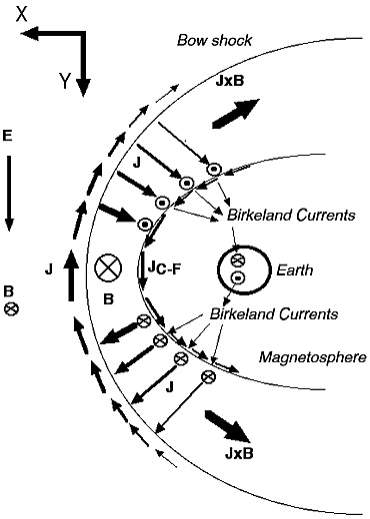

In [23]:
def return_adotb_cosine(jx,jy,jz,x,y,z,jmag,rmag):
    """Compute/return cosine angles for inputted A.B on xy and xz plane and full xyz coord, 
    where A⋅B  = |A||B |𝑐𝑜𝑠𝜃. Inputted (A,B) vectors will play the parts of (J,r)"""
    #Defining 2D position-vec magnitude
    R_xy = np.sqrt(y**2 + x**2) #defining |R_xy|
    R_xz = np.sqrt(x**2 + z**2) #defining |R_xz|
    #Defining 2D current magnitude
    J_xy = np.sqrt(jy**2 + jx**2) #defining |J_xy|
    J_xz = np.sqrt(jx**2 + jz**2) #defining |J_xz|
    #Normalizing position vectors to 2D plane by doing (R_xy)^ = <x,y>/|R_xy| and (R_xz)^ = <x,z>/|R_xz|
    x1hat = x/R_xy 
    yhat = y/R_xy 
    zhat = z/R_xz
    x2hat = x/R_xz
        #^- confirmed that these position vectors were normalized to their respective 2D planes
        #rhat_xy = np.sqrt(x1hat**2+yhat**2)
        #rhat_xz = np.sqrt(x2hat**2+zhat**2)
        #for i in range(len(x)):
        #print('xhat = %0.3f, yhat = %0.3f, zhat = %0.3f, |rhat|_xy = %0.3f, and |rhat|_xz = %0.3f (Re units)'
        #    %(x1hat[i], yhat[i], zhat[i], rhat_xy[i], rhat_xz[i]))
    #Defining 2D cosine angles using 𝑐𝑜𝑠𝜃 = (𝐽⃗ ⋅𝑟̂ )/|𝐽|. Remember that |𝑟̂ | = 1
    cos_xy = (jx*x1hat + jy*yhat)/np.abs(J_xy)
    cos_xz = (jx*x2hat + jz*zhat)/np.abs(J_xz)
    #Define 3D cosine angle with full dot product 𝑐𝑜𝑠𝜃 = (𝐽⃗ ⋅r)/(|𝐽||r|)
    cos_xyz = (jx*x + jy*y + jz*z)/np.abs(jmag*rmag)
    return(cos_xy,cos_xz, cos_xyz);

def return_jcosine(jx,jy,jz,x,y,z,rmag):
    """Compute/return cosine dot product J.r on xy/xz plane or full xyz coord, where 𝐽⃗ ⋅𝑟̂  = |𝐽|𝑐𝑜𝑠𝜃"""
    #Defining 2D position-vec magnitude
    R_xy = np.sqrt(y**2 + x**2) #defining |R_xy|
    R_xz = np.sqrt(x**2 + z**2) #defining |R_xz|
    #Defining 2D current magnitude
    J_xy = np.sqrt(jy**2 + jx**2) #defining |J_xy|
    J_xz = np.sqrt(jx**2 + jz**2) #defining |J_xz|
    #Normalizing position vectors to 2D plane by doing (R_xy)^ = <x,y>/|R_xy| and (R_xz)^ = <x,z>/|R_xz|
    xhat_y = x/R_xy 
    yhat = y/R_xy 
    zhat = z/R_xz
    xhat_z = x/R_xz
    #Defining 2D and 3D |J|cosine angles using |𝐽|𝑐𝑜𝑠𝜃 = (𝐽⃗ ⋅𝑟̂ ). Remember that |𝑟̂ | = 1
    jcos_xy = (jx*xhat_y + jy*yhat)
    jcos_xz = (jx*xhat_z + jz*zhat)
    jcos_xyz = (jx*x + jy*y + jz*z)/np.abs(rmag)
    return(jcos_xy,jcos_xz, jcos_xyz);


def return_adotbhat_mag(jx,jy,jz,x,y,z,jmag,rmag):
    """Compute/return dot product magnitudes for inputted A.Bhat on xy and xz plane and full xyz coord; 
    where A⋅B  = |A||B |𝑐𝑜𝑠𝜃. Inputted (A,B) vectors will play the parts of (J,r)"""
    #Defining 2D position-vec magnitude
    R_xy = np.sqrt(y**2 + x**2) #defining |R_xy|
    R_xz = np.sqrt(x**2 + z**2) #defining |R_xz|
    #Normalizing position vectors to 2D plane by doing (R_xy)^ = <x,y>/|R_xy| and (R_xz)^ = <x,z>/|R_xz|
    x1hat = x/R_xy 
    yhat = y/R_xy 
    zhat = z/R_xz
    x2hat = x/R_xz
        #^- confirmed that these position vectors were normalized to their respective 2D planes
        #rhat_xy = np.sqrt(x1hat**2+yhat**2)
        #rhat_xz = np.sqrt(x2hat**2+zhat**2)
        #for i in range(len(x)):
        #print('xhat = %0.3f, yhat = %0.3f, zhat = %0.3f, |rhat|_xy = %0.3f, and |rhat|_xz = %0.3f (Re units)'
        #    %(x1hat[i], yhat[i], zhat[i], rhat_xy[i], rhat_xz[i]))
    #Defining 2D dot product magnitude using |𝐽⃗ ⋅𝑟̂ | Remember that |𝑟̂ | = 1
    mag_adotb_xy = np.abs(jx*x1hat +jy*yhat)
    mag_adotb_xz = np.abs(jx*x2hat + jz*zhat)
    #Define full 3D dot product magnitude (𝐽⃗ ⋅𝑟̂ ) = (𝐽⃗ ⋅r)/(|r|)
    mag_adotb_xyz = np.abs(jx*x + jy*y + jz*z)/np.abs(rmag)
    return(mag_adotb_xy,mag_adotb_xz, mag_adotb_xyz);

def get_currbvec_params(df_curr):
    """Extract copies of current_avg and bfield_avg vectors as 1D arrays"""
    #Extracting copies of Bfield position vectors(measured in nT)
    bx_avg = df_curr['mms1Bx_avg(nT)'].to_numpy(copy=True)
    by_avg = df_curr['mms1By_avg'].to_numpy(copy=True)
    bz_avg = df_curr['mms1Bz_avg'].to_numpy(copy=True)
    bmag_avg = df_curr['mms1Bmag_avg'].to_numpy(copy=True)
    #Extracting copies of avg current vector data(measured in uA/m2)
    jx_avg = df_curr['Jx_avg(uA/m2)'].to_numpy(copy=True)
    jy_avg = df_curr['Jy_avg'].to_numpy(copy=True)
    jz_avg = df_curr['Jz_avg'].to_numpy(copy=True)
    jmag_avg = df_curr['Jmag_avg'].to_numpy(copy=True)
    print('\tAcquired: current and bvec data as 1D arrays')
    return(jx_avg,jy_avg,jz_avg,jmag_avg, bx_avg,by_avg,bz_avg,bmag_avg);


def display_FACcosCOLORmaps(df_stable_fac, achTitle, achClang):
    """With inputted Stable IMFnCurrPkBvecMEC DF, display a contour map(pcolormesh) of the (J.B^) magnitude values
    which will be manually interpolated onto a 2D grid in the xy-plane. The color bar is based on this magnitude range"""
    ##Making PCmesh
    print('\n(J.B^) Contour Mapping with: ',namestr(df_stable_fac, globals()), achClang)
    #extracting copies of position data as numpy arrays
    x = df_stable_fac['x_avg(Re)'].to_numpy(copy=True)
    y = df_stable_fac['y_avg(Re)'].to_numpy(copy=True)
    #Extracting 1D arrays of avg curr-bvec vector data(measured in uA/m2 and nT respectively)
    [jx,jy,jz,jmag, bx,by,bz,bmag] = get_currbvec_params(df_stable_fac)
    #Define (J.B^) magnitude on xy and xz plane. And also full dot product with xyz coord system
    [jbhat_xy, jbhat_xz, jbhat_xyz] = return_adotbhat_mag(jx,jy,jz,bx,by,bz,jmag,bmag)
    jdr_xz = r'$\hat{J}\cdot\hat{B})_{xz}$' #latex string version of (J.B^)
    jdr_xy = r'$\vec{J}\cdot\hat{B}$'
    pLabel1 = '%s IMF\n%s Magnitude Contour'%(achClang, jdr_xy)
    # 'Stable Southward Bz IMF\n (J.B^) Magnitude Contour 2015-21'
    #Create 2D meshgrid by defining grid value range from MEC position vectors
    ndps = 100 #define nxn grid
    xi = np.linspace(np.min(x), np.max(x), ndps)
    yi = np.linspace(np.min(y), np.max(y), ndps)
    Xi, Yi = np.meshgrid(xi, yi) #create meshgrid from grid values
    Ei = np.sqrt(Xi**2 + Yi**2) <= 1
    #Using manual function to interpolate (J.B^) magnitude data onto a 2D grid//create 2D FACxy array
    man_FACxy = get_manual_2Dswd(x,y,xi,yi, jbhat_xyz)       
    ##Create subplot parameters
    fig, ax1 = plt.subplots(figsize = (13, 10)) #setting size of subplots
    #fig.suptitle(achTitle, y =0.99,fontsize = 20) #single title over multiple subplots
    #setting background plot color
    ax1.set_facecolor('lightgray')
    """For 1x1 Subplots: figsize = (10,10), title size =20, axis label/tick size = 16, legend font = 14"""
    fsize = 16 #fontsize of axis labels/ticks
    legsize = 14 #legend fontsize
    #Cbar = cm.bwr #defining colormap
    Cbar = cm.cool
    #Cbar = matplotlib.colors.LinearSegmentedColormap.from_list("", ["xkcd:blue","white","xkcd:orange"])
    """pcmesh `label` argument isn't displaying on legend, so I'll use the empty plot workaround.
            Setting lw = 15 and 'r--' linestyle matches quiver legend label symbol"""
    #--FAC cosine pcmesh---
    #--Rick wants the color scale to be saturated at around 0.6 or 0.4
    pcol1 = ax1.pcolormesh(xi,yi, man_FACxy, vmin = np.min(jbhat_xyz), vmax = 0.2,shading = 'auto', cmap = Cbar)
    #draw_circle1 = plt.Circle((0, 0), 1, color = 'black')
    #ax1.add_artist(draw_circle1)
    ax1.set_title(achTitle, fontsize = 20)
    draw_earth_center(1.0, ax1, 'right') #plotting Earth as half black-white cirle
    ax1.plot([], [], 'ko', label='Earth') #empty plot label workaround
    ax1.tick_params(axis='both', labelsize=fsize) #setting axes tick labelsize
    ax1.set_ylabel('$Y_{GSM}$ [Re]', fontsize = fsize), ax1.set_xlabel('$X_{GSM}$ [Re]', fontsize = fsize)
    ax1.legend(title = '%s'%(pLabel1), title_fontsize = fsize, prop={'size': legsize}, bbox_to_anchor=(1.20,1), loc="upper left", shadow = True)
    #ax1.legend(title = '%s'%(pLabel1), title_fontsize = legsize, loc = 'best', prop={'size': legsize}, shadow = True)
    cb1 = plt.colorbar(pcol1, ax = ax1)
    cb1.ax.tick_params(labelsize=legsize-2)  # change colorbar ticksize
    cb1.ax.set_ylabel('(J.B^) Magnitude Values',fontsize=legsize-2) #change colorbar label fontsize
    plt.tight_layout()
    return;



#-------------Main Below---------------------
#Display Stable soBz FAC/(J.B)^ cosine Contour Map on xyplane

#display_FACcosCOLORmaps(stabAll_soBz_currMECB_Filt_2015to21, 'Stable soBz IMF: Avg FAC Contour 2015-21', 'Southward Bz')
#plt.savefig('manual_StablesoBz_2DXY_avgFACMAP_2015to21_v5', bbox_inches='tight', facecolor = 'w')


(J.r)^ Contour Mapping with:  ['stabDay_5MGSsoBz_currMECB_jmagQSOPtrim_2015to21'] Southward Bz
	Acquired: curr-mec vector data as 1D arrays
	x_grid space = 0.338 and y_grid space = 0.464
	Shape of manual_SWDxy is (row,col) =  (100, 100)
	-->Created: Manually-interp 2D SWDxy array
	Completed: Created Shue MP Model as (x,y) coord
['gse', 'gsm']
Running transformation: subgse2gsm
Output variable: Rgsm_bs

(J.r)^ Contour Mapping with:  ['stabDay_5MGSnorBz_currMECB_jmagQSOPtrim_2015to21'] Northward Bz
	Acquired: curr-mec vector data as 1D arrays
	x_grid space = 0.335 and y_grid space = 0.461
	Shape of manual_SWDxy is (row,col) =  (100, 100)
	-->Created: Manually-interp 2D SWDxy array
	Completed: Created Shue MP Model as (x,y) coord
['gse', 'gsm']
Running transformation: subgse2gsm
Output variable: Rgsm_bs


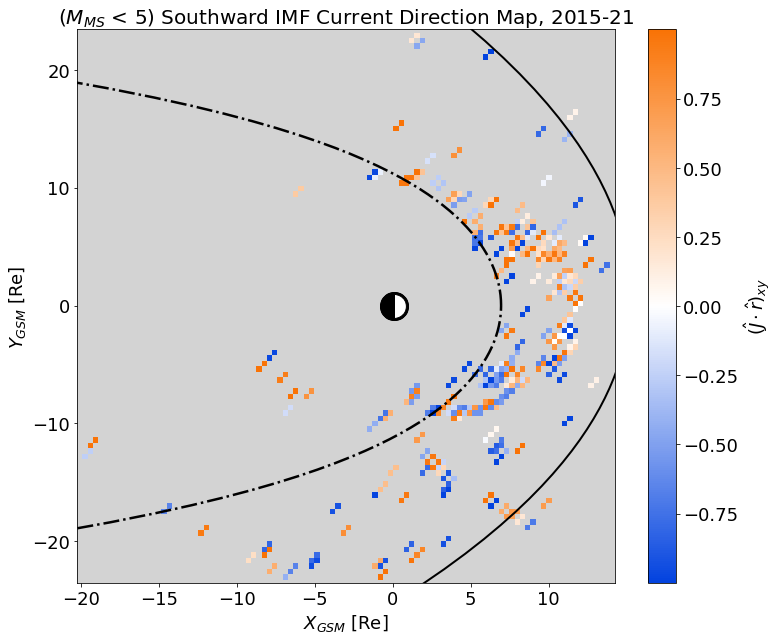

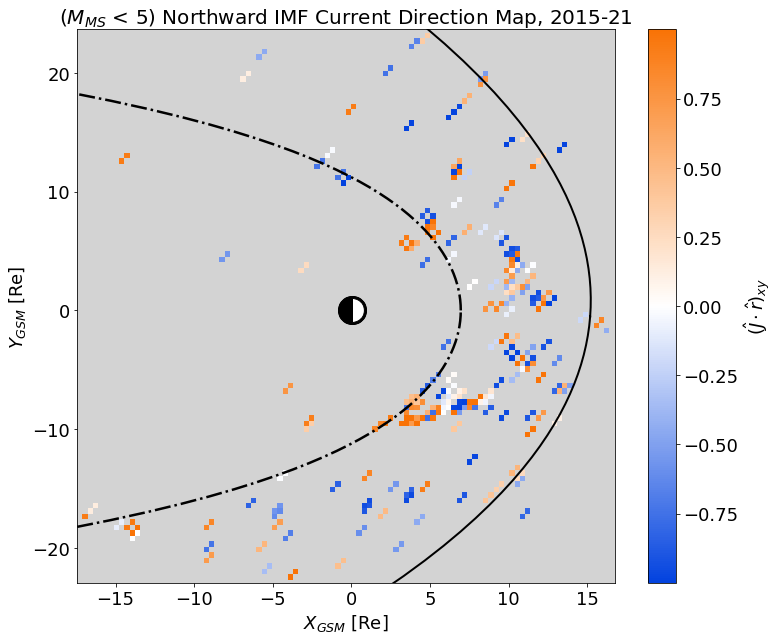

In [24]:
#help(fgm)
#help(mec)

def shue98_mp_model(theta):
    """Implementation of the magpause model as described in the Shue et al 1998 paper. For this model,
    I will use Sarah's MP values as this model requires Bz and Pdyn values at said magpause crossing. As
    I don't have a list of 'typical magpause crossings', I'll use what Sarah did"""
    #Sarah's Bz and Dynamic Pressure values at time of her magpause crossing
    Bz = -10.86
    #Bz = 1 #positive Bz values lead there to being no magpause compression when Bz < 0 
    P_dy = 8.56
    #Coefficients and 'radius' value which describes Shue98 MP model for soBz
    r0 = (10.22 + 1.29 * np.tanh(0.184 * (Bz + 8.14))) * (P_dy) ** (-1 / 6.6)
    alpha = (0.58 - 0.007 * Bz) * (1 + 0.024 * np.log(P_dy))  ###Flaring
    r = r0 * (2 / (1 + np.cos(theta[:]))) ** (alpha)
    #Defining/returning Shue98 MP model as (x,y) coord
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    print('\tCompleted: Created Shue MP Model as (x,y) coord')
    return(x,y);

def draw_magpause(ax, theta, color):
    """With above inputs, draw out Shue 1998 et al Magnetopause model"""
    if color == 'def': #default line color if empty input
        achCol = 'tab:cyan'
    else:
        achCol = color
    [x_mp, y_mp] = shue98_mp_model(theta)
    ax.plot(x_mp, y_mp, color = '%s'%(achCol),ls = '-.',lw = 2.5, label = 'Shue98 Magpause')
    return;

def draw_earth2_center(ax):
    """Draw half black-white Earth circle using circular unicode symbols"""
    #draw full white circle
    ax.plot(0,0,markeredgecolor='black',markerfacecolor='white',markersize=30,marker='$\u25CF$')
    #draw half-black circle (by default, the nonblack side is transparent)
    ax.plot(0,0,markeredgecolor='black',markerfacecolor='black',markersize=30,marker='$\u25D0$')
    return;

def convert_pos_toGSM(xgse, ygse, zgse):
    """Convert inputted GSE position data to GSM coord"""
    t_dumb = np.zeros(len(xgse))
    #print('Confirm created dummy time variable:', len(xgse)==len(t_dumb))
    #---Store BS Model GSE position variables as single tplot variable
    store_data('Xgse_bs', data={'x': t_dumb, 'y': xgse})
    store_data('Ygse_bs', data={'x': t_dumb, 'y': ygse})
    store_data('Zgse_bs', data={'x': t_dumb, 'y': zgse})
    join_vec(['Xgse_bs', 'Ygse_bs', 'Zgse_bs'], new_tvar='Rgse_bs')
    #Convert and extract new GSM coord position data
    cotrans(name_in='Rgse_bs', name_out='Rgsm_bs', coord_in='gse', coord_out='gsm')
    dumb_time, Rgsm_vec = get_data('Rgsm_bs')
    return(Rgsm_vec[:,0], Rgsm_vec[:,1], Rgsm_vec[:,2]); 

def mitsuo_peredo95_bs_model(theta):
    """Implementation of the bowshock model as descibed in the semi-empirical Peredo et al 1995 paper.
    However, since both this paper and a version of it in the cluster book use different coordinate systems. 
    Mitsuo has allowed me to use his IDL code which I have adapted here to Python in my own style.
    Note: Peredo's model only does GSE -> other coordinate system"""
    #---Cluster Book's parameters for Peredo's BS Model(z = 0)
    eps = 0.98 #epsilon is eccentricity of the conic
    alph0 = 3.8 #degrees
    L = 26.1 #in Re units; L is the semilatus rectum 
    x0 = 2.0
    y0 = 0.3
    alpha = alph0 - 0.6 #degrees
    a = np.deg2rad(alpha) #needs to be in radians for numpy trig function inputs
    Pdyn = 3.1 #dynamic pressure measured in nPa
    #theta = np.linspace(0, 2*np.pi, 100) #theta array from 0->pi
    r_model = L/(1 + eps*np.cos(theta)) #'symmetric conic section' used for the BS(BowShock) models

    #--Define position data in aberrated-GSE coord(cone system)
    phi = np.zeros(len(theta)) #will be array of zeros since we're looking at the BS on the xy-plane
    xabd = r_model*np.cos(theta)
    yabd = r_model*np.sin(theta)*np.cos(phi)
    zabd = r_model*np.sin(theta)*np.sin(phi)
    #xabd2 = xabd
    #yabd2 = -yabd #other side of axis
    """From googling conic sections in polar coord, it's still holds true that x = rcos and y = rsin. However, 
    I must ask Mitsuo for the justification of the trig(phi) muliplying factor onto (y and z) since all conic section formula 
    explanantions presume we're plotting in the xy-plane with z = 0"""
    #-Transforming back to GSE coord using Cluster book's transformation
    xgse =  (xabd+x0)*np.cos(a)+(yabd+y0)*np.sin(a)
    ygse = -(xabd+x0)*np.sin(a)+(yabd+y0)*np.cos(a)
    zgse = zabd
    #ygse2= -(xabd2+x0)*np.sin(a)+(yabd2+y0)*np.cos(a)
    #convert to GSM coord
    [xgsm, ygsm, zgsm] = convert_pos_toGSM(xgse, ygse, zgse) #convert to GSM coord
    return(xgsm, ygsm, zgsm);

def get_currmec_params(df_curr):
    """Extract copies of current_avg and MECpos vectors as 1D arrays"""
    #Extracting copies of MEC position vectors(measured in Earth Radii)
    MECx = df_curr['x_avg(Re)'].to_numpy(copy=True)
    MECy = df_curr['y_avg(Re)'].to_numpy(copy=True)
    MECz = df_curr['z_avg(Re)'].to_numpy(copy=True)
    MECr = df_curr['Rmag_avg(Re)'].to_numpy(copy=True)
    #Extracting copies of avg current vector data(measured in uA/m2)
    jx_avg = df_curr['Jx_avg(uA/m2)'].to_numpy(copy=True)
    jy_avg = df_curr['Jy_avg'].to_numpy(copy=True)
    jz_avg = df_curr['Jz_avg'].to_numpy(copy=True)
    jmag_avg = df_curr['Jmag_avg'].to_numpy(copy=True)
    print('\tAcquired: curr-mec vector data as 1D arrays')
    return(jx_avg,jy_avg,jz_avg,jmag_avg, MECx,MECy,MECz,MECr);

def display_jdotrCOLORmaps(df_stable_fac, achTitle, achClang):
    """With inputted Stable IMFnCurrPkBvecMEC DF, display a contour map(pcolormesh) of the (J.r)^ cosine angles
    which will be manually interpolated onto a 2D grid in the xy-plane. The color bar is based on these cosine values"""
    ##Making PCmesh
    print('\n(J.r)^ Contour Mapping with: ',namestr(df_stable_fac, globals()), achClang)
    #Extracting 1D arrays of avg curr-mec vector data(measured in uA/m2 and Earth Radii respectively)
    [jx,jy,jz,jmag,x,y,z,rmag] = get_currmec_params(df_stable_fac)
    #Define (J.r)^ cosine values on xy/xz plane and full xyz-coord system.
    [cos_xy, cos_xz, cos_xyz] = return_adotb_cosine(jx,jy,jz,x,y,z,jmag,rmag)    
    jdr_xy = r'($\hat{J}\cdot\hat{r})_{xy}$'   #latex string version of (J.r)^
    pLabel1 = '%s IMF\n%s Contour'%(achClang, jdr_xy)
    # 'Stable Southward Bz IMF\n (J.B)^ Cosine Contour 2015-21'
    #Create 2D meshgrid by defining grid value range from MEC position vectors
    ndps = 100 #define nxn grid
    xi = np.linspace(np.min(x), np.max(x), ndps)
    yi = np.linspace(np.min(y), np.max(y), ndps)
    Xi, Yi = np.meshgrid(xi, yi) #create meshgrid from grid values
    Ei = np.sqrt(Xi**2 + Yi**2) <= 1
    #Using manual function to interpolate (J.r)^ cosine data onto a 2D grid//create 2D JDRxy array
    man_JDRxy = get_manual_2Dswd(x,y,xi,yi, cos_xy)       
    ##Create subplot parameters
    #fig, ax1 = plt.subplots(figsize = (13, 10)) #setting size of subplots
    fig, ax1 = plt.subplots(figsize = (11, 9)) #setting size of subplots; for single plot no legend
    #fig.suptitle(achTitle, y =0.99,fontsize = 20) #single title over multiple subplots
    #setting background plot color
    ax1.set_facecolor('lightgray')
    """For 1x1 Subplots: figsize = (10,10), title size =20, axis label/tick size = 16, legend font = 14"""
    fsize = 18 #fontsize of axis labels/ticks
    legsize = 16 #legend fontsize
    #Cbar = cm.bwr #defining colormap
    #Cbar = cm.cool
    Cbar = matplotlib.colors.LinearSegmentedColormap.from_list("", ["xkcd:blue","white","xkcd:orange"])
    """pcmesh `label` argument isn't displaying on legend, so I'll use the empty plot workaround.
            Setting lw = 15 and 'r--' linestyle matches quiver legend label symbol"""
    #--FAC cosine pcmesh---
    pcol1 = ax1.pcolormesh(xi,yi, man_JDRxy, vmin = np.min(cos_xy), vmax = np.max(cos_xy),shading = 'auto', cmap = Cbar)
    ''' #Old way of plotting earth as just a solid colored circle
    draw_circle1 = plt.Circle((0, 0), 1, color = 'black')
    ax1.set_title(achTitle, fontsize = 20)
    ax1.add_artist(draw_circle1)
    ax1.plot([], [], 'ko', label='Earth') #empty plot label workaround
    '''
    ax1.set_title(achTitle, fontsize = 20)
    #draw_earth_center(1.0, ax1, 'right') #plotting Earth as half black-white cirle
    draw_earth2_center(ax1)
    ax1.plot([], [], 'ko', label='Earth') #empty plot label workaround
    fTheta = np.linspace(0, 2*np.pi, 100)
    #'''
    #--Drawing Shue et al 1998 magnetopause. Also, gotta set axis limits to not show 'entire mp' model
    draw_magpause(ax1, fTheta, 'black') #aquamarine
    #[x_mp, y_mp] = shue98_mp_model(fTheta)
    #ax1.plot(x_mp, y_mp, 'c--',lw = 3, label = 'Shue98 Magpause')
    #--Draw Peredo 1995 Bowshock(in GSM coord)
    [xgsm_bs, ygsm_bs, zgsm_bs] = mitsuo_peredo95_bs_model(fTheta) #plotting bowshock
    ax1.plot(xgsm_bs, ygsm_bs,color = 'black', ls = '-', lw = 2, label = 'Peredo95 Bowshock')
    ax1.set_xlim([np.min(xi)-0.5, np.max(xi)+0.5])
    ax1.set_ylim([np.min(yi)-0.5, np.max(yi)+0.5])
    #''';
    #--PLotting MMS recorded Rmag limit
    radius = 7
    a = radius * np.cos(fTheta)
    b = radius * np.sin(fTheta)
    #ax1.plot(a, b, '--', color='red')
    ax1.tick_params(axis='both', labelsize=fsize) #setting axes tick labelsize
    ax1.set_ylabel('$Y_{GSM}$ [Re]', fontsize = fsize), ax1.set_xlabel('$X_{GSM}$ [Re]', fontsize = fsize)
    
    #ax1.legend(title = '%s'%(pLabel1), title_fontsize = fsize, prop={'size': legsize}, bbox_to_anchor=(1.20,1), loc="upper left", shadow = True)
    
    #ax1.legend(title = '%s'%(pLabel1), title_fontsize = legsize, loc = 'best', prop={'size': legsize}, shadow = True)
    #ax1.set_aspect('equal')#, adjustable = 'box')
    cb1 = plt.colorbar(pcol1, ax = ax1)
    cb1.ax.tick_params(labelsize=fsize)# legsize-2)  # change colorbar ticksize
    achCLabel = '%s'%(jdr_xy)
    cb1.ax.set_ylabel('%s'%(achCLabel),fontsize=fsize)#legsize) #change colorbar label fontsize
    plt.tight_layout()
    return;



#-------------Main Below---------------------
#Display Stable soBz (J.r)^ cosine Contour Map on xyplane

#display_jdotrCOLORmaps(stabAll_soBz_currMECB_Filt_2015to21, 'Stable soBz IMF Current Map 2015-21', 'Southward Bz')
#plt.savefig('manual_noleg_StablesoBz_2DXY_avgCurrMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')
#----------
#display_jdotrCOLORmaps(stabDay_soBz_currMECB_jmagQSOPtrim_2015to21, r'(Typical $M_{MS}$) Southward IMF Current Direction Map, 2015-21', 'Southward Bz')
#plt.savefig('manual_noleg_StableDaysoBz_2DXY_avgCurrMAP_2015to21_v2', bbox_inches='tight', facecolor = 'w')

#plt.savefig('manual_StableDaysoBz_2DXY_avgCurrMAP_2015to21_v4', bbox_inches='tight', facecolor = 'w')


#display_jdotrCOLORmaps(stabDay_norBz_currMECB_jmagQSOPtrim_2015to21, r'(Typical $M_{MS}$) Northward IMF Current Direction Map, 2015-21', 'Northward Bz')
#plt.savefig('manual_noleg_StableDaynorBz_2DXY_avgCurrMAP_2015to21_v2', bbox_inches='tight', facecolor = 'w')

#plt.savefig('manual_StableDaynorBz_2DXY_avgCurrMAP_2015to21_v4', bbox_inches='tight', facecolor = 'w')


#---Displaying (MGSMach < 5) Stable Day soBz IMF Jdotr Map
display_jdotrCOLORmaps(stabDay_5MGSsoBz_currMECB_jmagQSOPtrim_2015to21, r'($M_{MS}$ < 5) Southward IMF Current Direction Map, 2015-21', 'Southward Bz')
#plt.savefig('manual_noleg_StableDay_5MGSsoBz_2DXY_avgCurrMAP_2015to21_v2', bbox_inches='tight', facecolor = 'w')

display_jdotrCOLORmaps(stabDay_5MGSnorBz_currMECB_jmagQSOPtrim_2015to21, r'($M_{MS}$ < 5) Northward IMF Current Direction Map, 2015-21', 'Northward Bz')
#plt.savefig('manual_noleg_StableDay_5MGSnorBz_2DXY_avgCurrMAP_2015to21_v2', bbox_inches='tight', facecolor = 'w')


(J.r)^ Contour Mapping with:  ['stabDay_5MGSposBy_currMECB_jmagQSOPtrim_2015to21'] Positive By
	Acquired: curr-mec vector data as 1D arrays
	x_grid space = 0.333 and y_grid space = 0.214
	Shape of manual_SWDxy is (row,col) =  (100, 100)
	-->Created: Manually-interp 2D SWDxy array
	Completed: Created Shue MP Model as (x,y) coord

(J.r)^ Contour Mapping with:  ['stabDay_5MGSnegBy_currMECB_jmagQSOPtrim_2015to21'] Negative By
	Acquired: curr-mec vector data as 1D arrays
	x_grid space = 0.359 and y_grid space = 0.194
	Shape of manual_SWDxy is (row,col) =  (100, 100)
	-->Created: Manually-interp 2D SWDxy array
	Completed: Created Shue MP Model as (x,y) coord


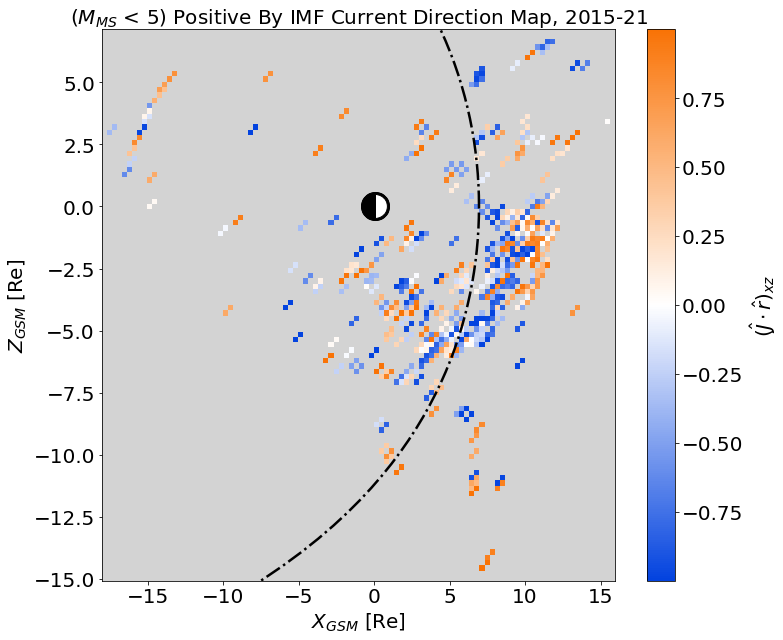

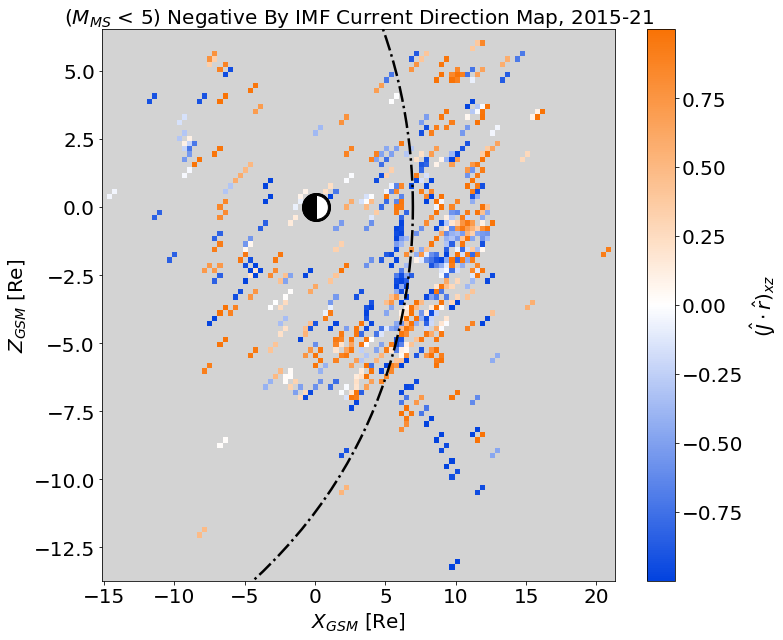

In [25]:
def display_jdotrCOLORmapsXZ(df_stable_fac, achTitle, achClang):
    """With inputted Stable IMFnCurrPkBvecMEC DF, display a contour map(pcolormesh) of the (J.r)^ cosine angles
    which will be manually interpolated onto a 2D grid in the xz-plane. The color bar is based on these cosine values"""
    ##Making PCmesh
    print('\n(J.r)^ Contour Mapping with: ',namestr(df_stable_fac, globals()), achClang)
    #Extracting 1D arrays of avg curr-mec vector data(measured in uA/m2 and Earth Radii respectively)
    [jx,jy,jz,jmag,x,y,z,rmag] = get_currmec_params(df_stable_fac)
    #Define (J.r)^ cosine values on xy/xz plane and full xyz-coord system.
    [cos_xy, cos_xz, cos_xyz] = return_adotb_cosine(jx,jy,jz,x,y,z,jmag,rmag)    
    jdr_xy = r'$(\hat{J}\cdot\hat{r})_{xz}$'   #latex string version of (J.r)^
    pLabel1 = '%s IMF\n%s Contour'%(achClang, jdr_xy)
    # 'Stable Southward Bz IMF\n (J.B)^ Cosine Contour 2015-21'
    #Create 2D meshgrid by defining grid value range from MEC position vectors
    ndps = 100 #define nxn grid
    xi = np.linspace(np.min(x), np.max(x), ndps)
    zi = np.linspace(np.min(z), np.max(z), ndps)
    Xi, Zi = np.meshgrid(xi, zi) #create meshgrid from grid values
    Ei = np.sqrt(Xi**2 + Zi**2) <= 1
    #Using manual function to interpolate (J.r)^ cosine data onto a 2D grid//create 2D JDRxz array
    man_JDRxz = get_manual_2Dswd(x,z,xi,zi, cos_xz)       
    ##Create subplot parameters
    #fig, ax1 = plt.subplots(figsize = (13, 10)) #setting size of subplots
    fig, ax1 = plt.subplots(figsize = (11, 9)) #setting size of subplots; for single plot no legend
    #fig = plt.figure()
    #ax1 = fig.add_subplot(111)
    #ax1.set_aspect('equal')

    #fig.suptitle(achTitle, y =0.99,fontsize = 20) #single title over multiple subplots
    #setting background plot color
    ax1.set_facecolor('lightgray')
    """For 1x1 Subplots: figsize = (10,10), title size =20, axis label/tick size = 16, legend font = 14"""
    fsize = 20 #fontsize of axis labels/ticks
    legsize = 16 #legend fontsize
    #Cbar = cm.bwr #defining colormap
    #Cbar = cm.cool
    Cbar = matplotlib.colors.LinearSegmentedColormap.from_list("", ["xkcd:blue","white","xkcd:orange"])
    """pcmesh `label` argument isn't displaying on legend, so I'll use the empty plot workaround.
            Setting lw = 15 and 'r--' linestyle matches quiver legend label symbol"""
    #--Jdotr cosine pcmesh---
    pcol1 = ax1.pcolormesh(xi,zi, man_JDRxz, vmin = np.min(cos_xz), vmax = np.max(cos_xz),shading = 'auto', cmap = Cbar)
    ax1.set_title(achTitle, fontsize = 20)
    #draw_earth_center(1.0, ax1, 'right') #plotting Earth as half black-white cirle
    draw_earth2_center(ax1)
    ax1.plot([], [], 'ko', label='Earth') #empty plot label workaround
    fTheta = np.linspace(0, 2*np.pi, 100)
    #'''
    #--Drawing Shue et al 1998 magnetopause. Also, gotta set axis limits to not show 'entire mp' model
    draw_magpause(ax1, fTheta, 'black') #aquamarine
    #[x_mp, y_mp] = shue98_mp_model(fTheta)
    #ax1.plot(x_mp, y_mp, 'c--',lw = 3, label = 'Shue98 Magpause')
    #--Peredo BS model doesn't display nicely for xz-plane. Only when using (xgse,ygse), so I probably won't show it
    '''
    #--Draw Peredo 1995 Bowshock
    [xgse_bs, ygse_bs, zgse_bs] = mitsuo_peredo95_bs_model(fTheta) #plotting bowshock
    ax1.plot(xgse_bs, ygse_bs,color = 'yellow', ls = '--', lw = 2, label = 'Peredo95 Bowshock')
    ''';
    #ax1.set_xlim([np.min(xi)-0.5, np.max(xi)+0.5])
    #ax1.set_ylim([np.min(zi)-0.5, np.max(zi)+0.5])
    #ax1.axis('square', )
    ax1.set(xlim=(np.min(xi)-0.5, np.max(xi)+0.5), ylim=(np.min(zi)-0.5, np.max(zi)+0.5)) 
    #ax1.set_aspect(xi.size/zi.size)

    #ax1.set_xlim([-15, 15])
    #ax1.set_ylim([-15, 15])
    #ax1.set_aspect('auto')

    #--PLotting MMS recorded Rmag limit
    radius = 7
    a = radius * np.cos(fTheta)
    b = radius * np.sin(fTheta)
    #ax1.plot(a, b, '--', color='red')
    ax1.tick_params(axis='both', labelsize=fsize) #setting axes tick labelsize
    ax1.set_ylabel('$Z_{GSM}$ [Re]', fontsize = fsize), ax1.set_xlabel('$X_{GSM}$ [Re]', fontsize = fsize)
    
    #ax1.legend(title = '%s'%(pLabel1), title_fontsize = fsize, prop={'size': legsize}, bbox_to_anchor=(1.20,1), loc="upper left", shadow = True)
    #ax1.legend(title = '%s'%(pLabel1), title_fontsize = legsize, loc = 'best', prop={'size': legsize}, shadow = True)
    cb1 = plt.colorbar(pcol1, ax = ax1)
    cb1.ax.tick_params(labelsize=fsize)  # change colorbar ticksize
    achCLabel = '%s'%(jdr_xy)
    cb1.ax.set_ylabel('%s'%(achCLabel),fontsize=fsize) #change colorbar label fontsize
    plt.tight_layout()
    return;



#-------------Main Below---------------------
#Display Stable IMF By (J.r)^ cosine Contour Map on xzplane


#display_jdotrCOLORmapsXZ(stabDay_posBy_currMECB_jmagQSOPtrim_2015to21, r'(Typical $M_{MS}$) Positive By IMF Current Direction Map, 2015-21', 'Positive By')
#plt.savefig('manual_noleg_StableDayposBy_2DXZ_avgCurrMAP_2015to21_v2', bbox_inches='tight', facecolor = 'w')

#display_jdotrCOLORmapsXZ(stabDay_negBy_currMECB_jmagQSOPtrim_2015to21, r'(Typical $M_{MS}$) Negative By IMF Current Direction Map, 2015-21', 'Negative By')
#plt.savefig('manual_noleg_StableDaynegBy_2DXZ_avgCurrMAP_2015to21_v2', bbox_inches='tight', facecolor = 'w')


#---Displaying (MGSMach < 5) Stable Day By IMF Jdotr Map
display_jdotrCOLORmapsXZ(stabDay_5MGSposBy_currMECB_jmagQSOPtrim_2015to21, r'($M_{MS}$ < 5) Positive By IMF Current Direction Map, 2015-21', 'Positive By')
#plt.savefig('manual_noleg_StableDay_5MGSposBy_2DXZ_avgCurrMAP_2015to21_v2', bbox_inches='tight', facecolor = 'w')

display_jdotrCOLORmapsXZ(stabDay_5MGSnegBy_currMECB_jmagQSOPtrim_2015to21, r'($M_{MS}$ < 5) Negative By IMF Current Direction Map, 2015-21', 'Negative By')
#plt.savefig('manual_noleg_StableDay_5MGSnegBy_2DXZ_avgCurrMAP_2015to21_v2', bbox_inches='tight', facecolor = 'w')


In [26]:
def hexbin_jdotrMAP(df_stable , achPlane,  achTitle, achClang):
    """Creating (J.r)^ cosine contour map via mpl hexbin"""
    print('\n(J.r)^ Contour MPL HexBinning with: ',namestr(df_stable, globals()), achClang)
    #Extracting 1D arrays of avg curr-mec vector data(measured in uA/m2 and Earth Radii respectively)
    [jx,jy,jz,jmag,x,y,z,rmag] = get_currmec_params(df_stable)
    #Define (J.r)^ cosine values on xy/xz plane and full xyz-coord system.
    [cos_xy, cos_xz, cos_xyz] = return_adotb_cosine(jx,jy,jz,x,y,z,jmag,rmag)    
    jdr_xy = r'$(\hat{J}\cdot\hat{r})_{xz}$'   #latex string version of (J.r)^
    pLabel1 = '%s IMF\n%s Cosine Contour'%(achClang, jdr_xy)
    ndps = 100 #define nxn grid
    xi = np.linspace(np.min(x), np.max(x), ndps)
    yi = np.linspace(np.min(y), np.max(y), ndps)
    zi = np.linspace(np.min(z), np.max(z), ndps)
    ##Create subplot parameters
    fig, ax1 = plt.subplots(figsize = (13, 10)) #setting size of subplots
    #setting background plot color
    ax1.set_facecolor('lightgray')
    """For 1x1 Subplots: figsize = (10,10), title size =20, axis label/tick size = 16, legend font = 14"""
    fsize = 16 #fontsize of axis labels/ticks
    legsize = 14 #legend fontsize
    #Cbar = cm.bwr #defining colormap
    #Cbar = cm.cool
    Cbar = matplotlib.colors.LinearSegmentedColormap.from_list("", ["xkcd:blue","white","xkcd:orange"])
    """pcmesh `label` argument isn't displaying on legend, so I'll use the empty plot workaround.
            Setting lw = 15 and 'r--' linestyle matches quiver legend label symbol"""
    fTheta = np.linspace(0, 2*np.pi, 100)
    #--Jdotr cosine hexbin---
    if achPlane == 'xy': #do hexbin on xy plane
        hex1 = ax1.hexbin(x, y, C = cos_xy, gridsize = (100,100), cmap =Cbar)
        ax1.set_ylabel('$Y_{GSM}$ [Re]', fontsize = fsize)
        [xgse_bs, ygse_bs, zgse_bs] = mitsuo_peredo95_bs_model(fTheta) #plotting bowshock
        ax1.plot(xgse_bs, ygse_bs,color = 'fuchsia', ls = '--', lw = 2, label = 'Peredo95 Bowshock')
        ax1.set_xlim([np.min(xi)-0.5, np.max(xi)+0.5])
        ax1.set_ylim([np.min(yi)-0.5, np.max(yi)+0.5])
    else: #do hexbin on xzplane
        hex1 = ax1.hexbin(x, z, C = cos_xz, gridsize = (100,100), cmap =Cbar)
        ax1.set_ylabel('$Z_{GSM}$ [Re]', fontsize = fsize)
        ax1.set_xlim([np.min(xi)-0.5, np.max(xi)+0.5])
        ax1.set_ylim([np.min(zi)-0.5, np.max(zi)+0.5])
        #--Peredo BS model doesn't display nicely for xz-plane. Only when using (xgse,ygse), so I probably won't show it

    ax1.set_title(achTitle, fontsize = 20)
    draw_earth_center(1.0, ax1, 'right') #plotting Earth as half black-white cirle
    ax1.plot([], [], 'ko', label='Earth') #empty plot label workaround
    #--Drawing Shue et al 1998 magnetopause. Also, gotta set axis limits to not show 'entire mp' model
    [x_mp, y_mp] = shue98_mp_model(fTheta)
    ax1.plot(x_mp, y_mp, 'c--',lw = 3, label = 'Shue98 Magpause')
    #--Peredo BS model doesn't display nicely for xz-plane. Only when using (xgse,ygse), so I probably won't show it
    #ax1.set_xlim([np.min(xi)-0.5, np.max(xi)+0.5])
    #ax1.set_ylim([np.min(zi)-0.5, np.max(zi)+0.5])
    #--PLotting MMS recorded Rmag limit
    radius = 7
    a = radius * np.cos(fTheta)
    b = radius * np.sin(fTheta)
    ax1.plot(a, b, '--', color='red')
    ax1.tick_params(axis='both', labelsize=fsize) #setting axes tick labelsize
    ax1.set_xlabel('$X_{GSM}$ [Re]', fontsize = fsize)
    ax1.legend(title = '%s'%(pLabel1), title_fontsize = fsize, prop={'size': legsize}, bbox_to_anchor=(1.20,1), loc="upper left", shadow = True)
    #ax1.legend(title = '%s'%(pLabel1), title_fontsize = legsize, loc = 'best', prop={'size': legsize}, shadow = True)
    cb1 = plt.colorbar(hex1, ax = ax1)
    cb1.ax.tick_params(labelsize=legsize-2)  # change colorbar ticksize
    cb1.ax.set_ylabel('(J.r)^ Cosine Values',fontsize=legsize-2) #change colorbar label fontsize
    plt.tight_layout()
    return;



#hexbin_jdotrMAP(stabDay_posBy_currMECB_jmagQSOPtrim_2015to21, 'xz', 'StableDay posBy IMF Current Map 2015-21', 'Positive By')

#hexbin_jdotrMAP(stabDay_negBy_currMECB_jmagQSOPtrim_2015to21, 'xz', 'StableDay negBy IMF Current Map 2015-21', 'Negative By')

#hexbin_jdotrMAP(stabDay_soBz_currMECB_jmagQSOPtrim_2015to21, 'xy', 'StableDay soBz IMF Current Map 2015-21', 'Southward Bz')
#plt.savefig('manual_StableDaysoBz_2DXY_avgCurrMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#hexbin_jdotrMAP(stabDay_norBz_currMECB_jmagQSOPtrim_2015to21, 'xy', 'StableDay norBz IMF Current Map 2015-21', 'Northward Bz')


In [27]:
#help(plt.gca())

* (7-15-22) Some things I discussed with Rick about the FAC and SWD maps. (I'll fill it in later)
    * PHansel paper on 'Mapping MMS Observations of SWD'(as referenced by Rick for this work): https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2021JA029389
        * Some cool paper references: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018JA025830
        * https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/JA077i004p00736

In [28]:
from pyspedas import cotrans

help(cotrans)
#cotrans(name_in='B_GSE', name_out='B_GSM', coord_in='gse', coord_out='gsm')

Help on function cotrans in module pyspedas.cotrans.cotrans:

cotrans(name_in=None, name_out=None, time_in=None, data_in=None, coord_in=None, coord_out=None)
    Transform data from coord_in to coord_out.
    
    Parameters
    ----------
    name_in: str, optional
        Pytplot name for input data.
    name_out: str, optional
        Pytplot name for output data.
    time_in: list of float, optional
        Time array.
        Ignored if name_in is provided.
    data_in: list of float, optional
        Data in the coord_in system.
        Ignored if name_in is provided.
    coord_in: str
        Name of input coordinate system.
    coord_out: str
        Name of output coordinate system.
    
    Returns
    -------
    Returns 1 for suggesful completion.
        Fills a new pytplot variable with data in the coord_out system.



## Section 5: Extracting Stable IMF's Solar Wind Speed and Ion Density Data
* Using the trange tuples of all Stable 2015-21 soBzMECnB IMF Dataframes, we'll loop through FPI ion-data and collect the avg x-velocity and density values for each time interval and respective Bin-number
---
### Section 5.1a: Parsing Through FPI Data to eliminate any time intervals that don't contain CDF files
* As usual, I gotta trim my Stable IMFnMEC DF of any time intervals that don't contain CDF files
    * We're gonna do two FPI-trimming passes:
        * The first trim run shall run through all StableDay IMF DFs that were used to create the current-cosine contour maps(CURLnJFilt_trim)
        * The 2nd trum run shall just be of the original Stable IMF DFS before the creation of the current maps. pre CURL extraction, since there may be more datapoints not trimmed out by the CURL extractor


In [29]:
#----Extracting trange tuples from Stable IMF currMECB_JFilt DFs------
#trange_StabDaysoBz_CurlnFilt_2015to21 = convert_trange_tuple(stabDay_soBz_currMECB_jmagQSOPtrim_2015to21)
#trange_StabDaynorBz_CurlnFilt_2015to21 = convert_trange_tuple(stabDay_norBz_currMECB_jmagQSOPtrim_2015to21)
#trange_StabDayposBy_CurlnFilt_2015to21 = convert_trange_tuple(stabDay_posBy_currMECB_jmagQSOPtrim_2015to21)
#trange_StabDaynegBy_CurlnFilt_2015to21 = convert_trange_tuple(stabDay_negBy_currMECB_jmagQSOPtrim_2015to21)

trange_5MGSStabDaysoBz_CurlnFilt_2015to21 = convert_trange_tuple(stabDay_5MGSsoBz_currMECB_jmagQSOPtrim_2015to21)
trange_5MGSStabDaynorBz_CurlnFilt_2015to21 = convert_trange_tuple(stabDay_5MGSnorBz_currMECB_jmagQSOPtrim_2015to21)
trange_5MGSStabDayposBy_CurlnFilt_2015to21 = convert_trange_tuple(stabDay_5MGSposBy_currMECB_jmagQSOPtrim_2015to21)
trange_5MGSStabDaynegBy_CurlnFilt_2015to21 = convert_trange_tuple(stabDay_5MGSnegBy_currMECB_jmagQSOPtrim_2015to21)


<class 'tuple'>
['2015-09-06/12:25:00', '2015-09-06/12:35:00'] ---> ['2021-05-18/03:00:00', '2021-05-18/03:10:00']
263
<class 'tuple'>
['2015-10-21/13:25:00', '2015-10-21/13:35:00'] ---> ['2021-05-08/20:00:00', '2021-05-08/20:10:00']
209
<class 'tuple'>
['2015-09-03/18:20:00', '2015-09-03/18:30:00'] ---> ['2021-05-29/11:30:00', '2021-05-29/11:40:00']
463
<class 'tuple'>
['2015-09-23/09:10:00', '2015-09-23/09:20:00'] ---> ['2021-05-25/05:45:00', '2021-05-25/05:55:00']
483


In [30]:
#----------Trimming FPI Ion Data from Stable Day IMF DataFrames----
def error_ion_tp_test():
    """Return boolean result based on whether or not an FPI error occurs(no data available)"""
    bError = False #initialize boolean variable
    # Creating single tplot variables for fpi ion temps
    try: #method of bypassing errors that may occur from FPI errors(no data available)
        join_vec(['mms1_dis_temppara_fast','mms1_dis_tempperp_fast'],new_tvar='fpi_ion_temps') 
    except: # define bError as true if an error was detected
        print('KeyError occurred with FPI or some other routine')
        bError = True 
    return(bError);

def load_FPI_iondata(achDate):
    """Using inputted trange, Load up FPI ion survey data"""
    pytplot.del_data() #deleting previously loaded tplot variables
    print('\nInput date was: %s '%(achDate))
        #Loading FPI ion data; has no gsm coord data
    ion_vars = fpi(datatype='dis-moms',trange=achDate,center_measurement=True,data_rate = 'fast',time_clip=True)
    return;

def noFPI_ion_datatrim(Date, df_data):
    """Loads up FPI iondata and trims down time intervals that don't contain any CDF files."""
    print('\nFPI-ion trimming with: ',namestr(Date, globals()), namestr(df_data, globals()))
    droplist = []  #initialized empty array
    start = time.perf_counter()
    for i in range(len(Date)): #Loading FPI data; has no gsm coord data
        load_FPI_iondata(Date[i])
        bError = error_ion_tp_test() #combine certain tplot variables and return boolean if there's an error
        #print(bError)
        if bError == True: #add to index to Drop-Array if there's an FPI data error
            droplist = np.append(droplist,i) #add error element-index to array
    anDrop = [int(item) for item in droplist] #ensure droplist elements are integers
    end = time.perf_counter()
    #Based on droplist, either omit NoFPI rows or leave alone inputted CurCos DF
    df_curcop = df_data.copy(deep = True) 
    if len(anDrop) > 0:
        #Display DropList Index and timeintervals where there was no FPI data
        print('DropList index:', anDrop)
        for i in range(len(anDrop)):
            print(Date[(anDrop[i])])  
            # displays Drop tuple element index with index recorded by drop list
            # int(droplist[i]) ensures input into Date is an integer to avoid error
        #Omit NoFPI Data rows
        print('\nOmitting NoFPI rows')
        df_curcop = df_curcop.drop(anDrop)
        #Reset index# column for new DF
        df_curcop = df_curcop.reset_index(drop=True) 
        display(df_data)
        display(df_curcop)
    else:
        print('No data errors detected for any tranges this dataframe')
    print('\nTotal time to load %d 10min intervals of FPI data: %0.2fsec or %0.2fmin'%(len(Date), end-start, (end-start)/60))
    return(df_curcop);
#-------------------Main Below---------------------

#df_FPItrim_CURLnJfilt_soBz_stabDay =  noFPI_ion_datatrim(trange_StabDaysoBz_CurlnFilt_2015to21, stabDay_soBz_currMECB_jmagQSOPtrim_2015to21)
#df_FPItrim_CURLnJfilt_norBz_stabDay =  noFPI_ion_datatrim(trange_StabDaynorBz_CurlnFilt_2015to21, stabDay_norBz_currMECB_jmagQSOPtrim_2015to21)
#df_FPItrim_CURLnJfilt_posBy_stabDay =  noFPI_ion_datatrim(trange_StabDayposBy_CurlnFilt_2015to21, stabDay_posBy_currMECB_jmagQSOPtrim_2015to21)
#df_FPItrim_CURLnJfilt_negBy_stabDay =  noFPI_ion_datatrim(trange_StabDaynegBy_CurlnFilt_2015to21, stabDay_negBy_currMECB_jmagQSOPtrim_2015to21)

#df_FPItrim_CURLnJfilt_5MGSsoBz_stabDay =  noFPI_ion_datatrim(trange_5MGSStabDaysoBz_CurlnFilt_2015to21, stabDay_5MGSsoBz_currMECB_jmagQSOPtrim_2015to21)
#df_FPItrim_CURLnJfilt_5MGSnorBz_stabDay = noFPI_ion_datatrim(trange_5MGSStabDaynorBz_CurlnFilt_2015to21, stabDay_5MGSnorBz_currMECB_jmagQSOPtrim_2015to21)
#df_FPItrim_CURLnJfilt_5MGSposBy_stabDay =  noFPI_ion_datatrim(trange_5MGSStabDayposBy_CurlnFilt_2015to21, stabDay_5MGSposBy_currMECB_jmagQSOPtrim_2015to21)
#df_FPItrim_CURLnJfilt_5MGSnegBy_stabDay =  noFPI_ion_datatrim(trange_5MGSStabDaynegBy_CurlnFilt_2015to21, stabDay_5MGSnegBy_currMECB_jmagQSOPtrim_2015to21)


#----Pre-Map Stable IMF Intervals--
#df_FPItrim_preMap_soBz_stabDay = noFPI_ion_datatrim(trange_StabDaysoBz, Day_soBzMEC_2015to21)
#df_FPItrim_preMap_norBz_stabDay = noFPI_ion_datatrim(trange_StabDaynorBz, Day_norBzMEC_2015to21)
#df_FPItrim_preMap_posBy_stabDay = noFPI_ion_datatrim(trange_StabDayposBy, Day_posByMEC_2015to21)
#df_FPItrim_preMap_negBy_stabDay = noFPI_ion_datatrim(trange_StabDaynegBy, Day_negByMEC_2015to21)

#df_FPItrim_preMap_5MGSsoBz_stabDay = noFPI_ion_datatrim(trange_5MGS_StabDaysoBz, Day_5MGSsoBzMEC_2015to21)
#df_FPItrim_preMap_5MGSnorBz_stabDay = noFPI_ion_datatrim(trange_5MGS_StabDaynorBz, Day_5MGSnorBzMEC_2015to21)
#df_FPItrim_preMap_5MGSposBy_stabDay = noFPI_ion_datatrim(trange_5MGS_StabDayposBy, Day_5MGSposByMEC_2015to21)
#df_FPItrim_preMap_5MGSnegBy_stabDay = noFPI_ion_datatrim(trange_5MGS_StabDaynegBy, Day_5MGSnegByMEC_2015to21)

#### Export/Import noFPI Trimmed Stable Day IMF DFs for 2015-21

In [31]:
#'''
#-----Exporting 2015-21 CurMap Stable Dayside soBz noFPI Trimmed DF------------------------
#export_dfs_easily(df_FPItrim_CURLnJfilt_soBz_stabDay, 'pdFile_stabDaysoBz_currMECB_2stdprom07_4jmagQSOPnFPItrim_2015to21_v1.txt')
#export_dfs_easily(df_FPItrim_CURLnJfilt_norBz_stabDay, 'pdFile_stabDaynorBz_currMECB_2stdprom07_4jmagQSOPnFPItrim_2015to21_v1.txt')
#export_dfs_easily(df_FPItrim_CURLnJfilt_posBy_stabDay, 'pdFile_stabDayposBy_currMECB_2stdprom07_4jmagQSOPnFPItrim_2015to21_v1.txt')
#export_dfs_easily(df_FPItrim_CURLnJfilt_negBy_stabDay, 'pdFile_stabDaynegBy_currMECB_2stdprom07_4jmagQSOPnFPItrim_2015to21_v1.txt')

#export_dfs_easily(df_FPItrim_CURLnJfilt_5MGSsoBz_stabDay, 'pdFile_stabDay5MGSsoBz_currMECB_2stdprom07_4jmagQSOPnFPItrim_2015to21_v1.txt')
#export_dfs_easily(df_FPItrim_CURLnJfilt_5MGSnorBz_stabDay, 'pdFile_stabDay5MGSnorBz_currMECB_2stdprom07_4jmagQSOPnFPItrim_2015to21_v1.txt')
#export_dfs_easily(df_FPItrim_CURLnJfilt_5MGSposBy_stabDay, 'pdFile_stabDay5MGSposBy_currMECB_2stdprom07_4jmagQSOPnFPItrim_2015to21_v1.txt')
#export_dfs_easily(df_FPItrim_CURLnJfilt_5MGSnegBy_stabDay, 'pdFile_stabDay5MGSnegBy_currMECB_2stdprom07_4jmagQSOPnFPItrim_2015to21_v1.txt')



#-----Exporting 2015-21 PreMAP Stable Dayside IMF noFPI Trimmed DF------------------------
#export_dfs_easily(df_FPItrim_preMap_soBz_stabDay, 'pdFile_stabDaysoBz_preMap_FPItrim_2015to21_v1.txt')
#export_dfs_easily(df_FPItrim_preMap_norBz_stabDay, 'pdFile_stabDaynorBz_preMap_FPItrim_2015to21_v1.txt')
#export_dfs_easily(df_FPItrim_preMap_posBy_stabDay, 'pdFile_stabDayposBy_preMap_FPItrim_2015to21_v1.txt')
#export_dfs_easily(df_FPItrim_preMap_negBy_stabDay, 'pdFile_stabDaynegBy_preMap_FPItrim_2015to21_v1.txt')

#export_dfs_easily(df_FPItrim_preMap_5MGSsoBz_stabDay, 'pdFile_stabDay5MGSsoBz_preMap_FPItrim_2015to21_v1.txt')
#export_dfs_easily(df_FPItrim_preMap_5MGSnorBz_stabDay, 'pdFile_stabDay5MGSnorBz_preMap_FPItrim_2015to21_v1.txt')
#export_dfs_easily(df_FPItrim_preMap_5MGSposBy_stabDay, 'pdFile_stabDay5MGSposBy_preMap_FPItrim_2015to21_v1.txt')
#export_dfs_easily(df_FPItrim_preMap_5MGSnegBy_stabDay, 'pdFile_stabDay5MGSnegBy_preMap_FPItrim_2015to21_v1.txt')

#''';


##stabDay_soBz_currMECB_JfiltnFPItrim_2015to21
##stabDay_soBz_currMECB_SheathFiltv1_2015to21
##Sheath21den_120tperpLD_currMECB

#-----Importing noFPI Trimmed preMap Stable Day IMF DFs for 2015-21 ------------------------
FPItrim_preMap_soBz_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'Stable IMF_SWD&FAC Data/StableDay_preMap_FPItrim/pdFile_stabDaysoBz_preMap_FPItrim_2015to21_v1.txt',sep = '\t')
FPItrim_preMap_norBz_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'Stable IMF_SWD&FAC Data/StableDay_preMap_FPItrim/pdFile_stabDaynorBz_preMap_FPItrim_2015to21_v1.txt',sep = '\t')
FPItrim_preMap_posBy_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'Stable IMF_SWD&FAC Data/StableDay_preMap_FPItrim/pdFile_stabDayposBy_preMap_FPItrim_2015to21_v1.txt',sep = '\t')
FPItrim_preMap_negBy_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'Stable IMF_SWD&FAC Data/StableDay_preMap_FPItrim/pdFile_stabDaynegBy_preMap_FPItrim_2015to21_v1.txt',sep = '\t')

FPItrim_preMap_5MGSsoBz_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'StableDay_LowMGSMach/StabDay5MGS_preMap_FPItrim/pdFile_stabDay5MGSsoBz_preMap_FPItrim_2015to21_v1.txt',sep = '\t')
FPItrim_preMap_5MGSnorBz_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'StableDay_LowMGSMach/StabDay5MGS_preMap_FPItrim/pdFile_stabDay5MGSnorBz_preMap_FPItrim_2015to21_v1.txt',sep = '\t')
FPItrim_preMap_5MGSposBy_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'StableDay_LowMGSMach/StabDay5MGS_preMap_FPItrim/pdFile_stabDay5MGSposBy_preMap_FPItrim_2015to21_v1.txt',sep = '\t')
FPItrim_preMap_5MGSnegBy_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'StableDay_LowMGSMach/StabDay5MGS_preMap_FPItrim/pdFile_stabDay5MGSnegBy_preMap_FPItrim_2015to21_v1.txt',sep = '\t')

#display(FPItrim_preMap_soBz_stabDay)
#display(FPItrim_preMap_norBz_stabDay)
#display(FPItrim_preMap_posBy_stabDay)
#display(FPItrim_preMap_negBy_stabDay)

#display(FPItrim_preMap_5MGSsoBz_stabDay)
#display(FPItrim_preMap_5MGSnorBz_stabDay)
#display(FPItrim_preMap_5MGSposBy_stabDay)
#display(FPItrim_preMap_5MGSnegBy_stabDay)


print('FPI-trimmed preMap Stable Day soBz trange tuple for 2015-21:')
trangeTRIM_preMapStabDaysoBz = convert_trange_tuple(FPItrim_preMap_soBz_stabDay)
print('---\nFPI-trimmed preMap Stable Day norBz trange tuple for 2015-21:')
trangeTRIM_preMapStabDaynorBz = convert_trange_tuple(FPItrim_preMap_norBz_stabDay)
print('---\nFPI-trimmed preMap Stable Day posBy trange tuple for 2015-21:')
trangeTRIM_preMapStabDayposBy = convert_trange_tuple(FPItrim_preMap_posBy_stabDay)
print('---\nFPI-trimmed preMap Stable Day negBy trange tuple for 2015-21:')
trangeTRIM_preMapStabDaynegBy = convert_trange_tuple(FPItrim_preMap_negBy_stabDay)

print('---\nFPI-trimmed preMap (5MGS Mach)Stable Day soBz trange tuple for 2015-21:')
trangeTRIM_preMap5MGS_StabDaysoBz = convert_trange_tuple(FPItrim_preMap_5MGSsoBz_stabDay)
trangeTRIM_preMap5MGS_StabDaynorBz = convert_trange_tuple(FPItrim_preMap_5MGSnorBz_stabDay)
trangeTRIM_preMap5MGS_StabDayposBy = convert_trange_tuple(FPItrim_preMap_5MGSposBy_stabDay)
trangeTRIM_preMap5MGS_StabDaynegBy = convert_trange_tuple(FPItrim_preMap_5MGSnegBy_stabDay)

'''
#-----Importing noDSP Trimmed Stable Day/Night soBz IMF DFs for 2015-21 ------------------------
DSPTrim_stabDay_soBz_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'Stable IMF_SWD&FAC Data/StableDay_soBz_SWDtrim/pdFile_stabDay_soBz_noDSPtrim_2015to21.txt',sep = '\t')
DSPTrim_stabNight_soBz_2015to21 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'Stable IMF_SWD&FAC Data/StableNight_soBz_SWDtrim/pdFile_stabNight_soBz_noDSPtrim_2015to21.txt',sep = '\t')


#display(DSPTrim_stabDay_soBz_2015to21)
#display(DSPTrim_stabNight_soBz_2015to21)

print('DSP-Trimmed Stable Day soBz IMF trange tuple for 2015-21:')
trangeTRIM_StabDaysoBz = convert_trange_tuple(DSPTrim_stabDay_soBz_2015to21)

print('---\nDSP-Trimmed Stable Night soBz IMF trange tuple for 2015-21:')
trangeTRIM_StabNightsoBz = convert_trange_tuple(DSPTrim_stabNight_soBz_2015to21)

print('FPI Trimmed soBz trange tuple for Full cos_jxy Hist Range:')
trangeTRIM_soBzcosXY = convert_trange_tuple(FPItrim_soBz_cosXY)
print('---\nFPI Trimmed norBz trange tuple for Full cos_jxy Hist Range:')
trangeTRIM_norBzcosXY = convert_trange_tuple(FPItrim_norBz_cosXY)
print('---\nFPI Trimmed posBy trange tuple for Full cos_jxz Hist Range:')
trangeTRIM_posBycosXZ = convert_trange_tuple(FPItrim_posBy_cosXZ)
print('---\nFPI Trimmed negBy trange tuple for Full cos_jxz Hist Range:')
trangeTRIM_negBycosXZ = convert_trange_tuple(FPItrim_negBy_cosXZ)

''';


FPI-trimmed preMap Stable Day soBz trange tuple for 2015-21:
<class 'tuple'>
['2015-09-01/10:05:00', '2015-09-01/10:15:00'] ---> ['2021-05-26/01:40:00', '2021-05-26/01:50:00']
1552
---
FPI-trimmed preMap Stable Day norBz trange tuple for 2015-21:
<class 'tuple'>
['2015-09-01/13:35:00', '2015-09-01/13:45:00'] ---> ['2021-05-26/14:15:00', '2021-05-26/14:25:00']
1220
---
FPI-trimmed preMap Stable Day posBy trange tuple for 2015-21:
<class 'tuple'>
['2015-09-03/00:00:00', '2015-09-03/00:10:00'] ---> ['2021-05-28/17:50:00', '2021-05-28/18:00:00']
2805
---
FPI-trimmed preMap Stable Day negBy trange tuple for 2015-21:
<class 'tuple'>
['2015-09-01/00:25:00', '2015-09-01/00:35:00'] ---> ['2021-05-30/00:50:00', '2021-05-30/01:00:00']
3321
---
FPI-trimmed preMap (5MGS Mach)Stable Day soBz trange tuple for 2015-21:
<class 'tuple'>
['2015-09-01/11:55:00', '2015-09-01/12:05:00'] ---> ['2021-05-29/12:50:00', '2021-05-29/13:00:00']
453
<class 'tuple'>
['2015-09-02/09:30:00', '2015-09-02/09:40:00'] ---

### Section 5.2: Extracting SW Speed and Ion Density from FPI Data
* Just as we did with the CURL data, I'll collect the mean, median, and std values for the ion x-velocity(km/s) and ion density(1/cc)
    * Becuase ion-velocity is negative and switches sign whenever's the a magpause crossing. As confirmed with my Sheath filter. There's a possibility that I may need rerun it again, so I'll also collect the rms speed for ion x-velocity
    * (11-9-2022)
        * As noted by Rick, return ion velocoty in GSM coordinates to maintain consistency with everything else just in case

In [32]:
def get_IONcrossing_params(): 
    """Extract/compute trange average, med, and std vals of the FPI ion Vx and density. Also rms for ion-Vx"""
    """Recall from Eric: xcomp = data_vec[:,0], ycomp = data_vec[:,1], zcomp = data_comp[:,2]"""
    #--Convert ion velocity to GSM coord
    cotrans(name_in='mms1_dis_bulkv_gse_fast', name_out='mms1_ionvel_gsm_fast', coord_in='gse', coord_out='gsm')
    #--Extracting ion velocity(in GSM) and density tplot vars
    vel_time, ion_vel_vec = get_data('mms1_ionvel_gsm_fast')
    den_time, den_vals = get_data('mms1_dis_numberdensity_fast')
    vx_vals = ion_vel_vec[:,0] #extracting ion x-velocity array
    #Compute ion x-volcity stats and rms
    [vx_avg, vx_med, vx_std] = get_stats(vx_vals)
    rms_vx = np.sqrt(np.nanmean(vx_vals**2)) #compute rms to account for sign changes with magpause crossings
    #Compute ion density stats
    [den_avg, den_med, den_std] = get_stats(den_vals)
    #defining row vector for boundary crossing(ion vx and density) stat parameters
    cross_stat_vec = [vx_avg, vx_med, vx_std, rms_vx, den_avg, den_med, den_std]
    print('Ion x-velocity"s avg, median, std, and rms:\n [%0.3f, %0.3f, %0.3f, %0.3f]km/s'
          %(vx_avg, vx_med, vx_std, rms_vx))
    print('Ion density avg, median, and std:\n [%0.3f, %0.3f, %0.3f] 1/cc'
          %(den_avg, den_med, den_std ))
    return(cross_stat_vec);

def add_crossingparams_DF(Date,df_stable):
    """Load up FPI ion data and extract stat values of ion x-velocity(GSM coord) and density
    (boundary crossing params). Then record values into FPI-trimmed preMAP StableIMF DF"""
    print('\nExtracting FPI data with: ',namestr(Date, globals()), namestr(df_stable, globals()))
    start = time.perf_counter()
    df_cop = df_stable.copy(deep = True) #Making copy of StableIMF DF
    #creating empty dataframe with column names and defined index length as # of date intervals
    df_cross = pd.DataFrame(columns = ['ionVx_gsm_avg(km/s)', 'ionVx_gsm_med(km/s)', 'ionVx_gsm_std(km/s)',
              'ionVx_gsm_rms(km/s)', 'ionDen_avg(1/cc)', 'ionDen_med(1/cc)','ionDen_std(1/cc)'], 
                index = np.arange(len(Date)) ) 
    #'ionVx_gse_avg(km/s)', 'ionVx_gse_med(km/s)', 'ionVx_gse_std(km/s)',
    #          'ionVx_gse_rms(km/s)', 'ionDen_avg(1/cc)', 'ionDen_med(1/cc)','ionDen_std(1/cc)'
    for i in range(len(Date)): #loop/load through FPI data; has no gsm coord
        pytplot.del_data() #deleting previously loaded tplot variables
        load_FPI_iondata(Date[i])
        cross_stat_vec = get_IONcrossing_params() #extract stats of ion x-velocity and density
            # cross_stat_vec = [vx_avg, vx_med, vx_std, rms_vx, den_avg, den_med, den_std]
        df_cross.iloc[i] = cross_stat_vec  #adding ion vx/density data to DF row-index
    end = time.perf_counter()
    fSum = end-start
    #Merging IonVx&DenStat DF to inputted StableIMFnMEC DF copy
    if len(df_cross) == len(df_cop): #checks if both DFs are the same length
        print('\tMerging IonVx&Den with Stable IMF DF')
        df_merge = pd.concat([df_cop, df_cross], axis=1) #merge dataframes along horizontal(column) axis
        display(df_merge[:3])
    else:
        df_merge = df_cop
        print('\tIonVx&DenStat column arrays too short in length. Unable to append to full Stable DF') 
    print('\nTotal time to load/compute %d 10min intervals of FPI data: %0.2fsec or %0.2fmin'%(len(Date), fSum, fSum/60))
    print('Avg time to load %d 10min intervals of FPI data: %0.2fsec'%(len(Date),fSum/len(Date)))
    return(df_merge);
#-------------------Main Below---------------------

#df_ionvxnden_preMap_stabDaysoBz = add_crossingparams_DF(trangeTRIM_preMapStabDaysoBz, FPItrim_preMap_soBz_stabDay)
#df_ionvxnden_preMap_stabDaynorBz = add_crossingparams_DF(trangeTRIM_preMapStabDaynorBz, FPItrim_preMap_norBz_stabDay)
#df_ionvxnden_preMap_stabDayposBy = add_crossingparams_DF(trangeTRIM_preMapStabDayposBy, FPItrim_preMap_posBy_stabDay)
#df_ionvxnden_preMap_stabDaynegBy = add_crossingparams_DF(trangeTRIM_preMapStabDaynegBy, FPItrim_preMap_negBy_stabDay)

#df_ionvxnden_preMap_5MGSstabDaysoBz = add_crossingparams_DF(trangeTRIM_preMap5MGS_StabDaysoBz, FPItrim_preMap_5MGSsoBz_stabDay)
#df_ionvxnden_preMap_5MGSstabDaynorBz = add_crossingparams_DF(trangeTRIM_preMap5MGS_StabDaynorBz, FPItrim_preMap_5MGSnorBz_stabDay)
#df_ionvxnden_preMap_5MGSstabDayposBy = add_crossingparams_DF(trangeTRIM_preMap5MGS_StabDayposBy, FPItrim_preMap_5MGSposBy_stabDay)
#df_ionvxnden_preMap_5MGSstabDaynegBy = add_crossingparams_DF(trangeTRIM_preMap5MGS_StabDaynegBy, FPItrim_preMap_5MGSnegBy_stabDay)


#### Export/Import noFPI IonVx&Den Trimmed Stable Day IMF DFs for 2015-21

In [33]:
#'''
#-----Exporting 2015-21 PreMAP Stable Dayside IMF with IonVxnDenStats noFPI Trimmed DF------------------------
#export_dfs_easily(df_ionvxnden_preMap_stabDaysoBz, 'pdFile_stabDaysoBz_preMap_ionVxnDenGSM_FPItrim_2015to21_v1.txt')
#export_dfs_easily(df_ionvxnden_preMap_stabDaynorBz, 'pdFile_stabDaynorBz_preMap_ionVxnDenGSM_FPItrim_2015to21_v1.txt')
#export_dfs_easily(df_ionvxnden_preMap_stabDayposBy, 'pdFile_stabDayposBy_preMap_ionVxnDenGSM_FPItrim_2015to21_v1.txt')
#export_dfs_easily(df_ionvxnden_preMap_stabDaynegBy, 'pdFile_stabDaynegBy_preMap_ionVxnDenGSM_FPItrim_2015to21_v1.txt')

#export_dfs_easily(df_ionvxnden_preMap_5MGSstabDaysoBz, 'pdFile_stabDay_5MGSsoBz_preMap_ionVxnDenGSM_FPItrim_2015to21_v1.txt')
#export_dfs_easily(df_ionvxnden_preMap_5MGSstabDaynorBz, 'pdFile_stabDay_5MGSnorBz_preMap_ionVxnDenGSM_FPItrim_2015to21_v1.txt')
#export_dfs_easily(df_ionvxnden_preMap_5MGSstabDayposBy, 'pdFile_stabDay_5MGSposBy_preMap_ionVxnDenGSM_FPItrim_2015to21_v1.txt')
#export_dfs_easily(df_ionvxnden_preMap_5MGSstabDaynegBy, 'pdFile_stabDay_5MGSnegBy_preMap_ionVxnDenGSM_FPItrim_2015to21_v1.txt')


#-----Importing noFPI Trimmed preMap Stable Day IMF with IonVxnDenStats DFs for 2015-21 ------------------------
preMap_ionvxnden_soBzstabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'Stable IMF_SWD&FAC Data/StableDay_preMap_ionVxnDenFPItrim/pdFile_stabDaysoBz_preMap_ionVxnDenGSM_FPItrim_2015to21_v1.txt',sep = '\t')
preMap_ionvxnden_norBzstabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'Stable IMF_SWD&FAC Data/StableDay_preMap_ionVxnDenFPItrim/pdFile_stabDaynorBz_preMap_ionVxnDenGSM_FPItrim_2015to21_v1.txt',sep = '\t')
preMap_ionvxnden_posBystabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'Stable IMF_SWD&FAC Data/StableDay_preMap_ionVxnDenFPItrim/pdFile_stabDayposBy_preMap_ionVxnDenGSM_FPItrim_2015to21_v1.txt',sep = '\t')
preMap_ionvxnden_negBystabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'Stable IMF_SWD&FAC Data/StableDay_preMap_ionVxnDenFPItrim/pdFile_stabDaynegBy_preMap_ionVxnDenGSM_FPItrim_2015to21_v1.txt',sep = '\t')

preMap_ionvxnden_5MGSsoBzstabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'StableDay_LowMGSMach/StabDay5MGS_preMap_ionVxnDenFPItrim/pdFile_stabDay_5MGSsoBz_preMap_ionVxnDenGSM_FPItrim_2015to21_v1.txt',sep = '\t')
preMap_ionvxnden_5MGSnorBzstabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'StableDay_LowMGSMach/StabDay5MGS_preMap_ionVxnDenFPItrim/pdFile_stabDay_5MGSnorBz_preMap_ionVxnDenGSM_FPItrim_2015to21_v1.txt',sep = '\t')
preMap_ionvxnden_5MGSposBystabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'StableDay_LowMGSMach/StabDay5MGS_preMap_ionVxnDenFPItrim/pdFile_stabDay_5MGSposBy_preMap_ionVxnDenGSM_FPItrim_2015to21_v1.txt',sep = '\t')
preMap_ionvxnden_5MGSnegBystabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'StableDay_LowMGSMach/StabDay5MGS_preMap_ionVxnDenFPItrim/pdFile_stabDay_5MGSnegBy_preMap_ionVxnDenGSM_FPItrim_2015to21_v1.txt',sep = '\t')

#display(preMap_ionvxnden_soBzstabDay)
#display(preMap_ionvxnden_norBzstabDay)
#display(preMap_ionvxnden_posBystabDay)
#display(preMap_ionvxnden_negBystabDay)

display(preMap_ionvxnden_5MGSsoBzstabDay)
#display(preMap_ionvxnden_5MGSnorBzstabDay)
#display(preMap_ionvxnden_5MGSposBystabDay)
#display(preMap_ionvxnden_5MGSnegBystabDay)

,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,gseIMFBx_avg(nT),gseIMFBy_avg(nT),gseIMFBz_avg(nT),Shock_Ang(deg),ionVx_gsm_avg(km/s),ionVx_gsm_med(km/s),ionVx_gsm_std(km/s),ionVx_gsm_rms(km/s),ionDen_avg(1/cc),ionDen_med(1/cc),ionDen_std(1/cc)
0,2015-09-01 11:55:00,2015-09-01 12:05:00,10.578400,3.766559,8.501216,-5.044120,203.105,4.937,0.300,-2.057,26.463,20.114362,20.599586,10.011231,22.468029,1.312310,1.083400,0.667354
1,2015-09-02 18:25:00,2015-09-02 18:35:00,11.824429,0.705927,11.098067,-4.018644,144.646,-4.843,5.152,-3.590,49.930,33.874704,36.482241,51.803810,61.896125,1.083731,1.059842,0.112976
2,2015-09-02 18:55:00,2015-09-02 19:05:00,11.712644,0.424075,11.070292,-3.801680,139.545,-5.678,4.540,-2.860,40.837,52.349894,49.136347,16.449522,54.873474,0.776939,0.780306,0.055794
3,2015-09-03 19:25:00,2015-09-03 19:35:00,11.536776,0.256056,10.950254,-3.622379,190.073,-10.270,0.462,-4.472,20.466,23.425259,17.885288,22.156488,32.243646,1.026148,1.025399,0.026352
4,2015-09-03 19:55:00,2015-09-03 20:05:00,11.358580,-0.030446,10.827957,-3.430729,192.231,-10.238,0.337,-6.448,29.030,22.564877,20.874084,13.737142,26.417471,0.957004,0.954743,0.025274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,2021-05-12 13:45:00,2021-05-12 13:55:00,22.362577,-4.953699,-21.776818,1.144910,191.498,-4.348,-6.165,-17.685,78.893,-278.617758,-275.474518,20.356492,279.360415,15.660762,11.612773,7.756256
449,2021-05-12 14:15:00,2021-05-12 14:25:00,22.631274,-4.882219,-22.089427,0.624150,197.304,-1.767,-8.390,-17.272,87.775,-290.920763,-291.792664,8.462155,291.043808,8.974695,8.845659,1.110786
450,2021-05-18 02:20:00,2021-05-18 02:30:00,20.251055,3.321227,-15.795413,-12.230230,189.296,2.322,-3.620,-6.928,68.617,-360.305561,-366.255875,13.176224,360.546405,6.768144,6.796034,0.693385
451,2021-05-18 03:00:00,2021-05-18 03:10:00,19.797836,3.447319,-15.575034,-11.725500,223.714,0.650,-8.057,-4.548,74.307,-189.739453,-188.820267,13.996733,190.255009,20.005804,19.892813,2.958874


### Section 5.3: Creating Stable IMF's SW Speed and Ion Density Maps to display Average Bowshock and Magnetopause Crossings for 2015-21
* Use recently FPI trimmed preMap Stable Day IMFs with ion x-velocity and density stats to create magphere maps similar to the Jdotr contour plots.
    * As duscussed with Rick (8-27-22), saturate the ion density colorbar to 50 1/cc max since densitities rarely get that high


SW Speed and IonDensity Contour Mapping with:  ['preMap_ionvxnden_negBystabDay'] Negative By
	Acquired: Stable IMF mec vector data as 1D arrays
	x_grid space = 0.440 and y_grid space = 0.482
	Shape of manual_SWDxy is (row,col) =  (100, 100)
	-->Created: Manually-interp 2D SWDxy array
	Completed: Created Shue MP Model as (x,y) coord
['gse', 'gsm']
Running transformation: subgse2gsm
Output variable: Rgsm_bs

SW Speed and IonDensity Contour Mapping with:  ['preMap_ionvxnden_negBystabDay'] Negative By
	Acquired: Stable IMF mec vector data as 1D arrays
	x_grid space = 0.440 and y_grid space = 0.482
	Shape of manual_SWDxy is (row,col) =  (100, 100)
	-->Created: Manually-interp 2D SWDxy array
	Completed: Created Shue MP Model as (x,y) coord
['gse', 'gsm']
Running transformation: subgse2gsm
Output variable: Rgsm_bs


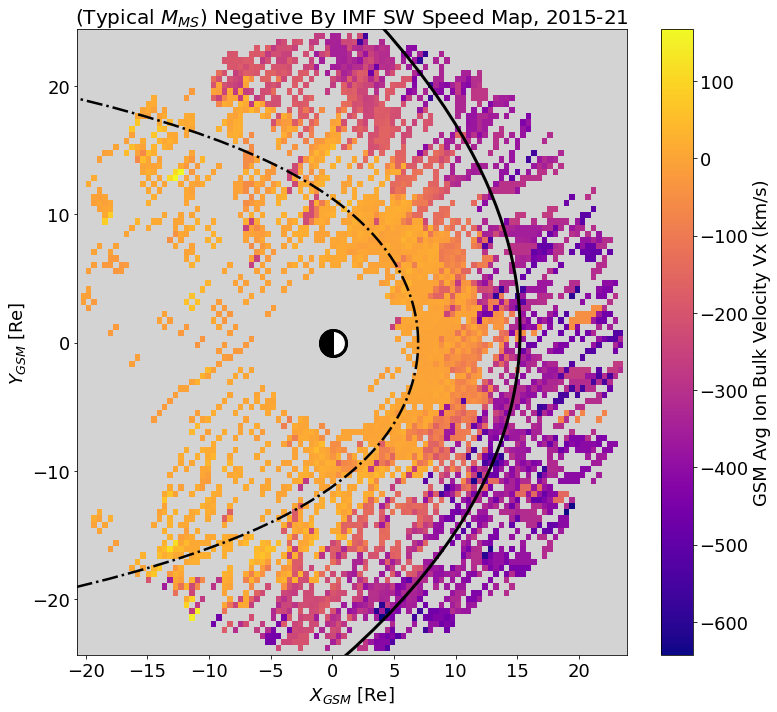

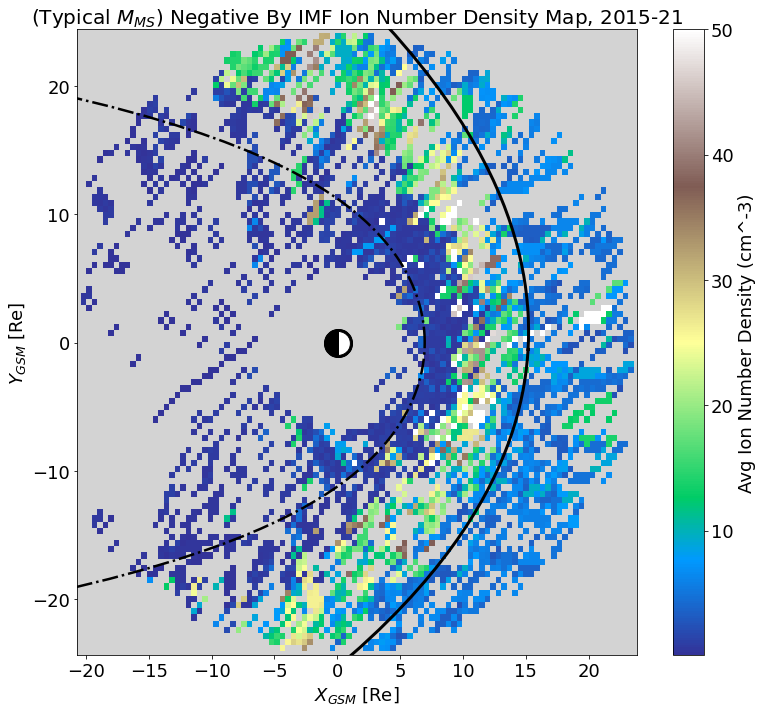

In [34]:
def get_STABmec_params(df_mec):
    """Extract copies of MECpos vectors from Stable IMFnMEC DF as 1D arrays"""
    #Extracting copies of MEC position vectors(measured in Earth Radii)
    MECx = df_mec['x_avg(Re)'].to_numpy(copy=True)
    MECy = df_mec['y_avg(Re)'].to_numpy(copy=True)
    MECz = df_mec['z_avg(Re)'].to_numpy(copy=True)
    MECr = df_mec['Rmag_avg(Re)'].to_numpy(copy=True)
    print('\tAcquired: Stable IMF mec vector data as 1D arrays')
    return(MECx,MECy,MECz,MECr)

def display_ionVxnDenmaps(df_stable_fac, achTitle, achClang, achOpt):
    """With inputted Stable IMFnIonVxnDenMEC DF, display a contour map(pcolormesh) of the ion x-velocity and density values
    which will be manually interpolated onto a 2D grid in the xy-plane. The color bar is based on those respective dataproducts"""
    ##Making PCmesh
    print('\nSW Speed and IonDensity Contour Mapping with: ',namestr(df_stable_fac, globals()), achClang)
    #Extracting 1D arrays of avg mec vector data(measured in uA/m2 and Earth Radii respectively)
    [x,y,z,rmag] = get_STABmec_params(df_stable_fac)
    #Extract copies avg ion x-velocity and density as numpy arrays
    afVx_avg = df_stable_fac['ionVx_gsm_avg(km/s)'].to_numpy(copy=True)
    afDen_avg = df_stable_fac['ionDen_avg(1/cc)'].to_numpy(copy=True)
    # 'Stable Southward Bz IMF\n (J.B)^ Cosine Contour 2015-21'
    #Create 2D meshgrid by defining grid value range from MEC position vectors
    ndps = 100 #define nxn grid
    xi = np.linspace(np.min(x), np.max(x), ndps)
    yi = np.linspace(np.min(y), np.max(y), ndps)
    Xi, Yi = np.meshgrid(xi, yi) #create meshgrid from grid values
    Ei = np.sqrt(Xi**2 + Yi**2) <= 1
    ##Create subplot parameters
    #fig, ax1 = plt.subplots(figsize = (13, 10)) #setting size of subplots
    fig, ax1 = plt.subplots(figsize = (11, 10)) #setting size of subplots; for single plot no legend

    #fig.suptitle(achTitle, y =0.99,fontsize = 20) #single title over multiple subplots
    #setting background plot color
    ax1.set_facecolor('lightgray')
    """For 1x1 Subplots: figsize = (10,10), title size =20, axis label/tick size = 16, legend font = 14"""
    fsize = 18 #fontsize of axis labels/ticks
    legsize = 16 #legend fontsize
    fTheta = np.linspace(0, 2*np.pi, 100)
    #--FAC cosine pcmesh---
    if achOpt == 'vx': #make contour maps of ion-xvelocity
        pLabel1 = '%s IMF\nSW Speed Contour'%(achClang)
        Cbar = cm.plasma
        #Using manual function to interpolate SW speed or ion density data onto a 2D grid//create 2D JDRxy array
        man_JDRxy = get_manual_2Dswd(x,y,xi,yi, afVx_avg)
        achCbar = 'GSM Avg Ion Bulk Velocity Vx (km/s)'
        pcol1 = ax1.pcolormesh(xi,yi, man_JDRxy, vmin = np.min(afVx_avg), vmax = np.max(afVx_avg),shading = 'auto', cmap = Cbar)
        #Draw Magpause and BowShock (in GSM coord)
        draw_magpause(ax1, fTheta, 'black')#'aquamarine')
        [xgsm_bs, ygsm_bs, zgsm_bs] = mitsuo_peredo95_bs_model(fTheta) #plotting bowshock
        ax1.plot(xgsm_bs, ygsm_bs,color = 'black', ls = '-', lw = 3, label = 'Peredo95 Bowshock')
    else: #do contour of ion density     
        pLabel1 = '%s IMF\nIon Density Contour'%(achClang)
        Cbar = cm.terrain
        #Using manual function to interpolate SW speed or ion density data onto a 2D grid//create 2D JDRxy array
        man_JDRxy = get_manual_2Dswd(x,y,xi,yi, afDen_avg)
        achCbar = 'Avg Ion Number Density (cm^-3)'
        #saturate ion density colorbar as densities rarely exceed 50 1/cc
        pcol1 = ax1.pcolormesh(xi,yi, man_JDRxy, vmin = np.min(afDen_avg), vmax = 50,shading = 'auto', cmap = Cbar)
        #Draw Magpause and BowShock (in GSM coord)
        draw_magpause(ax1, fTheta, 'black')#'magenta', 'fuchsia')
        [xgsm_bs, ygsm_bs, zgsm_bs] = mitsuo_peredo95_bs_model(fTheta) #plotting bowshock
        ax1.plot(xgsm_bs, ygsm_bs,color = 'black', ls = '-', lw = 3, label = 'Peredo95 Bowshock')
    ax1.set_title(achTitle, fontsize = 20)
    #draw_earth_center(1.0, ax1, 'right') #plotting Earth as half black-white cirle
    draw_earth2_center(ax1)
    ax1.plot([], [], 'ko', label='Earth') #empty plot label workaround
    #fTheta = np.linspace(0, 2*np.pi, 100)
    #'''
    #--Drawing Shue et al 1998 magnetopause. Also, gotta set axis limits to not show 'entire mp' model
    #[x_mp, y_mp] = shue98_mp_model(fTheta)
    #ax1.plot(x_mp, y_mp, 'c--',lw = 3, label = 'Shue98 Magpause')
    #--Draw Peredo 1995 Bowshock
    #[xgse_bs, ygse_bs, zgse_bs] = mitsuo_peredo95_bs_model(fTheta) #plotting bowshock
    #ax1.plot(xgse_bs, ygse_bs,color = 'fuchsia', ls = '--', lw = 2, label = 'Peredo95 Bowshock')
    ax1.set_xlim([np.min(xi)-0.5, np.max(xi)+0.5])
    ax1.set_ylim([np.min(yi)-0.5, np.max(yi)+0.5])
    #''';
    #--PLotting MMS recorded Rmag limit
    radius = 7
    a = radius * np.cos(fTheta)
    b = radius * np.sin(fTheta)
    #ax1.plot(a, b, '--', color='red')
    ax1.tick_params(axis='both', labelsize=fsize) #setting axes tick labelsize
    ax1.set_ylabel('$Y_{GSM}$ [Re]', fontsize = fsize), ax1.set_xlabel('$X_{GSM}$ [Re]', fontsize = fsize)
    #ax1.legend(title = '%s'%(pLabel1), title_fontsize = fsize, prop={'size': legsize}, bbox_to_anchor=(1.20,1), loc="upper left", shadow = True)
    #ax1.legend(title = '%s'%(pLabel1), title_fontsize = legsize, loc = 'best', prop={'size': legsize}, shadow = True)
    cb1 = plt.colorbar(pcol1, ax = ax1)
    cb1.ax.tick_params(labelsize=fsize)  # change colorbar ticksize
    cb1.ax.set_ylabel('%s'%(achCbar),fontsize=fsize) #change colorbar label fontsize
    plt.tight_layout()
    return;



#-------------Main Below---------------------
#Display Stable soBz SW Speed(Ion Vx) and Ion Density Contour Map on xyplane

#display_ionVxnDenmaps(preMap_ionvxnden_soBzstabDay, 'Stable soBz IMF SW Speed Map 2015-21', 'Southward Bz', 'vx')
#plt.savefig('manual_StableDaysoBz_2DXY_avgIonVxMAP_2015to21_v3', bbox_inches='tight', facecolor = 'w')

#display_ionVxnDenmaps(preMap_ionvxnden_soBzstabDay, 'Stable soBz IMF Ion Density Map 2015-21', 'Southward Bz', 'den')
#plt.savefig('manual_StableDaysoBz_2DXY_avgIonDenMAP_2015to21_v3', bbox_inches='tight', facecolor = 'w')

#display_ionVxnDenmaps(preMap_ionvxnden_norBzstabDay, 'Stable norBz IMF SW Speed Map 2015-21', 'Northward Bz', 'vx')
#plt.savefig('manual_StableDaynorBz_2DXY_avgIonVxMAP_2015to21_v3', bbox_inches='tight', facecolor = 'w')

#display_ionVxnDenmaps(preMap_ionvxnden_norBzstabDay, 'Stable norBz IMF Ion Density Map 2015-21', 'Northward Bz', 'den')
#plt.savefig('manual_StableDaynorBz_2DXY_avgIonDenMAP_2015to21_v3', bbox_inches='tight', facecolor = 'w')

#display_ionVxnDenmaps(preMap_ionvxnden_posBystabDay, 'Stable posBy IMF SW Speed Map 2015-21', 'Positive By', 'vx')
#plt.savefig('manual_StableDayposBy_2DXY_avgIonVxMAP_2015to21_v3', bbox_inches='tight', facecolor = 'w')

#display_ionVxnDenmaps(preMap_ionvxnden_posBystabDay, 'Stable posBy IMF Ion Density Map 2015-21', 'Positive By', 'den')
#plt.savefig('manual_StableDayposBy_2DXY_avgIonDenMAP_2015to21_v3', bbox_inches='tight', facecolor = 'w')

display_ionVxnDenmaps(preMap_ionvxnden_negBystabDay, '(Typical $M_{MS}$) Negative By IMF SW Speed Map, 2015-21', 'Negative By', 'vx')
#plt.savefig('manual_noleg_StableDaynegBy_2DXY_avgIonVxMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')

display_ionVxnDenmaps(preMap_ionvxnden_negBystabDay, '(Typical $M_{MS}$) Negative By IMF Ion Number Density Map, 2015-21', 'Negative By', 'den')
#plt.savefig('manual_noleg_StableDaynegBy_2DXY_avgIonDenMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')
#------

#display_ionVxnDenmaps(preMap_ionvxnden_5MGSsoBzstabDay, '(MGS Mach < 5)Stable soBz IMF SW Speed Map 2015-21', 'Southward Bz', 'vx')
#plt.savefig('manual_StableDay5MGSsoBz_2DXY_avgIonVxMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#display_ionVxnDenmaps(preMap_ionvxnden_5MGSsoBzstabDay, '(MGS Mach < 5)Stable soBz IMF Ion Density Map 2015-21', 'Southward Bz', 'den')
#plt.savefig('manual_StableDay5MGSsoBz_2DXY_avgIonDenMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#display_ionVxnDenmaps(preMap_ionvxnden_5MGSnorBzstabDay, '(MGS Mach < 5)Stable norBz IMF SW Speed Map 2015-21', 'Northward Bz', 'vx')
#plt.savefig('manual_StableDay5MGSsoBz_2DXY_avgIonVxMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#display_ionVxnDenmaps(preMap_ionvxnden_5MGSnorBzstabDay, '(MGS Mach < 5)Stable norBz IMF Ion Density Map 2015-21', 'Northward Bz', 'den')
#plt.savefig('manual_StableDay5MGSsoBz_2DXY_avgIonDenMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#display_ionVxnDenmaps(preMap_ionvxnden_5MGSposBystabDay, '(MGS Mach < 5)Stable posBy IMF SW Speed Map 2015-21', 'Positive By', 'vx')
#plt.savefig('manual_StableDay5MGSsoBz_2DXY_avgIonVxMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#display_ionVxnDenmaps(preMap_ionvxnden_5MGSposBystabDay, '(MGS Mach < 5)Stable posBy IMF Ion Density Map 2015-21', 'Positive By', 'den')
#plt.savefig('manual_StableDay5MGSsoBz_2DXY_avgIonDenMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#display_ionVxnDenmaps(preMap_ionvxnden_5MGSnegBystabDay, '(MGS Mach < 5)Stable negBy IMF SW Speed Map 2015-21', 'Negative By', 'vx')
#plt.savefig('manual_StableDay5MGSsoBz_2DXY_avgIonVxMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#display_ionVxnDenmaps(preMap_ionvxnden_5MGSnegBystabDay, '(MGS Mach < 5)Stable negBy IMF Ion Density Map 2015-21', 'Negative By', 'den')
#plt.savefig('manual_StableDay5MGSsoBz_2DXY_avgIonDenMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')


## Section 6: Displaying Current Direction Trends using Post-Map Jcos and cos_Jr Data
* **Redux** of `Mapping Currents Pt3a_Post Current Map Analysis` where using the post-Jdotr maps Stable IMF DFs, we'll:
    * Display 2D Current Pattern by histogramming Jdotr cosine data for above and below the Y/Z axis
    * Apply the `FPI-Ion Sheath Filter v1` to isolate time intervals that take place just within the magnetosheath and re-histogram the Jdotr cosine data; or display *Just Likely Sheath Hists*
    * Extract |J|cos and $cos_{J2D}$ tplot variables from SheathOnly Stable DFs via a Lowpass filter
        * For smoothed Jmag data(SG Filter) with no nanvals:
            * For each event(10min interval), I compute a percentage value for towards/away from Earth for |J|cos and cos_J2D(>|0.25|) on the xy/xz plane.
            * Collect said percentage values, store them in the CurCos DFs, then histogram it all together(for above/below the Z or Y axis) to see what trend we get for each IMF

---
### Section 6.1: Parsing Post-Jdotr Map Stable IMF DFs through FPI-Ion Sheath Filter v1 to extract 'Likely Just Sheath' time intervals
* FPI Ion Sheath Filter Parameters:
    * Based on the previous cell's results of Birdwatchin. We're **probably** in the sheath if:
     if vx_rms < 311 and den_avg > 21, vx_rmstoavg <= 1.12, and Tperp_avg > 120eV
        * Magsheath $v_{rms,x,ion} < $ 311 km/s
        * Magsheath Average ion density > 21 1/cc
        * X-velocity $v_{rms}/v_{avg} \leq$ 1.12
            * This ratio being >> 1 indicates that we're likley in some boundary traversal
        * Under the Sheath Low Density Regime [10,21) 1/cc:
            * Tperp_avg > 120eV
    * Look back at `Mapping Currents Pt3...` for more details about the Sheath Filter


In [35]:
#export_dfs_easily(df_FPItrim_preMap_negBy_stabDay, 'pdFile_stabDaynegBy_preMap_FPItrim_2015to21_v1.txt')

##stabDay_soBz_currMECB_JfiltnFPItrim_2015to21
##stabDay_soBz_currMECB_SheathFiltv1_2015to21
##Sheath21den_120tperpLD_currMECB

#-----Importing CURL & noFPI Trimmed postMap Stable Day IMF DFs for 2015-21 ------------------------
FPItrim_postMap_soBz_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'Stable IMF_SWD&FAC Data/StableDay_CURLnFPItrim/pdFile_stabDaysoBz_currMECB_2stdprom07_4jmagQSOPnFPItrim_2015to21_v1.txt',sep = '\t')
FPItrim_postMap_norBz_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'Stable IMF_SWD&FAC Data/StableDay_CURLnFPItrim/pdFile_stabDaynorBz_currMECB_2stdprom07_4jmagQSOPnFPItrim_2015to21_v1.txt',sep = '\t')
FPItrim_postMap_posBy_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'Stable IMF_SWD&FAC Data/StableDay_CURLnFPItrim/pdFile_stabDayposBy_currMECB_2stdprom07_4jmagQSOPnFPItrim_2015to21_v1.txt',sep = '\t')
FPItrim_postMap_negBy_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'Stable IMF_SWD&FAC Data/StableDay_CURLnFPItrim/pdFile_stabDaynegBy_currMECB_2stdprom07_4jmagQSOPnFPItrim_2015to21_v1.txt',sep = '\t')

FPItrim_postMap_5MGSsoBz_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay5MGS_CURLnFPItrim/pdFile_stabDay5MGSsoBz_currMECB_2stdprom07_4jmagQSOPnFPItrim_2015to21_v1.txt',sep = '\t')
FPItrim_postMap_5MGSnorBz_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay5MGS_CURLnFPItrim/pdFile_stabDay5MGSnorBz_currMECB_2stdprom07_4jmagQSOPnFPItrim_2015to21_v1.txt',sep = '\t')
FPItrim_postMap_5MGSposBy_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay5MGS_CURLnFPItrim/pdFile_stabDay5MGSposBy_currMECB_2stdprom07_4jmagQSOPnFPItrim_2015to21_v1.txt',sep = '\t')
FPItrim_postMap_5MGSnegBy_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay5MGS_CURLnFPItrim/pdFile_stabDay5MGSnegBy_currMECB_2stdprom07_4jmagQSOPnFPItrim_2015to21_v1.txt',sep = '\t')


#display(FPItrim_postMap_soBz_stabDay)
#display(FPItrim_postMap_norBz_stabDay)
#display(FPItrim_postMap_posBy_stabDay)
#display(FPItrim_postMap_negBy_stabDay)
#display(FPItrim_postMap_5MGSsoBz_stabDay)
display(FPItrim_postMap_5MGSnorBz_stabDay)
display(FPItrim_postMap_5MGSposBy_stabDay)
display(FPItrim_postMap_5MGSnegBy_stabDay)


print('CURLnFPI-trimmed postMap Stable Day soBz trange tuple for 2015-21:')
trangeTRIM_postMapStabDaysoBz = convert_trange_tuple(FPItrim_postMap_soBz_stabDay)
print('---\nCURLnFPI-trimmed postMap Stable Day norBz trange tuple for 2015-21:')
trangeTRIM_postMapStabDaynorBz = convert_trange_tuple(FPItrim_postMap_norBz_stabDay)
print('---\nCURLnFPI-trimmed postMap Stable Day posBy trange tuple for 2015-21:')
trangeTRIM_postMapStabDayposBy = convert_trange_tuple(FPItrim_postMap_posBy_stabDay)
print('---\nCURLnFPI-trimmed postMap Stable Day negBy trange tuple for 2015-21:')
trangeTRIM_postMapStabDaynegBy = convert_trange_tuple(FPItrim_postMap_negBy_stabDay)

print('---\nCURLnFPI-trimmed postMap Stable Day 5MGS Mach soBz trange tuple for 2015-21:')
trangeTRIM_postMap_5MGSStabDaysoBz = convert_trange_tuple(FPItrim_postMap_5MGSsoBz_stabDay)
trangeTRIM_postMap_5MGSStabDaynorBz = convert_trange_tuple(FPItrim_postMap_5MGSnorBz_stabDay)
trangeTRIM_postMap_5MGSStabDayposBy = convert_trange_tuple(FPItrim_postMap_5MGSposBy_stabDay)
trangeTRIM_postMap_5MGSStabDaynegBy = convert_trange_tuple(FPItrim_postMap_5MGSnegBy_stabDay)

,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,gseIMFBx_avg(nT),gseIMFBy_avg(nT),gseIMFBz_avg(nT),...,mms1Bz_avg,mms1Bmag_avg,mms1Bx_med(nT),mms1By_med,mms1Bz_med,mms1Bmag_med,mms1Bx_std(nT),mms1By_std,mms1Bz_std,mms1Bmag_std
0,2015-10-21 13:25:00,2015-10-21 13:35:00,11.745556,8.477973,6.783787,-4.478906,346.319,0.270,-6.618,7.393,...,40.995200,44.956562,16.198833,-7.788599,41.745940,45.219357,2.830432,3.855715,4.242189,4.504444
1,2015-10-25 15:15:00,2015-10-25 15:25:00,10.874713,7.450753,6.899772,-3.890581,329.990,-5.047,-7.838,5.792,...,46.552300,53.331730,10.279459,23.843382,45.743430,53.285046,6.533939,8.981766,4.241956,2.851862
2,2015-10-26 06:20:00,2015-10-26 06:30:00,10.883133,10.130630,3.411431,-2.042858,331.749,-4.062,-4.375,3.318,...,39.083183,42.782032,11.629789,12.574980,39.166428,42.562378,0.985678,2.261738,1.161902,1.382625
3,2015-10-26 06:55:00,2015-10-26 07:05:00,11.167962,10.262615,3.725629,-2.349487,332.012,-3.985,-4.095,3.002,...,36.521780,41.647484,11.329130,16.821598,36.472977,41.834206,1.362122,2.178183,1.101745,1.362127
4,2015-10-26 07:25:00,2015-10-26 07:35:00,11.377185,10.336021,3.976488,-2.606322,338.370,-5.075,-3.200,2.828,...,40.012722,44.448284,14.229735,-0.917542,40.743076,44.467644,2.989717,12.442907,3.081891,1.601797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,2021-05-07 19:10:00,2021-05-07 19:20:00,16.507933,6.695846,-9.879770,-11.404492,25.880,-3.555,2.077,1.922,...,-3.788309,7.232913,-3.579533,2.246995,-3.939377,7.143821,2.789446,3.094352,2.614368,2.179701
185,2021-05-07 20:40:00,2021-05-07 20:50:00,15.121246,6.586092,-7.907537,-11.078935,2.849,-2.252,2.043,3.888,...,14.782428,17.706583,8.249175,-3.203542,14.956856,17.640265,1.641724,3.843973,1.940347,1.597986
186,2021-05-07 21:55:00,2021-05-07 22:05:00,13.861466,6.432508,-6.423327,-10.464289,31.701,-3.330,3.300,2.100,...,10.548629,22.930530,15.309093,13.488148,8.655682,22.602924,2.360263,7.469472,5.811721,1.868163
187,2021-05-07 22:40:00,2021-05-07 22:50:00,13.054209,6.306498,-5.595869,-9.966162,35.958,-3.050,3.808,2.055,...,12.975949,23.079638,16.773396,11.016794,12.758636,24.803360,4.720681,8.177452,2.894976,3.934633


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,gseIMFBx_avg(nT),gseIMFBy_avg(nT),gseIMFBz_avg(nT),...,mms1Bz_avg,mms1Bmag_avg,mms1Bx_med(nT),mms1By_med,mms1Bz_med,mms1Bmag_med,mms1Bx_std(nT),mms1By_std,mms1Bz_std,mms1Bmag_std
0,2015-09-03 18:20:00,2015-09-03 18:30:00,11.819863,0.872488,11.057574,-4.083599,93.281,-7.425,5.858,1.602,...,30.092976,34.646690,13.344337,-0.178723,31.489792,35.967330,5.418075,5.466964,3.886161,4.524604
1,2015-09-04 13:15:00,2015-09-04 13:25:00,11.388485,3.587268,9.319222,-5.475351,103.154,-2.582,8.825,2.552,...,27.591782,38.642944,25.527384,-1.467217,27.835304,41.520912,9.042291,10.827300,3.512512,4.963611
2,2015-09-06 12:55:00,2015-09-06 13:05:00,11.345339,3.964976,9.097562,-5.498035,116.438,-2.043,7.745,0.598,...,17.407242,30.462711,-2.173302,20.811165,21.533161,31.256897,9.352160,8.974854,12.102499,5.625976
3,2015-09-08 12:10:00,2015-09-08 12:20:00,11.120723,4.488951,8.626895,-5.393965,45.916,13.853,3.885,15.222,...,52.300705,67.339195,13.861108,37.461770,53.873623,67.327995,16.250065,18.479996,5.799803,3.954375
4,2015-09-08 12:40:00,2015-09-08 12:50:00,11.333826,4.305125,8.918839,-5.511279,62.535,8.827,9.565,15.845,...,50.846912,67.021020,3.314133,42.835310,51.444810,67.961930,6.123426,5.062710,4.171673,3.450672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,2021-05-28 17:05:00,2021-05-28 17:15:00,18.286256,0.815219,-15.481667,-9.697043,72.946,-1.338,5.197,0.618,...,3.366489,18.769005,14.577621,8.628214,2.609878,19.084248,1.465276,2.993581,4.005185,0.854009
443,2021-05-28 17:35:00,2021-05-28 17:45:00,17.891119,0.978369,-14.805172,-9.996714,66.570,-0.848,5.510,1.162,...,7.071477,19.983765,17.102695,3.501289,6.171143,20.086470,1.252867,1.457278,2.070819,0.583113
444,2021-05-28 18:05:00,2021-05-28 18:15:00,17.484327,1.140972,-14.120308,-10.247427,70.726,-0.928,5.345,0.598,...,11.659204,20.187400,15.649109,0.776797,12.522982,20.288334,1.289845,1.164294,1.764105,0.395709
445,2021-05-28 19:35:00,2021-05-28 19:45:00,16.189265,1.623313,-12.080609,-10.654161,65.619,-3.277,4.952,0.675,...,12.298518,17.250984,3.811876,-11.253926,12.075450,17.267857,0.824885,0.889574,0.395974,0.489954


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,gseIMFBx_avg(nT),gseIMFBy_avg(nT),gseIMFBz_avg(nT),...,mms1Bz_avg,mms1Bmag_avg,mms1Bx_med(nT),mms1By_med,mms1Bz_med,mms1Bmag_med,mms1Bx_std(nT),mms1By_std,mms1Bz_std,mms1Bmag_std
0,2015-09-23 09:10:00,2015-09-23 09:20:00,10.403641,6.896424,6.545389,-4.222670,227.671,7.865,-1.038,-3.775,...,21.626057,39.415764,8.185587,31.268690,23.774384,39.164270,8.898713,5.042337,8.061893,5.388728
1,2015-09-28 13:50:00,2015-09-28 14:00:00,11.996799,6.202364,8.653927,-5.528262,266.503,4.050,-2.772,-1.868,...,23.603617,30.406397,-4.108078,17.583923,23.455600,30.520767,5.006760,1.684079,1.244299,0.786209
2,2015-10-01 15:00:00,2015-10-01 15:10:00,11.867573,5.909205,8.859622,-5.236950,242.070,0.212,-5.662,-8.173,...,-23.384842,36.728157,3.454740,-27.307580,-23.418888,36.286636,2.942378,4.360793,3.218152,4.393741
3,2015-10-01 15:30:00,2015-10-01 15:40:00,11.766318,5.618472,8.995279,-5.095276,243.791,0.688,-6.168,-8.113,...,-30.007885,44.366200,-0.024397,-32.365140,-30.127697,43.718025,2.272343,3.380600,2.845828,3.430641
4,2015-10-17 11:55:00,2015-10-17 12:05:00,12.004703,8.882044,6.583804,-4.676993,266.403,3.707,-5.415,-3.723,...,-11.173844,57.999825,11.600963,-55.522724,-11.688825,59.092003,9.886735,4.189857,7.041702,4.832681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,2021-05-02 04:05:00,2021-05-02 04:15:00,23.746789,-0.411436,-23.332880,-4.394853,232.710,-5.658,-7.732,-2.465,...,-4.119303,9.771664,-6.300686,-6.554882,-4.188723,9.863247,0.856973,0.228856,0.721049,0.405479
435,2021-05-12 15:55:00,2021-05-12 16:05:00,23.471579,-4.630904,-22.961585,-1.492078,289.732,-1.053,-11.635,7.362,...,27.354914,33.907413,-6.479617,-17.142624,27.661245,34.019802,7.092115,4.371240,4.277456,2.856363
436,2021-05-12 16:25:00,2021-05-12 16:35:00,23.707620,-4.551935,-23.161503,-2.206007,308.783,8.835,-7.718,10.025,...,13.911494,29.957432,25.243832,7.124432,14.005433,30.917374,8.323417,7.582330,5.643033,5.084238
437,2021-05-12 17:05:00,2021-05-12 17:15:00,24.011204,-4.444309,-23.380791,-3.180421,299.820,11.507,-8.813,8.938,...,8.151124,33.269530,30.558334,10.454073,8.417305,33.532570,1.313282,2.022250,3.340954,1.158639


CURLnFPI-trimmed postMap Stable Day soBz trange tuple for 2015-21:
<class 'tuple'>
['2015-09-07/18:00:00', '2015-09-07/18:10:00'] ---> ['2021-05-23/04:25:00', '2021-05-23/04:35:00']
632
---
CURLnFPI-trimmed postMap Stable Day norBz trange tuple for 2015-21:
<class 'tuple'>
['2015-09-02/15:30:00', '2015-09-02/15:40:00'] ---> ['2021-05-26/14:15:00', '2021-05-26/14:25:00']
430
---
CURLnFPI-trimmed postMap Stable Day posBy trange tuple for 2015-21:
<class 'tuple'>
['2015-09-03/15:25:00', '2015-09-03/15:35:00'] ---> ['2021-05-28/17:50:00', '2021-05-28/18:00:00']
1128
---
CURLnFPI-trimmed postMap Stable Day negBy trange tuple for 2015-21:
<class 'tuple'>
['2015-09-02/13:45:00', '2015-09-02/13:55:00'] ---> ['2021-05-25/12:55:00', '2021-05-25/13:05:00']
1191
---
CURLnFPI-trimmed postMap Stable Day 5MGS Mach soBz trange tuple for 2015-21:
<class 'tuple'>
['2015-09-06/12:25:00', '2015-09-06/12:35:00'] ---> ['2021-05-18/03:00:00', '2021-05-18/03:10:00']
241
<class 'tuple'>
['2015-10-21/13:25:00',

In [36]:
def getFPI_iondata(achDate):
    """Using inputted trange, Load up FPI ion survey data"""
    pytplot.del_data() #deleting previously loaded tplot variables
    print('\nInput date was: %s '%(achDate))
        #Loading FPI ion data; has no gsm coord data
    ion_vars = fpi(datatype='dis-moms',trange=achDate,center_measurement=True,data_rate = 'fast',time_clip=True)
    return;

def get_vxndensity():
    """Extract/compute trange average of the FPI ion Vx and density"""
    """Recll from Eric: xcomp = data_vec[:,0], ycomp = data_vec[:,1], zcomp = data_comp[:,2]"""
    #curlb_mag = np.sqrt(curlb_vec[:,0]**2 + curlb_vec[:,1]**2 + curlb_vec[:,2]**2)
    #Extracting ion velocity and density tplot vars
    vel_time, ion_vel_vec = get_data('mms1_dis_bulkv_gse_fast')
    den_time, den_vals = get_data('mms1_dis_numberdensity_fast')
    tperp_time, tperp_vals = get_data('mms1_dis_tempperp_fast')
    vx_vals = ion_vel_vec[:,0] #extracting ion x-velocity array
    #Compute vx mean and rms
    rms = np.sqrt(np.nanmean(vx_vals**2))
    rms_den = np.sqrt(np.nanmean(den_vals**2))
    rms_tperp = np.sqrt(np.nanmean(tperp_vals**2))
    vx_rmstoavg = np.abs(rms/np.nanmean(vx_vals))
    print('Ion x-velocity"s avg, median, std, rms, and rms/avg:\n [%0.3f, %0.3f, %0.3f, %0.3f]km/s, %0.3f'
          %(np.nanmean(vx_vals), np.nanmedian(vx_vals), np.nanstd(vx_vals), rms, vx_rmstoavg))
    print('Ion density avg, median, std, and rms:\n [%0.3f, %0.3f, %0.3f, %0.3f] 1/cc'
          %(np.nanmean(den_vals), np.nanmedian(den_vals), np.nanstd(den_vals), rms_den) )
    print('Ion Tperp(green) avg, median, std, and rms:\n [%0.3f, %0.3f, %0.3f, %0.3f] eV'
          %(np.nanmean(tperp_vals), np.nanmedian(tperp_vals), np.nanstd(tperp_vals), rms_tperp) )
    return(rms, vx_rmstoavg, np.nanmean(den_vals), np.nanmean(tperp_vals));


def bSheathCheck():
    """Extracts FPI ion x-velocity and density. Then uses said rms and avg values to determine if we're in the sheath"""
    bCleanSheath = True #initialize boolean variable as True
    #extract average tplot variables: ion x-velocity, ion density, and ion Tperp
    [vx_rms, vx_rmstoavg, den_avg, tperp_avg] = get_vxndensity()
    #Uses x-velocity and ion density to determine if we're in the sheath
    if vx_rms < 311 and den_avg > 21 and vx_rmstoavg <= 1.12:
        print('-->We are likely in a Sheath Zone')
    elif vx_rms < 311 and (den_avg >=10 and den_avg < 21) and vx_rmstoavg <= 1.12 and tperp_avg > 120:
        print('-->We are likely in a Low-Density Sheath Zone')
    else: #we're not in the sheath
        print('-->This is not the Magsheath')
        bCleanSheath = False
    return(bCleanSheath)
        
def SheathOnly_FPIdatatrim(Date, df_data):
    """With inputted trange tuples,loads up FPI Ion-Data and trims time intervals that don't abide 
    by the 'Clean Sheath' Filter"""
    print('\nSheath-trimming data with: ',namestr(Date, globals()), namestr(df_data, globals()))
    droplist = []  #initialized empty array
    start = time.perf_counter()
    for i in range(len(Date)): #Loading FPI iondata; has no gsm coord data
        load_FPI_iondata(Date[i])
        bSheath = bSheathCheck() #Returns boolean to check if we're in the sheath
        #bError = error_ion_tp_test() #combine certain tplot variables and return boolean if there's an error
        #print(bSheath)
        if bSheath == False: #add to index to Drop-Array if Sheath Filter didn't pass
            droplist = np.append(droplist,i) #add error element-index to array
    anDrop = [int(item) for item in droplist] #ensure droplist elements are integers
    end = time.perf_counter()
    #Based on droplist, either omit NonSheath rows or leave alone inputted CurCos DF
    df_curcop = df_data.copy(deep = True) 
    if len(anDrop) > 0:
        #Display DropList Index and time intervals which wasn't within the Sheath
        print('DropList index:', anDrop)
        for i in range(len(anDrop)):
            print(Date[(anDrop[i])])  
            # displays Drop tuple element index with index recorded by drop list
            # int(droplist[i]) ensures input into Date is an integer to avoid error
        #Omit NonSheath Data rows
        print('\nOmitting NonSheath rows')
        df_curcop = df_curcop.drop(anDrop)
        #Reset index# column for new DF
        df_curcop = df_curcop.reset_index(drop=True) 
        display(df_data)
        display(df_curcop)
    else:
        print('No data errors detected for any tranges this dataframe')
    print('\nTotal time to load %d 10min intervals of FPI ion-data: %0.2fsec or %0.2fmin'%(len(Date), end-start, (end-start)/60))
    return(df_curcop);


#-----------Main Calling Below----------

#df_Sheath_postMap_stabDaysoBz = SheathOnly_FPIdatatrim(trangeTRIM_postMapStabDaysoBz,FPItrim_postMap_soBz_stabDay)
#df_Sheath_postMap_stabDaynorBz = SheathOnly_FPIdatatrim(trangeTRIM_postMapStabDaynorBz,FPItrim_postMap_norBz_stabDay)
#df_Sheath_postMap_stabDayposBy = SheathOnly_FPIdatatrim(trangeTRIM_postMapStabDayposBy,FPItrim_postMap_posBy_stabDay)
#df_Sheath_postMap_stabDaynegBy = SheathOnly_FPIdatatrim(trangeTRIM_postMapStabDaynegBy,FPItrim_postMap_negBy_stabDay)

#df_Sheath_postMap_5MGSstabDaysoBz = SheathOnly_FPIdatatrim(trangeTRIM_postMap_5MGSStabDaysoBz, FPItrim_postMap_5MGSsoBz_stabDay)
#df_Sheath_postMap_5MGSstabDaynorBz = SheathOnly_FPIdatatrim(trangeTRIM_postMap_5MGSStabDaynorBz, FPItrim_postMap_5MGSnorBz_stabDay)
#df_Sheath_postMap_5MGSstabDayposBy = SheathOnly_FPIdatatrim(trangeTRIM_postMap_5MGSStabDayposBy, FPItrim_postMap_5MGSposBy_stabDay)
#df_Sheath_postMap_5MGSstabDaynegBy = SheathOnly_FPIdatatrim(trangeTRIM_postMap_5MGSStabDaynegBy, FPItrim_postMap_5MGSnegBy_stabDay)

#### Export/Import noFPI-JustSheath Trimmed CurCos2D DFs and display the 'Likely JustSheath' Hists

In [37]:
#'''
##stabDay_soBz_currMECB_JfiltnFPItrim_2015to21
##stabDay_soBz_currMECB_SheathFiltv1_2015to21
##Sheath21den_120tperpLD_currMECB


#-----Exporting 2015-21 PostMAP Stable Day IMF noFPI/Sheath Trimmed CurrCosXY DFs------------------------
#export_dfs_easily(df_Sheath_postMap_stabDaysoBz, 'pdFile_stabDaysoBz_CURLnFPItrim_Sheath21den120tperpLD_2015to21_v1.txt')
#export_dfs_easily(df_Sheath_postMap_stabDaynorBz, 'pdFile_stabDaynorBz_CURLnFPItrim_Sheath21den120tperpLD_2015to21_v1.txt')
#export_dfs_easily(df_Sheath_postMap_stabDayposBy, 'pdFile_stabDayposBy_CURLnFPItrim_Sheath21den120tperpLD_2015to21_v1.txt')
#export_dfs_easily(df_Sheath_postMap_stabDaynegBy, 'pdFile_stabDaynegBy_CURLnFPItrim_Sheath21den120tperpLD_2015to21_v1.txt')

#export_dfs_easily(df_Sheath_postMap_5MGSstabDaysoBz, 'pdFile_5MGSstabDaysoBz_CURLnFPItrim_Sheath21den120tperpLD_2015to21_v1.txt')
#export_dfs_easily(df_Sheath_postMap_5MGSstabDaynorBz, 'pdFile_5MGSstabDaynorBz_CURLnFPItrim_Sheath21den120tperpLD_2015to21_v1.txt')
#export_dfs_easily(df_Sheath_postMap_5MGSstabDayposBy, 'pdFile_5MGSstabDayposBy_CURLnFPItrim_Sheath21den120tperpLD_2015to21_v1.txt')
#export_dfs_easily(df_Sheath_postMap_5MGSstabDaynegBy, 'pdFile_5MGSstabDaynegBy_CURLnFPItrim_Sheath21den120tperpLD_2015to21_v1.txt')

#-----Importing CURL & noFPI Trimmed postMap Stable Day IMF DFs for 2015-21 ------------------------
Sheathtrim_postMap_soBz_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'Stable IMF_SWD&FAC Data/StableDay_postMap_SheathFiltv1/pdFile_stabDaysoBz_CURLnFPItrim_Sheath21den120tperpLD_2015to21_v1.txt',sep = '\t')
Sheathtrim_postMap_norBz_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'Stable IMF_SWD&FAC Data/StableDay_postMap_SheathFiltv1/pdFile_stabDaynorBz_CURLnFPItrim_Sheath21den120tperpLD_2015to21_v1.txt',sep = '\t')
Sheathtrim_postMap_posBy_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'Stable IMF_SWD&FAC Data/StableDay_postMap_SheathFiltv1/pdFile_stabDayposBy_CURLnFPItrim_Sheath21den120tperpLD_2015to21_v1.txt',sep = '\t')
Sheathtrim_postMap_negBy_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'Stable IMF_SWD&FAC Data/StableDay_postMap_SheathFiltv1/pdFile_stabDaynegBy_CURLnFPItrim_Sheath21den120tperpLD_2015to21_v1.txt',sep = '\t')

Sheathtrim_postMap_5MGSsoBz_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'StableDay_LowMGSMach/StableDay_5MGS_postMap_SheathFiltv1/pdFile_5MGSstabDaysoBz_CURLnFPItrim_Sheath21den120tperpLD_2015to21_v1.txt',sep = '\t')
Sheathtrim_postMap_5MGSnorBz_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'StableDay_LowMGSMach/StableDay_5MGS_postMap_SheathFiltv1/pdFile_5MGSstabDaynorBz_CURLnFPItrim_Sheath21den120tperpLD_2015to21_v1.txt',sep = '\t')
Sheathtrim_postMap_5MGSposBy_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'StableDay_LowMGSMach/StableDay_5MGS_postMap_SheathFiltv1/pdFile_5MGSstabDayposBy_CURLnFPItrim_Sheath21den120tperpLD_2015to21_v1.txt',sep = '\t')
Sheathtrim_postMap_5MGSnegBy_stabDay = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
    'StableDay_LowMGSMach/StableDay_5MGS_postMap_SheathFiltv1/pdFile_5MGSstabDaynegBy_CURLnFPItrim_Sheath21den120tperpLD_2015to21_v1.txt',sep = '\t')

#display(Sheathtrim_postMap_soBz_stabDay)
#display(Sheathtrim_postMap_norBz_stabDay)
#display(Sheathtrim_postMap_posBy_stabDay)
#display(Sheathtrim_postMap_negBy_stabDay)

#display(Sheathtrim_postMap_5MGSsoBz_stabDay)
#display(Sheathtrim_postMap_5MGSnorBz_stabDay)
#display(Sheathtrim_postMap_5MGSposBy_stabDay)
#display(Sheathtrim_postMap_5MGSnegBy_stabDay)


print('Sheath-trimmed postMap Stable Day soBz trange tuple for 2015-21:')
trangeSheathTRIM_StabDaysoBz = convert_trange_tuple(Sheathtrim_postMap_soBz_stabDay)
print('---\nSheath-trimmed postMap Stable Day norBz trange tuple for 2015-21:')
trangeSheathTRIM_StabDaynorBz = convert_trange_tuple(Sheathtrim_postMap_norBz_stabDay)
print('---\nSheath-trimmed postMap Stable Day posBy trange tuple for 2015-21:')
trangeSheathTRIM_StabDayposBy = convert_trange_tuple(Sheathtrim_postMap_posBy_stabDay)
print('---\nSheath-trimmed postMap Stable Day negBy trange tuple for 2015-21:')
trangeSheathTRIM_StabDaynegBy = convert_trange_tuple(Sheathtrim_postMap_negBy_stabDay)

print('---\nSheath-trimmed postMap (5MGS Mach)Stable Day soBz trange tuple for 2015-21:')
trangeSheathTRIM_5MGS_StabDaysoBz = convert_trange_tuple(Sheathtrim_postMap_5MGSsoBz_stabDay)
trangeSheathTRIM_5MGS_StabDaynorBz = convert_trange_tuple(Sheathtrim_postMap_5MGSnorBz_stabDay)
trangeSheathTRIM_5MGS_StabDayposBy = convert_trange_tuple(Sheathtrim_postMap_5MGSposBy_stabDay)
trangeSheathTRIM_5MGS_StabDaynegBy = convert_trange_tuple(Sheathtrim_postMap_5MGSnegBy_stabDay)

Sheath-trimmed postMap Stable Day soBz trange tuple for 2015-21:
<class 'tuple'>
['2015-09-07/18:00:00', '2015-09-07/18:10:00'] ---> ['2021-04-13/11:45:00', '2021-04-13/11:55:00']
340
---
Sheath-trimmed postMap Stable Day norBz trange tuple for 2015-21:
<class 'tuple'>
['2015-09-23/12:50:00', '2015-09-23/13:00:00'] ---> ['2021-05-26/14:15:00', '2021-05-26/14:25:00']
211
---
Sheath-trimmed postMap Stable Day posBy trange tuple for 2015-21:
<class 'tuple'>
['2015-09-03/16:20:00', '2015-09-03/16:30:00'] ---> ['2021-05-07/16:15:00', '2021-05-07/16:25:00']
596
---
Sheath-trimmed postMap Stable Day negBy trange tuple for 2015-21:
<class 'tuple'>
['2015-09-10/13:15:00', '2015-09-10/13:25:00'] ---> ['2021-05-25/09:15:00', '2021-05-25/09:25:00']
588
---
Sheath-trimmed postMap (5MGS Mach)Stable Day soBz trange tuple for 2015-21:
<class 'tuple'>
['2015-09-07/15:20:00', '2015-09-07/15:30:00'] ---> ['2021-05-18/03:00:00', '2021-05-18/03:10:00']
127
<class 'tuple'>
['2015-10-21/13:25:00', '2015-10-2

### Section 6.2: Extracting Birdwatchin Tplot Variables(including Jcos and $cos_{J2D}$) from Stable IMF SheathOnly DFs via a Lowpass Filter
* Collecting Jcos and cos_j2D tplot variables by passing current time series through a lowpass filter
   * Rick, 'Tuburlence filter: Low pass filter means you only allow low frequency fluctuations. But it would probably remove the peaks. Which might be worth seeing if the peaks are due to waves or turbulence. Yeah - it is probably going to be a separate aspect of the investigation. Since its looking for the slower variations in J
* (5-28-2022) After doing some tests witih different lowpass filters in `Bird Watchin 2`. I've decided that smoothing our Jmag time series via a Savitzky-Golay Lowpass filter is the way to go
   * As confirmed in `Bird Watchin 2`, I can store the jmag time series with no nanvalues as a tplot variable
       * This'll make the SG-filtering easy since applying the SG-Filter to the jmag data with and without nanvalues yields the same output. Also I can remove jmag's nanvalues from the time, position, and current comp arrays to make the jdotrcosine algorithm work
   * For smoothed Jmag data with no nanvals:
       * For each event(10min interval), I compute a percentage value for towards/away from Earth for |J|cos and cos_J2D(>|0.25|) on the xy/xz plane.
           * **Collect** said percentage values, store them in the CurCos DFs, then histogram it all together(for above/below the Z or Y axis) to see what trend we get for each IMF
* As such the below cell shall load up FGM Bfield and MEC positional data to compute CURL parameters. Extract current magnitude data, apply the SG-filter, and use that info to get the cosine data that corresponds to the smoothed data. From which we'll use those arrays to compute the percentage towards/away (pos/neg |J|cos) values.
* **Sovitzky-Golay interesting details and links**:
    * setting my window size to 3.5% of data length(10min of curl data yields about 10k dtps) with a 3rd order polynomial, I get a nice smoothed curve.
        * Also using 3.5% as this smooths enough of the data while retaining much of the curve's characteristics
    * scipi documentation def: https://scipy-cookbook.readthedocs.io/items/SavitzkyGolay.html
    * Smoothing a curve using SG-Filter: https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way


In [38]:
def do_SG_filter(afData):
    """Pass/return inputted data through a Sovitzky-Golay lowpass filter where we use a 3rd degree polynomial 
    and make the window length 1% of the data length"""
    winlen = np.round(len(afData)*0.035) #make window length 3.5% of afData length
    if winlen%2 == 0:
        winlen = winlen+1 #make window length odd; needs to be odd for SG function
    print('\tSG Filter window length = ',int(winlen))
    sg_order = 3 #polynomial order
    y_sg = savgol_filter(afData, int(winlen), sg_order)
    #sg_std = np.nanstd(y_sg)
    print('\tLength of SG-Filt array:', len(y_sg))
    #ax1.plot(y_sg, 'm-',lw = 4, label = ' %drd degree SG Filter: %0.3f std'%(sg_order, sg_std))
    return(y_sg);

def get_FILTjdotrcosine_vars(mms1_fgm_bgsm_time):
    """Create tplot variables (Jcos)_2D and cos_J2D. By extracting curlB(in current units)
    and MECposition data(in Re)"""
    #defining constants from the NRL Plasma Foundry
    R_e = 6371 #km, Earth radius; as indicated by NRL Plasma Formularly
    mu0 = 4e-7*np.pi #H/m == Tm/A, permeability of free space
        #mu0*J == [Tm/A *A/m2] == [T/m] == curlB
            #1km = 1000m and 1nT = 1e-9T
        #mu0[Tm/A]*(1km/1000m)*(1nT/1e-9T) == mu0(nT*km/A)*1e+6
    mu0_nT_km = mu0*1e+6 #nT*km/A
    #Extracting curlB(unit = nT/km) data to create |curlB|/mu0(unit = A/km2 or uA/m2) tplot vars
    curlb_time, curlb_vec = get_data('curlB')
        #print('\n', type(curlb_vec))
        #print('curlB shape:', np.shape(curlb_vec)) # or curlb_vec.shape)
        #curlb_mag = np.sqrt(curlb_vec[:,0]**2 + curlb_vec[:,1]**2 + curlb_vec[:,2]**2) #defining |curlB|
    #defining current vector components in uA/m2
    jx_val = curlb_vec[:,0]/mu0_nT_km
    jy_val = curlb_vec[:,1]/mu0_nT_km
    jz_val = curlb_vec[:,2]/mu0_nT_km
    jmag_val = np.sqrt(jx_val**2 + jy_val**2 +jz_val**2) #define |curlB|/mu0
    """Recall that curlometer already interpolates MEC position data to compute CURL params. So just pull
    MEC data from 'mms1_mec_r_gsm_i'"""
    #Extract MEC vector position array(unit = km) and define components in (unit = Re)
    pos_time, rpos = get_data('mms1_mec_r_gsm_i')
    X_re = rpos[:,0]/R_e
    Y_re = rpos[:,1]/R_e
    Z_re = rpos[:,2]/R_e
    Rmag_re = np.sqrt(X_re**2 + Y_re**2 + Z_re**2) #rpos_mag = np.sqrt(rpos[:,0]**2 + rpos[:,1]**2 + rpos[:,2]**2)
        #print('Time array lengths:', len(curlb_time), len(pos_time), len(mms1_fgm_bgsm_time)) #they match
    #define postion, current, and time arrays that omits jmag's nanvalues
    afJmag = jmag_val[~np.isnan(jmag_val)] 
    afJx = jx_val[~np.isnan(jmag_val)] 
    afJy = jy_val[~np.isnan(jmag_val)] 
    afJz = jz_val[~np.isnan(jmag_val)] 
    afX = X_re[~np.isnan(jmag_val)] 
    afY = Y_re[~np.isnan(jmag_val)] 
    afZ = Z_re[~np.isnan(jmag_val)] 
    afRmag = Rmag_re[~np.isnan(jmag_val)] 
    #afTime = curlb_time[~np.isnan(jmag_val)]
    #print('Nonan Time-Curr-Pos array lengths:', len(afJx), len(afX), len(afTime))
    #Put Nonan current vector data through a Savitky-Golay Lowpass filter 
    jmag_SG = do_SG_filter(afJmag)
    jx_SG = do_SG_filter(afJx)
    jy_SG = do_SG_filter(afJy)
    jz_SG = do_SG_filter(afJz)
    #Define (SG-Filtered)|J|cosine and (J.r)^ angles on GSM xy/xz plane and full xyz-coord system.
        #def return_jcosine(jx,jy,jz,x,y,z,rmag):
        #def return_jdotr_cosine(jx,jy,jz,x,y,z,jmag,rmag): 
    [jcos_xy, jcos_xz, jcos_xyz] = return_jcosine(jx_SG,jy_SG,jz_SG,afX,afY,afZ,afRmag)
    [cos_xy, cos_xz, cos_xyz] = return_adotb_cosine(jx_SG,jy_SG,jz_SG,afX,afY,afZ,jmag_SG,afRmag)
    return[jcos_xy, jcos_xz, cos_xy, cos_xz];

def get_filtCURLcospercents(trange):
    """Load up CURL params and extract |J|cos and cos_J2D angles(that correspond to SG-filtered Jmag) 
    percent values for towards/away from Earth"""
    pytplot.del_data()
    #Load up FPI-ion, FGM, MEC, and CURL parameters
    FGM_time = get_CURLdata(trange)
    curl_gsm_params()
    #create/extract |J|cos and (J.r)^ 2D cosine angles that correspond to SG-filtered jmag data
    [jcos_xy, jcos_xz, cos_xy, cos_xz] = get_FILTjdotrcosine_vars(FGM_time) 
    #Extract percentage of (|j|cos)_xy Filt events that are positive and negative
    jcosxy_pos = 100* len(jcos_xy[jcos_xy >= 0])/len(jcos_xy)
    jcosxy_neg = 100* len(jcos_xy[jcos_xy < 0])/len(jcos_xy)
    jcosxy_avg = np.nanmean(jcos_xy)
    jcosxy_med = np.nanmedian(jcos_xy)
    cosxy_pos = 100* len(cos_xy[cos_xy >= 0.25])/len(cos_xy) 
    cosxy_neg = 100* len(cos_xy[cos_xy < -0.25])/len(cos_xy) 
    #Extract percentage of (|j|cos)_xz Filt events that are positive and negative
    jcosxz_pos = 100* len(jcos_xz[jcos_xz >= 0])/len(jcos_xz)
    jcosxz_neg = 100* len(jcos_xz[jcos_xz < 0])/len(jcos_xz)
    jcosxz_avg = np.nanmean(jcos_xz)
    jcosxz_med = np.nanmedian(jcos_xz)
    cosxz_pos = 100* len(cos_xz[cos_xz >= 0.25])/len(cos_xz) 
    cosxz_neg = 100* len(cos_xz[cos_xz < -0.25])/len(cos_xz)
    #defining row vector for jcos and cos_j2D percents
    cosperc_vec = [jcosxy_pos, jcosxy_neg, jcosxy_avg, jcosxy_med, cosxy_pos, cosxy_neg,
                   jcosxz_pos, jcosxz_neg, jcosxz_avg, jcosxz_med, cosxz_pos, cosxz_neg]
    '''
    print('(Jcos)_xy: %0.1f%%(pos), %0.1f%%(neg),\n%0.3f avg, %0.3f med'%(jcosxy_pos, jcosxy_neg, jcosxy_avg, jcosxy_med) )
    print('(Jcos)_xz: %0.1f%%(pos), %0.1f%%(neg),\n%0.3f avg, %0.3f med'%(jcosxz_pos, jcosxz_neg, jcosxz_avg, jcosxz_med) )
    
    print('cosxy Filt(0.25): %0.1f%%(pos), %0.1f%%(neg)'%(cosxy_pos, cosxy_neg))
    print('cosxz Filt(0.25): %0.1f%%(pos), %0.1f%%(neg)'%(cosxz_pos, cosxz_neg))
    ''';
    return(cosperc_vec);

def add_SGcospercent_DF(Date, df_sheath):
    """Loads up MEC/FGM Plasma Data to compute CURL parameters. Computes |J|cos and cos_J2D arrays for 
    correspondingvSG-Filtered Jmag data. Computes/records percentage values into Sheath CurCos DFs for 
    towards/away from Earth"""
    print('\nSG Filting CURL params with: ',namestr(Date, globals()), namestr(df_sheath, globals()))
    start = time.perf_counter()
    #creating empty dataframe with column names and defined index length as # of date intervals
    df_cospercs = pd.DataFrame(columns = ['Jcosxy_pos(%)','Jcosxy_neg(%)','Jcosxy_avg','Jcosxy_med',
           'cosxy_pos(0.25,%)','cosxy_neg(0.25,%)', 'Jcosxz_pos(%)', 'Jcosxz_neg(%)', 'Jcosxz_avg', 
           'Jcosxz_med', 'cosxz_pos(0.25,%)', 'cosxz_neg(0.25,%)'], index = np.arange(len(Date)) )
       #[jcosxy_pos, jcosxy_neg, jcosxy_avg, jcosxy_med, cosxy_pos, cosxy_neg,
       #jcosxz_pos, jcosxz_neg, jcosxz_avg, jcosxz_med, cosxz_pos, cosxz_neg]
    df_cop = df_sheath.copy(deep = True) #Making copy of Sheath DF
    for i in range(len(Date)):
        #-Extracting J.r cosine percent data from trange and adding to DF row-index
        cosperc_vec = get_filtCURLcospercents(Date[i])
        df_cospercs.iloc[i] = cosperc_vec
    end = time.perf_counter()
    fSum = end-start
    #Adding (jmag peak corresponding) |J|cos and cos_j2D percentage column arrays to Sheath DF copy
    if len(df_cospercs) == len(df_cop): #check if both DFs are the same length
        print('\tAppending jcos and cos2D percent column arrays to Sheath DF')
        df_merge = pd.concat([df_cop, df_cospercs], axis=1) #merge dataframes along horizontal(column) axis
        display(df_merge[:3])
        display(df_cospercs[:3])
    else:
        df_merge = df_cop
        display(df_cospercs[:3])
        print('\tPercent column arrays too short in length. Unable to append to full Sheath DF')
    print('\nTotal time to load/plot %d 10min intervals of FGM/CURL data: %0.2fsec or %0.2fmin'%(len(Date), fSum, fSum/60))
    return(df_merge);
#-------------Main Below------------------
                            
#Sheath_stabsoBz_jcospercSG = add_SGcospercent_DF(trangeSheathTRIM_StabDaysoBz, Sheathtrim_postMap_soBz_stabDay)
#Sheath_stabnorBz_jcospercSG = add_SGcospercent_DF(trangeSheathTRIM_StabDaynorBz, Sheathtrim_postMap_norBz_stabDay)
#Sheath_stabposBy_jcospercSG = add_SGcospercent_DF(trangeSheathTRIM_StabDayposBy, Sheathtrim_postMap_posBy_stabDay)
#Sheath_stabnegBy_jcospercSG = add_SGcospercent_DF(trangeSheathTRIM_StabDaynegBy, Sheathtrim_postMap_negBy_stabDay)

#Sheath_5MGSstabsoBz_jcospercSG = add_SGcospercent_DF(trangeSheathTRIM_5MGS_StabDaysoBz, Sheathtrim_postMap_5MGSsoBz_stabDay)
#Sheath_5MGSstabnorBz_jcospercSG = add_SGcospercent_DF(trangeSheathTRIM_5MGS_StabDaynorBz, Sheathtrim_postMap_5MGSnorBz_stabDay)
#Sheath_5MGSstabposBy_jcospercSG = add_SGcospercent_DF(trangeSheathTRIM_5MGS_StabDayposBy, Sheathtrim_postMap_5MGSposBy_stabDay)
#Sheath_5MGSstabnegBy_jcospercSG = add_SGcospercent_DF(trangeSheathTRIM_5MGS_StabDaynegBy, Sheathtrim_postMap_5MGSnegBy_stabDay)

#### Export/Import SG-Filtered JustSheath Stable Day Post Map withJcospercent DFs and display the 'Jcos and cos2D Percent' Hists

In [39]:
#-----Exporting 2015-21 PostMAP Sheath Stable Day IMF with jcos and cos2D percents CurrCos2D DFs------------------------
#export_dfs_easily(Sheath_stabsoBz_jcospercSG, 'pdFile_stabDaysoBz_Sheath21den120tperpLD_CosJrperc_3rdSGFiltwin3p5perc_2015to21_v1.txt')
#export_dfs_easily(Sheath_stabnorBz_jcospercSG, 'pdFile_stabDaynorBz_Sheath21den120tperpLD_CosJrperc_3rdSGFiltwin3p5perc_2015to21_v1.txt')
#export_dfs_easily(Sheath_stabposBy_jcospercSG, 'pdFile_stabDayposBy_Sheath21den120tperpLD_CosJrperc_3rdSGFiltwin3p5perc_2015to21_v1.txt')
#export_dfs_easily(Sheath_stabnegBy_jcospercSG, 'pdFile_stabDaynegBy_Sheath21den120tperpLD_CosJrperc_3rdSGFiltwin3p5perc_2015to21_v1.txt')

#export_dfs_easily(Sheath_5MGSstabsoBz_jcospercSG, 'pdFile_5MGSstabDaysoBz_Sheath21den120tperpLD_CosJrperc_3rdSGFiltwin3p5perc_2015to21_v1.txt')
#export_dfs_easily(Sheath_5MGSstabnorBz_jcospercSG, 'pdFile_5MGSstabDaynorBz_Sheath21den120tperpLD_CosJrperc_3rdSGFiltwin3p5perc_2015to21_v1.txt')
#export_dfs_easily(Sheath_5MGSstabposBy_jcospercSG, 'pdFile_5MGSstabDayposBy_Sheath21den120tperpLD_CosJrperc_3rdSGFiltwin3p5perc_2015to21_v1.txt')
#export_dfs_easily(Sheath_5MGSstabnegBy_jcospercSG, 'pdFile_5MGSstabDaynegBy_Sheath21den120tperpLD_CosJrperc_3rdSGFiltwin3p5perc_2015to21_v1.txt')


#-----Importing Yrs1-5 All Dayside IMFs Sheath CurrCos_withjcospercents DFs with ------------------------
Sheath_stabDaysoBz_jcospercent = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StabDay_postMapSheath_CurCosPercs/pdFile_stabDaysoBz_Sheath21den120tperpLD_CosJrperc_3rdSGFiltwin3p5perc_2015to21_v1.txt',sep = '\t')
Sheath_stabDaynorBz_jcospercent = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StabDay_postMapSheath_CurCosPercs/pdFile_stabDaynorBz_Sheath21den120tperpLD_CosJrperc_3rdSGFiltwin3p5perc_2015to21_v1.txt',sep = '\t')
Sheath_stabDayposBy_jcospercent = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StabDay_postMapSheath_CurCosPercs/pdFile_stabDayposBy_Sheath21den120tperpLD_CosJrperc_3rdSGFiltwin3p5perc_2015to21_v1.txt',sep = '\t')
Sheath_stabDaynegBy_jcospercent = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Stable IMF_SWD&FAC Data/StabDay_postMapSheath_CurCosPercs/pdFile_stabDaynegBy_Sheath21den120tperpLD_CosJrperc_3rdSGFiltwin3p5perc_2015to21_v1.txt',sep = '\t')

Sheath_5MGSstabDaysoBz_jcospercent = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay5MGS_postMapSheath_CurCosPercs/pdFile_5MGSstabDaysoBz_Sheath21den120tperpLD_CosJrperc_3rdSGFiltwin3p5perc_2015to21_v1.txt',sep = '\t')
Sheath_5MGSstabDaynorBz_jcospercent = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay5MGS_postMapSheath_CurCosPercs/pdFile_5MGSstabDaynorBz_Sheath21den120tperpLD_CosJrperc_3rdSGFiltwin3p5perc_2015to21_v1.txt',sep = '\t')
Sheath_5MGSstabDayposBy_jcospercent = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay5MGS_postMapSheath_CurCosPercs/pdFile_5MGSstabDayposBy_Sheath21den120tperpLD_CosJrperc_3rdSGFiltwin3p5perc_2015to21_v1.txt',sep = '\t')
Sheath_5MGSstabDaynegBy_jcospercent = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'StableDay_LowMGSMach/StabDay5MGS_postMapSheath_CurCosPercs/pdFile_5MGSstabDaynegBy_Sheath21den120tperpLD_CosJrperc_3rdSGFiltwin3p5perc_2015to21_v1.txt',sep = '\t')


#display(Sheath_stabDaysoBz_jcospercent[:5])
#display(Sheath_stabDaynorBz_jcospercent[:5])
#display(Sheath_stabDayposBy_jcospercent[:5])
#display(Sheath_stabDaynegBy_jcospercent[:5])

#display(Sheath_5MGSstabDaysoBz_jcospercent[:5])
#display(Sheath_5MGSstabDaynorBz_jcospercent[:5])
#display(Sheath_5MGSstabDayposBy_jcospercent[:5])
#display(Sheath_5MGSstabDaynegBy_jcospercent[:5])


### Section 6.3: Histogramming 2D |J|cos and (J.r)^ cosine data to display Current Direction Trends 
---
* Histogramming Current Cosine Data for Above/Below the Y/Z Axis using PostMap Full Magsphere Stable IMFs

In [40]:
###-----Creating DFs that just contain CurrMEC and CurCosine Data--------- 
def get_cosJ2D_DF(df_stable):
    """Create Dataframe that contains just current, position, and cur-cosine data"""
    #Extracting 1D arrays of avg curr-mec vector data(measured in uA/m2 and Earth Radii respectively)
    [jx,jy,jz,jmag,x,y,z,rmag] = get_currmec_params(df_stable)
    #Define (J.r)^ cosine values on xy/xz plane and full xyz-coord system.
    [cos_xy, cos_xz, cos_xyz] = return_adotb_cosine(jx,jy,jz,x,y,z,jmag,rmag) 
    clang = df_stable['Clang_avg'].to_numpy(copy=True)
    #Extracting start and end string time intervals
    start = df_stable['Start_str'].to_numpy(copy=True)
    end = df_stable['End_str'].to_numpy(copy=True)
    #Defining 2D position-vec and current magnitude
    R_xy = np.sqrt(x**2 + y**2) #defining |R_xy|
    J_xy = np.sqrt(jx**2 + jy**2) #defining |J_xy|
    R_xz = np.sqrt(x**2 + z**2) #defining |R_xz|
    J_xz = np.sqrt(jx**2 + jz**2) #defining |J_xz|
    #Defining DF with full CurrMEC and cosine data
    test_dict = {'Start_str': start, 'Jx_avg(uA/m2)': jx, 'Jy_avg': jy, 'Jz_avg':jz, 'Jxy_avg': J_xy, 'Jxz_avg': J_xz, 
    'Jmag_avg': jmag, 'Rmag_avg(Re)': rmag, 'Rxy_avg(Re)': R_xy, 'Rxz_avg(Re)': R_xz,
    'x_avg(Re)': x, 'y_avg(Re)': y, 'z_avg(Re)': z,
     'cos_Jxy':cos_xy, 'cos_Jxz':cos_xz, 'cos_Jr': cos_xyz, 'Clang_avg': clang, 'End_str': end}
    df_curcosmec = pd.DataFrame(test_dict)
    print('--->Confirmed: CurCos2D DF was created :')
    #display(df_curcosmec[:2])
    #z_cop = df_curcosmec['z_avg(Re)'].to_numpy(copy=True)
    #print('Hey this is z_cop:\n', z_cop)
    return(df_curcosmec);
#-----Main Calling Below----


#love_test = get_cosJ2D_DF(stabDay_soBz_currMECB_jmagQSOPtrim_2015to21)
#get_cosJ2D_DF(stabDay_norBz_currMECB_jmagQSOPtrim_2015to21)
#get_cosJ2D_DF(stabDay_posBy_currMECB_jmagQSOPtrim_2015to21)
#get_cosJ2D_DF(stabDay_negBy_currMECB_jmagQSOPtrim_2015to21)



25-Apr-23 12:06:20: <>:79: DeprecationWarning: invalid escape sequence \m

25-Apr-23 12:06:20: <>:125: DeprecationWarning: invalid escape sequence \m

25-Apr-23 12:06:20: <>:177: DeprecationWarning: invalid escape sequence \m

25-Apr-23 12:06:20: <>:222: DeprecationWarning: invalid escape sequence \m

25-Apr-23 12:06:20: <>:79: DeprecationWarning: invalid escape sequence \m

25-Apr-23 12:06:20: <>:125: DeprecationWarning: invalid escape sequence \m

25-Apr-23 12:06:20: <>:177: DeprecationWarning: invalid escape sequence \m

25-Apr-23 12:06:20: <>:222: DeprecationWarning: invalid escape sequence \m

25-Apr-23 12:06:20: /var/folders/yl/ld8jwz2d7dvcslpjc43t11p1tfdn27/T/ipykernel_1763/1475533704.py:79: DeprecationWarning: invalid escape sequence \m
  '''

25-Apr-23 12:06:20: /var/folders/yl/ld8jwz2d7dvcslpjc43t11p1tfdn27/T/ipykernel_1763/1475533704.py:125: DeprecationWarning: invalid escape sequence \m
  '''

25-Apr-23 12:06:20: /var/folders/yl/ld8jwz2d7dvcslpjc43t11p1tfdn27/T/ipykernel_17


Histing stuff with:  ['stabDay_5MGSnegBy_currMECB_jmagQSOPtrim_2015to21'] ($M_{MS}$ < 5) negBy IMF xz
Clock Angle Range [225.60, 314.89]deg
Histing Z vs (Jcos)_xz and (J.r)^_xz
	Acquired: curr-mec vector data as 1D arrays
--->Confirmed: CurCos2D DF was created :
		Confirmed: +Z cos_xz DF was created and contains (z>=0) array: True
		Confirmed: -Z cos_xz DF was created and contains (z<0) array: True


,Start_str,Jx_avg(uA/m2),Jy_avg,Jz_avg,Jxy_avg,Jxz_avg,Jmag_avg,Rmag_avg(Re),Rxy_avg(Re),Rxz_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),cos_Jxy,cos_Jxz,cos_Jr,Clang_avg,End_str
0,2015-09-23 09:10:00,-0.027558,0.046937,0.006225,0.054429,0.028252,0.149017,10.403641,9.508038,8.086507,6.896424,6.545389,-4.222670,0.226406,-0.946932,0.058620,227.671,2015-09-23 09:20:00
1,2015-09-28 13:50:00,0.007190,-0.031717,-0.036506,0.032522,0.037207,0.082366,11.996799,10.647054,8.308490,6.202364,8.653927,-5.528262,-0.663897,0.797091,-0.028405,266.503,2015-09-28 14:00:00
2,2015-10-01 15:00:00,-0.003059,-0.020174,-0.005810,0.020404,0.006567,0.097039,11.867573,10.649488,7.895844,5.909205,8.859622,-5.236950,-0.905719,0.238221,-0.144474,242.070,2015-10-01 15:10:00


	Length of cos_jxz array: 483
	PosZ-range = 0.06 to 6.03 Re
	NegZ-range = -13.22 to -0.00 Re
Histing and Plotting For +Z cos_xy DFs:
	Hist Counts: [20.  4.  7.  8.  4.  6.  5. 10.  4.  4.  4.  5.  6. 11. 28.] 
	and Bin Peaks [-0.99966137 -0.86635115] [0.86668182 0.99999205]
	Index 0 corresponds to Max Neg1 Bin Count of 20.00 and Bin Range of -1.00 to -0.87
	Index -1 corresponds to Max Pos1 Bin Count of 28.00 and Bin Range of 0.87 to 1.00
		Returning hist peak intervals start limits -0.8663511457119546 0.866681817936874
Histing and Plotting For -Z cos_xy DFs:
	Hist Counts: [71. 26. 12. 28. 27. 11. 12. 14. 18. 13. 19. 12. 10. 22. 62.] 
	and Bin Peaks [-0.9999973  -0.86666545] [0.86664861 0.99998046]
	Index 0 corresponds to Max Neg1 Bin Count of 71.00 and Bin Range of -1.00 to -0.87
	Index -1 corresponds to Max Pos1 Bin Count of 62.00 and Bin Range of 0.87 to 1.00
		Returning hist peak intervals start limits -0.8666654513729855 0.8666486050619596


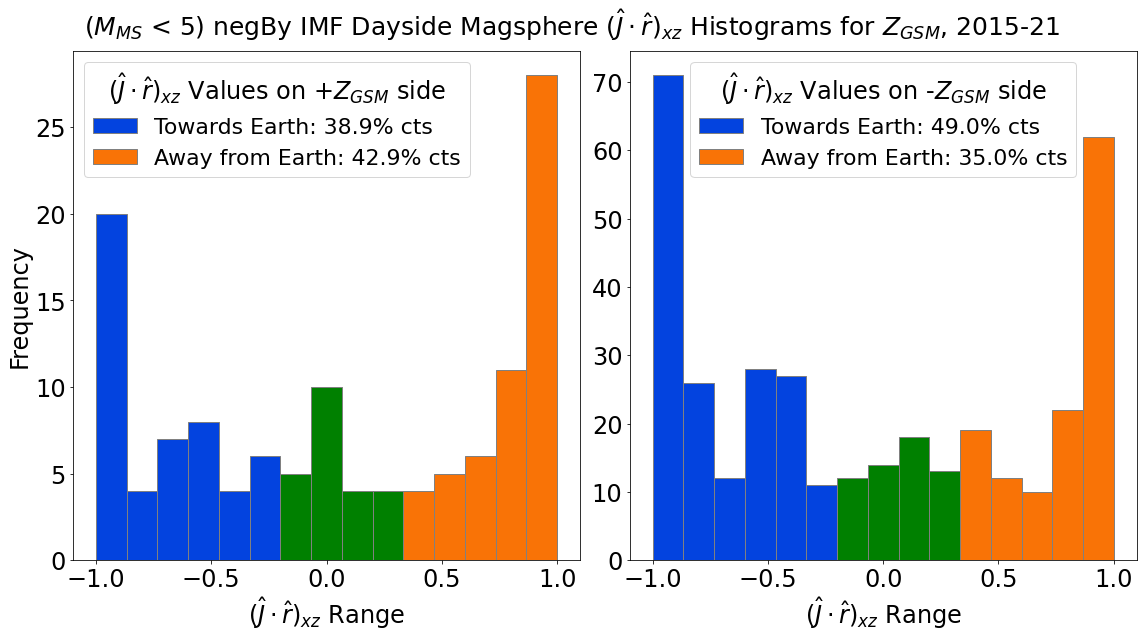

In [41]:
#----------Histing FullMagsphere and Sheath Only CurCOS2D DFs------
def color_cos_Histbar(hcounts, hbin, hpatch):
    """Colors histogram patches by specific count number or bin interval. Color patchesby 
    cosine value for towards(>=0.20) and away(<= -0.20) from Earth. And return double hist peak bin interval 
    ranges for cos=+/-1"""
    fposCts = 0
    fnegCts = 0
    #print(len(hcounts), len(hbin), len(hpatch))
    for i in range(len(hbin)-1): #remember counts and patches have same length, but bins has len(counts)+1
        if hbin[i] >= 0.25: #Away from Earth(cosxy >= 0.20)
            hpatch[i].set_fc('xkcd:orange')#'purple'
            fposCts = fposCts + hcounts[i]
        elif hbin[i] <= -0.25: #Towards Earth(cosxy <= -0.20)
            hpatch[i].set_fc('xkcd:blue')#'xkcd:wheat'
            fnegCts = fnegCts + hcounts[i]
    #define respective count percentage of Towards and Away from Earth 
    fCounts_pos = 100 * fposCts/np.sum(hcounts)
    fCounts_neg = 100 * fnegCts/np.sum(hcounts)
    """Since hbin always goes from [-1,1] due to it being values of cosine. 
    I can easily label the cosine regions of the histogram patch""" 
    #set label name for each colored histogram patch
    hpatch[-1].set_label('Away from Earth: %0.1f%% cts'%fCounts_pos) 
    hpatch[0].set_label('Towards Earth: %0.1f%% cts'%fCounts_neg)
    return;
    
def get_histpeak_bins(hcounts, hbin):
    """Realized when investigating the double hist peak structure at cos = 1 & -1. Because hbin arranges itself 
    numerically from lowest to hightest; and that the hcounts corresponds to said arrays. I merely need to look at
    hncounts' start and end position to correspond to hbins to get my expected cos = -1 &-1 bin range"""
    print('\tHist Counts:', hcounts, '\n\tand Bin Peaks', hbin[:2], hbin[-2:])
    #Finding index of double count peaks that occur at cos = -1 & 1; and displaying it's bin interval
    cmax_neg1 = np.argwhere(hcounts == hcounts[0]) #returns element index of max value of inputted array as an integer
    cmax_pos1 = np.argwhere(hcounts == hcounts[-1]) #returns element index of max value of inputted array as an integer
    print('\tIndex %d corresponds to Max Neg1 Bin Count of %0.2f and Bin Range of %0.2f to %0.2f'
        %(0, hcounts[0], hbin[0], hbin[1]) )
      #%(cmax_neg1[0,0], hcounts[0], hbin[cmax_neg1[0,0]], hbin[cmax_neg1[0,0]+1]))
    print('\tIndex %d corresponds to Max Pos1 Bin Count of %0.2f and Bin Range of %0.2f to %0.2f'
        %(-1, hcounts[-1], hbin[-2], hbin[-1]) )
      #%(cmax_pos1[0,0], hcounts[-1], hbin[cmax_pos1[0,0]], hbin[cmax_pos1[0,0]+1]))
    #print(hbin[-1], hbin[cmax_pos1[0,0]+1])
    # Since I know bin intervals min/max are -/+1 respectively, just return each intervals starting limit
    #return(hbin[cmax_neg1[0,0]], hbin[cmax_neg1[0,0]+1],hbin[cmax_pos1[0,0]], hbin[cmax_pos1[0,0]+1] );
    print('\t\tReturning hist peak intervals start limits', hbin[1], hbin[-2])
    return(hbin[1], hbin[-2]);

def hist_curcosposneg2D(df_cos_pos,df_cos_neg, achTitle, achPlane):
    """Based on inputted cosine data for postive/negative z/y-values. Create histogram of Jcos_xz and Jcos_xy data, 
    find the bin intervals for the double peaks at cos = +/-1, and scatter plot those histpeaks position"""
    ##Create subplot parameters
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 9)) #setting size of subplots
    """For 1x2 Subplots: figsize = (15,10), title size =24, axis label/tick size = 20, legend font = 18
    For 2x2 Subplots: figsize = (20,18), title size =28, axis label/tick size = 24, legend font = 24
    For 2x4 subplots: figsize = (30,18), title size = 28, axis label/ticksize = 24, legend font = 20
    For 2x3 subplots: figsize = (25,18), title size = 28, axislabel/ticksize = 24, legend font = 20
    For 2x1 Subplots: figsize = (10,20), title size =22, axis label/tick size = 22, legend font = 22"""
    #fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize = (25, 18)) #setting size of subplots
    fsize = 24 #fontsize of axis labels/ticks
    legsize = 24 #legend fontsize
    tsize = 25 #titlesize
    fig.suptitle(achTitle, fontsize = tsize) #single title over multiple subplots
    bin_num = 15 #number of bins******(15bins is what I used to export)
    jdr_xz = r'$(\hat{J}\cdot\hat{r})_{xz}$' #latex string version of J.r
    jdr_xy = r'$(\hat{J}\cdot\hat{r})_{xy}$'
    if achPlane == 'xz': #Make histogram on xz plane
        afCos_posz = df_cos_pos['cos_Jxz'].to_numpy(copy=True)
        afCos_negz = df_cos_neg['cos_Jxz'].to_numpy(copy=True)
        #----Create J.r cosine angles hist and other plots on xz-plane for +Z values--------------------------
        print('Histing and Plotting For +Z cos_xy DFs:')
        n_cpz, bins_cpz, patch_cpz = ax1.hist(afCos_posz,bins=bin_num, fc = 'g',ec='grey')
        ax1.tick_params(axis='x', labelsize=fsize) #setting axes tick labelsize
        ax1.tick_params(axis='y', labelsize=fsize)
        ax1.set_ylabel('Frequency', fontsize = fsize)
        #ax1.set_title(achTitle, fontsize = tsize)
        ax1.set_xlabel('%s Range'%(jdr_xz), fontsize = fsize)#, loc = 'right')
            #Color histogram bar regions and return cos = +/-1 bin interval values
        color_cos_Histbar(n_cpz, bins_cpz, patch_cpz)
        [pz_cneg1_up, pz_cpos1_low] = get_histpeak_bins(n_cpz, bins_cpz)
        ax1.legend(title = '%s Values on +$Z_{GSM}$ side'%(jdr_xz), title_fontsize = legsize, loc = 'best', prop={'size': legsize-2})
        '''
        #Extract x,z,cosine data for cosPosz = +/-1 Intervals
        [cos_PZpos1, cos_PZneg1] = get_cos_doublehistpeak_DF(df_cos_pos, pz_cneg1_up, pz_cpos1_low, 'xz')
        #display(cos_PZpos1[:3])
        #display(cos_PZneg1[:3])
        X_PZneg1 = cos_PZneg1['x_avg(Re)'].to_numpy(copy=True)
        PZ_neg1 = cos_PZneg1['z_avg(Re)'].to_numpy(copy=True)
        Jmag_PZneg1 = cos_PZneg1['Jmag_avg'].to_numpy(copy=True)
        
        X_PZpos1 = cos_PZpos1['x_avg(Re)'].to_numpy(copy=True)
        PZ_pos1 = cos_PZpos1['z_avg(Re)'].to_numpy(copy=True)
        Jmag_PZpos1 = cos_PZpos1['Jmag_avg'].to_numpy(copy=True)
        fPosz_DPeak = len(PZ_neg1)+len(PZ_pos1)
        fPosz_Towards = 100* len(PZ_neg1)/fPosz_DPeak
        fPosz_Away = 100* len(PZ_pos1)/fPosz_DPeak
            #Scatterplotting XZ-data that corresponds to cos=+/-1 bin intervals
        ax2.plot(X_PZneg1, PZ_neg1, 'yd', label = 'Towards Earth Peak = %0.1f%%'%(fPosz_Towards)) 
        ax2.plot(X_PZpos1, PZ_pos1, 'mp', label = 'Away from Earth Peak = %0.1f%%'%(fPosz_Away)) 
        #draw_circle1 = plt.Circle((0, 0), 1, color = 'black')
        #ax2.add_artist(draw_circle1)
        draw_earth_center(1.0, ax2, 'right') #plotting Earth as half black-white cirle
        ax2.plot([], [], 'ko', label='Earth') #empty plot label workaround
        #ax2.set_xlabel('$X_{GSM}$ [Re]', fontsize = fsize)
        ax2.set_ylabel('$+Z_{GSM}$ [Re]', fontsize = fsize)
        ax2.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        ax2.legend(loc = 'upper left', prop={'size': legsize})#, frameon=True)
        
            #Display corresponding Current Magnitude for +Z Cosine Peaks
        ax3.plot(Jmag_PZneg1, 'yo', label = 'Towards Earth Peak')
        ax3.plot(Jmag_PZpos1, 'mo', label = 'Away from Earth Peak')
        #ax3.set_xlabel('Double Peak Events', fontsize = fsize)
        ax3.set_ylabel('Jmag $[\mu A/m^2]$', fontsize = fsize)
        ax3.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        ax3.legend(loc = 'best', prop={'size': legsize})#, frameon=True)
        ''';
        #----Create J.r cosine angles hist and other plots on xz-plane for -Z values--------------------------
        print('Histing and Plotting For -Z cos_xy DFs:')
        n_cnz, bins_cnz, patch_cnz = ax2.hist(afCos_negz,bins=bin_num, fc = 'g',ec='grey')
        ax2.tick_params(axis='x', labelsize=fsize) #setting axes tick labelsize
        ax2.tick_params(axis='y', labelsize=fsize)
        #ax2.set_ylabel('Frequency', fontsize = fsize)
        ax2.set_xlabel('%s Range'%(jdr_xz), fontsize = fsize)#, loc = 'right')
            #Color histogram bar regions and return cos = +/-1 bin interval values
        color_cos_Histbar(n_cnz, bins_cnz, patch_cnz)
        [nz_cneg1_up, nz_cpos1_low] = get_histpeak_bins(n_cnz, bins_cnz)
        ax2.legend(title = '%s Values on -$Z_{GSM}$ side'%(jdr_xz), title_fontsize = legsize, loc = 'best', prop={'size': legsize-2})
        '''
            #Extract x,z,cosine data for cosNegz = +/-1 Intervals
        [cos_NZpos1, cos_NZneg1] = get_cos_doublehistpeak_DF(df_cos_neg, nz_cneg1_up, nz_cpos1_low, 'xz')
        #display(cos_NZpos1[:3])
        #display(cos_NZneg1[:3])
        X_NZneg1 = cos_NZneg1['x_avg(Re)'].to_numpy(copy=True)
        NZ_neg1 = cos_NZneg1['z_avg(Re)'].to_numpy(copy=True)
        Jmag_NZneg1 = cos_NZneg1['Jmag_avg'].to_numpy(copy=True)
        
        X_NZpos1 = cos_NZpos1['x_avg(Re)'].to_numpy(copy=True)
        NZ_pos1 = cos_NZpos1['z_avg(Re)'].to_numpy(copy=True)
        Jmag_NZpos1 = cos_NZpos1['Jmag_avg'].to_numpy(copy=True)
        fNegz_DPeak = len(NZ_neg1)+len(NZ_pos1)
        fNegz_Towards = 100* len(NZ_neg1)/fNegz_DPeak
        fNegz_Away = 100* len(NZ_pos1)/fNegz_DPeak
            #Scatterplotting XY-data that corresponds to cos=+/-1 bin intervals
        ax4.plot(X_NZneg1, NZ_neg1, 'yd', label = 'Towards Earth Peak = %0.1f%%'%(fNegz_Towards)) 
        ax4.plot(X_NZpos1, NZ_pos1, 'mp', label = 'Away from Earth Peak = %0.1f%%'%(fNegz_Away)) 
        #draw_circle1 = plt.Circle((0, 0), 1, color = 'black')
        #ax5.add_artist(draw_circle1)
        draw_earth_center(1.0, ax4, 'right') #plotting Earth as half black-white cirle
        ax4.plot([], [], 'ko', label='Earth') #empty plot label workaround
        ax4.set_xlabel('$X_{GSM}$ [Re]', fontsize = fsize)
        ax4.set_ylabel('$-Z_{GSM}$ [Re]', fontsize = fsize)
        ax4.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        ax4.legend(loc = 'lower left', prop={'size': legsize})#, frameon=True)
        
            #Display corresponding Current Magnitude for -Z Cosine Peaks
        ax6.plot(Jmag_NZneg1, 'yo', label = 'Towards Earth Peak')
        ax6.plot(Jmag_NZpos1, 'mo', label = 'Away from Earth Peak')
        ax6.set_xlabel('Double Peak Events', fontsize = fsize)
        ax6.set_ylabel('Jmag $[\mu A/m^2]$', fontsize = fsize)
        ax6.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        ax6.legend(loc = 'best', prop={'size': legsize})#, frameon=True)
        ''';
        plt.tight_layout() #ensures subplots don't overlap
    #------------------------XY Histogram
    if achPlane == 'xy': #Make histogram on xy plane
        afCos_posy = df_cos_pos['cos_Jxy'].to_numpy(copy=True)
        afCos_negy = df_cos_neg['cos_Jxy'].to_numpy(copy=True)
        #----Create J.r cosine angles hist and other plots on xy-plane for +Y values--------------------------
        print('Histing and Plotting For +Y cos_xy DFs:')
        n_cpy, bins_cpy, patch_cpy = ax1.hist(afCos_posy,bins=bin_num, fc = 'g',ec='grey')
        ax1.tick_params(axis='x', labelsize=fsize) #setting axes tick labelsize
        ax1.tick_params(axis='y', labelsize=fsize)
        ax1.set_ylabel('Frequency', fontsize = fsize)
        #ax1.set_title(achTitle, fontsize = tsize)
        ax1.set_xlabel('%s Range'%(jdr_xy), fontsize = fsize)#, loc = 'right')
            #Color histogram bar regions and return cos = +/-1 bin interval values
        color_cos_Histbar(n_cpy, bins_cpy, patch_cpy)
        [py_cneg1_up, py_cpos1_low] = get_histpeak_bins(n_cpy, bins_cpy)
        ax1.legend(title = '%s Values on +$Y_{GSM}$ side'%(jdr_xy), title_fontsize = legsize, loc = 'best', prop={'size': legsize-2})
        '''
        #Extract x,y,cosine data for cosPosy = +/-1 Intervals
        [cos_PYpos1, cos_PYneg1] = get_cos_doublehistpeak_DF(df_cos_pos, py_cneg1_up, py_cpos1_low, 'xy')
        #display(cos_PYpos1[:3])
        #display(cos_PYneg1[:3])
        X_PYneg1 = cos_PYneg1['x_avg(Re)'].to_numpy(copy=True)
        PY_neg1 = cos_PYneg1['y_avg(Re)'].to_numpy(copy=True)
        Jmag_PYneg1 = cos_PYneg1['Jmag_avg'].to_numpy(copy=True)
        
        X_PYpos1 = cos_PYpos1['x_avg(Re)'].to_numpy(copy=True)
        PY_pos1 = cos_PYpos1['y_avg(Re)'].to_numpy(copy=True)
        Jmag_PYpos1 = cos_PYpos1['Jmag_avg'].to_numpy(copy=True)
        fPosy_DPeak = len(PY_neg1)+len(PY_pos1)
        fPosy_Towards = 100* len(PY_neg1)/fPosy_DPeak 
        fPosy_Away = 100* len(PY_pos1)/fPosy_DPeak 
            #Scatterplotting XY-data that corresponds to cos=+/-1 bin intervals
        ax2.plot(X_PYneg1, PY_neg1, 'yd', label = 'Towards Earth Peak = %0.1f%%'%(fPosy_Towards)) 
        ax2.plot(X_PYpos1, PY_pos1, 'mp', label = 'Away from Earth Peak = %0.1f%%'%(fPosy_Away)) 
        #draw_circle1 = plt.Circle((0, 0), 1, color = 'black')
        #ax2.add_artist(draw_circle1)
        draw_earth_center(1.0, ax2, 'right') #plotting Earth as half black-white cirle
        ax2.plot([], [], 'ko', label='Earth') #empty plot label workaround
        #ax2.set_xlabel('$X_{GSM}$ [Re]', fontsize = fsize)
        ax2.set_ylabel('$+Y_{GSM}$ [Re]', fontsize = fsize)
        ax2.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        ax2.legend(loc = 'upper left', prop={'size': legsize})#, frameon=True)
            #Display corresponding Current Magnitude for +Y Cosine Peaks
        ax3.plot(Jmag_PYneg1, 'yo', label = 'Towards Earth Peak')
        ax3.plot(Jmag_PYpos1, 'mo', label = 'Away from Earth Peak')
        #ax3.set_xlabel('Double Peak Events', fontsize = fsize)
        ax3.set_ylabel('Jmag $[\mu A/m^2]$', fontsize = fsize)
        ax3.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        ax3.legend(loc = 'best', prop={'size': legsize})#, frameon=True) 
        ''';
        #----Create J.r cosine angles hist and other plots on xy-plane for -Y values--------------------------
        print('Histing and Plotting For -Y cos_xy DFs:')
        n_cny, bins_cny, patch_cny = ax2.hist(afCos_negy,bins=bin_num, fc = 'g',ec='grey')
        ax2.tick_params(axis='x', labelsize=fsize) #setting axes tick labelsize
        ax2.tick_params(axis='y', labelsize=fsize)
        #ax2.set_ylabel('Frequency', fontsize = fsize)
        ax2.set_xlabel('%s Range'%(jdr_xy), fontsize = fsize)#, loc = 'right')
            #Color histogram bar regions and return cos = +/-1 bin interval values
        color_cos_Histbar(n_cny, bins_cny, patch_cny)
        [ny_cneg1_up, ny_cpos1_low] = get_histpeak_bins(n_cny, bins_cny)
        ax2.legend(title = '%s Values on -$Y_{GSM}$ side'%(jdr_xy), title_fontsize = legsize, loc = 'best', prop={'size': legsize-2})
        '''
        #Extract x,y,cosine data for cosNegy = +/-1 Intervals
        [cos_NYpos1, cos_NYneg1] = get_cos_doublehistpeak_DF(df_cos_neg, ny_cneg1_up, ny_cpos1_low, 'xy')
        #display(cos_NYpos1[:3])
        #display(cos_NYneg1[:3])
        X_NYneg1 = cos_NYneg1['x_avg(Re)'].to_numpy(copy=True)
        NY_neg1 = cos_NYneg1['y_avg(Re)'].to_numpy(copy=True)
        Jmag_NYneg1 = cos_NYneg1['Jmag_avg'].to_numpy(copy=True)
        
        X_NYpos1 = cos_NYpos1['x_avg(Re)'].to_numpy(copy=True)
        NY_pos1 = cos_NYpos1['y_avg(Re)'].to_numpy(copy=True)
        Jmag_NYpos1 = cos_NYpos1['Jmag_avg'].to_numpy(copy=True)
        fNegy_DPeak = len(NY_neg1)+len(NY_pos1)
        fNegy_Towards = 100* len(NY_neg1)/fNegy_DPeak 
        fNegy_Away = 100* len(NY_pos1)/fNegy_DPeak 
            #Scatterplotting XY-data that corresponds to cos=+/-1 bin intervals
        ax4.plot(X_NYneg1, NY_neg1, 'yd', label = 'Towards Earth Peak = %0.1f%%'%(fNegy_Towards)) 
        ax4.plot(X_NYpos1, NY_pos1, 'mp', label = 'Away from Earth Peak = %0.1f%%'%(fNegy_Away)) 
        #draw_circle1 = plt.Circle((0, 0), 1, color = 'black')
        #ax5.add_artist(draw_circle1)
        draw_earth_center(1.0, ax4, 'right') #plotting Earth as half black-white cirle
        ax4.plot([], [], 'ko', label='Earth') #empty plot label workaround
        ax4.set_xlabel('$X_{GSM}$ [Re]', fontsize = fsize)
        ax4.set_ylabel('$-Y_{GSM}$ [Re]', fontsize = fsize)
        ax4.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        ax4.legend(loc = 'lower left', prop={'size': legsize})#, frameon=True)
            #Display corresponding Current Magnitude for -Y Cosine Peaks
        ax6.plot(Jmag_NYneg1, 'yo', label = 'Towards Earth Peak')
        ax6.plot(Jmag_NYpos1, 'mo', label = 'Away from Earth Peak')
        ax6.set_xlabel('Double Peak Events', fontsize = fsize)
        ax6.set_ylabel('Jmag $[\mu A/m^2]$', fontsize = fsize)
        ax6.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        ax6.legend(loc = 'best', prop={'size': legsize})#, frameon=True) 
        ''';
        plt.tight_layout() #ensures subplots don't overlap
    return;
#-------------------------
def get_curcosTopBot_DF(df_curcos, achPlane):
    """Using inputted CurCos2D DF and plane preference, create two new DFs for above and below the Y/Z axis"""
    if achPlane == 'xz': #Create sub DFs for positive/negative z values
        z = df_curcos['z_avg(Re)'].to_numpy(copy=True)
        nPosz_idx = np.array([]) #initialize empty drop index arrays
        nNegz_idx = np.array([])
        for i in range(len(z)):
            if z[i] >= 0: #get index array of nonnegative z-values(including zero)
                nPosz_idx = np.append(nPosz_idx, i)
            else: #get index array of negative z-values
                nNegz_idx = np.append(nNegz_idx, i)
        # Redefine new dataframes by dropping +/- z values
        """Confirmed:defining two different named DFS that dropped different indices doesn not affect the OG CopyDF"""
        df_cop = df_curcos.copy(deep = True) #creating copy of CurrMECcosine datframe
        df_cop_negz = df_cop.drop(nPosz_idx) #dropping DF rows that have z >=0
        df_cop_posz = df_cop.drop(nNegz_idx) #dropping DF rows that have z <0
        df_cop_negz = df_cop_negz.reset_index(drop=True) # reset index# column for new DF
        df_cop_posz = df_cop_posz.reset_index(drop=True) # reset index# column for new DF
        #Checks if respective z-column arrays contain nonnegative and negative entries only
        negz = df_cop_negz['z_avg(Re)'].to_numpy(copy=True)
        posz = df_cop_posz['z_avg(Re)'].to_numpy(copy=True)
        #print(posz)
        print('\t\tConfirmed: +Z cos_xz DF was created and contains (z>=0) array:', all(i >= 0 for i in posz))
        print('\t\tConfirmed: -Z cos_xz DF was created and contains (z<0) array:', all(i < 0 for i in negz))
        return(df_cop_negz, df_cop_posz)
    elif achPlane == 'xy': #Create sub DFs for positive/negative y values
        y = df_curcos['y_avg(Re)'].to_numpy(copy=True)
        nPosy_idx = np.array([]) #initialize empty drop index arrays
        nNegy_idx = np.array([])
        for i in range(len(y)):
            if y[i] >= 0: #get index array of nonnegative y-values(including zero)
                nPosy_idx = np.append(nPosy_idx, i)
            else: #get index array of negative y-values
                nNegy_idx = np.append(nNegy_idx, i)
        # Redefine new dataframes by dropping +/- y values
        df_cop = df_curcos.copy(deep = True) #creating copy of CurrMECcosine datframe
        df_cop_negy = df_cop.drop(nPosy_idx) #dropping DF rows that have y >=0
        df_cop_posy = df_cop.drop(nNegy_idx) #dropping DF rows that have y <0
        df_cop_negy = df_cop_negy.reset_index(drop=True) # reset index# column for new DF
        df_cop_posy = df_cop_posy.reset_index(drop=True) # reset index# column for new DF
        #Checks if respective y-column arrays contain nonnegative and negative entries only
        negy = df_cop_negy['y_avg(Re)'].to_numpy(copy=True)
        posy = df_cop_posy['y_avg(Re)'].to_numpy(copy=True)
        #print(posz)
        print('\t\tConfirmed: +Y cos_xy DF was created and contains (y>=0) array:', all(i >= 0 for i in posy))
        print('\t\tConfirmed: -Y cos_xy DF was created and contains (y<0) array:', all(i < 0 for i in negy))
        return(df_cop_negy, df_cop_posy)
    else:
        print('Invalid Input')
    return;

def get_cos_doublehistpeak_DF(df_cos, neg1_cosmax, pos1_cosmin, achPlane):
    """Categorize the inputted cosCurrMEC DataFrame by cosine values which belong to the 
    cos = +/-1 histogram bin intervals"""
    df_cop = df_cos.copy(deep=True)#create copy of inputted DF
    if achPlane == 'xz':
        print('\t\tSeparating cos_Jxz vals by HistPeak')
        cos_vals = df_cop['cos_Jxz'].to_numpy(copy=True)
    if achPlane == 'xy':
        print('\t\tSeparating cos_Jxy vals by HistPeaks')
        cos_vals = df_cop['cos_Jxy'].to_numpy(copy=True)
    print('CosPeak Limits:', neg1_cosmax, pos1_cosmin)
    #Get tuple(index array by doing [0]) for cosine values < (cos= -1)_max and > (cos = +1)_min
    idx_neg1 = np.where(cos_vals <= neg1_cosmax) 
    idx_pos1 = np.where(cos_vals >= pos1_cosmin) 
    nDrop_Pos1 = np.where(cos_vals< pos1_cosmin) #drop index array for values less than (cos = +1)_min
    nDrop_Neg1 = np.where(cos_vals> neg1_cosmax) #drop index array for values greater than (cos = -1)_max
    #Redefine new dataframes by dropping cosine values not belonging to the cos = +/-1 bin intervals
    #print(cos_vals[nDrop_Neg1[0]]) indexing into np.where tuple output
    df_cop_pos1 = df_cop.drop(nDrop_Pos1[0]) #drop DF rows whose cosine values are less than (cos = +1)_min
    df_cop_neg1 = df_cop.drop(nDrop_Neg1[0]) #drop DF rows whose cosine values are greater than (cos = -1)_max
    df_cop_neg1 = df_cop_neg1.reset_index(drop=True) # reset index# column for new DF
    df_cop_pos1 = df_cop_pos1.reset_index(drop=True) # reset index# column for new DF
    print('\t|> (cos = +/-1)_interval DFs created')
    #display(df_cop)
    #display(df_cop_neg1)
    #display(df_cop_pos1)
    #print(cos_vals[idx_neg1[0]], '\n', cos_vals[idx_pos1[0]])
    #print(type(nDrop_neg1[0][0]))
    #cosPosZ_neg1
    #cosPos
    return(df_cop_pos1, df_cop_neg1);


def hist_curcosJdotr(df_stable, clang, achPlane):
    """With inputted CurCos2D Dataframe, make a histogram of the Zpos/Ypos vs (J.r)^ cosine angles on the xy/xz-plane"""
    print('\nHisting stuff with: ',namestr(df_stable, globals()), clang, achPlane)
    afClang = df_stable['Clang_avg'].to_numpy(copy=True)
    print('Clock Angle Range [%0.2f, %0.2f]deg'%(min(afClang), max(afClang)))
    #Define Latex string versions of J.r dot product
    jdr_xz = r'$(\hat{J}\cdot\hat{r})_{xz}$' #latex string version of J.r
    jdr_xy = r'$(\hat{J}\cdot\hat{r})_{xy}$'
    #----------------------------------------------------
    if achPlane == 'xz': #Hist Zpos vs J.r cosine angles on xz-plane
        print('Histing Z vs (Jcos)_xz and (J.r)^_xz')
        #Create DF and define explicit variables for cosine data above and below zaxis
        df_curcosFull = get_cosJ2D_DF(df_stable)
        [df_curcos_negz, df_curcos_posz] = get_curcosTopBot_DF(df_curcosFull, 'xz')
        display(df_curcosFull[:3])
        #display(df_curcos_negz[:3])
        #display(df_curcos_posz[:3])
        afPosz = df_curcos_posz['z_avg(Re)'].to_numpy(copy=True)
        afNegz = df_curcos_negz['z_avg(Re)'].to_numpy(copy=True)
        print('\tLength of cos_jxz array:',len(afClang))
        print('\tPosZ-range = %0.2f to %0.2f Re'%(min(afPosz), max(afPosz)))
        print('\tNegZ-range = %0.2f to %0.2f Re'%(min(afNegz), max(afNegz)))
        ##Create histogram of J.r cosine angles on xz-plane for positive/negative z-values
        achTitle_Z = '%s Dayside Magsphere %s Histograms for $Z_{GSM}$, 2015-21'%(clang, jdr_xz)
        hist_curcosposneg2D(df_curcos_posz,df_curcos_negz, achTitle_Z, 'xz')
    #----------------------------------------------------
    elif achPlane == 'xy': #Hist Ypos vs J.r cosine angles on xy-plane
        print('Histing Y vs (Jcos)_xy and (J.r)^_xy')
        #Create DF and define explicit variables for cosine data above and below yaxis
        df_curcosFull = get_cosJ2D_DF(df_stable)
        [df_curcos_negy, df_curcos_posy] = get_curcosTopBot_DF(df_curcosFull, 'xy')
        display(df_curcosFull[:3])
        #display(df_curcos_negy[:3])
        #display(df_curcos_posy[:3])
        afPosy = df_curcos_posy['y_avg(Re)'].to_numpy(copy=True)
        afNegy = df_curcos_negy['y_avg(Re)'].to_numpy(copy=True)
        print('\tLength of cos_jxy array:',len(afClang))
        print('\tPosY-range = %0.2f to %0.2f Re'%(min(afPosy), max(afPosy)))
        print('\tNegY-range = %0.2f to %0.2f Re'%(min(afNegy), max(afNegy)))
        achTitle_Y = '%s %s Dayside Magsphere %s Histogram for $Y_{GSM}$, 2015-21'%(clang, jdr_xy)
        hist_curcosposneg2D(df_curcos_posy,df_curcos_negy, achTitle_Y, 'xy')
    else:
        print('Invalid input')
    return;

#---------Main Calling Below----------
#hist_curcosJdotr(stabDay_soBz_currMECB_jmagQSOPtrim_2015to21, 'soBz', 'xy')
#plt.savefig('HistPlot_StableDaysoBz_postMapMagsphere_cosJxy_2015to21_v2', bbox_inches='tight', facecolor = 'w')

#hist_curcosJdotr(stabDay_norBz_currMECB_jmagQSOPtrim_2015to21, 'norBz', 'xy')
#plt.savefig('HistPlot_StableDaynorBz_postMapMagsphere_cosJxy_2015to21_v2', bbox_inches='tight', facecolor = 'w')

#hist_curcosJdotr(stabDay_posBy_currMECB_jmagQSOPtrim_2015to21, 'posBy', 'xz')
#plt.savefig('HistPlot_StableDayposBy_postMapMagsphere_cosJxz_2015to21_v2', bbox_inches='tight', facecolor = 'w')

#hist_curcosJdotr(stabDay_negBy_currMECB_jmagQSOPtrim_2015to21, 'negBy', 'xz')
#plt.savefig('HistPlot_StableDaynegBy_postMapMagsphere_cosJxz_2015to21_v2', bbox_inches='tight', facecolor = 'w')



#'''
#hist_curcosJdotr(SheathTrim_soBz_cosXY, 'soBz', 'xy')
#plt.savefig('DayStablesoBz_Sheath21den120tperpLD_cosJxy_HistPlots_Yr1to5_vp1', bbox_inches='tight', facecolor = 'w')


#-----
achMach5 = r'($M_{MS}$ < 5)'
#hist_curcosJdotr(stabDay_5MGSsoBz_currMECB_jmagQSOPtrim_2015to21, '%s soBz IMF'%(achMach5), 'xy')
#plt.savefig('HistPlot_5MGS_StableDaysoBz_postMapMagsphere_cosJxy_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#hist_curcosJdotr(stabDay_5MGSnorBz_currMECB_jmagQSOPtrim_2015to21, '%s norBz IMF'%(achMach5), 'xy')
#plt.savefig('HistPlot_5MGS_StableDaynorBz_postMapMagsphere_cosJxy_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#hist_curcosJdotr(stabDay_5MGSposBy_currMECB_jmagQSOPtrim_2015to21, '%s posBy IMF'%(achMach5), 'xz')
#plt.savefig('HistPlot_5MGS_StableDayposBy_postMapMagsphere_cosJxz_2015to21_v1', bbox_inches='tight', facecolor = 'w')

hist_curcosJdotr(stabDay_5MGSnegBy_currMECB_jmagQSOPtrim_2015to21, '%s negBy IMF'%(achMach5), 'xz')
#plt.savefig('HistPlot_5MGS_StableDaynegBy_postMapMagsphere_cosJxz_2015to21_v1', bbox_inches='tight', facecolor = 'w')


* Histogramming Current Cosine Data for Above/Below the X-axis on the +/- Y or Z-side using PostMap **Just Sheath** Stable IMFs


Histing stuff with:  ['Sheathtrim_postMap_soBz_stabDay'] Southward IMF xy
Clock Angle Range [135.10, 224.83]deg
Histing Y vs (Jcos)_xy and (J.r)^_xy
	Acquired: curr-mec vector data as 1D arrays
--->Confirmed: CurCos2D DF was created :
		Confirmed: +Y cos_xy DF was created and contains (y>=0) array: True
		Confirmed: -Y cos_xy DF was created and contains (y<0) array: True


,Start_str,Jx_avg(uA/m2),Jy_avg,Jz_avg,Jxy_avg,Jxz_avg,Jmag_avg,Rmag_avg(Re),Rxy_avg(Re),Rxz_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),cos_Jxy,cos_Jxz,cos_Jr,Clang_avg,End_str
0,2015-09-07 18:00:00,-0.024676,0.022745,0.010042,0.033559,0.026641,0.131777,11.796126,10.976387,4.584557,1.533919,10.868678,-4.320330,0.568357,-0.665119,0.106774,160.846,2015-09-07 18:10:00
1,2015-09-09 09:20:00,-0.007381,0.018885,0.012676,0.020276,0.014668,0.108120,9.354687,8.492287,6.574707,5.276178,6.654388,-3.922846,0.503653,-0.919430,0.036582,166.640,2015-09-09 09:30:00
2,2015-09-09 09:50:00,0.013896,-0.024597,0.015681,0.028251,0.020952,0.124315,9.763337,8.773365,6.748451,5.214693,7.055418,-4.283524,-0.407811,0.037431,-0.138621,166.093,2015-09-09 10:00:00


	Length of cos_jxy array: 340
	PosY-range = 0.08 to 23.38 Re
	NegY-range = -21.19 to -0.02 Re
Histing and Plotting For +Y cos_xy DFs:
	Hist Counts: [32. 12. 10. 11. 10. 12.  9.  6. 14. 15. 15. 16. 13. 17. 30.] 
	and Bin Peaks [-0.99957568 -0.86638843] [0.86504579 0.99823304]
	Index 0 corresponds to Max Neg1 Bin Count of 32.00 and Bin Range of -1.00 to -0.87
	Index -1 corresponds to Max Pos1 Bin Count of 30.00 and Bin Range of 0.87 to 1.00
		Returning hist peak intervals start limits -0.8663884323549852 0.8650457911178339
Histing and Plotting For -Y cos_xy DFs:
	Hist Counts: [23.  8.  8.  6.  8.  5.  4.  1.  9.  2.  4.  9.  4.  6. 21.] 
	and Bin Peaks [-0.99987204 -0.86654866] [0.86665522 0.9999786 ]
	Index 0 corresponds to Max Neg1 Bin Count of 23.00 and Bin Range of -1.00 to -0.87
	Index -1 corresponds to Max Pos1 Bin Count of 21.00 and Bin Range of 0.87 to 1.00
		Returning hist peak intervals start limits -0.8665486626782026 0.8666552219871821

Histing stuff with:  ['Sheathtrim_postM

,Start_str,Jx_avg(uA/m2),Jy_avg,Jz_avg,Jxy_avg,Jxz_avg,Jmag_avg,Rmag_avg(Re),Rxy_avg(Re),Rxz_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),cos_Jxy,cos_Jxz,cos_Jr,Clang_avg,End_str
0,2015-09-23 12:50:00,-0.011082,-0.000685,-0.017107,0.011103,0.020383,0.104810,11.860942,10.436659,8.269060,6.051514,8.503119,-5.635294,-0.629022,0.174071,0.018912,327.280,2015-09-23 13:00:00
1,2015-09-23 14:20:00,0.001911,-0.001453,0.005313,0.002401,0.005646,0.093045,11.993631,10.616998,7.762954,5.398036,9.142311,-5.578949,-0.116436,-0.440808,-0.029219,343.448,2015-09-23 14:30:00
2,2015-10-13 12:10:00,-0.003563,0.002213,-0.007122,0.004195,0.007964,0.117712,12.003277,10.949004,9.764491,8.434973,6.980826,-4.918995,-0.318100,0.063997,0.014455,344.140,2015-10-13 12:20:00


	Length of cos_jxy array: 211
	PosY-range = 0.28 to 23.30 Re
	NegY-range = -22.31 to -0.18 Re
Histing and Plotting For +Y cos_xy DFs:
	Hist Counts: [15.  7.  8.  4.  6.  4.  7.  7.  2.  6.  6.  2.  5.  4. 14.] 
	and Bin Peaks [-0.9999677  -0.86673411] [0.86530259 0.99853619]
	Index 0 corresponds to Max Neg1 Bin Count of 15.00 and Bin Range of -1.00 to -0.87
	Index -1 corresponds to Max Pos1 Bin Count of 14.00 and Bin Range of 0.87 to 1.00
		Returning hist peak intervals start limits -0.8667341114702958 0.8653025946671359
Histing and Plotting For -Y cos_xy DFs:
	Hist Counts: [15.  8. 10. 12.  3.  7.  5.  3.  5.  5.  4.  8.  3. 12. 14.] 
	and Bin Peaks [-0.99987887 -0.86664042] [0.86545946 0.99869792]
	Index 0 corresponds to Max Neg1 Bin Count of 15.00 and Bin Range of -1.00 to -0.87
	Index -1 corresponds to Max Pos1 Bin Count of 14.00 and Bin Range of 0.87 to 1.00
		Returning hist peak intervals start limits -0.8666404171064075 0.8654594641285305

Histing stuff with:  ['Sheathtrim_postM

,Start_str,Jx_avg(uA/m2),Jy_avg,Jz_avg,Jxy_avg,Jxz_avg,Jmag_avg,Rmag_avg(Re),Rxy_avg(Re),Rxz_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),cos_Jxy,cos_Jxz,cos_Jr,Clang_avg,End_str
0,2015-09-03 16:20:00,-0.030712,-0.007961,-0.026309,0.031727,0.040440,0.094828,11.986395,10.922708,5.315430,1.971814,10.743254,-4.936168,-0.421548,0.322423,-0.014271,67.014,2015-09-03 16:30:00
1,2015-09-03 16:50:00,0.008358,-0.008238,0.010226,0.011735,0.013207,0.115007,11.987357,11.010404,5.036631,1.703623,10.877806,-4.739760,-0.583313,-0.514599,-0.089826,72.993,2015-09-03 17:00:00
2,2015-09-07 16:30:00,0.006713,-0.020374,0.040063,0.021452,0.040622,0.077546,11.982904,10.905769,5.503021,2.373060,10.644453,-4.965061,-0.858930,-0.818578,-0.430313,130.728,2015-09-07 16:40:00


	Length of cos_jxz array: 596
	PosZ-range = 0.02 to 7.49 Re
	NegZ-range = -10.89 to -0.03 Re
Histing and Plotting For +Z cos_xy DFs:
	Hist Counts: [45. 11. 10. 12. 11.  9.  4.  6.  7.  4.  6.  8. 11. 14. 21.] 
	and Bin Peaks [-0.99999891 -0.86666565] [0.86666673 0.99999999]
	Index 0 corresponds to Max Neg1 Bin Count of 45.00 and Bin Range of -1.00 to -0.87
	Index -1 corresponds to Max Pos1 Bin Count of 21.00 and Bin Range of 0.87 to 1.00
		Returning hist peak intervals start limits -0.8666656498461228 0.8666667337812175
Histing and Plotting For -Z cos_xy DFs:
	Hist Counts: [50. 24. 21. 19. 17. 16. 21. 23. 28. 31. 22. 29. 27. 23. 66.] 
	and Bin Peaks [-0.99999943 -0.86666978] [0.86661573 0.99994539]
	Index 0 corresponds to Max Neg1 Bin Count of 50.00 and Bin Range of -1.00 to -0.87
	Index -1 corresponds to Max Pos1 Bin Count of 66.00 and Bin Range of 0.87 to 1.00
		Returning hist peak intervals start limits -0.8666697790950455 0.866615734010583

Histing stuff with:  ['Sheathtrim_postMap

,Start_str,Jx_avg(uA/m2),Jy_avg,Jz_avg,Jxy_avg,Jxz_avg,Jmag_avg,Rmag_avg(Re),Rxy_avg(Re),Rxz_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),cos_Jxy,cos_Jxz,cos_Jr,Clang_avg,End_str
0,2015-09-10 13:15:00,-0.006232,-0.006647,-0.009921,0.009112,0.011716,0.141848,11.612033,10.156352,7.094988,4.318879,9.192321,-5.629044,-0.951136,0.348064,-0.019533,266.773,2015-09-10 13:25:00
1,2015-09-10 14:20:00,0.003907,-0.002222,-0.009146,0.004495,0.009946,0.120358,11.863105,10.458957,6.790245,3.842636,9.727483,-5.598354,-0.140466,0.980494,0.031237,257.378,2015-09-10 14:30:00
2,2015-09-19 08:05:00,-0.007978,0.088918,0.029801,0.089275,0.030851,0.238892,9.254946,8.630202,7.226114,6.406696,5.782269,-3.342299,0.600984,-0.676071,0.164378,247.230,2015-09-19 08:15:00


	Length of cos_jxz array: 588
	PosZ-range = 0.03 to 6.82 Re
	NegZ-range = -11.26 to -0.01 Re
Histing and Plotting For +Z cos_xy DFs:
	Hist Counts: [19.  7. 14. 11.  7.  9.  8. 11.  8.  7.  5. 13. 14. 18. 38.] 
	and Bin Peaks [-0.9993483  -0.86607051] [0.86654075 0.99981853]
	Index 0 corresponds to Max Neg1 Bin Count of 19.00 and Bin Range of -1.00 to -0.87
	Index -1 corresponds to Max Pos1 Bin Count of 38.00 and Bin Range of 0.87 to 1.00
		Returning hist peak intervals start limits -0.8660705077667877 0.8665407452932561
Histing and Plotting For -Z cos_xy DFs:
	Hist Counts: [70. 30. 24. 11. 21. 18. 29. 22. 21. 20. 18. 11. 25. 27. 52.] 
	and Bin Peaks [-0.9998391  -0.86651658] [0.86667618 0.99999869]
	Index 0 corresponds to Max Neg1 Bin Count of 70.00 and Bin Range of -1.00 to -0.87
	Index -1 corresponds to Max Pos1 Bin Count of 52.00 and Bin Range of 0.87 to 1.00
		Returning hist peak intervals start limits -0.8665165816666482 0.8666761752214358


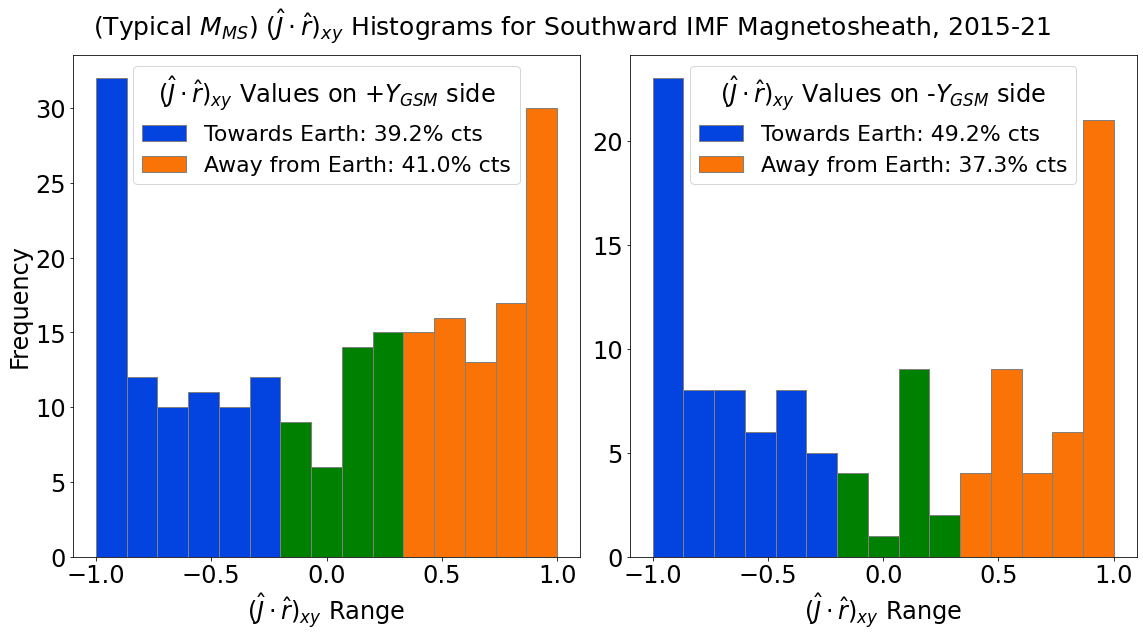

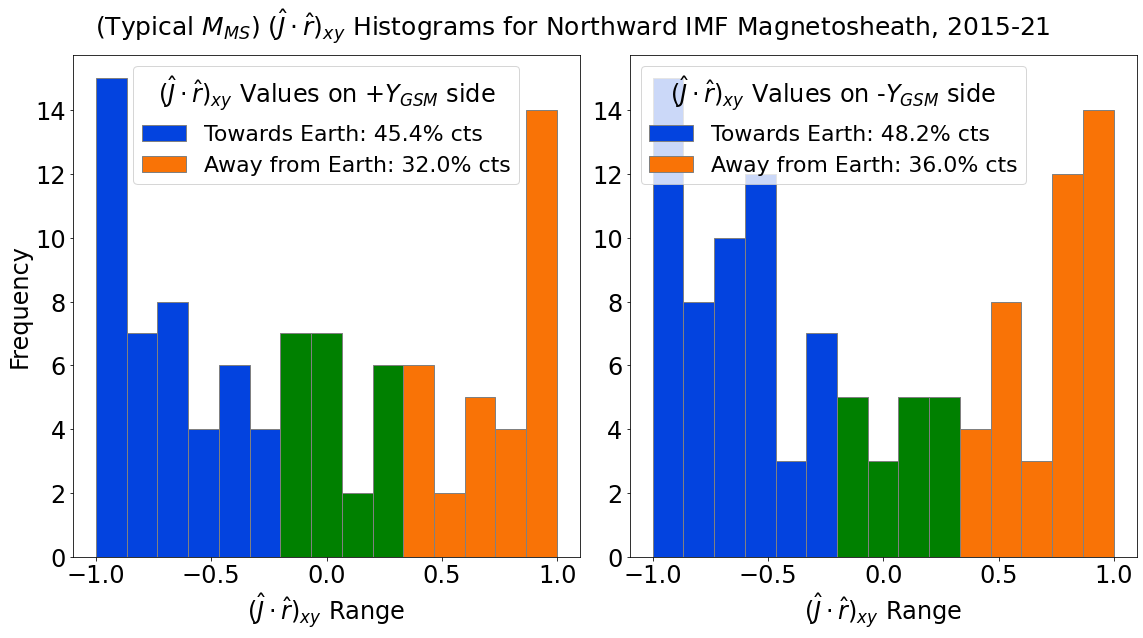

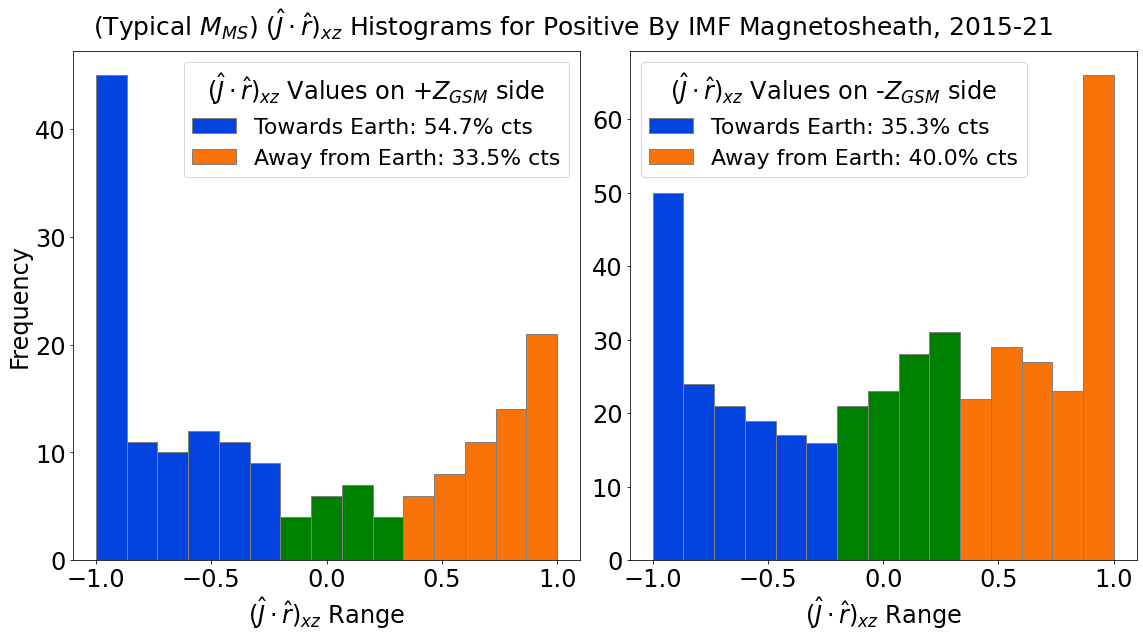

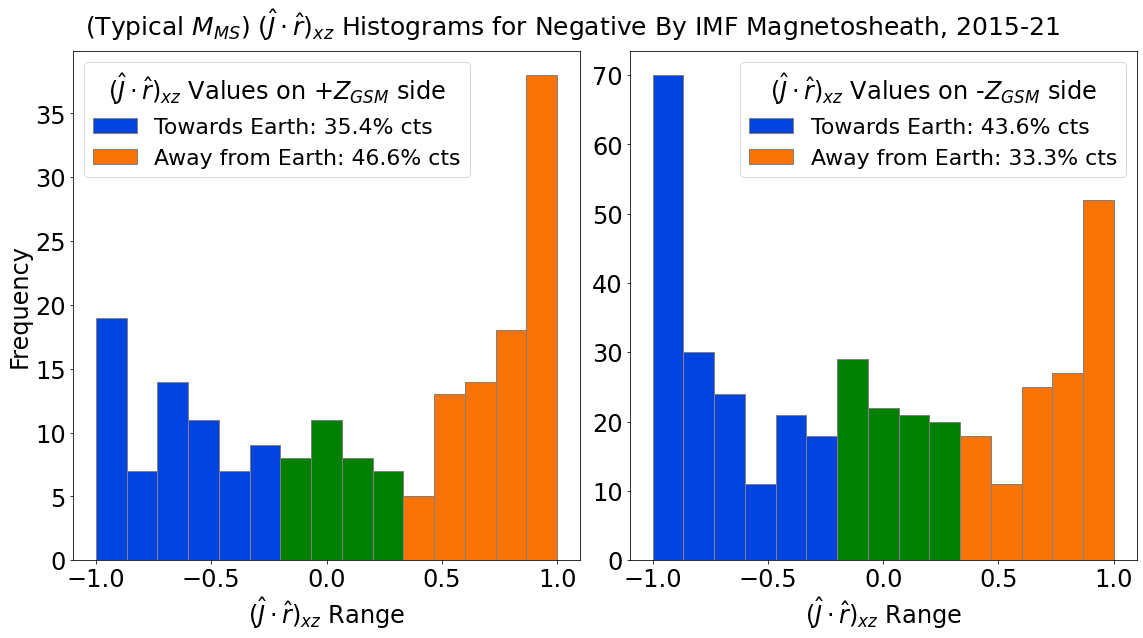

In [59]:
def hist_Sheath_curcosJdotr(df_stable, clang, achPlane, achMach):
    """With inputted CurCos2D Dataframe, make a histogram of the Zpos/Ypos vs (J.r)^ cosine angles on the xy/xz-plane"""
    print('\nHisting stuff with: ',namestr(df_stable, globals()), clang, achPlane)
    afClang = df_stable['Clang_avg'].to_numpy(copy=True)
    print('Clock Angle Range [%0.2f, %0.2f]deg'%(min(afClang), max(afClang)))
    #Define Latex string versions of J.r dot product
    jdr_xz = r'$(\hat{J}\cdot\hat{r})_{xz}$' #latex string version of J.r
    jdr_xy = r'$(\hat{J}\cdot\hat{r})_{xy}$'
    #----------------------------------------------------
    if achPlane == 'xz': #Hist Zpos vs J.r cosine angles on xz-plane
        print('Histing Z vs (Jcos)_xz and (J.r)^_xz')
        #Create DF and define explicit variables for cosine data above and below zaxis
        df_curcosFull = get_cosJ2D_DF(df_stable)
        [df_curcos_negz, df_curcos_posz] = get_curcosTopBot_DF(df_curcosFull, 'xz')
        display(df_curcosFull[:3])
        #display(df_curcos_negz[:3])
        #display(df_curcos_posz[:3])
        afPosz = df_curcos_posz['z_avg(Re)'].to_numpy(copy=True)
        afNegz = df_curcos_negz['z_avg(Re)'].to_numpy(copy=True)
        print('\tLength of cos_jxz array:',len(afClang))
        print('\tPosZ-range = %0.2f to %0.2f Re'%(min(afPosz), max(afPosz)))
        print('\tNegZ-range = %0.2f to %0.2f Re'%(min(afNegz), max(afNegz)))
        if achMach == 'lowmach': #use low Mgs Mach string
            jdr_xz_Mach = '($M_{MS}$ < 5) %s'%(jdr_xz)
        else: #use typical Mgs Mach string
            jdr_xz_Mach = '(Typical $M_{MS}$) %s'%(jdr_xz)
        ##Create histogram of J.r cosine angles on xz-plane for positive/negative z-values
        #achTitle_Z = 'Histogram of %s Dayside Sheath %s Data for $Z_{GSM}$, 2015-21'%(clang, jdr_xz)
        achTitle_Z = '%s Histograms for %s Magnetosheath, 2015-21'%(jdr_xz_Mach, clang)
        hist_curcosposneg2D(df_curcos_posz,df_curcos_negz, achTitle_Z, 'xz')
    #----------------------------------------------------
    elif achPlane == 'xy': #Hist Ypos vs J.r cosine angles on xy-plane
        print('Histing Y vs (Jcos)_xy and (J.r)^_xy')
        #Create DF and define explicit variables for cosine data above and below yaxis
        df_curcosFull = get_cosJ2D_DF(df_stable)
        [df_curcos_negy, df_curcos_posy] = get_curcosTopBot_DF(df_curcosFull, 'xy')
        display(df_curcosFull[:3])
        #display(df_curcos_negy[:3])
        #display(df_curcos_posy[:3])
        afPosy = df_curcos_posy['y_avg(Re)'].to_numpy(copy=True)
        afNegy = df_curcos_negy['y_avg(Re)'].to_numpy(copy=True)
        print('\tLength of cos_jxy array:',len(afClang))
        print('\tPosY-range = %0.2f to %0.2f Re'%(min(afPosy), max(afPosy)))
        print('\tNegY-range = %0.2f to %0.2f Re'%(min(afNegy), max(afNegy)))
        if achMach == 'lowmach': #use low Mgs Mach string
            jdr_xy_Mach = '($M_{MS}$ < 5) %s'%(jdr_xy)
        else: #use typical Mgs Mach string
            jdr_xy_Mach = '(Typical $M_{MS}$) %s'%(jdr_xy)
        #achTitle_Y = 'Histogram of %s Dayside Sheath %s Data for $Y_{GSM}$, 2015-21'%(clang, jdr_xy)
        achTitle_Y = '%s Histograms for %s Magnetosheath, 2015-21'%(jdr_xy_Mach, clang)
        hist_curcosposneg2D(df_curcos_posy,df_curcos_negy, achTitle_Y, 'xy')
    else:
        print('Invalid input')
    return;

#---------Main Calling Below----------
hist_Sheath_curcosJdotr(Sheathtrim_postMap_soBz_stabDay, 'Southward IMF', 'xy', 'n')
#plt.savefig('JdrHist_StableDaysoBz_Sheath21den120tperpLD_cosJxy_2015to21_v1', bbox_inches='tight', facecolor = 'w')

hist_Sheath_curcosJdotr(Sheathtrim_postMap_norBz_stabDay, 'Northward IMF', 'xy', 'n')
#plt.savefig('JdrHist_StableDaynorBz_Sheath21den120tperpLD_cosJxy_2015to21_v1', bbox_inches='tight', facecolor = 'w')

hist_Sheath_curcosJdotr(Sheathtrim_postMap_posBy_stabDay, 'Positive By IMF', 'xz', 'n')
#plt.savefig('JdrHist_StableDayposBy_Sheath21den120tperpLD_cosJxz_2015to21_v1', bbox_inches='tight', facecolor = 'w')

hist_Sheath_curcosJdotr(Sheathtrim_postMap_negBy_stabDay, 'Negative By IMF', 'xz', 'n')
#plt.savefig('JdrHist_StableDaynegBy_Sheath21den120tperpLD_cosJxz_2015to21_v1', bbox_inches='tight', facecolor = 'w')
#-------


#------Low Mach(Mgs <5) Jdotr Histograms---v
#hist_Sheath_curcosJdotr(Sheathtrim_postMap_5MGSsoBz_stabDay, 'Southward IMF', 'xy', 'lowmach')
#plt.savefig('JdrHist_5MGS_StableDaysoBz_Sheath21den120tperpLD_cosJxy_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#hist_Sheath_curcosJdotr(Sheathtrim_postMap_5MGSnorBz_stabDay, 'Northward IMF', 'xy', 'lowmach')
#plt.savefig('JdrHist_5MGS_StableDaynorBz_Sheath21den120tperpLD_cosJxy_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#hist_Sheath_curcosJdotr(Sheathtrim_postMap_5MGSposBy_stabDay, 'Positive By IMF', 'xz', 'lowmach')
#plt.savefig('JdrHist_5MGS_StableDayposBy_Sheath21den120tperpLD_cosJxz_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#hist_Sheath_curcosJdotr(Sheathtrim_postMap_5MGSnegBy_stabDay, 'Negative By IMF', 'xz', 'lowmach')
#plt.savefig('JdrHhist_5MGS_StableDaynegBy_Sheath21den120tperpLD_cosJxz_2015to21_v1', bbox_inches='tight', facecolor = 'w')


* Histogramming |J|cos and cos_J2D Percent Data for Above/Below the Y/Z Axis using **PostMap SG-Filtered Sheath Only** Stable IMFs


Histing stuff with:  ['Sheath_5MGSstabDaynegBy_jcospercent'] ($M_{MS}$ < 5) negBy IMF xz
Clock Angle Range [225.69, 314.89]deg
Histing Z vs (Jcos)_xz and (J.r)^_xz Percents
		Confirmed: +Z cos_xz DF was created and contains (z>=0) array: True
		Confirmed: -Z cos_xz DF was created and contains (z<0) array: True


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,gseIMFBx_avg(nT),gseIMFBy_avg(nT),gseIMFBz_avg(nT),...,Jcosxy_avg,Jcosxy_med,"cosxy_pos(0.25,%)","cosxy_neg(0.25,%)",Jcosxz_pos(%),Jcosxz_neg(%),Jcosxz_avg,Jcosxz_med,"cosxz_pos(0.25,%)","cosxz_neg(0.25,%)"
0,2015-10-01 15:00:00,2015-10-01 15:10:00,11.867573,5.909205,8.859622,-5.236950,242.070,0.212,-5.662,-8.173,...,-0.007755,-0.007844,6.834757,75.046885,61.294020,38.705980,0.001380,0.001887,43.988331,26.182538
1,2015-10-01 15:30:00,2015-10-01 15:40:00,11.766318,5.618472,8.995279,-5.095276,243.791,0.688,-6.168,-8.113,...,-0.010391,-0.009545,6.157533,83.819546,54.375912,45.624088,0.001482,0.000943,37.924568,30.172953
2,2015-10-17 11:55:00,2015-10-17 12:05:00,12.004703,8.882044,6.583804,-4.676993,266.403,3.707,-5.415,-3.723,...,-0.000313,-0.001573,36.482967,47.463277,42.931555,57.068445,-0.000256,-0.000950,30.649026,44.421294


	Length of cos_jxz array: 211
	PosZ-range = 0.13 to 6.03 Re
	NegZ-range = -9.72 to -0.09 Re
Histing and Plotting For +Z cos_xz and Jcos_xz Percent DFs:
Histing and Plotting For -Z cos_xz and Jcos_xz Percent DFs:


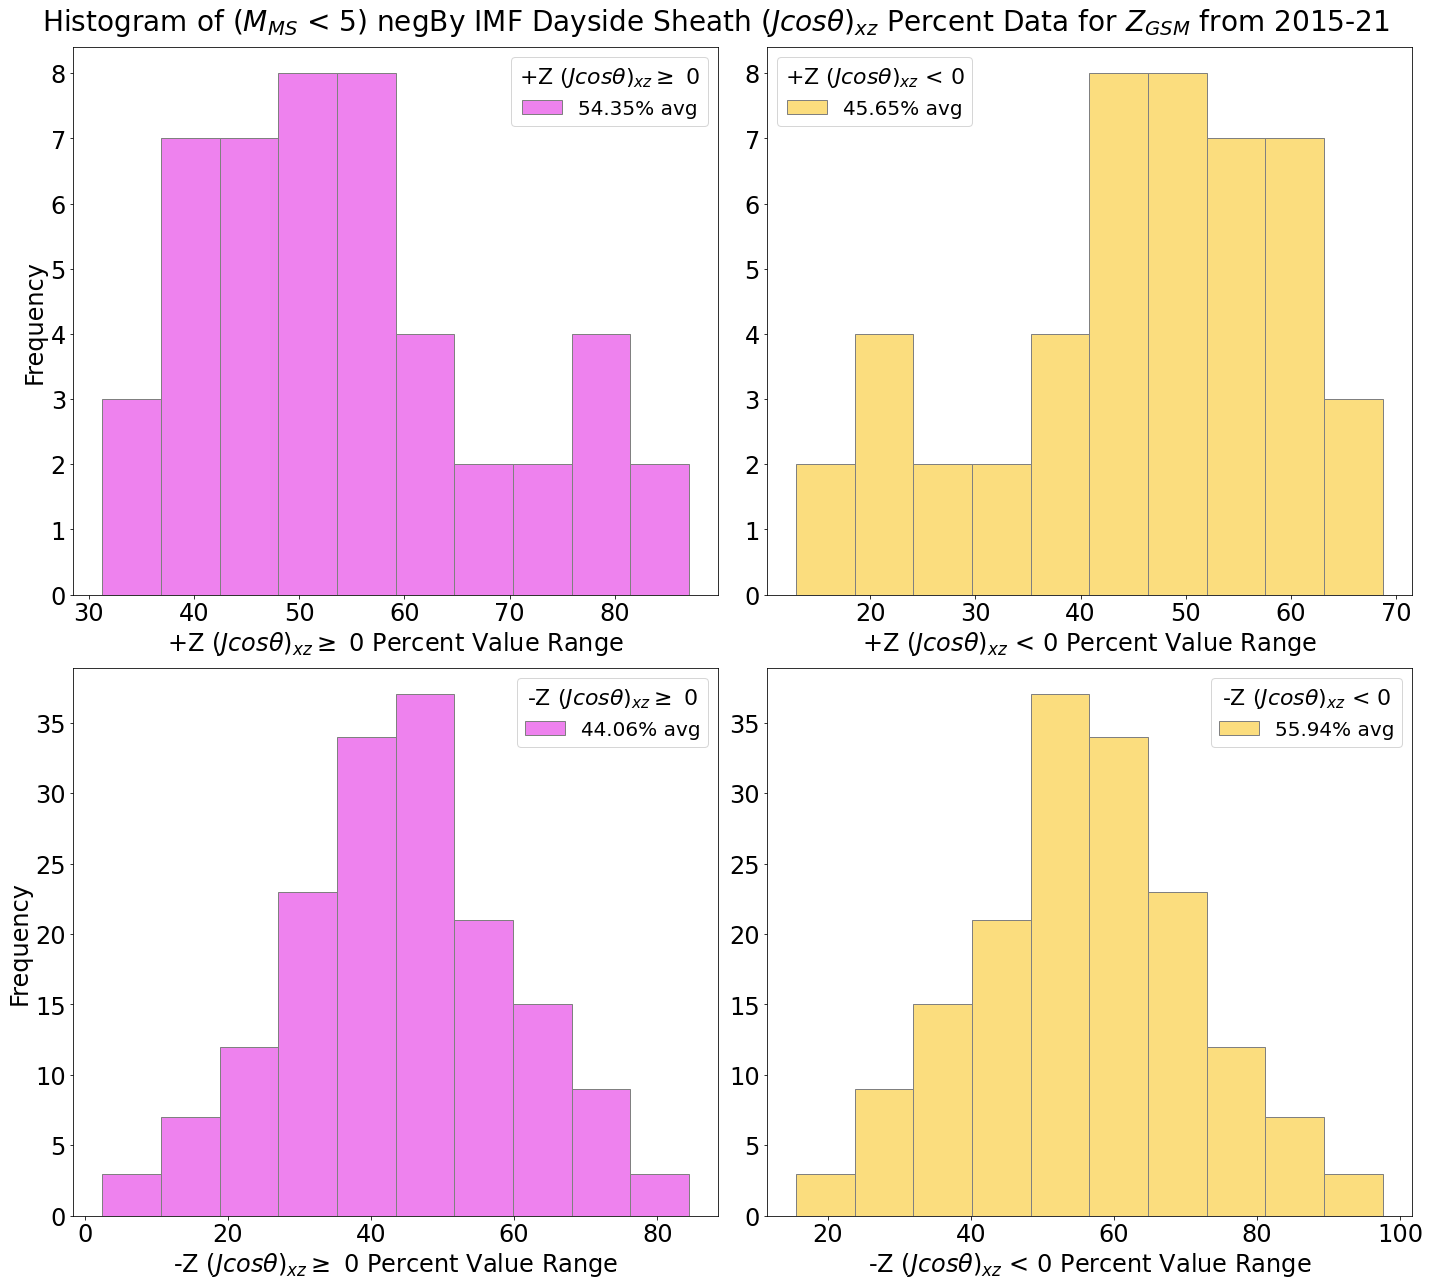

In [43]:
def hist_curcospercent2D(df_cos_pos,df_cos_neg, achTitle, achPlane):
    """Based on inputted cosine data for postive/negative z/y-values. Create histogram of (Jcos_xz,cos_Jxz) or
    (Jcos_xy, cos_Jxy) cosine percent data(towards/away from Earth)"""
    ##Create subplot parameters
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (20, 18)) #setting size of subplots
    #fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize = (30, 18)) #setting size of subplots
    fig.suptitle(achTitle, y =0.99,fontsize = 28) #single title over multiple subplots
    """For 1x2 Subplots: figsize = (15,10), title size =24, axis label/tick size = 20, legend font = 18
    For 2x2 Subplots: figsize = (20,22), title size =28, axis label/tick size = 24, legend font = 22
    For 2x3 Subplots: figsize = (25,18), title size = 28, axis label/ticksize = 24, legfont = 20
    For 2x4 subplots: figsize = (30,18), title size = 28, axis label/ticksize = 24, legend font = 20"""
    fsize = 24 #fontsize of axis labels/ticks
    legsize = 22 #legend fontsize
    bin_num = 10 #number of bins******(15bins is what I used to export)
    jcs_xz = r'$(Jcos\theta)_{xz}$' #latex string version of 2D Jcos
    jcs_geq_xz = r'$(Jcos\theta)_{xz} \geq$'
    jcs_xy = r'$(Jcos\theta)_{xy}$'
    jcs_geq_xy = r'$(Jcos\theta)_{xy} \geq$'
    if achPlane == 'xz': #Make histogram on xz plane
        afJcos_PZposperc = df_cos_pos['Jcosxz_pos(%)'].to_numpy(copy=True)
        afJcos_PZnegperc = df_cos_pos['Jcosxz_neg(%)'].to_numpy(copy=True)
        afCos_PZposperc = df_cos_pos['cosxz_pos(0.25,%)'].to_numpy(copy=True)
        afCos_PZnegperc = df_cos_pos['cosxz_neg(0.25,%)'].to_numpy(copy=True)
        #----Create J.r cosine angles hist and other plots on xz-plane for +Z values--------------------------
        print('Histing and Plotting For +Z cos_xz and Jcos_xz Percent DFs:')
        n_jpz_pos, bins_jpz_pos, patch_jpz_pos = ax1.hist(afJcos_PZposperc,bins=bin_num, fc = 'violet', ec='grey', label = '%0.2f%% avg'%(np.nanmean(afJcos_PZposperc)))
        ax1.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        ax1.set_ylabel('Frequency', fontsize = fsize)
        ax1.set_xlabel('+Z %s 0 Percent Value Range'%(jcs_geq_xz), fontsize = fsize)#, loc = 'right')
        ax1.legend(title = '+Z %s 0'%(jcs_geq_xz), title_fontsize = legsize, loc = 'best', prop={'size': legsize-2})
        n_jpz_neg, bins_jpz_neg, patch_jpz_neg = ax2.hist(afJcos_PZnegperc,bins=bin_num,fc ='xkcd:wheat', ec='grey', label = '%0.2f%% avg'%(np.nanmean(afJcos_PZnegperc)))
        ax2.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        #ax2.set_ylabel('Frequency', fontsize = fsize)
        ax2.set_xlabel('+Z %s < 0 Percent Value Range'%(jcs_xz), fontsize = fsize)#, loc = 'right'
        ax2.legend(title = '+Z %s < 0'%(jcs_xz), title_fontsize = legsize, loc = 'best', prop={'size': legsize-2})
            #+Z Percents of (Jcos)_xz[Above] and (J.r)^_xz[Below]
        '''
        n_cpz_pos, bins_cpz_pos, patch_cpz_pos = ax3.hist(afCos_PZposperc,bins=bin_num, fc = 'm',ec='grey', label = '%0.2f%% avg'%(np.nanmean(afCos_PZposperc)))
        ax3.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        ax3.set_ylabel('Frequency', fontsize = fsize)
        ax3.set_xlabel('+Z (J.r)^_xz >= 0.25 Percent Value Range', fontsize = fsize)#, loc = 'right')
        ax3.legend(title = '+Z (J.r)^_xz >= 0.25', title_fontsize = legsize, loc = 'best', prop={'size': legsize-2})
        n_cpz_neg, bins_cpz_neg, patch_cpz_neg = ax4.hist(afCos_PZnegperc,bins=bin_num,fc ='y', ec='grey', label = '%0.2f%% avg'%(np.nanmean(afCos_PZnegperc)))
        ax4.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        #ax2.set_ylabel('Frequency', fontsize = fsize)
        ax4.set_xlabel('+Z (J.r)^_xz < -0.25 Percent Value Range', fontsize = fsize)#, loc = 'right'
        ax4.legend(title = '+Z (J.r)^_xz < -0.25', title_fontsize = legsize, loc = 'best', prop={'size': legsize-2})
        ''';
        #----Create J.r cosine angles hist and other plots on xz-plane for -Z values--------------------------
        afJcos_NZposperc = df_cos_neg['Jcosxz_pos(%)'].to_numpy(copy=True)
        afJcos_NZnegperc = df_cos_neg['Jcosxz_neg(%)'].to_numpy(copy=True)
        afCos_NZposperc = df_cos_neg['cosxz_pos(0.25,%)'].to_numpy(copy=True)
        afCos_NZnegperc = df_cos_neg['cosxz_neg(0.25,%)'].to_numpy(copy=True)
        print('Histing and Plotting For -Z cos_xz and Jcos_xz Percent DFs:')
        n_jnz_pos, bins_jnz_pos, patch_jnz_pos = ax3.hist(afJcos_NZposperc,bins=bin_num,fc = 'violet',ec='grey', label = '%0.2f%% avg'%(np.nanmean(afJcos_NZposperc)))
        ax3.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        ax3.set_ylabel('Frequency', fontsize = fsize)
        ax3.set_xlabel('-Z %s 0 Percent Value Range'%(jcs_geq_xz), fontsize = fsize)#, loc = 'right')
        ax3.legend(title = '-Z %s 0'%(jcs_geq_xz), title_fontsize = legsize, loc = 'best', prop={'size': legsize-2})
        n_jnz_neg, bins_jnz_neg, patch_jnz_neg = ax4.hist(afJcos_NZnegperc,bins=bin_num,fc ='xkcd:wheat', ec='grey', label = '%0.2f%% avg'%(np.nanmean(afJcos_NZnegperc)))
        ax4.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        #ax2.set_ylabel('Frequency', fontsize = fsize)
        ax4.set_xlabel('-Z %s < 0 Percent Value Range'%(jcs_xz), fontsize = fsize)#, loc = 'right'
        ax4.legend(title = '-Z %s < 0'%(jcs_xz), title_fontsize = legsize, loc = 'best', prop={'size': legsize-2})
            #-Z Percents of (Jcos)_xz[Above] and (J.r)^_xz[Below]
        '''
        n_cnz_pos, bins_cnz_pos, patch_cnz_pos = ax7.hist(afCos_NZposperc,bins=bin_num,fc = 'm', ec='grey', label = '%0.2f%% avg'%(np.nanmean(afCos_NZposperc)))
        ax7.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        ax7.set_ylabel('Frequency', fontsize = fsize)
        ax7.set_xlabel('-Z (J.r)^_xz >= 0.25 Percent Value Range', fontsize = fsize)#, loc = 'right')
        ax7.legend(title = '-Z (J.r)^_xz >= 0.25', title_fontsize = legsize, loc = 'best', prop={'size': legsize-2})
        n_cnz_neg, bins_cnz_neg, patch_cnz_neg = ax8.hist(afCos_NZnegperc,bins=bin_num,fc ='y', ec='grey', label = '%0.2f%% avg'%(np.nanmean(afCos_NZnegperc)))
        ax8.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        #ax2.set_ylabel('Frequency', fontsize = fsize)
        ax8.set_xlabel('-Z (J.r)^_xz < -0.25 Percent Value Range', fontsize = fsize)#, loc = 'right'
        ax8.legend(title = '-Z (J.r)^_xz < -0.25', title_fontsize = legsize, loc = 'best', prop={'size': legsize-2})
        ''';
        plt.tight_layout() #ensures subplots don't overlap
    #------------------------XY Histogram
    elif achPlane == 'xy': #Make histogram on xy plane
        afJcos_PYposperc = df_cos_pos['Jcosxy_pos(%)'].to_numpy(copy=True)
        afJcos_PYnegperc = df_cos_pos['Jcosxy_neg(%)'].to_numpy(copy=True)
        afCos_PYposperc = df_cos_pos['cosxy_pos(0.25,%)'].to_numpy(copy=True)
        afCos_PYnegperc = df_cos_pos['cosxy_neg(0.25,%)'].to_numpy(copy=True)
        #----Create J.r cosine angles hist and other plots on xy-plane for +Y values--------------------------
        print('Histing and Plotting For +Y cos_xy and Jcos_xy Percent DFs:')
        n_jpy_pos, bins_jpy_pos, patch_jpy_pos = ax1.hist(afJcos_PYposperc,bins=bin_num,fc = 'violet', ec='grey', label = '%0.2f%% avg'%(np.nanmean(afJcos_PYposperc)))
        ax1.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        ax1.set_ylabel('Frequency', fontsize = fsize)
        ax1.set_xlabel('+Y %s 0 Percent Value Range'%(jcs_geq_xy), fontsize = fsize)#, loc = 'right')
        ax1.legend(title = '+Y %s 0'%(jcs_geq_xy), title_fontsize = legsize, loc = 'best', prop={'size': legsize-2})
        n_jpy_neg, bins_jpy_neg, patch_jpy_neg = ax2.hist(afJcos_PYnegperc,bins=bin_num,fc ='xkcd:wheat', ec='grey', label = '%0.2f%% avg'%(np.nanmean(afJcos_PYnegperc)))
        ax2.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        #ax2.set_ylabel('Frequency', fontsize = fsize)
        ax2.set_xlabel('+Y %s < 0 Percent Value Range'%(jcs_xy), fontsize = fsize)#, loc = 'right') 
        ax2.legend(title = '+Y %s < 0'%(jcs_xy), title_fontsize = legsize, loc = 'best', prop={'size': legsize-2})
            #+Y Percents of (Jcos)_xy[Above] and (J.r)^_xy[Below] 
        '''
        n_cpy_pos, bins_cpy_pos, patch_cpy_pos = ax3.hist(afCos_PYposperc,bins=bin_num,fc = 'm', ec='grey', label = '%0.2f%% avg'%(np.nanmean(afCos_PYposperc)))
        ax3.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        ax3.set_ylabel('Frequency', fontsize = fsize)
        ax3.set_xlabel('+Y (J.r)^_xy >= 0.25 Percent Value Range', fontsize = fsize)#, loc = 'right')
        ax3.legend(title = '+Y (J.r)^_xy >= 0.25', title_fontsize = legsize, loc = 'best', prop={'size': legsize-2})
        n_cpy_neg, bins_cpy_neg, patch_cpy_neg = ax4.hist(afCos_PYnegperc,bins=bin_num,fc ='y', ec='grey', label = '%0.2f%% avg'%(np.nanmean(afCos_PYnegperc)))
        ax4.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        #ax2.set_ylabel('Frequency', fontsize = fsize)
        ax4.set_xlabel('+Y (J.r)^_xy < -0.25 Percent Value Range', fontsize = fsize)#, loc = 'right'
        ax4.legend(title = '+Y (J.r)^_xy < -0.25', title_fontsize = legsize, loc = 'best', prop={'size': legsize-2})
        ''';
        #----Create J.r cosine angles hist and other plots on xy-plane for -Y values--------------------------
        afJcos_NYposperc = df_cos_neg['Jcosxy_pos(%)'].to_numpy(copy=True)
        afJcos_NYnegperc = df_cos_neg['Jcosxy_neg(%)'].to_numpy(copy=True)
        afCos_NYposperc = df_cos_neg['cosxy_pos(0.25,%)'].to_numpy(copy=True)
        afCos_NYnegperc = df_cos_neg['cosxy_neg(0.25,%)'].to_numpy(copy=True)
        print('Histing and Plotting For -Y cos_xy and Jcos_xy Percent DFs:')
        n_jny_pos, bins_jny_pos, patch_jny_pos = ax3.hist(afJcos_NYposperc,bins=bin_num,fc = 'violet', ec='grey', label = '%0.2f%% avg'%(np.nanmean(afJcos_NYposperc)))
        ax3.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        ax3.set_ylabel('Frequency', fontsize = fsize)
        ax3.set_xlabel('-Y %s 0 Percent Value Range'%(jcs_geq_xy), fontsize = fsize)#, loc = 'right')
        ax3.legend(title = '-Y %s 0'%(jcs_geq_xy), title_fontsize = legsize, loc = 'best', prop={'size': legsize-2})
        n_jny_neg, bins_jny_neg, patch_jny_neg = ax4.hist(afJcos_NYnegperc,bins=bin_num,fc ='xkcd:wheat', ec='grey', label = '%0.2f%% avg'%(np.nanmean(afJcos_NYnegperc)))
        ax4.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        #ax2.set_ylabel('Frequency', fontsize = fsize)
        ax4.set_xlabel('-Y %s < 0 Percent Value Range'%(jcs_xy), fontsize = fsize)#, loc = 'right'
        ax4.legend(title = '-Y %s < 0'%(jcs_xy), title_fontsize = legsize, loc = 'best', prop={'size': legsize-2})
            #-Y Percents of (Jcos)_xy[Above] and (J.r)^_xy[Below] 
        '''
        n_cny_pos, bins_cny_pos, patch_cny_pos = ax7.hist(afCos_NYposperc,bins=bin_num,fc = 'm', ec='grey', label = '%0.2f%% avg'%(np.nanmean(afCos_NYposperc)))
        ax7.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        ax7.set_ylabel('Frequency', fontsize = fsize)
        ax7.set_xlabel('-Y (J.r)^_xy >= 0.25 Percent Value Range', fontsize = fsize)#, loc = 'right')
        ax7.legend(title = '-Y (J.r)^_xy >= 0.25', title_fontsize = legsize, loc = 'best', prop={'size': legsize-2})
        n_cny_neg, bins_cny_neg, patch_cny_neg = ax8.hist(afCos_NYnegperc,bins=bin_num,fc ='y', ec='grey', label = '%0.2f%% avg'%(np.nanmean(afCos_NYnegperc)))
        ax8.tick_params(axis='both', labelsize=fsize) #setting labelsize for both axis ticks
        #ax2.set_ylabel('Frequency', fontsize = fsize)
        ax8.set_xlabel('-Y (J.r)^_xy < -0.25 Percent Value Range', fontsize = fsize)#, loc = 'right'
        ax8.legend(title = '-Y (J.r)^_xy < -0.25', title_fontsize = legsize, loc = 'best', prop={'size': legsize-2})
        ''';
        plt.tight_layout() #ensures subplots don't overlap        
    return;


def hist_curJcospercents(df_curcos, clang, achPlane):
    """With inputted CurCos2D_withpercents Dataframe, make a histogram of the Zpos/Ypos vs 
    |J|cos and (J.r)^ cosine angle percent values(towards/away from Earth) on the xy/xz-plane"""
    print('\nHisting stuff with: ',namestr(df_curcos, globals()), clang, achPlane)
    afClang = df_curcos['Clang_avg'].to_numpy(copy=True)
    print('Clock Angle Range [%0.2f, %0.2f]deg'%(min(afClang), max(afClang)))
    #Define Latex string versions of J.r dot product
    jdr_xz = r'$(\hat{J}\cdot\hat{r})_{xz}$' #latex string version of J.r
    jcs_xz = r'$(Jcos\theta)_{xz}$'
    jdr_xy = r'$(\hat{J}\cdot\hat{r})_{xy}$'
    jcs_xy = r'$(Jcos\theta)_{xy}$'
    #----------------------------------------------------
    if achPlane == 'xz': #Hist Zpos vs J.r cosine angles on xz-plane
        print('Histing Z vs (Jcos)_xz and (J.r)^_xz Percents')
        #Create DF and define explicit variables for cosine data above and below zaxis
        [df_curcos_negz, df_curcos_posz] = get_curcosTopBot_DF(df_curcos, 'xz')
        display(df_curcos[:3])
        #display(df_curcos_negz[:3])
        #display(df_curcos_posz[:3])
        afPosz = df_curcos_posz['z_avg(Re)'].to_numpy(copy=True)
        afNegz = df_curcos_negz['z_avg(Re)'].to_numpy(copy=True)
        print('\tLength of cos_jxz array:',len(afClang))
        print('\tPosZ-range = %0.2f to %0.2f Re'%(min(afPosz), max(afPosz)))
        print('\tNegZ-range = %0.2f to %0.2f Re'%(min(afNegz), max(afNegz)))
        ##Create histogram of J.r cosine angles on xz-plane for positive/negative z-values
        achTitle_Z = 'Histogram of %s Dayside Sheath %s Percent Data for $Z_{GSM}$ from 2015-21'%(clang, jcs_xz)
        hist_curcospercent2D(df_curcos_posz,df_curcos_negz, achTitle_Z, 'xz')
    #----------------------------------------------------
    elif achPlane == 'xy': #Hist Ypos vs J.r cosine angles on xy-plane
        print('Histing Y vs (Jcos)_xy and (J.r)^_xy Percents')
        #Create DF and define explicit variables for cosine data above and below yaxis
        [df_curcos_negy, df_curcos_posy] = get_curcosTopBot_DF(df_curcos, 'xy')
        display(df_curcos[:3])
        #display(df_curcos_negy[:3])
        #display(df_curcos_posy[:3])
        afPosy = df_curcos_posy['y_avg(Re)'].to_numpy(copy=True)
        afNegy = df_curcos_negy['y_avg(Re)'].to_numpy(copy=True)
        print('\tLength of cos_jxy array:',len(afClang))
        print('\tPosY-range = %0.2f to %0.2f Re'%(min(afPosy), max(afPosy)))
        print('\tNegY-range = %0.2f to %0.2f Re'%(min(afNegy), max(afNegy)))
        achTitle_Y = 'Histogram of %s Dayside Sheath %s Percent Data for $Y_{GSM}$ from 2015-21'%(clang, jcs_xy)
        hist_curcospercent2D(df_curcos_posy,df_curcos_negy, achTitle_Y, 'xy')
        # (Jcos)_2D > 0  Percent Value Range and (J.r)^ > 0 Percent Value Range
    else:
        print('Invalid input')
    return;

#---------Main Calling Below----------

#hist_curJcospercents(Sheath_stabDaysoBz_jcospercent, 'soBz IMF', 'xy')
#plt.savefig('HistPlot_StableDaysoBz_Sheath21den120tperpLD_cosJxyPercent_2015to21_v4', bbox_inches='tight', facecolor = 'w')

#hist_curJcospercents(Sheath_stabDaynorBz_jcospercent, 'norBz IMF', 'xy')
#plt.savefig('HistPlot_StableDaynorBz_Sheath21den120tperpLD_cosJxyPercent_2015to21_v4', bbox_inches='tight', facecolor = 'w')

#hist_curJcospercents(Sheath_stabDayposBy_jcospercent, 'posBy IMF', 'xz')
#plt.savefig('HistPlot_StableDayposBy_Sheath21den120tperpLD_cosJxzPercent_2015to21_v4', bbox_inches='tight', facecolor = 'w')

#hist_curJcospercents(Sheath_stabDaynegBy_jcospercent, 'negBy IMF', 'xz')
#plt.savefig('HistPlot_StableDaynegBy_Sheath21den120tperpLD_cosJxzPercent_2015to21_v4', bbox_inches='tight', facecolor = 'w')
#--------
#hist_curJcospercents(Sheath_5MGSstabDaysoBz_jcospercent, '%s soBz IMF'%(achMach5), 'xy')
#plt.savefig('HistPlot_5MGS_StableDaysoBz_Sheath21den120tperpLD_cosJxyPercent_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#hist_curJcospercents(Sheath_5MGSstabDaynorBz_jcospercent, '%s norBz IMF'%(achMach5), 'xy')
#plt.savefig('HistPlot_5MGS_StableDaynorBz_Sheath21den120tperpLD_cosJxyPercent_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#hist_curJcospercents(Sheath_5MGSstabDayposBy_jcospercent, '%s posBy IMF'%(achMach5), 'xz')
#plt.savefig('HistPlot_5MGS_StableDayposBy_Sheath21den120tperpLD_cosJxzPercent_2015to21_v1', bbox_inches='tight', facecolor = 'w')

hist_curJcospercents(Sheath_5MGSstabDaynegBy_jcospercent, '%s negBy IMF'%(achMach5), 'xz')
#plt.savefig('HistPlot_5MGS_StableDaynegBy_Sheath21den120tperpLD_cosJxzPercent_2015to21_v1', bbox_inches='tight', facecolor = 'w')


## Section 7: Recreating Maps and Histograms after Categorizing Events by Quasi-Perp and Quasi-Parallel Shock Events
* From `Stable IMF Event Searchin_with Shock Angle` script, we shall import the 2015-21 Stable IMFnShockAng DFs. By matching startdates, Shock Normal Angle columns to the PostMap DFs.
    * After appending the ShockAngle columns, we'll create 2 new DFs that are categorized by quasi-perp and quasi-parallel shock events:
       * quasi-perp shock: $\theta_{bn} \geq 45^o$
       * quasi-parallel shock: $\theta_{bn} < 45^o$
* With these new shock angle sorted DFs, we shall recreate the Jdotr maps, IonDen&Vx Hists, Sheath cosine Hists, and Sheath curcos percent hists

---
### Section 7.1a: Loading up 2015-21 Stable IMFnShockAng DF Lists


In [44]:
#'''
print('Importing Last10m Stable Dayside IMF soBznShang DFs(2015-21):')
df_DaysoBzShang_L10_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_soBzShang_trange_Last10m/pdFile_StabDayNOSL_last10m_soBzShang_Yr1_v1.txt', sep = '\t')
df_DaysoBzShang_L10_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_soBzShang_trange_Last10m/pdFile_StabDayNOSL_last10m_soBzShang_Yr2_v1.txt', sep = '\t')
df_DaysoBzShang_L10_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_soBzShang_trange_Last10m/pdFile_StabDayNOSL_last10m_soBzShang_Yr3_v1.txt', sep = '\t')
df_DaysoBzShang_L10_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_soBzShang_trange_Last10m/pdFile_StabDayNOSL_last10m_soBzShang_Yr4_v1.txt', sep = '\t')
df_DaysoBzShang_L10_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_soBzShang_trange_Last10m/pdFile_StabDayNOSL_last10m_soBzShang_Yr5_v1.txt', sep = '\t')
df_DaysoBzShang_L10_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_soBzShang_trange_Last10m/pdFile_StabDayNOSL_last10m_soBzShang_Yr6_v1.txt', sep = '\t')

#display(df_DaysoBzShang_L10_yr1)
#show1to6DF(df_DaysoBzShang_L10_yr1, df_DaysoBzShang_L10_yr2, df_DaysoBzShang_L10_yr3, df_DaysoBzShang_L10_yr4, df_DaysoBzShang_L10_yr5, df_DaysoBzShang_L10_yr6)
#--
print('Importing Last10m Stable Dayside IMF norBznShang DFs(2015-21):')
df_DaynorBzShang_L10_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_norBzShang_trange_Last10m/pdFile_StabDayNOSL_last10m_norBzShang_Yr1_v1.txt', sep = '\t')
df_DaynorBzShang_L10_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_norBzShang_trange_Last10m/pdFile_StabDayNOSL_last10m_norBzShang_Yr2_v1.txt', sep = '\t')
df_DaynorBzShang_L10_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_norBzShang_trange_Last10m/pdFile_StabDayNOSL_last10m_norBzShang_Yr3_v1.txt', sep = '\t')
df_DaynorBzShang_L10_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_norBzShang_trange_Last10m/pdFile_StabDayNOSL_last10m_norBzShang_Yr4_v1.txt', sep = '\t')
df_DaynorBzShang_L10_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_norBzShang_trange_Last10m/pdFile_StabDayNOSL_last10m_norBzShang_Yr5_v1.txt', sep = '\t')
df_DaynorBzShang_L10_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_norBzShang_trange_Last10m/pdFile_StabDayNOSL_last10m_norBzShang_Yr6_v1.txt', sep = '\t')

#show1to6DF(df_DaynorBzShang_L10_yr1, df_DaynorBzShang_L10_yr2, df_DaynorBzShang_L10_yr3, df_DaynorBzShang_L10_yr4, df_DaynorBzShang_L10_yr5, df_DaynorBzShang_L10_yr6)
#--
print('Importing Last10m Stable Dayside IMF posBynShang DFs(2015-21):')
df_DayposByShang_L10_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_posByShang_trange_Last10m/pdFile_StabDayNOSL_last10m_posByShang_Yr1_v1.txt', sep = '\t')
df_DayposByShang_L10_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_posByShang_trange_Last10m/pdFile_StabDayNOSL_last10m_posByShang_Yr2_v1.txt', sep = '\t')
df_DayposByShang_L10_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_posByShang_trange_Last10m/pdFile_StabDayNOSL_last10m_posByShang_Yr3_v1.txt', sep = '\t')
df_DayposByShang_L10_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_posByShang_trange_Last10m/pdFile_StabDayNOSL_last10m_posByShang_Yr4_v1.txt', sep = '\t')
df_DayposByShang_L10_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_posByShang_trange_Last10m/pdFile_StabDayNOSL_last10m_posByShang_Yr5_v1.txt', sep = '\t')
df_DayposByShang_L10_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_posByShang_trange_Last10m/pdFile_StabDayNOSL_last10m_posByShang_Yr6_v1.txt', sep = '\t')

#show1to6DF(df_DayposByShang_L10_yr1, df_DayposByShang_L10_yr2, df_DayposByShang_L10_yr3, df_DayposByShang_L10_yr4, df_DayposByShang_L10_yr5, df_DayposByShang_L10_yr6)
#--
print('Importing Last10m Stable Dayside IMF negBynShang DFs(2015-21):')
df_DaynegByShang_L10_yr1 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_negByShang_trange_Last10m/pdFile_StabDayNOSL_last10m_negByShang_Yr1_v1.txt', sep = '\t')
df_DaynegByShang_L10_yr2 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_negByShang_trange_Last10m/pdFile_StabDayNOSL_last10m_negByShang_Yr2_v1.txt', sep = '\t')
df_DaynegByShang_L10_yr3 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_negByShang_trange_Last10m/pdFile_StabDayNOSL_last10m_negByShang_Yr3_v1.txt', sep = '\t')
df_DaynegByShang_L10_yr4 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_negByShang_trange_Last10m/pdFile_StabDayNOSL_last10m_negByShang_Yr4_v1.txt', sep = '\t')
df_DaynegByShang_L10_yr5 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_negByShang_trange_Last10m/pdFile_StabDayNOSL_last10m_negByShang_Yr5_v1.txt', sep = '\t')
df_DaynegByShang_L10_yr6 = pd.read_csv(r'/Users/salinasha/Desktop/MacBoo Codes/Space Physics Codes/Under pySPEDAS_venv/'
'Exported_trangeList_Last10min/StabDay_negByShang_trange_Last10m/pdFile_StabDayNOSL_last10m_negByShang_Yr6_v1.txt', sep = '\t')

#show1to6DF(df_DaynegByShang_L10_yr1, df_DaynegByShang_L10_yr2, df_DaynegByShang_L10_yr3, df_DaynegByShang_L10_yr4, df_DaynegByShang_L10_yr5, df_DaynegByShang_L10_yr6)
#--

Importing Last10m Stable Dayside IMF soBznShang DFs(2015-21):
Importing Last10m Stable Dayside IMF norBznShang DFs(2015-21):
Importing Last10m Stable Dayside IMF posBynShang DFs(2015-21):
Importing Last10m Stable Dayside IMF negBynShang DFs(2015-21):


* Defining concatenated(2015-21) Day Stable IMFnShang Last10m DFs

In [45]:
#--concatenating 2015-21 Stable IMFnShang Last10m IMF DF 
print('\n--Creating Dayside 2015-21 Stable soBz&Shang trange DF')
df_DaysoBzShang_2015to21 = df_day_combine1to6(df_DaysoBzShang_L10_yr1, df_DaysoBzShang_L10_yr2, 
       df_DaysoBzShang_L10_yr3, df_DaysoBzShang_L10_yr4, df_DaysoBzShang_L10_yr5, df_DaysoBzShang_L10_yr6)    

display(df_DaysoBzShang_2015to21)


print('\n--Creating Dayside 2015-21 Stable norBz&Shang trange DF')
df_DaynorBzShang_2015to21 = df_day_combine1to6(df_DaynorBzShang_L10_yr1, df_DaynorBzShang_L10_yr2, 
       df_DaynorBzShang_L10_yr3, df_DaynorBzShang_L10_yr4, df_DaynorBzShang_L10_yr5, df_DaynorBzShang_L10_yr6)    

display(df_DaynorBzShang_2015to21)

print('\n--Creating Dayside 2015-21 Stable posBy&Shang trange DF')
df_DayposByShang_2015to21 = df_day_combine1to6(df_DayposByShang_L10_yr1, df_DayposByShang_L10_yr2, 
       df_DayposByShang_L10_yr3, df_DayposByShang_L10_yr4, df_DayposByShang_L10_yr5, df_DayposByShang_L10_yr6)    

display(df_DayposByShang_2015to21)

print('\n--Creating Dayside 2015-21 Stable negBy&Shang trange DF')
df_DaynegByShang_2015to21 = df_day_combine1to6(df_DaynegByShang_L10_yr1, df_DaynegByShang_L10_yr2, 
       df_DaynegByShang_L10_yr3, df_DaynegByShang_L10_yr4, df_DaynegByShang_L10_yr5, df_DaynegByShang_L10_yr6)    

display(df_DaynegByShang_2015to21)


--Creating Dayside 2015-21 Stable soBz&Shang trange DF
	DF inputs:
 ['df_DaysoBzShang_L10_yr1'] ['df_DaysoBzShang_L10_yr2'] ['df_DaysoBzShang_L10_yr3'] 
 ['df_DaysoBzShang_L10_yr4'] ['df_DaysoBzShang_L10_yr5'] ['df_DaysoBzShang_L10_yr6']
	Yrs1-6 Concatenation: Complete


,Start_str,End_str,Clang_avg,omniBxGSE_avg(nT),omniByGSE_avg(nT),omniBzGSE_avg(nT),Shock_Ang(deg),omniVsw_avg(km/s)
0,2015-09-01 10:05:00,2015-09-01 10:15:00,207.444,2.597,0.285,-4.150,61.588,354.950
1,2015-09-01 11:40:00,2015-09-01 11:50:00,199.455,4.862,0.427,-1.862,25.138,345.500
2,2015-09-05 12:45:00,2015-09-05 12:55:00,138.909,-4.443,3.462,-1.105,37.015,450.517
3,2015-09-07 18:00:00,2015-09-07 18:10:00,160.846,2.332,5.813,-7.210,78.866,599.350
4,2015-09-07 21:35:00,2015-09-07 21:45:00,138.076,0.625,7.093,-4.872,88.347,581.550
...,...,...,...,...,...,...,...,...
1993,2021-05-23 03:45:00,2021-05-23 03:55:00,190.365,3.105,-0.643,-1.395,25.555,409.317
1994,2021-05-23 04:25:00,2021-05-23 04:35:00,208.293,2.420,-1.583,-1.725,37.298,416.617
1995,2021-05-25 22:55:00,2021-05-25 23:05:00,212.029,1.717,-1.772,-1.375,39.582,324.400
1996,2021-05-25 23:25:00,2021-05-25 23:35:00,213.209,2.797,-1.277,-0.953,19.402,320.950



--Creating Dayside 2015-21 Stable norBz&Shang trange DF
	DF inputs:
 ['df_DaynorBzShang_L10_yr1'] ['df_DaynorBzShang_L10_yr2'] ['df_DaynorBzShang_L10_yr3'] 
 ['df_DaynorBzShang_L10_yr4'] ['df_DaynorBzShang_L10_yr5'] ['df_DaynorBzShang_L10_yr6']
	Yrs1-6 Concatenation: Complete


,Start_str,End_str,Clang_avg,omniBxGSE_avg(nT),omniByGSE_avg(nT),omniBzGSE_avg(nT),Shock_Ang(deg),omniVsw_avg(km/s)
0,2015-09-01 13:35:00,2015-09-01 13:45:00,317.811,3.378,-4.243,1.425,49.912,351.383
1,2015-09-02 15:30:00,2015-09-02 15:40:00,324.618,4.805,-2.793,1.512,30.476,385.433
2,2015-09-03 10:55:00,2015-09-03 11:05:00,350.454,-4.203,-1.210,1.408,27.119,440.400
3,2015-09-10 11:30:00,2015-09-10 11:40:00,322.318,5.037,-4.410,1.602,38.676,401.317
4,2015-09-19 13:50:00,2015-09-19 14:00:00,315.170,4.153,-7.388,1.965,55.570,411.100
...,...,...,...,...,...,...,...,...
1591,2021-05-11 13:45:00,2021-05-11 13:55:00,28.278,-1.270,1.980,2.705,64.235,341.567
1592,2021-05-11 14:15:00,2021-05-11 14:25:00,34.811,-1.178,2.320,2.430,64.240,340.983
1593,2021-05-11 14:50:00,2021-05-11 15:00:00,20.916,-1.250,1.622,2.735,64.828,340.083
1594,2021-05-21 19:50:00,2021-05-21 20:00:00,17.909,2.840,0.907,1.243,38.640,481.833



--Creating Dayside 2015-21 Stable posBy&Shang trange DF
	DF inputs:
 ['df_DayposByShang_L10_yr1'] ['df_DayposByShang_L10_yr2'] ['df_DayposByShang_L10_yr3'] 
 ['df_DayposByShang_L10_yr4'] ['df_DayposByShang_L10_yr5'] ['df_DayposByShang_L10_yr6']
	Yrs1-6 Concatenation: Complete


,Start_str,End_str,Clang_avg,omniBxGSE_avg(nT),omniByGSE_avg(nT),omniBzGSE_avg(nT),Shock_Ang(deg),omniVsw_avg(km/s)
0,2015-09-03 00:00:00,2015-09-03 00:10:00,106.564,-5.700,4.530,-0.285,36.716,408.150
1,2015-09-03 00:30:00,2015-09-03 00:40:00,115.474,-5.850,3.585,-0.752,29.868,407.350
2,2015-09-03 01:00:00,2015-09-03 01:10:00,115.653,-5.965,3.620,-0.742,29.609,409.150
3,2015-09-03 01:30:00,2015-09-03 01:40:00,132.717,-6.372,2.735,-1.420,23.054,410.017
4,2015-09-03 08:15:00,2015-09-03 08:25:00,103.138,-4.532,3.323,1.002,36.905,426.967
...,...,...,...,...,...,...,...,...
3622,2021-05-26 11:25:00,2021-05-26 11:35:00,110.467,-0.508,2.277,-0.862,59.166,294.650
3623,2021-05-26 12:05:00,2021-05-26 12:15:00,102.528,-1.558,2.412,-0.563,38.117,292.233
3624,2021-05-26 12:35:00,2021-05-26 12:45:00,102.354,-1.470,2.607,-0.613,41.602,293.150
3625,2021-05-28 12:50:00,2021-05-28 13:00:00,92.507,1.308,5.097,-0.238,86.597,432.267



--Creating Dayside 2015-21 Stable negBy&Shang trange DF
	DF inputs:
 ['df_DaynegByShang_L10_yr1'] ['df_DaynegByShang_L10_yr2'] ['df_DaynegByShang_L10_yr3'] 
 ['df_DaynegByShang_L10_yr4'] ['df_DaynegByShang_L10_yr5'] ['df_DaynegByShang_L10_yr6']
	Yrs1-6 Concatenation: Complete


,Start_str,End_str,Clang_avg,omniBxGSE_avg(nT),omniByGSE_avg(nT),omniBzGSE_avg(nT),Shock_Ang(deg),omniVsw_avg(km/s)
0,2015-09-01 00:25:00,2015-09-01 00:35:00,270.271,3.502,-3.098,-0.695,40.643,362.433
1,2015-09-01 08:55:00,2015-09-01 09:05:00,284.483,1.962,-4.507,-1.303,66.214,359.017
2,2015-09-01 10:50:00,2015-09-01 11:00:00,260.121,3.143,-2.798,-2.588,51.278,351.183
3,2015-09-01 12:45:00,2015-09-01 12:55:00,299.448,3.513,-4.352,-0.078,48.649,347.900
4,2015-09-01 19:30:00,2015-09-01 19:40:00,251.441,3.822,-2.687,-1.810,40.651,362.967
...,...,...,...,...,...,...,...,...
4166,2021-05-25 12:15:00,2021-05-25 12:25:00,269.120,0.857,-3.748,0.000,58.125,315.483
4167,2021-05-25 12:55:00,2021-05-25 13:05:00,286.236,1.723,-2.145,0.690,34.502,318.500
4168,2021-05-25 22:10:00,2021-05-25 22:20:00,228.189,0.762,-2.602,-1.027,57.826,326.000
4169,2021-05-26 02:10:00,2021-05-26 02:20:00,235.480,1.132,-1.972,-0.645,43.720,316.883


* **(8-21-2022)** I uncovered some bullshit when trying to append the Shock Normal Angle Data to the OG Stable IMF DFs
    * As confirmed by the coding cells below, it appers that when using `ind = np.argwhere(arr1[i] == arr2)`. If there are no matching elements between both arrays, then an error occurs when trying to index into `ind`. That means two things:
        * Proceed with using `np.argwhere` with a try-except function to avoid errors and also DFs drop rows that contain said errors. But that means that the OG DF is gonna need to be trimmed to avoid those errors and properly append the Shock Normal Angles
        * From the very beginning of acquiring stable events, incorporate the SHock Angle Finder to avoid this BS and proceed there: creating CurrData DFs-->mapmaking
    * Unless otherwise spoken, we're going with Option 1

In [46]:
'''
anOne = np.arange(0, 5)
anTwo = np.arange(7, 20)
print(anOne, '\n', anTwo)

for i in range(len(anOne)):
    ind = np.argwhere(anOne[i] == anTwo)
    print(ind[0,0])
    """Confirmed that if there isn't a corresponding index between both arrays. Then indexing into that 'indx'
    array gives an error"""
''';
  


def compare_startnend(df_short, df_long):
    """Compare start and end-date column arrarys between inputted DFs. And check if all of df_short's tiemframes
    are within df_long's"""
    #Extract copy of DF start and end-date
    short_start = df_short['Start_str'].to_numpy(copy=True)
    short_end = df_short['End_str'].to_numpy(copy=True)
    long_start = df_long['Start_str'].to_numpy(copy=True)
    long_end = df_long['End_str'].to_numpy(copy=True)
    print('Respective lengths:', len(short_start), len(long_start))
    #Comparing individual elements to check for specific non-matching elements
    nStart = 0
    nEnd = 0
    for i in range(len(short_start)):
             #indx of long_start that corresponds to current short_start element
        ind_start = np.argwhere(short_start[i] == long_start)
        try: #method of bypassing errors 
            #print(ind_start[0,0])
                if short_start[i] == long_start[ind_start[0,0]]: #check if CurrData and withBx Bx_value elements match
                    nStart = nStart+1
        except: #add error_vec to DF row if error is detected
            print('\tError occurred at short start-index %d of %s'%(i, short_start[i]))
    #--
    #'''
    for i in range(len(short_end)):
        #indx of long_end that corresponds to current short_end element
        ind_end = np.argwhere(short_end[i] == long_end)
        try: #method of bypassing errors 
            if short_end[i] == long_end[ind_end[0,0]]: #check if CurrData and withBx Bx_value elements match
                nEnd = nEnd+1
        except: #add error_vec to DF row if error is detected
            print('\tError occurred at short end-index %d of %s'%(i, short_end[i]))
    #''';
    print('With a length of %d, there were only %d start-date elements that matched with df_long'%(len(short_start),nStart))
    print('With a length of %d, there were only %d end-date elements that matched with df_long'%(len(short_end),nEnd))
    return;


compare_startnend(stabDay_soBz_currMECB_jmagQSOPtrim_2015to21, df_DaysoBzShang_2015to21)

compare_startnend(stabDay_norBz_currMECB_jmagQSOPtrim_2015to21, df_DaynorBzShang_2015to21)

compare_startnend(stabDay_posBy_currMECB_jmagQSOPtrim_2015to21, df_DayposByShang_2015to21)

compare_startnend(stabDay_negBy_currMECB_jmagQSOPtrim_2015to21, df_DaynegByShang_2015to21)


"""So it appears that posBY and negBy don't have the issue of there not being corresponding timeframes
in the StableIMFwithShang DFs. Just soBz and norBz"""

Respective lengths: 748 1998
	Error occurred at short start-index 625 of 2020-01-07 19:45:00
	Error occurred at short start-index 629 of 2020-02-04 07:45:00
	Error occurred at short start-index 630 of 2020-02-04 09:10:00
	Error occurred at short start-index 631 of 2020-02-04 10:20:00
	Error occurred at short start-index 637 of 2020-03-14 11:50:00
	Error occurred at short start-index 638 of 2020-03-14 15:30:00
	Error occurred at short end-index 625 of 2020-01-07 19:55:00
	Error occurred at short end-index 629 of 2020-02-04 07:55:00
	Error occurred at short end-index 630 of 2020-02-04 09:20:00
	Error occurred at short end-index 631 of 2020-02-04 10:30:00
	Error occurred at short end-index 637 of 2020-03-14 12:00:00
	Error occurred at short end-index 638 of 2020-03-14 15:40:00
With a length of 748, there were only 742 start-date elements that matched with df_long
With a length of 748, there were only 742 end-date elements that matched with df_long
Respective lengths: 495 1596
	Error occur

"So it appears that posBY and negBy don't have the issue of there not being corresponding timeframes\nin the StableIMFwithShang DFs. Just soBz and norBz"

### Section 7.1b
#### Appending Corresponding Shock Angle data to Stable IMF last10min Lists

In [47]:
"""Create dataframe for Last10min ClockAng Stable IMF List that contains Bow Shock Normal Angle data"""

#get_Shang_quasiPerpnPar_DFs(df_stable, clang, achPlane)
#With inputted Dataframe, add Bow Shock Normal Angle data that matches to corresponding timeframes.
#    Then create 2 new DFs that are categorized by quasi-perp and quasi-parallel shock events

def add_shockangle_DF(df_stable, df_withShang):
    """By matching startdates, add ShockAng_avg columns to StableIMF DF. Ensure df_stable and df_withShang
    DFs have matching start dates. """
    print('\nDFs being analyzed:', namestr(df_stable, globals()),namestr(df_withShang, globals()) )
    df_curcop = df_stable.copy(deep = True) #creating copy of inputted datframe
    #Extract copies of DF start-dates and Shang column
    stable_start = df_stable['Start_str'].to_numpy(copy=True)
    withShang_start = df_withShang['Start_str'].to_numpy(copy=True)
    shang_vals = df_withShang['Shock_Ang(deg)'].to_numpy(copy=True)
    print('\tWhose respective startdate lengths are:', len(stable_start), len(withShang_start))
    """We use stabstart instead because some withShangstart startdates, since it's shorter"""
    """Due to a discovered error with df_Shang containing time intervals not present within df_stable. To avoid
    errors with indexing into np.argwhere()'s result, we'll put it through a try-except function and also trim out
    said rows where the errors occur"""
    #--Using loop to define matching Shang column by finding index for corresponding withShang startdate
    afShangAdd = np.array([]) #initialize empty array to add Shang values 
    nStart = 0 #initialize variable
    nError = 0
    for i in range(len(stable_start)):
        #Finding index of withShang_start that corresponds to current stable_start element
        indx = np.argwhere(stable_start[i] == withShang_start)
        try: # try appending Shang values with matching dates
            afShangAdd = np.append(afShangAdd, shang_vals[indx[0,0]])
            nStart = nStart+1
        except: #append nan-val if error occurred while trying to index
            print('Error occurred at index %d of %s-->date not present in Shang_DF'%(i, stable_start[i]))
            afShangAdd = np.append(afShangAdd, np.nan)
            nError = nError+1
    print('\t*With a length of %d for stable_start, there were %d confirmed date matches with Shangtime'%(len(stable_start), nStart))
    #--Adding date-matching Shang column array to StableIMF DF copy
    df_curcop['ShockAng_avg(deg)'] = afShangAdd
    #-----Omitting any nanvalues from ShockAng errors
    if nError > 0:
        df_curcop = df_curcop.dropna() #drop rows where at least one value is missing(or nan is detected)
        df_curcop = df_curcop.reset_index(drop=True) # reset index# column for new DF
        print('\tAfter omitting nanvals from ShockAng Date Errors. New trimmed length of StableDF is %d'%(len(df_curcop)))
    display(df_curcop)
    ##Creating quasi-perp and parallel shock DFs
    [df_qperp, df_qpar] = get_quasiPerpnPar_DF(df_curcop)
    #display(df_qperp[:3])
    #display(df_qpar[:3])
    return(df_qperp, df_qpar);


def get_quasiPerpnPar_DF(df_curcos):
    """Using inputted withShang DF, create two new DFs for quasi-perp and quasi-parallel shock events"""
    afShang = df_curcos['ShockAng_avg(deg)'].to_numpy(copy=True)
    nQperp_idx = np.array([]) #initialize empty drop index arrays
    nQpar_idx = np.array([])
    #Create sub DFs for quasi perpendicular/parallel shock angle values
    for i in range(len(afShang)):
        if afShang[i] < 45: #get index array of quasi-parallel shock angle-values (< 45deg)
            nQpar_idx = np.append(nQpar_idx, i)
        else: #get index array of quasi-perpendicular shock angle-values (>= 45deg)
            nQperp_idx = np.append(nQperp_idx, i)
    # Redefine new dataframes by dropping quais perp/parallel shangle values
    """Confirmed:defining two different named DFS that dropped different indices doesn not affect the OG CopyDF"""
    df_cop = df_curcos.copy(deep = True) #creating copy of CurrMECcosine datframe
    df_cop_qpar = df_cop.drop(nQperp_idx) #dropping DF rows that have Shangle >= 45deg
    df_cop_qperp = df_cop.drop(nQpar_idx) #dropping DF rows that have Shangle < 45deg
    df_cop_qperp = df_cop_qperp.reset_index(drop=True) # reset index# column for new DF
    df_cop_qpar = df_cop_qpar.reset_index(drop=True) # reset index# column for new DF
    #Checks if respective z-column arrays contain nonnegative and negative entries only
    qperp = df_cop_qperp['ShockAng_avg(deg)'].to_numpy(copy=True)
    qpar = df_cop_qpar['ShockAng_avg(deg)'].to_numpy(copy=True)
    #print(posz)
    print('\t\tConfirmed: Qperp DF was created and contains Shangle range: [%0.2f, %0.2f]deg'%(np.min(qperp), np.max(qperp)))
    print('\t\tConfirmed: Qpar DF was created and contains Shangle range: [%0.2f, %0.2f]deg'%(np.min(qpar), np.max(qpar)))
    return(df_cop_qperp, df_cop_qpar);

def display_qPerpnPar_shangle(df_qperp, df_qpar):
    """With innputted qPerp and qPar Shock DFs, display their respective Shock Normal Angle ranges"""
    qperp_shang = df_qperp['ShockAng_avg(deg)'].to_numpy(copy=True) 
    qpar_shang = df_qpar['ShockAng_avg(deg)'].to_numpy(copy=True)
    achQPerp = 'Shangle range: [%0.2f, %0.2f]deg'%(np.min(qperp_shang), np.max(qperp_shang))
    achQPar = 'Shangle range: [%0.2f, %0.2f]deg'%(np.min(qpar_shang), np.max(qpar_shang))
    print(namestr(df_qperp, globals()), '%s\n'%(achQPerp),namestr(df_qpar, globals()), '%s'%(achQPar) )
    return;

        
#-----------Main Below-------------


#--Creating Quasi-Perp&Par Shock DFs for Jdtor Maps
[df_qperp_stabDaysoBz_Jdotr_2015to21, df_qpar_stabDaysoBz_Jdotr_2015to21] = add_shockangle_DF(stabDay_soBz_currMECB_jmagQSOPtrim_2015to21, df_DaysoBzShang_2015to21)

[df_qperp_stabDaynorBz_Jdotr_2015to21, df_qpar_stabDaynorBz_Jdotr_2015to21] = add_shockangle_DF(stabDay_norBz_currMECB_jmagQSOPtrim_2015to21, df_DaynorBzShang_2015to21)

[df_qperp_stabDayposBy_Jdotr_2015to21, df_qpar_stabDayposBy_Jdotr_2015to21] = add_shockangle_DF(stabDay_posBy_currMECB_jmagQSOPtrim_2015to21, df_DayposByShang_2015to21)

[df_qperp_stabDaynegBy_Jdotr_2015to21, df_qpar_stabDaynegBy_Jdotr_2015to21] = add_shockangle_DF(stabDay_negBy_currMECB_jmagQSOPtrim_2015to21, df_DaynegByShang_2015to21)


DFs being analyzed: ['stabDay_soBz_currMECB_jmagQSOPtrim_2015to21'] ['df_DaysoBzShang_2015to21']
	Whose respective startdate lengths are: 748 1998
Error occurred at index 625 of 2020-01-07 19:45:00-->date not present in Shang_DF
Error occurred at index 629 of 2020-02-04 07:45:00-->date not present in Shang_DF
Error occurred at index 630 of 2020-02-04 09:10:00-->date not present in Shang_DF
Error occurred at index 631 of 2020-02-04 10:20:00-->date not present in Shang_DF
Error occurred at index 637 of 2020-03-14 11:50:00-->date not present in Shang_DF
Error occurred at index 638 of 2020-03-14 15:30:00-->date not present in Shang_DF
	*With a length of 748 for stable_start, there were 742 confirmed date matches with Shangtime
	After omitting nanvals from ShockAng Date Errors. New trimmed length of StableDF is 742


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),...,mms1Bmag_avg,mms1Bx_med(nT),mms1By_med,mms1Bz_med,mms1Bmag_med,mms1Bx_std(nT),mms1By_std,mms1Bz_std,mms1Bmag_std,ShockAng_avg(deg)
0,2015-09-07 18:00:00,2015-09-07 18:10:00,11.796126,1.533919,10.868678,-4.320330,160.846,2.332,3.052,-8.747,...,30.577541,-18.179903,7.797461,-9.252498,29.450115,15.831677,13.359685,14.021741,10.345686,78.866
1,2015-09-07 21:35:00,2015-09-07 21:45:00,10.247506,-0.600118,9.783357,-2.989193,138.076,0.625,5.763,-6.388,...,61.387623,-37.012863,45.905360,24.612396,62.478767,3.179445,7.503583,1.961721,2.346004,88.347
2,2015-09-08 00:15:00,2015-09-08 00:25:00,7.853810,-2.102201,7.154763,-2.463518,150.184,-0.043,4.732,-8.205,...,122.470406,-53.862923,109.943810,-3.185269,122.470406,0.000000,0.000000,0.000000,0.000000,86.829
3,2015-09-09 08:20:00,2015-09-09 08:30:00,8.403031,5.298064,5.736989,-3.102450,172.124,1.098,1.352,-9.778,...,52.148730,10.368103,49.252785,-2.140951,53.292370,12.078975,6.981605,12.301302,7.034656,88.172
4,2015-09-09 08:50:00,2015-09-09 09:00:00,8.902513,5.305761,6.217365,-3.527773,169.917,1.607,1.658,-9.337,...,35.769726,-6.727551,19.476456,-9.381354,35.079063,16.118732,19.025793,16.207000,11.445356,84.894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,2021-04-27 13:00:00,2021-04-27 13:10:00,9.794444,6.469215,-3.401118,-6.519726,195.415,2.535,-0.678,-2.538,...,40.290672,37.240580,-14.204285,6.992214,40.460278,0.654948,0.143554,0.433201,0.533057,47.469
738,2021-04-27 13:45:00,2021-04-27 13:55:00,8.749097,5.924784,-2.223497,-6.040868,211.482,3.107,-0.875,-1.423,...,54.230600,52.285290,-14.585322,3.201302,54.368656,1.039270,0.398275,0.596659,1.016545,29.238
739,2021-04-27 14:15:00,2021-04-27 14:25:00,8.013656,5.508536,-1.413395,-5.645181,200.949,3.185,-0.653,-1.713,...,71.336840,69.661255,-13.906752,-0.874886,71.041200,1.848276,0.341762,0.647879,1.770719,31.095
740,2021-04-27 14:45:00,2021-04-27 14:55:00,7.244772,5.039090,-0.593859,-5.170200,200.343,3.127,-0.720,-1.928,...,94.611330,93.915070,-8.310880,-3.732213,94.350850,2.741154,0.862474,0.335634,2.665515,34.427


		Confirmed: Qperp DF was created and contains Shangle range: [45.15, 89.94]deg
		Confirmed: Qpar DF was created and contains Shangle range: [7.42, 44.91]deg

DFs being analyzed: ['stabDay_norBz_currMECB_jmagQSOPtrim_2015to21'] ['df_DaynorBzShang_2015to21']
	Whose respective startdate lengths are: 495 1596
Error occurred at index 403 of 2020-03-18 01:15:00-->date not present in Shang_DF
Error occurred at index 412 of 2020-04-10 21:35:00-->date not present in Shang_DF
Error occurred at index 413 of 2020-04-10 22:05:00-->date not present in Shang_DF
	*With a length of 495 for stable_start, there were 492 confirmed date matches with Shangtime
	After omitting nanvals from ShockAng Date Errors. New trimmed length of StableDF is 492


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),...,mms1Bmag_avg,mms1Bx_med(nT),mms1By_med,mms1Bz_med,mms1Bmag_med,mms1Bx_std(nT),mms1By_std,mms1Bz_std,mms1Bmag_std,ShockAng_avg(deg)
0,2015-09-02 15:30:00,2015-09-02 15:40:00,11.906298,2.282366,10.474829,-5.179426,324.618,4.805,-1.863,2.575,...,37.585102,9.400991,11.962101,32.036070,38.334110,7.965673,9.352578,5.033458,3.418305,30.476
1,2015-09-19 13:50:00,2015-09-19 14:00:00,11.943383,5.166522,9.145810,-5.683646,315.170,4.153,-5.405,5.410,...,46.981700,8.874386,24.306025,38.149117,46.785280,5.778036,5.554205,4.029462,2.774085,55.570
2,2015-09-19 14:45:00,2015-09-19 14:55:00,11.996591,4.734862,9.519717,-5.556282,338.393,3.282,-2.290,5.785,...,39.281890,8.253118,18.079136,33.676630,39.195526,3.725577,4.793987,2.488300,1.419247,55.925
3,2015-09-19 15:15:00,2015-09-19 15:25:00,11.985518,4.479828,9.697140,-5.435730,344.787,3.472,-1.573,5.768,...,39.226376,6.470574,19.090868,33.368984,38.888140,2.593431,2.912049,2.069139,2.149140,53.689
4,2015-09-22 12:05:00,2015-09-22 12:15:00,11.668804,6.200322,8.192085,-5.532201,322.172,2.675,-3.022,3.913,...,46.101818,13.045316,16.596287,39.897990,46.305584,5.574957,6.995018,3.594636,2.612747,57.087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,2021-05-11 12:05:00,2021-05-11 12:15:00,11.323199,5.521795,-7.039099,-6.940568,22.936,0.407,1.237,2.900,...,33.682034,16.517280,-12.570262,26.666857,33.832783,0.331865,0.221027,0.234279,0.279800,86.602
488,2021-05-11 13:15:00,2021-05-11 13:25:00,9.823508,5.232205,-5.164895,-6.514821,27.843,-1.047,1.460,2.785,...,38.435352,30.355923,-16.858725,16.669266,38.513430,1.084436,0.606972,0.138731,1.061133,67.009
489,2021-05-11 14:15:00,2021-05-11 14:25:00,8.419161,4.867047,-3.395496,-5.971278,34.811,-1.178,1.917,2.758,...,59.884815,53.495335,-21.779448,15.054519,59.698944,1.442030,0.186264,0.115334,1.335975,64.240
490,2021-05-11 14:50:00,2021-05-11 15:00:00,7.541881,4.583189,-2.308959,-5.525643,20.916,-1.250,1.118,2.978,...,81.480660,76.818474,-22.865793,12.689052,81.141785,2.394896,0.059745,0.094245,2.261377,64.828


		Confirmed: Qperp DF was created and contains Shangle range: [45.05, 89.93]deg
		Confirmed: Qpar DF was created and contains Shangle range: [11.65, 44.88]deg

DFs being analyzed: ['stabDay_posBy_currMECB_jmagQSOPtrim_2015to21'] ['df_DayposByShang_2015to21']
	Whose respective startdate lengths are: 1273 3627
	*With a length of 1273 for stable_start, there were 1273 confirmed date matches with Shangtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),...,mms1Bmag_avg,mms1Bx_med(nT),mms1By_med,mms1Bz_med,mms1Bmag_med,mms1Bx_std(nT),mms1By_std,mms1Bz_std,mms1Bmag_std,ShockAng_avg(deg)
0,2015-09-03 15:25:00,2015-09-03 15:35:00,11.911037,2.448191,10.415854,-5.233254,104.813,-1.303,6.158,-1.642,...,39.812230,-11.619512,23.294863,13.952155,38.431790,16.517979,11.180441,18.843880,6.726604,77.653
1,2015-09-03 16:20:00,2015-09-03 16:30:00,11.986395,1.971814,10.743254,-4.936168,67.014,-0.125,6.607,2.823,...,34.703773,-14.907030,23.248146,18.162008,34.823700,3.360556,4.210069,6.261769,6.484488,89.402
2,2015-09-03 16:50:00,2015-09-03 17:00:00,11.987357,1.703623,10.877806,-4.739760,72.993,2.400,6.920,2.138,...,39.386574,-15.293082,24.850643,24.362232,39.081253,7.239564,5.514214,9.190670,5.499862,70.846
3,2015-09-03 17:45:00,2015-09-03 17:55:00,11.915540,1.199694,11.030414,-4.343787,89.431,-2.748,6.660,0.053,...,39.274048,15.913747,7.307583,32.806870,37.358580,7.593796,7.476722,7.712534,7.349403,67.577
4,2015-09-05 15:50:00,2015-09-05 16:00:00,11.973998,2.480913,10.514904,-5.162964,118.608,-1.828,4.957,-2.707,...,8.390574,7.402433,1.309396,3.727090,8.390574,0.000000,0.000000,0.000000,0.000000,70.564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,2021-05-26 10:55:00,2021-05-26 11:05:00,20.556597,-9.704924,-17.541283,4.548691,116.156,-0.205,1.875,-0.922,...,19.678740,14.606836,8.952516,8.549519,19.184172,1.245765,0.269854,0.665530,1.006824,66.052
1269,2021-05-26 11:25:00,2021-05-26 11:35:00,20.876506,-9.737326,-17.925519,4.437055,110.467,-0.508,2.278,-0.852,...,18.511011,14.140134,7.577134,10.337243,18.471981,1.771562,1.564328,1.520274,1.138942,59.166
1270,2021-05-26 12:05:00,2021-05-26 12:15:00,21.289158,-9.772667,-18.441927,4.197208,102.528,-1.558,2.418,-0.540,...,13.357719,9.657629,3.825363,6.820809,14.176151,2.723166,1.561299,3.600352,2.916135,38.117
1271,2021-05-26 12:35:00,2021-05-26 12:45:00,21.588515,-9.793547,-18.830443,3.944893,102.354,-1.470,2.618,-0.568,...,16.496332,12.779358,4.721823,7.794169,16.275389,1.863164,2.294611,3.517598,0.792166,41.602


		Confirmed: Qperp DF was created and contains Shangle range: [45.06, 89.89]deg
		Confirmed: Qpar DF was created and contains Shangle range: [5.52, 44.71]deg

DFs being analyzed: ['stabDay_negBy_currMECB_jmagQSOPtrim_2015to21'] ['df_DaynegByShang_2015to21']
	Whose respective startdate lengths are: 1358 4171
	*With a length of 1358 for stable_start, there were 1358 confirmed date matches with Shangtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),...,mms1Bmag_avg,mms1Bx_med(nT),mms1By_med,mms1Bz_med,mms1Bmag_med,mms1Bx_std(nT),mms1By_std,mms1Bz_std,mms1Bmag_std,ShockAng_avg(deg)
0,2015-09-02 13:45:00,2015-09-02 13:55:00,11.487202,3.128573,9.627083,-5.430037,289.894,3.627,-2.463,0.912,...,41.117237,7.316734,21.014545,34.720516,41.929825,8.774725,9.334366,6.648841,5.091349,35.103
1,2015-09-10 13:15:00,2015-09-10 13:25:00,11.612033,4.318879,9.192321,-5.629044,266.773,-7.770,-2.152,-0.032,...,19.528788,-0.402329,1.997182,9.166358,17.751900,12.170477,9.710694,11.758823,8.891759,17.071
2,2015-09-10 14:20:00,2015-09-10 14:30:00,11.863105,3.842636,9.727483,-5.598354,257.378,-4.545,-5.767,-1.267,...,30.270592,5.047981,-24.410423,-16.313940,32.181190,7.254686,7.566619,9.552787,7.944382,52.182
3,2015-09-19 07:35:00,2015-09-19 07:45:00,8.791429,6.335326,5.345570,-2.928271,232.695,2.952,-6.687,-5.168,...,36.350197,6.378604,-22.896055,-7.080307,38.238907,14.113177,19.349371,19.183414,14.047755,72.089
4,2015-09-19 08:05:00,2015-09-19 08:15:00,9.254946,6.406696,5.782269,-3.342299,247.230,2.373,-8.460,-3.525,...,58.321230,0.209142,-49.514133,-24.919952,58.155045,11.286183,7.746881,11.386704,5.936030,75.502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,2021-05-25 09:15:00,2021-05-25 09:25:00,14.682344,2.952627,-12.542876,-7.037641,249.302,-0.758,-3.178,-1.200,...,18.691603,-14.029273,-11.435910,-2.088221,18.838198,4.329555,4.172666,2.802905,4.045960,84.902
1354,2021-05-25 10:35:00,2021-05-25 10:45:00,13.295356,3.247403,-11.034109,-6.668375,225.993,-1.757,-2.172,-2.117,...,24.510754,4.191264,-12.836497,20.477365,24.715816,3.498115,4.368508,4.244593,2.301526,73.679
1355,2021-05-25 11:05:00,2021-05-25 11:15:00,12.742308,3.347034,-10.390856,-6.572004,228.091,-1.203,-2.527,-2.260,...,22.124056,5.309384,-9.335281,19.205208,22.537130,4.097419,1.370408,3.827233,3.950712,84.401
1356,2021-05-25 12:15:00,2021-05-25 12:25:00,11.372843,3.547272,-8.715291,-6.387317,269.120,0.857,-3.748,-0.070,...,18.837275,11.521350,-10.220577,10.215582,18.515165,1.012429,0.901337,0.701845,1.353876,58.125


		Confirmed: Qperp DF was created and contains Shangle range: [45.07, 89.96]deg
		Confirmed: Qpar DF was created and contains Shangle range: [4.49, 45.00]deg


* **--Creating Jdotr quasiPerpnPar Contour Maps**

In [48]:
#display_qPerpnPar_shangle(df_qperp_stabDaysoBz_Jdotr_2015to21, df_qpar_stabDaysoBz_Jdotr_2015to21)
#display_jdotrCOLORmaps(df_qperp_stabDaysoBz_Jdotr_2015to21, '(QuasiPerp Shock) Stable Day soBz IMF Current Map 2015-21', 'Southward Bz')
#plt.savefig('manual_qperp_StableDaysoBz_2DXY_avgCurrMAP_2015to21_v2', bbox_inches='tight', facecolor = 'w')
#display_jdotrCOLORmaps(df_qpar_stabDaysoBz_Jdotr_2015to21, '(QuasiPar Shock) Stable Day soBz IMF Current Map 2015-21', 'Southward Bz')
#plt.savefig('manual_qpar_StableDaysoBz_2DXY_avgCurrMAP_2015to21_v2', bbox_inches='tight', facecolor = 'w')

#display_qPerpnPar_shangle(df_qperp_stabDaynorBz_Jdotr_2015to21, df_qpar_stabDaynorBz_Jdotr_2015to21)
#display_jdotrCOLORmaps(df_qperp_stabDaynorBz_Jdotr_2015to21, '(QuasiPerp Shock) Stable Day norBz IMF Current Map 2015-21', 'Northward Bz')
#plt.savefig('manual_qperp_StableDaynorBz_2DXY_avgCurrMAP_2015to21_v2', bbox_inches='tight', facecolor = 'w')
#display_jdotrCOLORmaps(df_qpar_stabDaynorBz_Jdotr_2015to21, '(QuasiPar Shock) StableDay norBz IMF Current Map 2015-21', 'Northward Bz')
#plt.savefig('manual_qpar_StableDaynorBz_2DXY_avgCurrMAP_2015to21_v2', bbox_inches='tight', facecolor = 'w')

#display_qPerpnPar_shangle(df_qperp_stabDayposBy_Jdotr_2015to21, df_qpar_stabDayposBy_Jdotr_2015to21)
#display_jdotrCOLORmapsXZ(df_qperp_stabDayposBy_Jdotr_2015to21, '(QuasiPerp Shock) Stable Day posBy IMF Current Map 2015-21', 'Positive By')
#plt.savefig('manual_qperp_StableDayposBy_2DXZ_avgCurrMAP_2015to21_v2', bbox_inches='tight', facecolor = 'w')
#display_jdotrCOLORmapsXZ(df_qpar_stabDayposBy_Jdotr_2015to21, '(QuasiPar Shock) Stable Day posBy IMF Current Map 2015-21', 'Positive By')
#plt.savefig('manual_qpar_StableDayposBy_2DXZ_avgCurrMAP_2015to21_v2', bbox_inches='tight', facecolor = 'w')

#display_qPerpnPar_shangle(df_qperp_stabDaynegBy_Jdotr_2015to21, df_qpar_stabDaynegBy_Jdotr_2015to21)
#display_jdotrCOLORmapsXZ(df_qperp_stabDaynegBy_Jdotr_2015to21, '(QuasiPerp Shock) Stable Day negBy IMF Current Map 2015-21', 'Negative By')
#plt.savefig('manual_qperp_StableDaynegBy_2DXZ_avgCurrMAP_2015to21_v2', bbox_inches='tight', facecolor = 'w')
#display_jdotrCOLORmapsXZ(df_qpar_stabDaynegBy_Jdotr_2015to21, '(QuasiPar Shock) Stable Day negBy IMF Current Map 2015-21', 'Negative By')
#plt.savefig('manual_qpar_StableDaynegBy_2DXZ_avgCurrMAP_2015to21_v2', bbox_inches='tight', facecolor = 'w')

* **--Creating PreMap quasiPerpnPar SW Speed and Ion Density Maps**

In [49]:
#--Creating Quasi-Perp&Par Shock DFs for IonVxnDensity Maps
[df_qperp_stabDaysoBz_ionvxnden_2015to21, df_qpar_stabDaysoBz_ionvxnden_2015to21] = add_shockangle_DF(preMap_ionvxnden_soBzstabDay, df_DaysoBzShang_2015to21)

[df_qperp_stabDaynorBz_ionvxnden_2015to21, df_qpar_stabDaynorBz_ionvxnden_2015to21] = add_shockangle_DF(preMap_ionvxnden_norBzstabDay, df_DaynorBzShang_2015to21)

[df_qperp_stabDayposBy_ionvxnden_2015to21, df_qpar_stabDayposBy_ionvxnden_2015to21] = add_shockangle_DF(preMap_ionvxnden_posBystabDay, df_DayposByShang_2015to21)

[df_qperp_stabDaynegBy_ionvxnden_2015to21, df_qpar_stabDaynegBy_ionvxnden_2015to21] = add_shockangle_DF(preMap_ionvxnden_negBystabDay, df_DaynegByShang_2015to21)


display_qPerpnPar_shangle(df_qperp_stabDaysoBz_ionvxnden_2015to21, df_qpar_stabDaysoBz_ionvxnden_2015to21)
display_qPerpnPar_shangle(df_qperp_stabDaynorBz_ionvxnden_2015to21, df_qpar_stabDaynorBz_ionvxnden_2015to21)
display_qPerpnPar_shangle(df_qperp_stabDayposBy_ionvxnden_2015to21, df_qpar_stabDayposBy_ionvxnden_2015to21)
display_qPerpnPar_shangle(df_qperp_stabDaynegBy_ionvxnden_2015to21, df_qpar_stabDaynegBy_ionvxnden_2015to21)



DFs being analyzed: ['preMap_ionvxnden_soBzstabDay'] ['df_DaysoBzShang_2015to21']
	Whose respective startdate lengths are: 1552 1998
Error occurred at index 1145 of 2020-01-07 19:45:00-->date not present in Shang_DF
Error occurred at index 1150 of 2020-02-01 17:15:00-->date not present in Shang_DF
Error occurred at index 1151 of 2020-02-01 23:20:00-->date not present in Shang_DF
Error occurred at index 1152 of 2020-02-04 07:45:00-->date not present in Shang_DF
Error occurred at index 1153 of 2020-02-04 09:10:00-->date not present in Shang_DF
Error occurred at index 1154 of 2020-02-04 10:20:00-->date not present in Shang_DF
Error occurred at index 1174 of 2020-03-14 11:50:00-->date not present in Shang_DF
Error occurred at index 1175 of 2020-03-14 15:30:00-->date not present in Shang_DF
Error occurred at index 1176 of 2020-03-14 18:50:00-->date not present in Shang_DF
Error occurred at index 1181 of 2020-03-23 23:25:00-->date not present in Shang_DF
Error occurred at index 1182 of 2020

,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),ionVx_gsm_avg(km/s),ionVx_gsm_med(km/s),ionVx_gsm_std(km/s),ionVx_gsm_rms(km/s),ionDen_avg(1/cc),ionDen_med(1/cc),ionDen_std(1/cc),ShockAng_avg(deg)
0,2015-09-01 10:05:00,2015-09-01 10:15:00,9.231141,4.308759,7.090630,-4.045869,207.444,2.597,-1.925,-3.688,8.694631,8.495098,5.649953,10.369117,0.700716,0.705552,0.043821,61.588
1,2015-09-01 11:40:00,2015-09-01 11:50:00,10.424852,3.855627,8.327953,-4.945206,199.455,4.862,-0.612,-1.810,10.840419,9.157534,15.080161,18.572182,0.563545,0.558166,0.039844,25.138
2,2015-09-05 12:45:00,2015-09-05 12:55:00,11.232103,3.911679,9.015458,-5.438637,138.909,-4.443,2.393,-2.735,24.207417,22.530830,58.107959,62.948661,0.474020,0.478090,0.038963,37.015
3,2015-09-07 18:00:00,2015-09-07 18:10:00,11.796126,1.533919,10.868678,-4.320330,160.846,2.332,3.052,-8.747,-259.270361,-245.389496,53.775023,264.788356,12.483210,12.330119,3.338734,78.866
4,2015-09-07 21:35:00,2015-09-07 21:45:00,10.247506,-0.600118,9.783357,-2.989193,138.076,0.625,5.763,-6.388,-48.480197,-47.818401,28.490511,56.232007,1.916077,1.666650,0.785342,88.347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1533,2021-05-23 03:45:00,2021-05-23 03:55:00,23.307757,-8.534276,-21.632942,-1.559332,190.365,3.105,-0.285,-1.512,33.653706,25.768278,44.870664,56.088755,0.434868,0.410448,0.093564,25.555
1534,2021-05-23 04:25:00,2021-05-23 04:35:00,23.627724,-8.497990,-22.015935,-1.161854,208.293,2.420,-1.177,-2.020,-292.483513,-289.485855,22.206187,293.325281,2.836657,2.915659,0.827150,37.298
1535,2021-05-25 22:55:00,2021-05-25 23:05:00,9.123385,-6.191508,-5.867032,3.236451,212.029,1.717,-1.180,-1.903,1.763860,1.582219,7.060883,7.277862,0.847958,0.842450,0.054554,39.582
1536,2021-05-25 23:25:00,2021-05-25 23:35:00,9.811468,-6.538541,-6.618302,3.115569,213.209,2.797,-0.870,-1.333,1.763860,1.582219,7.060883,7.277862,0.847958,0.842450,0.054554,19.402


		Confirmed: Qperp DF was created and contains Shangle range: [45.04, 89.94]deg
		Confirmed: Qpar DF was created and contains Shangle range: [8.61, 44.93]deg

DFs being analyzed: ['preMap_ionvxnden_norBzstabDay'] ['df_DaynorBzShang_2015to21']
	Whose respective startdate lengths are: 1220 1596
Error occurred at index 919 of 2020-03-18 01:15:00-->date not present in Shang_DF
Error occurred at index 920 of 2020-03-18 12:10:00-->date not present in Shang_DF
Error occurred at index 938 of 2020-04-10 14:15:00-->date not present in Shang_DF
Error occurred at index 939 of 2020-04-10 21:35:00-->date not present in Shang_DF
Error occurred at index 940 of 2020-04-10 22:05:00-->date not present in Shang_DF
Error occurred at index 1002 of 2020-03-18 04:35:00-->date not present in Shang_DF
Error occurred at index 1003 of 2020-03-25 13:20:00-->date not present in Shang_DF
	*With a length of 1220 for stable_start, there were 1213 confirmed date matches with Shangtime
	After omitting nanvals from Shock

,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),ionVx_gsm_avg(km/s),ionVx_gsm_med(km/s),ionVx_gsm_std(km/s),ionVx_gsm_rms(km/s),ionDen_avg(1/cc),ionDen_med(1/cc),ionDen_std(1/cc),ShockAng_avg(deg)
0,2015-09-01 13:35:00,2015-09-01 13:45:00,11.385923,3.083963,9.544578,-5.387732,317.811,3.378,-2.993,3.330,-12.150644,-12.144431,13.152487,17.906034,0.548959,0.545978,0.026648,49.912
1,2015-09-02 15:30:00,2015-09-02 15:40:00,11.906298,2.282366,10.474829,-5.179426,324.618,4.805,-1.863,2.575,-79.400560,-97.188217,63.981316,101.970866,14.030242,6.449432,13.381245,30.476
2,2015-09-03 10:55:00,2015-09-03 11:05:00,10.072166,4.311625,7.807522,-4.679641,350.454,-4.203,-0.278,1.837,-5.118875,-2.071827,18.048899,18.760747,0.919244,0.927062,0.053454,27.119
3,2015-09-10 11:30:00,2015-09-10 11:40:00,10.905465,4.946940,8.195397,-5.224056,322.318,5.037,-2.865,3.720,18.502552,17.491439,15.959798,24.434803,1.084105,1.073334,0.040315,38.676
4,2015-09-19 13:50:00,2015-09-19 14:00:00,11.943383,5.166522,9.145810,-5.683646,315.170,4.153,-5.405,5.410,-28.633784,-29.286333,33.883040,44.361627,8.115276,8.427065,2.273539,55.570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,2021-05-11 13:45:00,2021-05-11 13:55:00,9.136243,5.066010,-4.297061,-6.271713,28.278,-1.270,1.588,2.952,-0.670128,-0.744954,6.111474,6.148104,0.788881,0.788674,0.024478,64.235
1209,2021-05-11 14:15:00,2021-05-11 14:25:00,8.419161,4.867047,-3.395496,-5.971278,34.811,-1.178,1.917,2.758,-0.726139,-0.913039,5.387890,5.436602,0.768338,0.765234,0.021033,64.240
1210,2021-05-11 14:50:00,2021-05-11 15:00:00,7.541881,4.583189,-2.308959,-5.525643,20.916,-1.250,1.118,2.978,-0.185889,-0.449343,5.722717,5.725736,0.767895,0.767738,0.027730,64.828
1211,2021-05-21 19:50:00,2021-05-21 20:00:00,16.038394,3.406287,-11.065297,-11.098737,17.909,2.840,0.447,1.472,-250.231575,-250.768707,7.087926,250.331939,6.754575,6.773617,0.461371,38.640


		Confirmed: Qperp DF was created and contains Shangle range: [45.00, 89.81]deg
		Confirmed: Qpar DF was created and contains Shangle range: [4.97, 44.97]deg

DFs being analyzed: ['preMap_ionvxnden_posBystabDay'] ['df_DayposByShang_2015to21']
	Whose respective startdate lengths are: 2805 3627
	*With a length of 2805 for stable_start, there were 2805 confirmed date matches with Shangtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),ionVx_gsm_avg(km/s),ionVx_gsm_med(km/s),ionVx_gsm_std(km/s),ionVx_gsm_rms(km/s),ionDen_avg(1/cc),ionDen_med(1/cc),ionDen_std(1/cc),ShockAng_avg(deg)
0,2015-09-03 00:00:00,2015-09-03 00:10:00,8.717561,-2.329864,8.007953,-2.537209,106.564,-5.700,4.350,-1.293,77.394951,76.710190,8.049311,77.812401,0.449862,0.437788,0.024238,36.716
1,2015-09-03 00:30:00,2015-09-03 00:40:00,8.198695,-2.550888,7.390478,-2.467613,115.474,-5.850,3.313,-1.563,77.394951,76.710190,8.049311,77.812401,0.449862,0.437788,0.024238,29.868
2,2015-09-03 01:00:00,2015-09-03 01:10:00,7.625600,-2.749040,6.702140,-2.381183,115.653,-5.965,3.333,-1.597,77.394951,76.710190,8.049311,77.812401,0.449862,0.437788,0.024238,29.609
3,2015-09-03 01:30:00,2015-09-03 01:40:00,6.991537,-2.916393,5.936224,-2.265594,132.717,-6.372,2.278,-2.073,77.394951,76.710190,8.049311,77.812401,0.449862,0.437788,0.024238,23.054
4,2015-09-03 08:15:00,2015-09-03 08:25:00,7.551981,4.664694,5.316806,-2.645886,103.138,-4.532,3.383,-0.777,6.521136,9.727699,21.910306,22.860155,0.894302,0.887757,0.079308,36.905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,2021-05-26 11:25:00,2021-05-26 11:35:00,20.876506,-9.737326,-17.925519,4.437055,110.467,-0.508,2.278,-0.852,-155.725751,-154.918564,21.399036,157.189148,7.637786,7.651265,3.575852,59.166
2801,2021-05-26 12:05:00,2021-05-26 12:15:00,21.289158,-9.772667,-18.441927,4.197208,102.528,-1.558,2.418,-0.540,-166.531686,-168.099976,11.520587,166.929705,12.898894,12.851259,3.150513,38.117
2802,2021-05-26 12:35:00,2021-05-26 12:45:00,21.588515,-9.793547,-18.830443,3.944893,102.354,-1.470,2.618,-0.568,-160.730822,-164.003311,18.108132,161.747648,9.414444,9.308876,3.607590,41.602
2803,2021-05-28 12:50:00,2021-05-28 13:00:00,21.225587,-0.573282,-20.166647,-6.595451,92.507,1.308,5.103,-0.193,-215.213350,-208.406830,24.188338,216.568377,6.203384,6.252719,0.660871,86.597


		Confirmed: Qperp DF was created and contains Shangle range: [45.06, 89.98]deg
		Confirmed: Qpar DF was created and contains Shangle range: [4.52, 44.99]deg

DFs being analyzed: ['preMap_ionvxnden_negBystabDay'] ['df_DaynegByShang_2015to21']
	Whose respective startdate lengths are: 3321 4171
	*With a length of 3321 for stable_start, there were 3321 confirmed date matches with Shangtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),ionVx_gsm_avg(km/s),ionVx_gsm_med(km/s),ionVx_gsm_std(km/s),ionVx_gsm_rms(km/s),ionDen_avg(1/cc),ionDen_med(1/cc),ionDen_std(1/cc),ShockAng_avg(deg)
0,2015-09-01 00:25:00,2015-09-01 00:35:00,8.520489,-2.667310,7.703504,-2.477328,270.271,3.502,-3.177,0.023,24.433427,25.042672,11.452232,26.984180,0.562869,0.538391,0.091959,40.643
1,2015-09-01 08:55:00,2015-09-01 09:05:00,8.069575,4.473079,5.950261,-3.114581,284.483,1.962,-4.547,1.157,4.093116,3.551906,7.690790,8.712167,0.726378,0.728856,0.054469,66.214
2,2015-09-01 10:50:00,2015-09-01 11:00:00,9.846346,4.120599,7.710956,-4.528825,260.121,3.143,-3.738,-0.730,20.694168,21.742224,11.149722,23.506699,0.730666,0.690566,0.115030,51.278
3,2015-09-01 12:45:00,2015-09-01 12:55:00,11.027742,3.442825,9.045940,-5.284630,299.448,3.513,-3.783,2.150,11.024657,12.420044,15.410526,18.948017,0.484965,0.487311,0.030550,48.649
4,2015-09-01 19:30:00,2015-09-01 19:40:00,11.578938,-0.022954,11.026463,-3.533620,251.441,3.822,-3.078,-1.018,20.921160,35.791302,42.839195,47.674852,1.033501,1.040976,0.083983,40.651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3316,2021-05-25 12:15:00,2021-05-25 12:25:00,11.372843,3.547272,-8.715291,-6.387317,269.120,0.857,-3.748,-0.070,23.523297,24.483658,14.953121,27.873668,0.691557,0.690364,0.024909,58.125
3317,2021-05-25 12:55:00,2021-05-25 13:05:00,10.535079,3.634867,-7.644104,-6.271991,286.236,1.723,-2.167,0.625,7.136326,6.243800,13.503646,15.273363,0.897160,0.819388,0.130871,34.502
3318,2021-05-25 22:10:00,2021-05-25 22:20:00,8.034490,-5.592864,-4.649514,3.412945,228.189,0.762,-2.085,-1.870,1.763860,1.582219,7.060883,7.277862,0.847958,0.842450,0.054554,57.826
3319,2021-05-26 02:10:00,2021-05-26 02:20:00,13.150950,-7.944446,-10.103704,2.783448,235.480,1.132,-1.710,-1.178,5.209446,4.900646,9.620956,10.940801,0.582981,0.587490,0.051008,43.720


		Confirmed: Qperp DF was created and contains Shangle range: [45.05, 90.00]deg
		Confirmed: Qpar DF was created and contains Shangle range: [1.83, 45.00]deg
['df_qperp_stabDaysoBz_ionvxnden_2015to21'] Shangle range: [45.04, 89.94]deg
 ['df_qpar_stabDaysoBz_ionvxnden_2015to21'] Shangle range: [8.61, 44.93]deg
['df_qperp_stabDaynorBz_ionvxnden_2015to21'] Shangle range: [45.00, 89.81]deg
 ['df_qpar_stabDaynorBz_ionvxnden_2015to21'] Shangle range: [4.97, 44.97]deg
['df_qperp_stabDayposBy_ionvxnden_2015to21'] Shangle range: [45.06, 89.98]deg
 ['df_qpar_stabDayposBy_ionvxnden_2015to21'] Shangle range: [4.52, 44.99]deg
['df_qperp_stabDaynegBy_ionvxnden_2015to21'] Shangle range: [45.05, 90.00]deg
 ['df_qpar_stabDaynegBy_ionvxnden_2015to21'] Shangle range: [1.83, 45.00]deg


In [50]:
#Display Stable soBz SW Speed(Ion Vx) and Ion Density Contour Map on xyplane
#--Qperp Shock Events
#display_ionVxnDenmaps(df_qperp_stabDaysoBz_ionvxnden_2015to21, '(QPerp Shock) Stable soBz IMF SW Speed Map 2015-21', 'Southward Bz', 'vx')
#plt.savefig('manual_qperp_StableDaysoBz_2DXY_avgIonVxMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')
#display_ionVxnDenmaps(df_qperp_stabDaysoBz_ionvxnden_2015to21, '(QPerp Shock) Stable soBz IMF Ion Density Map 2015-21', 'Southward Bz', 'den')
#plt.savefig('manual_qperp_StableDaysoBz_2DXY_avgIonDenMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#display_ionVxnDenmaps(df_qperp_stabDaynorBz_ionvxnden_2015to21, '(QPerp Shock) Stable norBz IMF SW Speed Map 2015-21', 'Northward Bz', 'vx')
#plt.savefig('manual_qperp_StableDaynorBz_2DXY_avgIonVxMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')
#display_ionVxnDenmaps(df_qperp_stabDaynorBz_ionvxnden_2015to21, '(QPerp Shock) Stable norBz IMF Ion Density Map 2015-21', 'Northward Bz', 'den')
#plt.savefig('manual_qperp_StableDaynorBz_2DXY_avgIonDenMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#display_ionVxnDenmaps(df_qperp_stabDayposBy_ionvxnden_2015to21, '(QPerp Shock) Stable posBy IMF SW Speed Map 2015-21', 'Positive By', 'vx')
#plt.savefig('manual_qperp_StableDayposBy_2DXY_avgIonVxMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')
#display_ionVxnDenmaps(df_qperp_stabDayposBy_ionvxnden_2015to21, '(QPerp Shock) Stable posBy IMF Ion Density Map 2015-21', 'Positive By', 'den')
#plt.savefig('manual_qperp_StableDayposBy_2DXY_avgIonDenMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#display_ionVxnDenmaps(df_qperp_stabDaynegBy_ionvxnden_2015to21, '(QPerp Shock) Stable negBy IMF SW Speed Map 2015-21', 'Negative By', 'vx')
#plt.savefig('manual_qperp_StableDaynegBy_2DXY_avgIonVxMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')
#display_ionVxnDenmaps(df_qperp_stabDaynegBy_ionvxnden_2015to21, '(QPerp Shock) Stable negBy IMF Ion Density Map 2015-21', 'Negative By', 'den')
#plt.savefig('manual_qperp_StableDaynegBy_2DXY_avgIonDenMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#--Qperp Shock Events-----
#display_ionVxnDenmaps(df_qpar_stabDaysoBz_ionvxnden_2015to21, '(QPar Shock) Stable soBz IMF SW Speed Map 2015-21', 'Southward Bz', 'vx')
#plt.savefig('manual_qpar_StableDaysoBz_2DXY_avgIonVxMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')
#display_ionVxnDenmaps(df_qpar_stabDaysoBz_ionvxnden_2015to21, '(QPar Shock) Stable soBz IMF Ion Density Map 2015-21', 'Southward Bz', 'den')
#plt.savefig('manual_qpar_StableDaysoBz_2DXY_avgIonDenMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#display_ionVxnDenmaps(df_qpar_stabDaynorBz_ionvxnden_2015to21, '(QPar Shock) Stable norBz IMF SW Speed Map 2015-21', 'Northward Bz', 'vx')
#plt.savefig('manual_qpar_StableDaynorBz_2DXY_avgIonVxMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')
#display_ionVxnDenmaps(df_qpar_stabDaynorBz_ionvxnden_2015to21, '(QPar Shock) Stable norBz IMF Ion Density Map 2015-21', 'Northward Bz', 'den')
#plt.savefig('manual_qpar_StableDaynorBz_2DXY_avgIonDenMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#display_ionVxnDenmaps(df_qpar_stabDayposBy_ionvxnden_2015to21, '(QPar Shock) Stable posBy IMF SW Speed Map 2015-21', 'Positive By', 'vx')
#plt.savefig('manual_qpar_StableDayposBy_2DXY_avgIonVxMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')
#display_ionVxnDenmaps(df_qpar_stabDayposBy_ionvxnden_2015to21, '(QPar Shock) Stable posBy IMF Ion Density Map 2015-21', 'Positive By', 'den')
#plt.savefig('manual_qpar_StableDayposBy_2DXY_avgIonDenMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#display_ionVxnDenmaps(df_qpar_stabDaynegBy_ionvxnden_2015to21, '(QPar Shock) Stable negBy IMF SW Speed Map 2015-21', 'Negative By', 'vx')
#plt.savefig('manual_qpar_StableDaynegBy_2DXY_avgIonVxMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')
#display_ionVxnDenmaps(df_qpar_stabDaynegBy_ionvxnden_2015to21, '(QPar Shock) Stable negBy IMF Ion Density Map 2015-21', 'Negative By', 'den')
#plt.savefig('manual_qpar_StableDaynegBy_2DXY_avgIonDenMAP_2015to21_v1', bbox_inches='tight', facecolor = 'w')


* **--Creating PostMap SheathTrim quasiPerpnPar CurCosine Hists for Above/Below Y&Z Axis**

In [51]:
#--Creating Quasi-Perp&Par Shock DFs for CurCosine Maps
[df_qperp_stabDaysoBz_SheathcurcosHist_2015to21, df_qpar_stabDaysoBz_SheathcurcosHist_2015to21] = add_shockangle_DF(Sheathtrim_postMap_soBz_stabDay, df_DaysoBzShang_2015to21)

[df_qperp_stabDaynorBz_SheathcurcosHist_2015to21, df_qpar_stabDaynorBz_SheathcurcosHist_2015to21] = add_shockangle_DF(Sheathtrim_postMap_norBz_stabDay, df_DaynorBzShang_2015to21)

[df_qperp_stabDayposBy_SheathcurcosHist_2015to21, df_qpar_stabDayposBy_SheathcurcosHist_2015to21] = add_shockangle_DF(Sheathtrim_postMap_posBy_stabDay, df_DayposByShang_2015to21)

[df_qperp_stabDaynegBy_SheathcurcosHist_2015to21, df_qpar_stabDaynegBy_SheathcurcosHist_2015to21] = add_shockangle_DF(Sheathtrim_postMap_negBy_stabDay, df_DaynegByShang_2015to21)


display_qPerpnPar_shangle(df_qperp_stabDaysoBz_SheathcurcosHist_2015to21, df_qpar_stabDaysoBz_SheathcurcosHist_2015to21)
display_qPerpnPar_shangle(df_qperp_stabDaynorBz_SheathcurcosHist_2015to21, df_qpar_stabDaynorBz_SheathcurcosHist_2015to21)
display_qPerpnPar_shangle(df_qperp_stabDayposBy_SheathcurcosHist_2015to21, df_qpar_stabDayposBy_SheathcurcosHist_2015to21)
display_qPerpnPar_shangle(df_qperp_stabDaynegBy_SheathcurcosHist_2015to21, df_qpar_stabDaynegBy_SheathcurcosHist_2015to21)



DFs being analyzed: ['Sheathtrim_postMap_soBz_stabDay'] ['df_DaysoBzShang_2015to21']
	Whose respective startdate lengths are: 340 1998
Error occurred at index 289 of 2020-01-07 19:45:00-->date not present in Shang_DF
Error occurred at index 291 of 2020-02-04 07:45:00-->date not present in Shang_DF
Error occurred at index 295 of 2020-03-14 15:30:00-->date not present in Shang_DF
	*With a length of 340 for stable_start, there were 337 confirmed date matches with Shangtime
	After omitting nanvals from ShockAng Date Errors. New trimmed length of StableDF is 337


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),...,mms1Bmag_avg,mms1Bx_med(nT),mms1By_med,mms1Bz_med,mms1Bmag_med,mms1Bx_std(nT),mms1By_std,mms1Bz_std,mms1Bmag_std,ShockAng_avg(deg)
0,2015-09-07 18:00:00,2015-09-07 18:10:00,11.796126,1.533919,10.868678,-4.320330,160.846,2.332,3.052,-8.747,...,30.577541,-18.179903,7.797461,-9.252498,29.450115,15.831677,13.359685,14.021741,10.345686,78.866
1,2015-09-09 09:20:00,2015-09-09 09:30:00,9.354687,5.276178,6.654388,-3.922846,166.640,1.998,2.092,-8.793,...,46.825870,-9.094914,7.103667,-44.938190,45.389553,5.329990,8.622111,8.564152,9.016335,82.041
2,2015-09-09 09:50:00,2015-09-09 10:00:00,9.763337,5.214693,7.055418,-4.283524,166.093,2.157,2.122,-8.583,...,39.062800,-6.818911,4.393973,-33.118240,35.726254,5.471930,4.344672,10.357223,10.143579,80.869
3,2015-09-09 10:20:00,2015-09-09 10:30:00,10.131517,5.125507,7.426829,-4.606193,169.194,0.982,1.720,-9.010,...,32.551502,-6.169685,-0.182131,-31.900800,32.973984,1.334773,1.283214,1.526071,1.633220,88.499
4,2015-09-09 10:50:00,2015-09-09 11:00:00,10.461718,5.011981,7.774005,-4.887801,177.760,0.242,0.355,-8.947,...,33.229618,-4.378642,0.268878,-29.836046,30.156832,2.585415,2.742907,4.952265,4.906791,86.987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,2021-03-31 01:20:00,2021-03-31 01:30:00,13.622904,3.131793,-13.201847,-1.218696,218.580,1.648,-2.155,-2.707,...,16.202385,-2.366175,0.001906,-14.537422,16.559988,4.690931,4.770930,5.409547,5.174955,73.565
333,2021-03-31 05:10:00,2021-03-31 05:20:00,17.266069,5.936780,-16.197030,-0.725656,197.987,4.117,-1.473,-4.525,...,18.263615,5.433246,4.786090,-15.891776,18.288673,5.210117,6.041172,7.991634,7.670069,55.593
334,2021-04-13 10:10:00,2021-04-13 10:20:00,12.917235,9.475690,-4.516679,-7.527540,207.083,1.038,-1.660,-3.232,...,14.315307,-4.719005,0.393583,-13.085947,14.122046,1.415968,2.626873,2.001609,1.968756,78.357
335,2021-04-13 10:40:00,2021-04-13 10:50:00,12.348975,9.111283,-4.000608,-7.312612,194.186,1.312,-0.992,-3.887,...,16.115890,-6.992195,-2.096823,-14.251350,16.264790,1.656170,2.010208,3.116701,3.259137,75.297


		Confirmed: Qperp DF was created and contains Shangle range: [45.18, 89.94]deg
		Confirmed: Qpar DF was created and contains Shangle range: [11.51, 44.55]deg

DFs being analyzed: ['Sheathtrim_postMap_norBz_stabDay'] ['df_DaynorBzShang_2015to21']
	Whose respective startdate lengths are: 211 1596
Error occurred at index 167 of 2020-03-18 01:15:00-->date not present in Shang_DF
Error occurred at index 172 of 2020-04-10 21:35:00-->date not present in Shang_DF
	*With a length of 211 for stable_start, there were 209 confirmed date matches with Shangtime
	After omitting nanvals from ShockAng Date Errors. New trimmed length of StableDF is 209


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),...,mms1Bmag_avg,mms1Bx_med(nT),mms1By_med,mms1Bz_med,mms1Bmag_med,mms1Bx_std(nT),mms1By_std,mms1Bz_std,mms1Bmag_std,ShockAng_avg(deg)
0,2015-09-23 12:50:00,2015-09-23 13:00:00,11.860942,6.051514,8.503119,-5.635294,327.280,8.127,-2.137,3.347,...,50.844715,25.912752,4.680578,43.349970,50.682580,3.064674,5.663574,3.685294,2.463476,19.850
1,2015-09-23 14:20:00,2015-09-23 14:30:00,11.993631,5.398036,9.142311,-5.578949,343.448,3.487,-2.218,7.592,...,51.564846,25.217300,6.149684,44.635720,51.485283,2.418684,3.690244,1.669916,1.291021,60.079
2,2015-10-13 12:10:00,2015-10-13 12:20:00,12.003277,8.434973,6.980826,-4.918995,344.140,-3.990,-1.080,3.925,...,35.242233,14.160969,4.963958,31.335686,35.519455,3.191808,6.082625,4.315487,4.432630,42.618
3,2015-10-22 11:05:00,2015-10-22 11:15:00,12.003006,9.582605,5.854353,-4.239221,344.103,1.405,-1.145,4.063,...,31.353529,14.601401,-11.600097,23.170244,32.785250,2.958319,6.625347,4.531988,4.177815,76.241
4,2015-10-22 12:30:00,2015-10-22 12:40:00,11.903922,9.020951,6.381466,-4.427323,331.185,3.528,-1.412,2.567,...,31.850128,14.252342,-0.032122,29.470550,32.589157,3.157192,6.453688,5.326703,4.998147,44.451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2021-04-14 05:25:00,2021-04-14 05:35:00,17.080662,1.950792,-16.963878,-0.411064,32.431,-4.002,2.237,3.507,...,17.230600,-7.167419,-1.942089,12.371171,17.508210,7.302464,5.488632,5.690173,4.493986,51.131
205,2021-05-04 05:55:00,2021-05-04 06:05:00,17.488583,7.488749,-12.195453,-10.051839,27.514,-3.300,2.115,3.968,...,12.881917,-0.324442,1.583527,8.292343,12.617115,5.830652,7.103905,6.705356,5.041616,51.695
206,2021-05-04 06:50:00,2021-05-04 07:00:00,16.709913,7.405555,-11.646092,-9.420562,40.821,-2.905,3.213,3.708,...,17.633278,1.314649,5.397960,6.484872,17.805239,9.362393,10.263359,10.553463,6.137956,56.343
207,2021-05-04 11:00:00,2021-05-04 11:10:00,12.552665,6.637489,-7.615298,-7.451022,41.036,-0.668,3.057,3.513,...,29.591436,19.102652,9.380285,20.617985,29.624752,1.465450,1.673787,1.585831,1.450407,78.820


		Confirmed: Qperp DF was created and contains Shangle range: [45.18, 89.06]deg
		Confirmed: Qpar DF was created and contains Shangle range: [12.52, 44.77]deg

DFs being analyzed: ['Sheathtrim_postMap_posBy_stabDay'] ['df_DayposByShang_2015to21']
	Whose respective startdate lengths are: 596 3627
	*With a length of 596 for stable_start, there were 596 confirmed date matches with Shangtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),...,mms1Bmag_avg,mms1Bx_med(nT),mms1By_med,mms1Bz_med,mms1Bmag_med,mms1Bx_std(nT),mms1By_std,mms1Bz_std,mms1Bmag_std,ShockAng_avg(deg)
0,2015-09-03 16:20:00,2015-09-03 16:30:00,11.986395,1.971814,10.743254,-4.936168,67.014,-0.125,6.607,2.823,...,34.703773,-14.907030,23.248146,18.162008,34.823700,3.360556,4.210069,6.261769,6.484488,89.402
1,2015-09-03 16:50:00,2015-09-03 17:00:00,11.987357,1.703623,10.877806,-4.739760,72.993,2.400,6.920,2.138,...,39.386574,-15.293082,24.850643,24.362232,39.081253,7.239564,5.514214,9.190670,5.499862,70.846
2,2015-09-07 16:30:00,2015-09-07 16:40:00,11.982904,2.373060,10.644453,-4.965061,130.728,-1.743,7.758,-6.693,...,48.067303,-29.154290,33.546524,-24.093353,47.403553,0.804338,5.545070,6.856221,2.485851,78.857
3,2015-09-08 15:40:00,2015-09-08 15:50:00,11.980890,2.937193,10.348024,-5.275488,68.287,13.675,10.477,4.125,...,46.269990,3.042105,29.182692,35.988556,48.080223,6.055754,7.665795,8.050609,7.892420,50.418
4,2015-09-08 16:10:00,2015-09-08 16:20:00,11.987981,2.674467,10.510562,-5.107315,64.780,13.322,10.380,4.890,...,45.601894,-0.657122,29.660362,34.163727,46.379005,4.708383,5.600660,6.975258,7.705083,51.124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,2021-05-04 10:30:00,2021-05-04 10:40:00,13.113979,6.773680,-8.243034,-7.625222,50.026,-1.345,3.453,2.932,...,19.618393,10.884762,12.698758,7.620506,19.793278,3.003325,2.059926,4.031185,3.384016,69.840
592,2021-05-05 12:00:00,2021-05-05 12:10:00,21.444391,-2.607018,-21.225569,1.593291,74.488,-0.918,2.748,0.722,...,7.850835,2.558294,3.511768,3.658237,6.970924,1.148435,0.121688,3.114250,2.332704,65.397
593,2021-05-07 15:00:00,2021-05-07 15:10:00,19.773100,6.702982,-15.656852,-10.045000,51.420,0.003,3.805,3.033,...,13.951612,0.950085,7.024965,5.365464,14.656890,7.159287,7.378905,7.857569,4.628309,81.936
594,2021-05-07 15:30:00,2021-05-07 15:40:00,19.421217,6.720163,-15.015783,-10.321936,51.261,0.203,3.558,2.855,...,13.633702,6.965006,10.586710,5.066333,13.689672,1.389438,1.386273,1.936607,1.120338,84.314


		Confirmed: Qperp DF was created and contains Shangle range: [45.06, 89.69]deg
		Confirmed: Qpar DF was created and contains Shangle range: [5.52, 44.71]deg

DFs being analyzed: ['Sheathtrim_postMap_negBy_stabDay'] ['df_DaynegByShang_2015to21']
	Whose respective startdate lengths are: 588 4171
	*With a length of 588 for stable_start, there were 588 confirmed date matches with Shangtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),...,mms1Bmag_avg,mms1Bx_med(nT),mms1By_med,mms1Bz_med,mms1Bmag_med,mms1Bx_std(nT),mms1By_std,mms1Bz_std,mms1Bmag_std,ShockAng_avg(deg)
0,2015-09-10 13:15:00,2015-09-10 13:25:00,11.612033,4.318879,9.192321,-5.629044,266.773,-7.770,-2.152,-0.032,...,19.528788,-0.402329,1.997182,9.166358,17.751900,12.170477,9.710694,11.758823,8.891759,17.071
1,2015-09-10 14:20:00,2015-09-10 14:30:00,11.863105,3.842636,9.727483,-5.598354,257.378,-4.545,-5.767,-1.267,...,30.270592,5.047981,-24.410423,-16.313940,32.181190,7.254686,7.566619,9.552787,7.944382,52.182
2,2015-09-19 08:05:00,2015-09-19 08:15:00,9.254946,6.406696,5.782269,-3.342299,247.230,2.373,-8.460,-3.525,...,58.321230,0.209142,-49.514133,-24.919952,58.155045,11.286183,7.746881,11.386704,5.936030,75.502
3,2015-09-19 09:30:00,2015-09-19 09:40:00,10.337459,6.406678,6.828235,-4.380723,261.331,1.278,-7.832,-1.200,...,43.572212,10.559052,-26.644352,-8.717993,45.414246,17.992157,18.093634,26.273623,14.601722,79.347
4,2015-09-22 13:20:00,2015-09-22 13:30:00,11.921054,5.733399,8.779454,-5.670910,274.292,4.080,-3.912,0.277,...,24.894848,12.697870,-18.761372,-2.514434,25.255379,4.101894,4.491100,7.579963,5.370459,42.522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,2021-05-02 00:15:00,2021-05-02 00:25:00,21.744815,-1.372956,-20.961189,-5.619619,283.094,1.502,-6.995,1.627,...,20.734203,-7.514866,-13.944265,10.923039,20.271423,1.903931,2.525879,3.304091,1.873135,73.138
584,2021-05-14 19:00:00,2021-05-14 19:10:00,16.597165,5.007023,-11.119628,-11.258060,245.523,1.632,-3.465,-1.550,...,15.667623,0.835628,-4.007472,0.941612,15.476224,8.605288,9.684124,10.600772,7.256181,54.481
585,2021-05-18 11:25:00,2021-05-18 11:35:00,12.238020,4.511776,-9.060203,-6.879143,279.193,1.647,-6.133,0.992,...,30.161137,-13.173888,-24.316980,8.131265,29.677156,6.506823,4.951860,6.036867,5.693585,60.584
586,2021-05-19 12:35:00,2021-05-19 12:45:00,21.676801,-7.464492,-20.127148,3.010015,295.251,4.777,-4.498,2.095,...,12.026158,-6.129691,-7.113960,6.444704,12.130608,2.504214,2.578378,3.812740,3.037277,32.536


		Confirmed: Qperp DF was created and contains Shangle range: [45.10, 89.96]deg
		Confirmed: Qpar DF was created and contains Shangle range: [7.62, 44.97]deg
['df_qperp_stabDaysoBz_SheathcurcosHist_2015to21'] Shangle range: [45.18, 89.94]deg
 ['df_qpar_stabDaysoBz_SheathcurcosHist_2015to21'] Shangle range: [11.51, 44.55]deg
['df_qperp_stabDaynorBz_SheathcurcosHist_2015to21'] Shangle range: [45.18, 89.06]deg
 ['df_qpar_stabDaynorBz_SheathcurcosHist_2015to21'] Shangle range: [12.52, 44.77]deg
['df_qperp_stabDayposBy_SheathcurcosHist_2015to21'] Shangle range: [45.06, 89.69]deg
 ['df_qpar_stabDayposBy_SheathcurcosHist_2015to21'] Shangle range: [5.52, 44.71]deg
['df_qperp_stabDaynegBy_SheathcurcosHist_2015to21'] Shangle range: [45.10, 89.96]deg
 ['df_qpar_stabDaynegBy_SheathcurcosHist_2015to21'] Shangle range: [7.62, 44.97]deg


In [52]:
#Histogram CurCosine Data for above and below the y/z axis
#--Qperp Shock Events
#hist_Sheath_curcosJdotr(df_qperp_stabDaysoBz_SheathcurcosHist_2015to21, '(QPerp Shock) soBz', 'xy')
#plt.savefig('HistPlot_qperp_StableDaysoBz_SheathcosJxy_2015to21_v2', bbox_inches='tight', facecolor = 'w')

#hist_Sheath_curcosJdotr(df_qperp_stabDaynorBz_SheathcurcosHist_2015to21, '(QPerp Shock) norBz', 'xy')
#plt.savefig('HistPlot_qperp_StableDaynorBz_SheathcosJxy_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#hist_Sheath_curcosJdotr(df_qperp_stabDayposBy_SheathcurcosHist_2015to21, '(QPerp Shock) posBy', 'xz')
#plt.savefig('HistPlot_qperp_StableDayposBy_SheathcosJxz_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#hist_Sheath_curcosJdotr(df_qperp_stabDaynegBy_SheathcurcosHist_2015to21, '(QPerp Shock) negBy', 'xz')
#plt.savefig('HistPlot_qperp_StableDaynegBy_SheathcosJxz_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#--Qpar Shock Events--------
#hist_Sheath_curcosJdotr(df_qpar_stabDaysoBz_SheathcurcosHist_2015to21, '(QPar Shock) soBz', 'xy')
#plt.savefig('HistPlot_qpar_StableDaysoBz_SheathcosJxy_2015to21_v2', bbox_inches='tight', facecolor = 'w')

#hist_Sheath_curcosJdotr(df_qpar_stabDaynorBz_SheathcurcosHist_2015to21, '(QPar Shock) norBz', 'xy')
#plt.savefig('HistPlot_qpar_StableDaynorBz_SheathcosJxy_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#hist_Sheath_curcosJdotr(df_qpar_stabDayposBy_SheathcurcosHist_2015to21, '(QPar Shock) posBy', 'xz')
#plt.savefig('HistPlot_qpar_StableDayposBy_SheathcosJxz_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#hist_Sheath_curcosJdotr(df_qpar_stabDaynegBy_SheathcurcosHist_2015to21, '(QPar Shock) negBy', 'xz')
#plt.savefig('HistPlot_qpar_StableDaynegBy_SheathcosJxz_2015to21_v1', bbox_inches='tight', facecolor = 'w')


* **--Creating PostMap SheathTrim quasiPerpnPar curcosPercent Hists for Above/Below Y&Z Axis**

In [53]:
#--Creating Quasi-Perp&Par Shock DFs for CurCosine Maps
[df_qperp_stabDaysoBz_Sheathcosperc_2015to21, df_qpar_stabDaysoBz_Sheathcosperc_2015to21] = add_shockangle_DF(Sheath_stabDaysoBz_jcospercent, df_DaysoBzShang_2015to21)

[df_qperp_stabDaynorBz_Sheathcosperc_2015to21, df_qpar_stabDaynorBz_Sheathcosperc_2015to21] = add_shockangle_DF(Sheath_stabDaynorBz_jcospercent, df_DaynorBzShang_2015to21)

[df_qperp_stabDayposBy_Sheathcosperc_2015to21, df_qpar_stabDayposBy_Sheathcosperc_2015to21] = add_shockangle_DF(Sheath_stabDayposBy_jcospercent, df_DayposByShang_2015to21)

[df_qperp_stabDaynegBy_Sheathcosperc_2015to21, df_qpar_stabDaynegBy_Sheathcosperc_2015to21] = add_shockangle_DF(Sheath_stabDaynegBy_jcospercent, df_DaynegByShang_2015to21)


display_qPerpnPar_shangle(df_qperp_stabDaysoBz_Sheathcosperc_2015to21, df_qpar_stabDaysoBz_Sheathcosperc_2015to21)
display_qPerpnPar_shangle(df_qperp_stabDaynorBz_Sheathcosperc_2015to21, df_qpar_stabDaynorBz_Sheathcosperc_2015to21)
display_qPerpnPar_shangle(df_qperp_stabDayposBy_Sheathcosperc_2015to21, df_qpar_stabDayposBy_Sheathcosperc_2015to21)
display_qPerpnPar_shangle(df_qperp_stabDaynegBy_Sheathcosperc_2015to21, df_qpar_stabDaynegBy_Sheathcosperc_2015to21)



DFs being analyzed: ['Sheath_stabDaysoBz_jcospercent'] ['df_DaysoBzShang_2015to21']
	Whose respective startdate lengths are: 340 1998
Error occurred at index 289 of 2020-01-07 19:45:00-->date not present in Shang_DF
Error occurred at index 291 of 2020-02-04 07:45:00-->date not present in Shang_DF
Error occurred at index 295 of 2020-03-14 15:30:00-->date not present in Shang_DF
	*With a length of 340 for stable_start, there were 337 confirmed date matches with Shangtime
	After omitting nanvals from ShockAng Date Errors. New trimmed length of StableDF is 337


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),...,Jcosxy_med,"cosxy_pos(0.25,%)","cosxy_neg(0.25,%)",Jcosxz_pos(%),Jcosxz_neg(%),Jcosxz_avg,Jcosxz_med,"cosxz_pos(0.25,%)","cosxz_neg(0.25,%)",ShockAng_avg(deg)
0,2015-09-07 18:00:00,2015-09-07 18:10:00,11.796126,1.533919,10.868678,-4.320330,160.846,2.332,3.052,-8.747,...,0.002456,47.494531,22.835712,40.337535,59.662465,-0.004214,-0.002374,33.295135,49.911449,78.866
1,2015-09-09 09:20:00,2015-09-09 09:30:00,9.354687,5.276178,6.654388,-3.922846,166.640,1.998,2.092,-8.793,...,-0.000541,37.518233,40.893936,47.218170,52.781830,-0.001956,-0.001621,44.009169,47.280683,82.041
2,2015-09-09 09:50:00,2015-09-09 10:00:00,9.763337,5.214693,7.055418,-4.283524,166.093,2.157,2.122,-8.583,...,-0.001401,35.086988,41.545994,60.339619,39.660381,0.001516,0.003186,54.505678,35.034899,80.869
3,2015-09-09 10:20:00,2015-09-09 10:30:00,10.131517,5.125507,7.426829,-4.606193,169.194,0.982,1.720,-9.010,...,0.000384,37.757866,35.090644,63.065222,36.934778,0.002230,0.001949,56.209627,33.204834,88.499
4,2015-09-09 10:50:00,2015-09-09 11:00:00,10.461718,5.011981,7.774005,-4.887801,177.760,0.242,0.355,-8.947,...,0.000480,41.154407,35.799125,53.844551,46.155449,0.000444,0.000648,43.477808,38.153782,86.987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,2021-03-31 01:20:00,2021-03-31 01:30:00,13.622904,3.131793,-13.201847,-1.218696,218.580,1.648,-2.155,-2.707,...,0.001616,52.000417,25.453219,56.115857,43.884143,0.001004,0.001102,50.916858,38.528860,73.565
333,2021-03-31 05:10:00,2021-03-31 05:20:00,17.266069,5.936780,-16.197030,-0.725656,197.987,4.117,-1.473,-4.525,...,-0.000243,43.317012,43.025315,53.463902,46.536098,-0.003271,0.001338,44.285863,35.941244,55.593
334,2021-04-13 10:10:00,2021-04-13 10:20:00,12.917235,9.475690,-4.516679,-7.527540,207.083,1.038,-1.660,-3.232,...,-0.002374,36.316283,53.630587,41.056360,58.943640,-0.002162,-0.002101,37.441400,54.203563,78.357
335,2021-04-13 10:40:00,2021-04-13 10:50:00,12.348975,9.111283,-4.000608,-7.312612,194.186,1.312,-0.992,-3.887,...,-0.004236,24.932278,63.544488,34.163367,65.836633,-0.002929,-0.003435,30.495937,62.148364,75.297


		Confirmed: Qperp DF was created and contains Shangle range: [45.18, 89.94]deg
		Confirmed: Qpar DF was created and contains Shangle range: [11.51, 44.55]deg

DFs being analyzed: ['Sheath_stabDaynorBz_jcospercent'] ['df_DaynorBzShang_2015to21']
	Whose respective startdate lengths are: 211 1596
Error occurred at index 167 of 2020-03-18 01:15:00-->date not present in Shang_DF
Error occurred at index 172 of 2020-04-10 21:35:00-->date not present in Shang_DF
	*With a length of 211 for stable_start, there were 209 confirmed date matches with Shangtime
	After omitting nanvals from ShockAng Date Errors. New trimmed length of StableDF is 209


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),...,Jcosxy_med,"cosxy_pos(0.25,%)","cosxy_neg(0.25,%)",Jcosxz_pos(%),Jcosxz_neg(%),Jcosxz_avg,Jcosxz_med,"cosxz_pos(0.25,%)","cosxz_neg(0.25,%)",ShockAng_avg(deg)
0,2015-09-23 12:50:00,2015-09-23 13:00:00,11.860942,6.051514,8.503119,-5.635294,327.280,8.127,-2.137,3.347,...,-0.001552,25.838716,48.499687,58.126693,41.873307,0.001061,0.000782,24.473849,21.431548,19.850
1,2015-09-23 14:20:00,2015-09-23 14:30:00,11.993631,5.398036,9.142311,-5.578949,343.448,3.487,-2.218,7.592,...,0.001012,47.801625,34.080017,38.153782,61.846218,-0.001746,-0.001345,23.713274,46.853511,60.079
2,2015-10-13 12:10:00,2015-10-13 12:20:00,12.003277,8.434973,6.980826,-4.918995,344.140,-3.990,-1.080,3.925,...,0.000346,37.806021,38.337327,55.703719,44.296281,0.000878,0.000904,35.805813,29.857277,42.618
3,2015-10-22 11:05:00,2015-10-22 11:15:00,12.003006,9.582605,5.854353,-4.239221,344.103,1.405,-1.145,4.063,...,-0.001280,36.271752,43.075961,34.448265,65.551735,-0.004250,-0.003764,23.423987,51.474419,76.241
4,2015-10-22 12:30:00,2015-10-22 12:40:00,11.903922,9.020951,6.381466,-4.427323,331.185,3.528,-1.412,2.567,...,-0.001438,32.287977,43.342363,32.610961,67.389039,-0.004647,-0.003990,21.744113,52.510940,44.451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2021-04-14 05:25:00,2021-04-14 05:35:00,17.080662,1.950792,-16.963878,-0.411064,32.431,-4.002,2.237,3.507,...,-0.000738,40.268806,46.905605,57.366118,42.633882,0.002385,0.001442,46.738904,32.329652,51.131
205,2021-05-04 05:55:00,2021-05-04 06:05:00,17.488583,7.488749,-12.195453,-10.051839,27.514,-3.300,2.115,3.968,...,-0.002155,31.683684,47.436966,50.437591,49.562409,0.000293,0.000084,41.269014,39.049802,51.695
206,2021-05-04 06:50:00,2021-05-04 07:00:00,16.709913,7.405555,-11.646092,-9.420562,40.821,-2.905,3.213,3.708,...,0.001168,45.321942,37.393207,47.051469,52.948531,-0.001721,-0.001091,38.007918,42.373411,56.343
207,2021-05-04 11:00:00,2021-05-04 11:10:00,12.552665,6.637489,-7.615298,-7.451022,41.036,-0.668,3.057,3.513,...,0.000141,48.010002,46.165868,54.594707,45.405293,0.000103,0.002043,49.666597,41.258596,78.820


		Confirmed: Qperp DF was created and contains Shangle range: [45.18, 89.06]deg
		Confirmed: Qpar DF was created and contains Shangle range: [12.52, 44.77]deg

DFs being analyzed: ['Sheath_stabDayposBy_jcospercent'] ['df_DayposByShang_2015to21']
	Whose respective startdate lengths are: 596 3627
	*With a length of 596 for stable_start, there were 596 confirmed date matches with Shangtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),...,Jcosxy_med,"cosxy_pos(0.25,%)","cosxy_neg(0.25,%)",Jcosxz_pos(%),Jcosxz_neg(%),Jcosxz_avg,Jcosxz_med,"cosxz_pos(0.25,%)","cosxz_neg(0.25,%)",ShockAng_avg(deg)
0,2015-09-03 16:20:00,2015-09-03 16:30:00,11.986395,1.971814,10.743254,-4.936168,67.014,-0.125,6.607,2.823,...,0.000569,35.048969,32.371327,47.541154,52.458846,-0.000100,-0.000513,35.194832,41.477391,89.402
1,2015-09-03 16:50:00,2015-09-03 17:00:00,11.987357,1.703623,10.877806,-4.739760,72.993,2.400,6.920,2.138,...,0.000417,46.025628,44.087926,41.754349,58.245651,-0.001949,-0.002455,34.399417,51.880404,70.846
2,2015-09-07 16:30:00,2015-09-07 16:40:00,11.982904,2.373060,10.644453,-4.965061,130.728,-1.743,7.758,-6.693,...,-0.001423,28.534222,50.859465,60.266694,39.733306,0.001372,0.001267,47.754974,31.211585,78.857
3,2015-09-08 15:40:00,2015-09-08 15:50:00,11.980890,2.937193,10.348024,-5.275488,68.287,13.675,10.477,4.125,...,-0.000809,32.982602,41.191791,51.317846,48.682154,0.000390,0.000169,38.222732,35.962079,50.418
4,2015-09-08 16:10:00,2015-09-08 16:20:00,11.987981,2.674467,10.510562,-5.107315,64.780,13.322,10.380,4.890,...,-0.000283,34.819754,39.966660,48.770577,51.229423,-0.000532,-0.000246,35.538654,40.612628,51.124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,2021-05-04 10:30:00,2021-05-04 10:40:00,13.113979,6.773680,-8.243034,-7.625222,50.026,-1.345,3.453,2.932,...,0.001290,46.629857,35.305761,48.338369,51.661631,0.000133,-0.000335,40.806334,45.119283,69.840
592,2021-05-05 12:00:00,2021-05-05 12:10:00,21.444391,-2.607018,-21.225569,1.593291,74.488,-0.918,2.748,0.722,...,0.001622,75.797041,11.346114,49.739529,50.260471,-0.000017,-0.000023,42.133778,41.394040,65.397
593,2021-05-07 15:00:00,2021-05-07 15:10:00,19.773100,6.702982,-15.656852,-10.045000,51.420,0.003,3.805,3.033,...,-0.000682,32.204626,36.174203,49.301938,50.698062,0.001116,-0.000208,41.914982,37.351532,81.936
594,2021-05-07 15:30:00,2021-05-07 15:40:00,19.421217,6.720163,-15.015783,-10.321936,51.261,0.203,3.558,2.855,...,0.001341,62.690144,19.722859,46.780579,53.219421,-0.000010,-0.000180,37.382788,40.154199,84.314


		Confirmed: Qperp DF was created and contains Shangle range: [45.06, 89.69]deg
		Confirmed: Qpar DF was created and contains Shangle range: [5.52, 44.71]deg

DFs being analyzed: ['Sheath_stabDaynegBy_jcospercent'] ['df_DaynegByShang_2015to21']
	Whose respective startdate lengths are: 588 4171
	*With a length of 588 for stable_start, there were 588 confirmed date matches with Shangtime


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),...,Jcosxy_med,"cosxy_pos(0.25,%)","cosxy_neg(0.25,%)",Jcosxz_pos(%),Jcosxz_neg(%),Jcosxz_avg,Jcosxz_med,"cosxz_pos(0.25,%)","cosxz_neg(0.25,%)",ShockAng_avg(deg)
0,2015-09-10 13:15:00,2015-09-10 13:25:00,11.612033,4.318879,9.192321,-5.629044,266.773,-7.770,-2.152,-0.032,...,0.001131,44.009169,35.601167,41.612836,58.387164,-0.002360,-0.002920,33.517399,47.999583,17.071
1,2015-09-10 14:20:00,2015-09-10 14:30:00,11.863105,3.842636,9.727483,-5.598354,257.378,-4.545,-5.767,-1.267,...,-0.000809,36.955616,44.790581,49.812461,50.187539,0.000434,-0.000051,40.914774,41.404459,52.182
2,2015-09-19 08:05:00,2015-09-19 08:15:00,9.254946,6.406696,5.782269,-3.342299,247.230,2.373,-8.460,-3.525,...,0.005174,56.334653,32.048343,50.302146,49.697854,-0.001752,0.000077,38.810169,39.174828,75.502
3,2015-09-19 09:30:00,2015-09-19 09:40:00,10.337459,6.406678,6.828235,-4.380723,261.331,1.278,-7.832,-1.200,...,-0.000710,30.152115,37.268181,26.578454,73.421546,-0.019510,-0.011954,13.200667,47.645343,79.347
4,2015-09-22 13:20:00,2015-09-22 13:30:00,11.921054,5.733399,8.779454,-5.670910,274.292,4.080,-3.912,0.277,...,0.001718,47.275758,27.961246,60.568809,39.431191,0.001145,0.001874,49.973956,28.325867,42.522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,2021-05-02 00:15:00,2021-05-02 00:25:00,21.744815,-1.372956,-20.961189,-5.619619,283.094,1.502,-6.995,1.627,...,0.000080,44.123776,41.737862,48.614295,51.385705,-0.000501,-0.000134,39.122734,44.561367,73.138
584,2021-05-14 19:00:00,2021-05-14 19:10:00,16.597165,5.007023,-11.119628,-11.258060,245.523,1.632,-3.465,-1.550,...,-0.001131,36.680904,43.150328,51.369934,48.630066,0.000936,0.000703,41.379310,38.587353,54.481
585,2021-05-18 11:25:00,2021-05-18 11:35:00,12.238020,4.511776,-9.060203,-6.879143,279.193,1.647,-6.133,0.992,...,0.001676,48.369622,40.910512,48.859256,51.140744,-0.001380,-0.000534,44.504636,48.057089,60.584
586,2021-05-19 12:35:00,2021-05-19 12:45:00,21.676801,-7.464492,-20.127148,3.010015,295.251,4.777,-4.498,2.095,...,-0.000260,37.518233,41.591998,55.271932,44.728068,0.000382,0.000626,48.405918,38.341321,32.536


		Confirmed: Qperp DF was created and contains Shangle range: [45.10, 89.96]deg
		Confirmed: Qpar DF was created and contains Shangle range: [7.62, 44.97]deg
['df_qperp_stabDaysoBz_Sheathcosperc_2015to21'] Shangle range: [45.18, 89.94]deg
 ['df_qpar_stabDaysoBz_Sheathcosperc_2015to21'] Shangle range: [11.51, 44.55]deg
['df_qperp_stabDaynorBz_Sheathcosperc_2015to21'] Shangle range: [45.18, 89.06]deg
 ['df_qpar_stabDaynorBz_Sheathcosperc_2015to21'] Shangle range: [12.52, 44.77]deg
['df_qperp_stabDayposBy_Sheathcosperc_2015to21'] Shangle range: [45.06, 89.69]deg
 ['df_qpar_stabDayposBy_Sheathcosperc_2015to21'] Shangle range: [5.52, 44.71]deg
['df_qperp_stabDaynegBy_Sheathcosperc_2015to21'] Shangle range: [45.10, 89.96]deg
 ['df_qpar_stabDaynegBy_Sheathcosperc_2015to21'] Shangle range: [7.62, 44.97]deg


In [54]:
#Histogram curcosPercent Data for above and below the y/z axis
#--Qperp Shock Events
#hist_curJcospercents(df_qperp_stabDaysoBz_Sheathcosperc_2015to21, '(QPerp Shock) soBz IMF', 'xy')
#plt.savefig('JcosHist_qperp_StableDaysoBz_SheathcosJxyPercent_2015to21_v2', bbox_inches='tight', facecolor = 'w')

#hist_curJcospercents(df_qperp_stabDaynorBz_Sheathcosperc_2015to21, '(QPerp Shock) norBz IMF', 'xy')
#plt.savefig('JcosHist_qperp_StableDaynorBz_SheathcosJxyPercent_2015to21_v2', bbox_inches='tight', facecolor = 'w')

#hist_curJcospercents(df_qperp_stabDayposBy_Sheathcosperc_2015to21, '(QPerp Shock) posBy IMF', 'xz')
#plt.savefig('JcosHist_qperp_StableDayposBy_SheathcosJxzPercent_2015to21_v2', bbox_inches='tight', facecolor = 'w')

#hist_curJcospercents(df_qperp_stabDaynegBy_Sheathcosperc_2015to21, '(QPerp Shock) negBy IMF', 'xz')
#plt.savefig('JcosHist_qperp_StableDaynegBy_SheathcosJxzPercent_2015to21_v2', bbox_inches='tight', facecolor = 'w')

#--Qpar Shock Events-----
#hist_curJcospercents(df_qpar_stabDaysoBz_Sheathcosperc_2015to21, '(QPar Shock) soBz IMF', 'xy')
#plt.savefig('JcosHist_qpar_StableDaysoBz_SheathcosJxyPercent_2015to21_v2', bbox_inches='tight', facecolor = 'w')

#hist_curJcospercents(df_qpar_stabDaynorBz_Sheathcosperc_2015to21, '(QPar Shock) norBz IMF', 'xy')
#plt.savefig('JcosHist_qpar_StableDaynorBz_SheathcosJxyPercent_2015to21_v2', bbox_inches='tight', facecolor = 'w')

#hist_curJcospercents(df_qpar_stabDayposBy_Sheathcosperc_2015to21, '(QPar Shock) posBy IMF', 'xz')
#plt.savefig('JcosHist_qpar_StableDayposBy_SheathcosJxzPercent_2015to21_v2', bbox_inches='tight', facecolor = 'w')

#hist_curJcospercents(df_qpar_stabDaynegBy_Sheathcosperc_2015to21, '(QPar Shock) negBy IMF', 'xz')
#plt.savefig('JcosHist_qpar_StableDaynegBy_SheathcosJxzPercent_2015to21_v2', bbox_inches='tight', facecolor = 'w')


* **(8-29-22)**:
    * As discussed with Rick earlier, create Jdotr Maps for Sheath Only Events with $|Y| \leq 10 R_E$. It was noticed that near the dayside nose of the maps that it kinda looked like we were getting the Lopez Closure cartoon(at least for IMF Bz). Of course as we traverse the sheath flanks that begins to merge with the solar wind. So we're checking to see if we get anything different


Sheath Only CurrCos Map with:  ['Sheathtrim_postMap_norBz_stabDay'] xy
Clock Angle Range [3.30, 357.49]deg
CurCosing Map on xy-plane

(J.r)^ Contour Mapping with:  ['Sheathtrim_postMap_norBz_stabDay'] Northward Bz
	Acquired: curr-mec vector data as 1D arrays
	x_grid space = 0.273 and y_grid space = 0.461
	Shape of manual_SWDxy is (row,col) =  (100, 100)
	-->Created: Manually-interp 2D SWDxy array
	Completed: Created Shue MP Model as (x,y) coord
['gse', 'gsm']
Running transformation: subgse2gsm
Output variable: Rgsm_bs


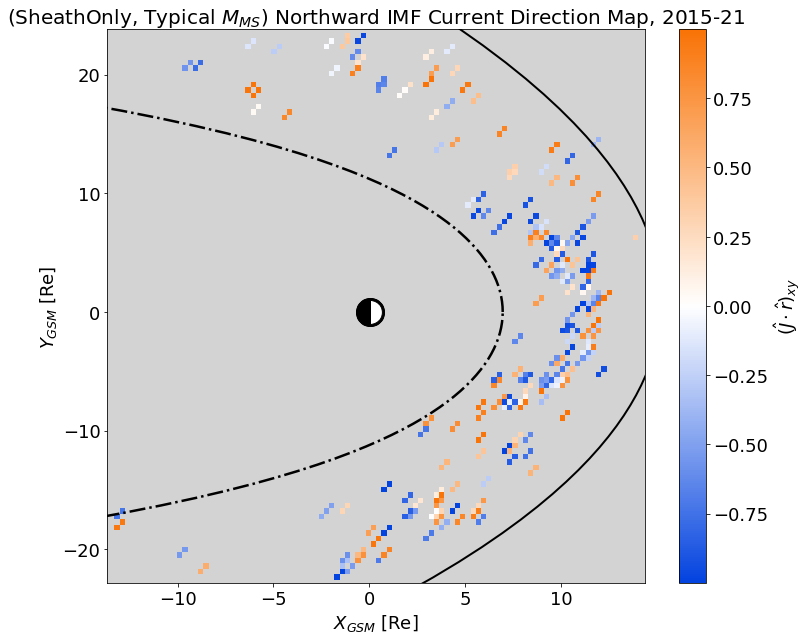

In [55]:
def restrict_curcosY_DF(df_curcos, achPlane):
    """Using inputted CurCos2D DF and plane preference, create new DF that imposes the restriction
    |Y| <= 10Re"""
    if achPlane == 'xz': #return og DF has |z|range is already bounded by 10Re
        z = df_curcos['z_avg(Re)'].to_numpy(copy=True)
        print('\t\tReturning Inputted DF whose zrange is [%0.2f, %0.2f]Re'% (np.min(z), np.max(z)) )
        df_return = df_curcos
    elif achPlane == 'xy': #Create sub DF |y| values <=10Re
        y = df_curcos['y_avg(Re)'].to_numpy(copy=True)
        nYbig_idx = np.array([]) #initialize empty drop index arrays
        for i in range(len(y)):
            if np.abs(y[i]) > 10: #get index array of |y|-values greater than 10Re
                nYbig_idx = np.append(nYbig_idx, i)
        # Redefine new dataframes by dropping |y| values > 10Re
        df_cop = df_curcos.copy(deep = True) #creating copy of CurrMECcosine datframe
        df_cop = df_cop.drop(nYbig_idx) #dropping DF rows that have y > 10Re
        df_cop = df_cop.reset_index(drop=True) # reset index# column for new DF
        #Checks if respective y-column arrays contain nonnegative and negative entries only
        y_new = df_cop['y_avg(Re)'].to_numpy(copy=True)
        print('\t\tConfirmed: New DF was created with yrange = [%0.2f, %0.2f]Re'%(np.min(y_new), np.max(y_new))) 
        df_return = df_cop
    return(df_return);


def Jdotr_justSheath(df_stable, achPlane, pTitle, legTitle):
    """With inputted Sheath Only DF, create current cosine (J.r)^ contour maps on the xy or xz-plane and 
    restrict |Y|/|Z| <= 10Re
    With inputted CurCos2D Dataframe, make a histogram of the Zpos/Ypos vs (J.r)^ cosine angles on the xy/xz-plane"""
    print('\nSheath Only CurrCos Map with: ',namestr(df_stable, globals()), achPlane)
    afClang = df_stable['Clang_avg'].to_numpy(copy=True)
    print('Clock Angle Range [%0.2f, %0.2f]deg'%(min(afClang), max(afClang)))
    #Define Latex string versions of J.r dot product
    jdr_xz = r'$(\hat{J}\cdot\hat{r})_{xz}$' #latex string version of J.r
    jdr_xy = r'$(\hat{J}\cdot\hat{r})_{xy}$'
    #----------------------------------------------------
    if achPlane == 'xz': #Contour map J.r cosine angles on xz-plane
        print('CurCosing Map on xz-plane')
        #df_Ztrim = restrict_curcosY_DF(df_stable, 'xz')
        display_jdotrCOLORmapsXZ(df_stable, pTitle, legTitle)
    #----------------------------------------------------
    elif achPlane == 'xy-restrict': #Contour map of J.r cosine angles on xy-plane
        print('CurCosing Map on xy-plane')
        #Create DF and define explicit variables for cosine data above and below yaxis
        df_Ytrim = restrict_curcosY_DF(df_stable, 'xy') #create new DF with yvalues bounded by |y|< =10Re
        display_jdotrCOLORmaps(df_Ytrim, pTitle, legTitle)
    elif achPlane == 'xy': #Contour map of J.r cosine angles on xy-plane
        print('CurCosing Map on xy-plane')
        #Create DF and define explicit variables for cosine data above and below yaxis
        display_jdotrCOLORmaps(df_stable, pTitle, legTitle)
    else:
        print('Invalid input')
    return;


#Jdotr_justSheath(Sheathtrim_postMap_soBz_stabDay, 'xy-restrict', '(SheathOnly) Stable Day soBz IMF Current Map 2015-21', 'Southward Bz' )
#plt.savefig('manual_StableDaysoBz_SheathOnlyY10_JdotrXYmap_2015to21_v2', bbox_inches='tight', facecolor = 'w')

#Jdotr_justSheath(Sheathtrim_postMap_norBz_stabDay, 'xy-restrict', '(SheathOnly) Stable Day norBz IMF Current Map 2015-21', 'Northward Bz')
#plt.savefig('manual_StableDaynorBz_SheathOnlyY10_JdotrXYmap_2015to21_v2', bbox_inches='tight', facecolor = 'w')





#---------(Typ Mgs Mach)SheathOnly Jdotr Maps------------
#Jdotr_justSheath(Sheathtrim_postMap_posBy_stabDay, 'xz', r'(SheathOnly, Typical $M_{MS}$) Positive By IMF Current Direction Map, 2015-21' ,'Positive By')
#plt.savefig('manual_noleg_SheathOnly_StableDayposBy_JdotrXZmap_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#Jdotr_justSheath(Sheathtrim_postMap_negBy_stabDay, 'xz', r'(SheathOnly, Typical $M_{MS}$) Negative By IMF Current Direction Map, 2015-21' ,'Negative By')
#plt.savefig('manual_noleg_SheathOnly_StableDaynegBy_JdotrXZmap_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#Jdotr_justSheath(Sheathtrim_postMap_soBz_stabDay, 'xy', r'(SheathOnly, Typical $M_{MS}$) Southward IMF Current Direction Map, 2015-21', 'Southward Bz' )
#plt.savefig('manual_noleg_SheathOnly_StableDaysoBz_JdotrXYmap_2015to21_v1', bbox_inches='tight', facecolor = 'w')

Jdotr_justSheath(Sheathtrim_postMap_norBz_stabDay, 'xy', r'(SheathOnly, Typical $M_{MS}$) Northward IMF Current Direction Map, 2015-21', 'Northward Bz')
#plt.savefig('manual_noleg_SheathOnly_StableDaynorBz_JdotrXYmap_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#---------(Low Mgs Mach) Sheath Only Jdotr Maps---------
#Jdotr_justSheath(Sheathtrim_postMap_5MGSsoBz_stabDay, 'xy', r'(SheathOnly, $M_{MS}$ < 5) Southward IMF Current Direction Map, 2015-21', 'Southward Bz' )
#plt.savefig('manual_5MGS_SheathOnly_StableDaysoBz_JdotrXYmap_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#Jdotr_justSheath(Sheathtrim_postMap_5MGSnorBz_stabDay, 'xy', r'(SheathOnly, $M_{MS}$ < 5) Northward IMF Current Direction Map, 2015-21', 'Northward Bz' )
#plt.savefig('manual_5MGS_SheathOnly_StableDaynorBz_JdotrXYmap_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#Jdotr_justSheath(Sheathtrim_postMap_5MGSposBy_stabDay, 'xz', r'(SheathOnly, $M_{MS}$ < 5) Positive By IMF Current Direction Map, 2015-21', 'Positive By' )
#plt.savefig('manual_5MGS_SheathOnly_StableDayposBy_JdotrXZmap_2015to21_v1', bbox_inches='tight', facecolor = 'w')

#Jdotr_justSheath(Sheathtrim_postMap_5MGSnegBy_stabDay, 'xz', r'(SheathOnly, $M_{MS}$ < 5) Negative By IMF Current Direction Map, 2015-21', 'Negative By' )
#plt.savefig('manual_5MGS_SheathOnly_StableDaynegBy_JdotrXZmap_2015to21_v1', bbox_inches='tight', facecolor = 'w')


25-Apr-23 12:06:26: <>:43: DeprecationWarning: invalid escape sequence \l

25-Apr-23 12:06:26: <>:43: DeprecationWarning: invalid escape sequence \l

25-Apr-23 12:06:26: /var/folders/yl/ld8jwz2d7dvcslpjc43t11p1tfdn27/T/ipykernel_1763/1234119379.py:43: DeprecationWarning: invalid escape sequence \l
  achTitle_Y = '($|Y|\leq 10 R_E$)Histogram of %s %s Dayside Sheath Percent Cosine Data for $Y_{GSM}$ from 2015-21'%(clang, jcs_xy)




Histing stuff with:  ['Sheath_stabDaysoBz_jcospercent'] soBz xy
Clock Angle Range [135.10, 224.83]deg
Histing Y vs (Jcos)_xy and (J.r)^_xy Percents
		Confirmed: New DF was created with yrange = [-9.89, 9.91]Re
		Confirmed: +Y cos_xy DF was created and contains (y>=0) array: True
		Confirmed: -Y cos_xy DF was created and contains (y<0) array: True


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),...,Jcosxy_avg,Jcosxy_med,"cosxy_pos(0.25,%)","cosxy_neg(0.25,%)",Jcosxz_pos(%),Jcosxz_neg(%),Jcosxz_avg,Jcosxz_med,"cosxz_pos(0.25,%)","cosxz_neg(0.25,%)"
0,2015-09-07 18:00:00,2015-09-07 18:10:00,11.796126,1.533919,10.868678,-4.320330,160.846,2.332,3.052,-8.747,...,0.004670,0.002456,47.494531,22.835712,40.337535,59.662465,-0.004214,-0.002374,33.295135,49.911449
1,2015-09-09 09:20:00,2015-09-09 09:30:00,9.354687,5.276178,6.654388,-3.922846,166.640,1.998,2.092,-8.793,...,0.000283,-0.000541,37.518233,40.893936,47.218170,52.781830,-0.001956,-0.001621,44.009169,47.280683
2,2015-09-09 09:50:00,2015-09-09 10:00:00,9.763337,5.214693,7.055418,-4.283524,166.093,2.157,2.122,-8.583,...,-0.002072,-0.001401,35.086988,41.545994,60.339619,39.660381,0.001516,0.003186,54.505678,35.034899


	Length of cos_jxy array: 340
	PosY-range = 0.08 to 9.91 Re
	NegY-range = -9.89 to -0.02 Re
Histing and Plotting For +Y cos_xy and Jcos_xy Percent DFs:
Histing and Plotting For -Y cos_xy and Jcos_xy Percent DFs:

Histing stuff with:  ['Sheath_stabDaynorBz_jcospercent'] norBz xy
Clock Angle Range [3.30, 357.49]deg
Histing Y vs (Jcos)_xy and (J.r)^_xy Percents
		Confirmed: New DF was created with yrange = [-9.96, 9.94]Re
		Confirmed: +Y cos_xy DF was created and contains (y>=0) array: True
		Confirmed: -Y cos_xy DF was created and contains (y<0) array: True


,Start_str,End_str,Rmag_avg(Re),x_avg(Re),y_avg(Re),z_avg(Re),Clang_avg,IMFBx_avg(nT),IMFBy_avg(nT),IMFBz_avg(nT),...,Jcosxy_avg,Jcosxy_med,"cosxy_pos(0.25,%)","cosxy_neg(0.25,%)",Jcosxz_pos(%),Jcosxz_neg(%),Jcosxz_avg,Jcosxz_med,"cosxz_pos(0.25,%)","cosxz_neg(0.25,%)"
0,2015-09-23 12:50:00,2015-09-23 13:00:00,11.860942,6.051514,8.503119,-5.635294,327.280,8.127,-2.137,3.347,...,-0.002216,-0.001552,25.838716,48.499687,58.126693,41.873307,0.001061,0.000782,24.473849,21.431548
1,2015-09-23 14:20:00,2015-09-23 14:30:00,11.993631,5.398036,9.142311,-5.578949,343.448,3.487,-2.218,7.592,...,0.000928,0.001012,47.801625,34.080017,38.153782,61.846218,-0.001746,-0.001345,23.713274,46.853511
2,2015-10-13 12:10:00,2015-10-13 12:20:00,12.003277,8.434973,6.980826,-4.918995,344.140,-3.990,-1.080,3.925,...,0.000038,0.000346,37.806021,38.337327,55.703719,44.296281,0.000878,0.000904,35.805813,29.857277


	Length of cos_jxy array: 211
	PosY-range = 0.28 to 9.94 Re
	NegY-range = -9.96 to -0.18 Re
Histing and Plotting For +Y cos_xy and Jcos_xy Percent DFs:
Histing and Plotting For -Y cos_xy and Jcos_xy Percent DFs:


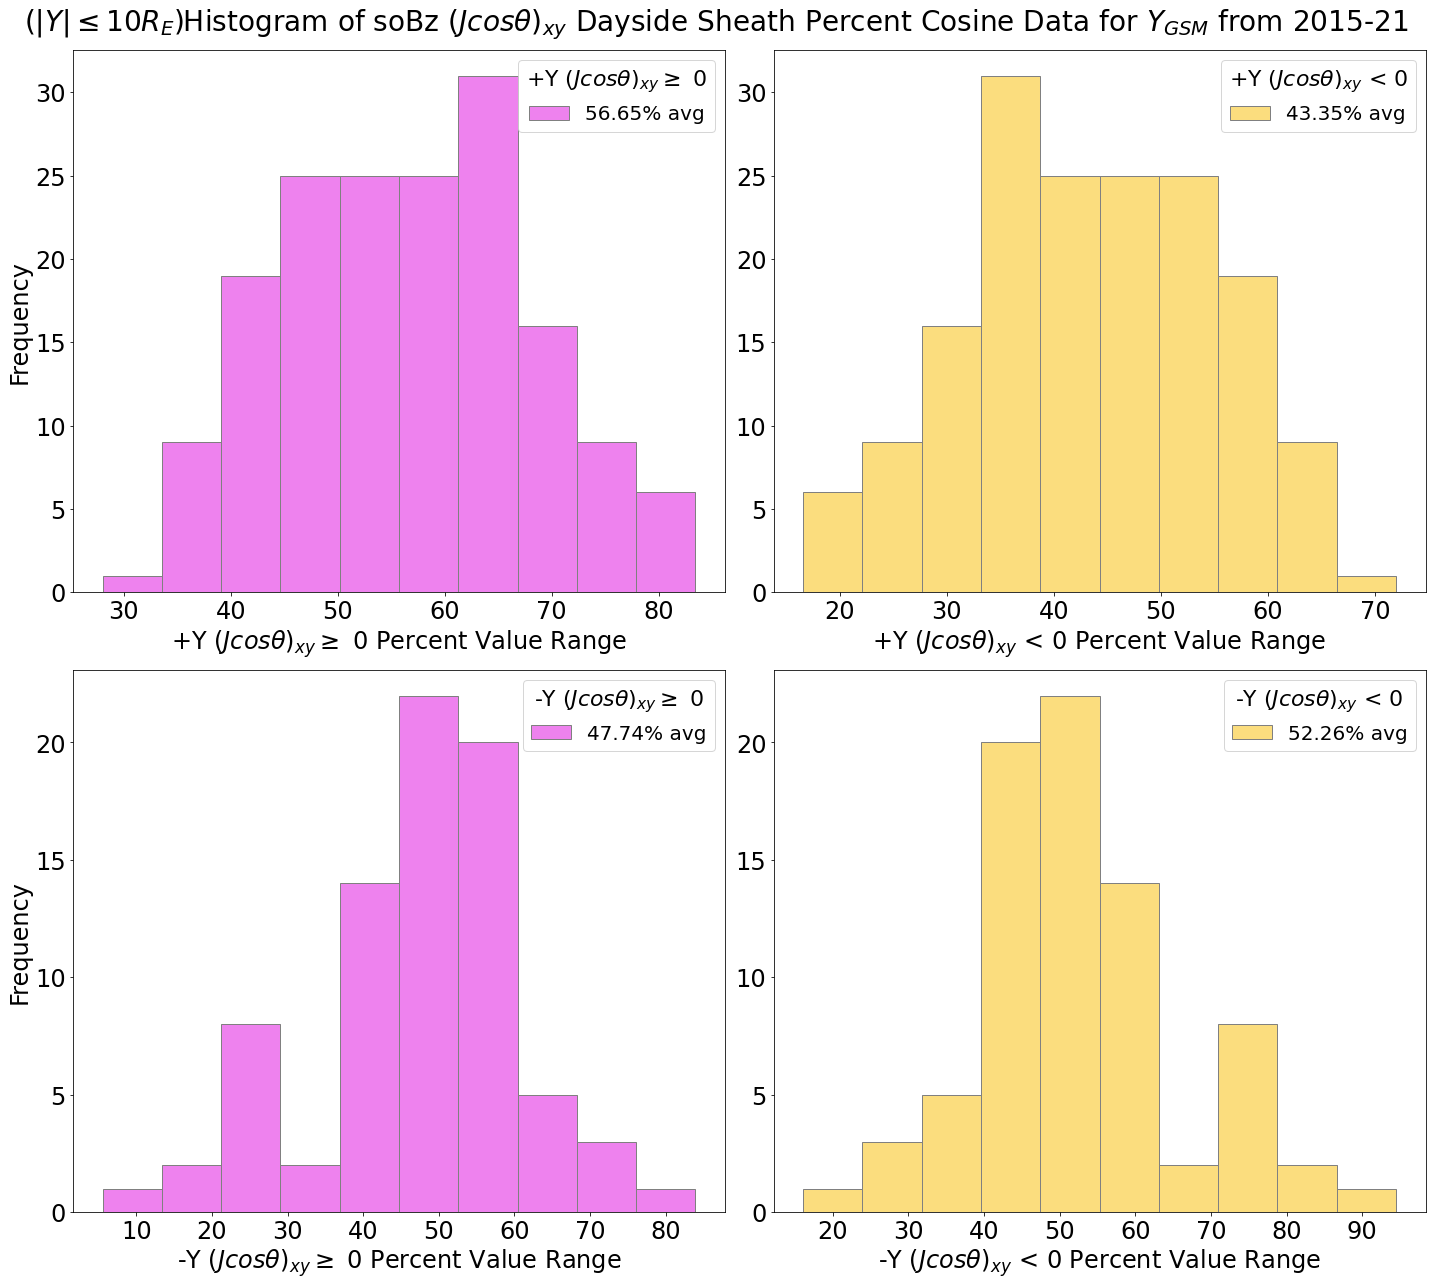

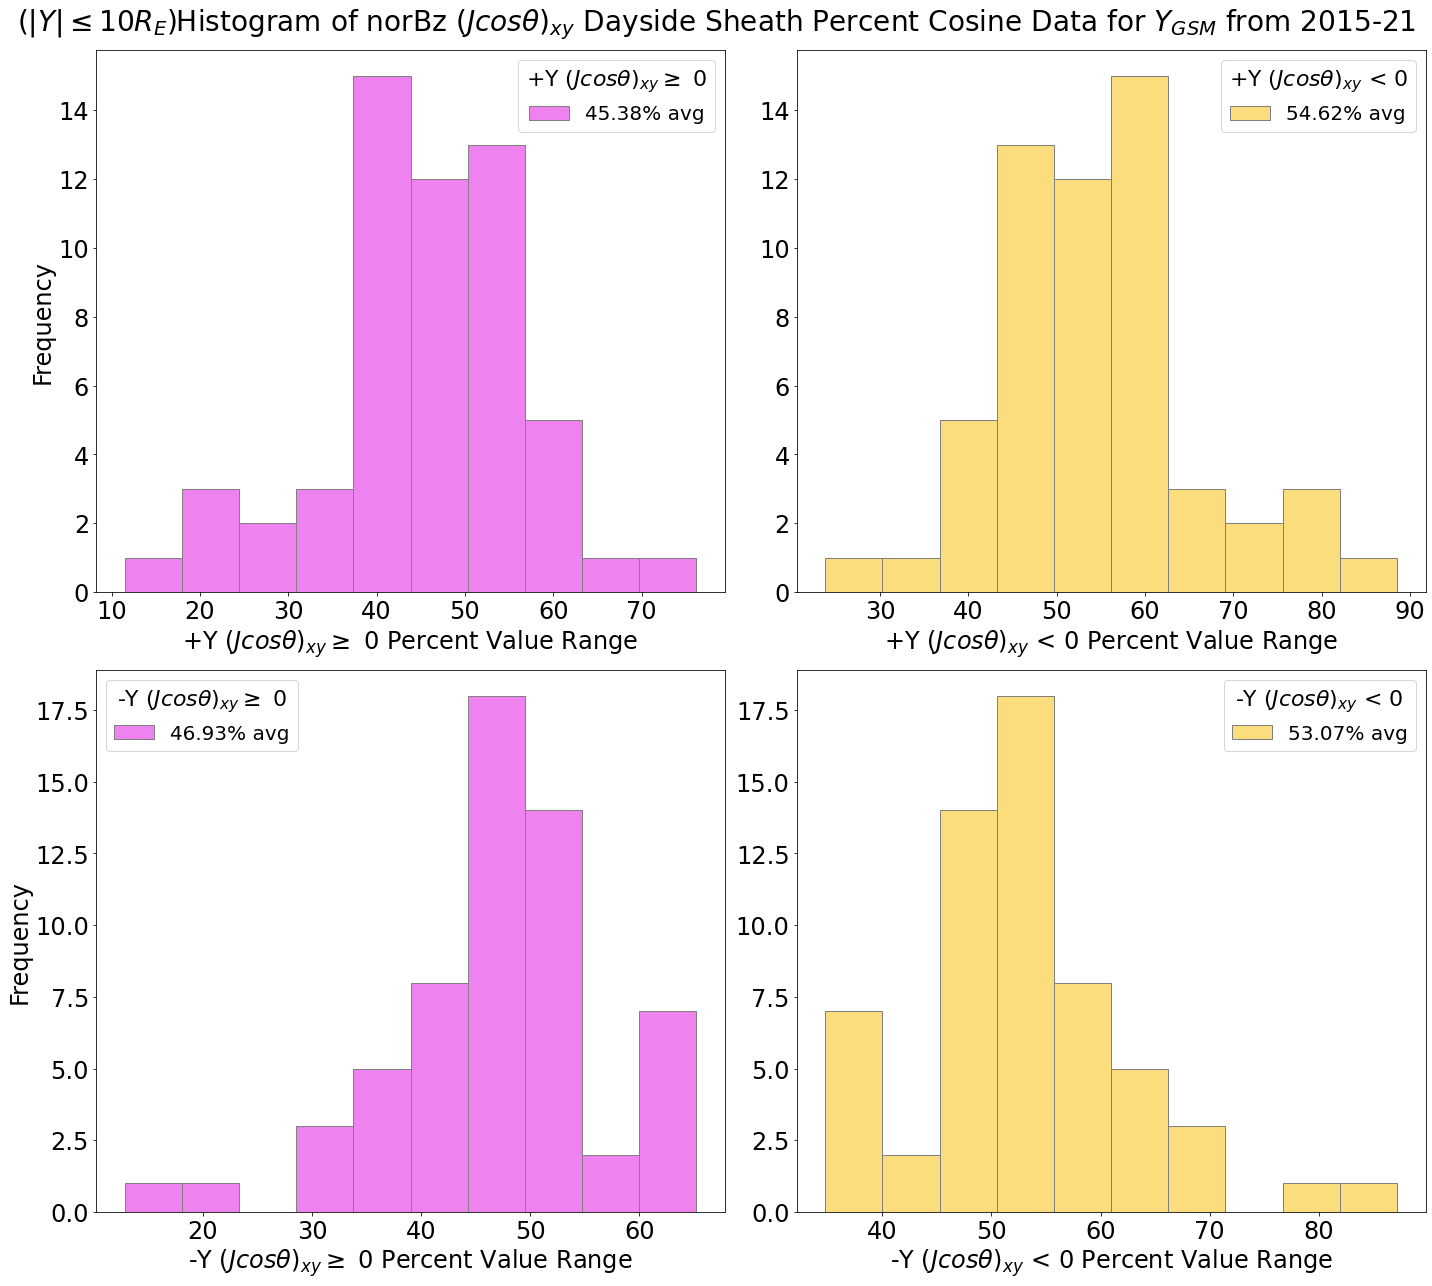

In [56]:
def restrictY_curJcospercents(df_curcos, clang, achPlane):
    """With inputted CurCos2D_withpercents Dataframe, make a histogram of the Zpos/Ypos vs 
    |J|cos and (J.r)^ cosine angle percent values(towards/away from Earth) on the xy/xz-plane"""
    print('\nHisting stuff with: ',namestr(df_curcos, globals()), clang, achPlane)
    afClang = df_curcos['Clang_avg'].to_numpy(copy=True)
    print('Clock Angle Range [%0.2f, %0.2f]deg'%(min(afClang), max(afClang)))
    #Define Latex string versions of J.r dot product
    jdr_xz = r'$(\hat{J}\cdot\hat{r})_{xz}$' #latex string version of J.r
    jcs_xz = r'$(Jcos\theta)_{xz}$'
    jdr_xy = r'$(\hat{J}\cdot\hat{r})_{xy}$'
    jcs_xy = r'$(Jcos\theta)_{xy}$'

    #----------------------------------------------------
    if achPlane == 'xz': #Hist Zpos vs J.r cosine angles on xz-plane
        print('Histing Z vs (Jcos)_xz and (J.r)^_xz Percents')
        #Create DF and define explicit variables for cosine data above and below zaxis
        [df_curcos_negz, df_curcos_posz] = get_curcosTopBot_DF(df_curcos, 'xz')
        display(df_curcos[:3])
        #display(df_curcos_negz[:3])
        #display(df_curcos_posz[:3])
        afPosz = df_curcos_posz['z_avg(Re)'].to_numpy(copy=True)
        afNegz = df_curcos_negz['z_avg(Re)'].to_numpy(copy=True)
        print('\tLength of cos_jxz array:',len(afClang))
        print('\tPosZ-range = %0.2f to %0.2f Re'%(min(afPosz), max(afPosz)))
        print('\tNegZ-range = %0.2f to %0.2f Re'%(min(afNegz), max(afNegz)))
        ##Create histogram of J.r cosine angles on xz-plane for positive/negative z-values
        achTitle_Z = 'Histogram of %s %s Dayside Sheath Percent Cosine Data for $Z_{GSM}$ from 2015-21'%(clang, jcs_xz)
        hist_curcospercent2D(df_curcos_posz,df_curcos_negz, achTitle_Z, 'xz')
    #----------------------------------------------------
    elif achPlane == 'xy': #Hist Ypos vs J.r cosine angles on xy-plane
        print('Histing Y vs (Jcos)_xy and (J.r)^_xy Percents')
        df_Ytrim = restrict_curcosY_DF(df_curcos, 'xy') #create new DF with yvalues bounded by |y|< =10Re
        #Create DF and define explicit variables for cosine data above and below yaxis
        [df_curcos_negy, df_curcos_posy] = get_curcosTopBot_DF(df_Ytrim, 'xy')
        display(df_curcos[:3])
        #display(df_curcos_negy[:3])
        #display(df_curcos_posy[:3])
        afPosy = df_curcos_posy['y_avg(Re)'].to_numpy(copy=True)
        afNegy = df_curcos_negy['y_avg(Re)'].to_numpy(copy=True)
        print('\tLength of cos_jxy array:',len(afClang))
        print('\tPosY-range = %0.2f to %0.2f Re'%(min(afPosy), max(afPosy)))
        print('\tNegY-range = %0.2f to %0.2f Re'%(min(afNegy), max(afNegy)))
        achTitle_Y = '($|Y|\leq 10 R_E$)Histogram of %s %s Dayside Sheath Percent Cosine Data for $Y_{GSM}$ from 2015-21'%(clang, jcs_xy)
        hist_curcospercent2D(df_curcos_posy,df_curcos_negy, achTitle_Y, 'xy')
        # (Jcos)_2D > 0  Percent Value Range and (J.r)^ > 0 Percent Value Range
    else:
        print('Invalid input')
    return;

#---------Main Calling Below----------

restrictY_curJcospercents(Sheath_stabDaysoBz_jcospercent, 'soBz', 'xy')
#plt.savefig('JpercHistPlot_StableDaysoBz_SheathOnlyY10_2015to21_v3', bbox_inches='tight', facecolor = 'w')

restrictY_curJcospercents(Sheath_stabDaynorBz_jcospercent, 'norBz', 'xy')
#plt.savefig('JpercHistPlot_StableDaynorBz_SheathOnlyY10_2015to21_v3', bbox_inches='tight', facecolor = 'w')
